# Parallax 

Pre-module thing 
- Turn BT and CTH into dataframes 
- Combine the brightness temp and cloud top height files into one data frame by closest location 
- Add in the parallax file as DF to the combined BT CTH DF 
- For each row / pixel do the calculation to shift location of lat lon for the BT , using CTH and parallax info 

Actual thing 
- DF that drops the parallax and CTH info, just want fixed goes BT for lat lon 
- Take simplified DF and combine it with lightning DF for correct locations of everything 
- Use this as what I pass through statistical tests / analysis for everything (redo everything!) 
- For maps still use unshifted goes since the new grid will be weird 

- Look at BT and CTH, might be same grid but different time or resolution 


# imports 

In [76]:
import os
import awscli as aws
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date 
from datetime import time
import math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely import geometry

import matplotlib.pyplot as plt
import xarray 
import metpy  
from mpl_toolkits.basemap import Basemap
import colormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import time
import calendar
from matplotlib.patches import Polygon
import geopandas as gpd
from shapely.geometry import Point, Polygon
from netCDF4 import Dataset # Import the NetCDF Python interface
import netCDF4 as nc
import dask
import nco
from sklearn.neighbors import NearestNeighbors
from math import radians, cos, sin, asin, sqrt
from textwrap import wrap
import matplotlib.patches as mpatches
import matplotlib.gridspec as grd

import scipy

from pymatreader import read_mat
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as grd

from mpl_toolkits.axes_grid1 import ImageGrid
from shapely import geometry
from shapely.geometry import Point, LineString, Polygon, box
from tabulate import tabulate


# functions

## covert x/y to lat/lon with xarray : calc_latlon(ds)
- GOES-17 will be located at 137 degrees west longitude

In [77]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
        
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

## dist / haversine

In [78]:
def dist(lat1, long1, lat2, long2):
    """
Replicating the same formula as mentioned in Wiki
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [79]:
ds= xarray.open_dataset('/data2/edworak/data/BT_nosmoke/202116618/OR_ABI-L2-MCMIPF-M6_G17_s20211661850321_e20211661859399_c20211661859541.nc')
ds_latlon = calc_latlon(ds)


/tmp/ipykernel_166406/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


# PyroCb

## data

### pyroCb brightness temp

In [80]:
# create empty array to add into 
file_names_unsorted_pyrocb = []

path = '/data2/edworak/data/PyroCb/MCMIPF1/'
file = os.listdir(path)

for f in file: 
    #print(f)
    #print(len(f))
    file_names_unsorted_pyrocb.append(f)
file_names_pyrocb = sorted(file_names_unsorted_pyrocb)

print(len(file_names_unsorted_pyrocb))
file_names_pyrocb

42


['OR_ABI-L2-MCMIPF-M6_G16_s20211820400207_e20211820409521_c20211820410020.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820410207_e20211820419515_c20211820420018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820420207_e20211820429521_c20211820430021.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820430207_e20211820439527_c20211820440018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820440208_e20211820449526_c20211820450018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820450208_e20211820459527_c20211820500020.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820500210_e20211820509529_c20211820510026.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820510210_e20211820519529_c20211820520018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820520210_e20211820529529_c20211820530019.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820530210_e20211820539529_c20211820540018.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820540210_e20211820549518_c20211820550021.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211820550210_e20211820559529_c20211820600030.nc',
 'OR_ABI-L2-MCMIPF-M6_G17_s20211812300319_e202118123

In [81]:
goes_data_pyrocb = []

for i in range(len(file_names_pyrocb)):
    path = '/data2/edworak/data/PyroCb/MCMIPF1/'
    FILE = path + file_names_pyrocb[i]
   # print(FILE)
    #"goes_"+ filename[i][30:36] = xarray.open_dataset(FILE)
    goes_data_pyrocb = xarray.open_dataset(FILE)
goes_data_pyrocb

<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1518 ... -0.1518
  * x                                       (x) float32 -0.1518 ... 0.1518
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-07-01T03:59:54.4Z
    time_coverage_start:       2021-07-01T03:50:32.0Z
    time_coverage_end:         2021-07-01T03:59:39.2Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        511d834e-1fe8-45e0-b593-299e1c8a725f

In [82]:
bt_df_pyrocb = pd.read_csv('/data2/edworak/data/bt_df_pyrocb.nc')
bt_df_pyrocb

,y,x,year,month,day,hour,minute,second,lat,lon,CMI_C14
0,0.131068,0.026516,2021,6,30,23,5,5,52.983370,-121.493970,21.145966
1,0.131068,0.026572,2021,6,30,23,5,5,52.984740,-121.459590,8.876587
2,0.131068,0.026628,2021,6,30,23,5,5,52.986404,-121.425026,-8.779388
3,0.131068,0.026684,2021,6,30,23,5,5,52.987580,-121.390740,-15.602386
4,0.131068,0.026740,2021,6,30,23,5,5,52.989246,-121.356155,-27.632370
...,...,...,...,...,...,...,...,...,...,...,...
116335,0.128044,0.032060,2021,7,1,3,55,5,51.041077,-119.029610,26.652252
116336,0.127988,0.031948,2021,7,1,3,55,5,51.000580,-119.113260,26.233307
116337,0.127988,0.032004,2021,7,1,3,55,5,51.002155,-119.079790,26.293152
116338,0.127988,0.032060,2021,7,1,3,55,5,51.003777,-119.046265,25.634796


### lightning data

In [83]:
data = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["a", "c", "Date", "e", "lon", "i", "peak-current", "lat", "m", "n", "o", "polarity", "range", "signal", "time", "u", "v", "z", "A", "C", "E", "C or G", "mag_current", "lat2", "m2", "time_nano", "R", "S", "T", "latlon"], delim_whitespace = True, skiprows = 0)
data2 = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["Date", "lon","peak-current", "lat", "multi", "polarity", "range", "Time", "C or G" ], delim_whitespace = True, skiprows = 0, usecols = [3,5,7,9,10,13,14,17,24])
data2[["year", "month", "day"]] = data2["Date"].str.split("-", expand = True)
data2[["hour", "minute", "second"]] = data2["Time"].str.split(":", expand = True)
data2['year'] = data2['year'].astype('int')
data2['month'] = data2['month'].astype('int')
data2['day'] = data2['day'].astype('int')
data2['hour'] = data2['hour'].astype('int')
data2['minute'] = data2['minute'].astype('int')
data_split2 = data2[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G", "multi", "polarity", "range"]]

data_split2

,year,month,day,hour,minute,second,lat,lon,peak-current,C or G,multi,polarity,range
0,2021,6,2,22,15,39,58.073,-119.732,14.7,C,0,+,11817.95
1,2021,6,2,22,15,40,58.043,-119.737,12.2,C,0,+,11819.49
2,2021,6,2,22,19,23,58.060,-118.448,-40.3,G,0,-,11818.65
3,2021,6,2,22,19,23,58.060,-118.449,-22.4,G,0,-,11818.65
4,2021,6,2,22,19,23,58.059,-118.448,-9.5,G,0,-,11818.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308797,2021,7,31,23,55,54,52.396,-123.137,-12.6,G,0,-,12104.32
1308798,2021,7,31,23,55,54,52.397,-123.148,-17.5,G,0,-,12104.26
1308799,2021,7,31,23,55,54,52.334,-123.095,-6.7,G,0,-,12107.33
1308800,2021,7,31,23,56,39,52.323,-122.974,2.4,C,0,+,12107.86


In [84]:
data_30 = data_split2.loc[(data_split2["day"] == 30) & (data_split2["hour"] >= 22) & (data_split2.lon >= -121.5) & (data_split2.lon <= -119) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
data_1 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"]<= 3) & (data_split2.lon >= -121.5) & (data_split2.lon <= -119) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
frames = [data_30, data_1]
data_pyrocb= pd.concat(frames)
data_pyrocb


,year,month,day,hour,minute,second,lat,lon,peak-current,C or G,multi,polarity,range
277793,2021,6,30,22,12,59,51.215,-120.986,-6.3,C,0,-,12161.83
277829,2021,6,30,22,16,13,51.491,-120.962,-7.7,C,0,-,12148.47
277830,2021,6,30,22,17,08,51.354,-120.997,3.2,C,0,+,12155.11
277847,2021,6,30,22,19,12,51.501,-121.040,4.5,C,0,+,12147.96
277858,2021,6,30,22,20,29,51.579,-121.045,2.6,C,0,+,12144.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331911,2021,7,1,3,56,42,52.451,-120.730,1.8,C,0,+,12101.60
332130,2021,7,1,3,57,16,52.483,-120.679,-2.6,C,0,-,12100.05
332131,2021,7,1,3,57,16,52.496,-120.657,-40.2,G,0,-,12099.41
332133,2021,7,1,3,57,16,52.495,-120.654,-4.2,G,0,-,12099.46


### cloud top height
- june 30 : 181 
- july 1 : 182 

In [85]:
cth_data_xy = xarray.open_dataset("/data2/edworak/data/cloud_top_height/202118123/OR_ABI-L2-ACHAF-M6_G17_s20211812300319_e20211812309386_c20211812310445.nc")
cth_data = calc_latlon(cth_data_xy)
cth_data
# info that I want 
# t, lat , lon , maximum cloud top height , mean cloud top height


/tmp/ipykernel_166406/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


<xarray.Dataset>
Dimensions:                                 (y: 1086, x: 1086,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             number_of_LZA_bounds: 2,
                                             number_of_SZA_bounds: 2)
Coordinates:
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1519 ... -0.1519
  * x                                       (x) float32 -0.1519 ... 0.1519
    y_image                                 float32 ...
    x_image                                 float32 ...
    local_zenith_angle                      float32 ...
    solar_zenith_angle                      float32 ...
    lat                                     (y, x) float32 nan nan ... nan nan
    lon                                     (y, x) float32 nan nan ... nan nan
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds
Data variables: (12/23)
    HT                                      (y, x) float32 ...
    DQF                                     (y, x) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                  int32 ...
    y_image_bounds                          (number_of_image_bounds) float32 ...
    x_image_bounds                          (number_of_image_bounds) float32 ...
    ...                                      ...
    algorithm_product_version_container     int32 ...
    local_zenith_angle_bounds               (number_of_LZA_bounds) float32 ...
    solar_zenith_angle_bounds               (number_of_SZA_bounds) float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    cloud_pixels                            float64 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2021-06-30T23:00:31.9Z
    time_coverage_end:         2021-06-30T23:09:38.6Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        7fab4d82-dfd0-4363-b20f-ccc21fadda7e

In [86]:
folder_names_unsorted_cth = []
path_cth = '/data2/edworak/data/cloud_top_height/'
folder_cth = os.listdir(path_cth)

for f in folder_cth: 
    folder_names_unsorted_cth.append(str(path_cth) + str(f))
folder_names_cth = sorted(folder_names_unsorted_cth)

folder_names_cth = folder_names_cth[:-2]


file_names_unsorted_cth = []

for i in range(len(folder_names_cth)): 
    file_cth = os.listdir(folder_names_cth[i])
    for f in file_cth: 
        file_names_unsorted_cth.append(str(folder_names_cth[i]) + "/" + str(f))
fullpath_cth = sorted(file_names_unsorted_cth)
fullpath_cth_pyrocb = fullpath_cth[521:558]
fullpath_cth_pyrocb

['/data2/edworak/data/cloud_top_height/202118122/OR_ABI-L2-ACHAF-M6_G17_s20211812200319_e20211812209386_c20211812210445.nc',
 '/data2/edworak/data/cloud_top_height/202118122/OR_ABI-L2-ACHAF-M6_G17_s20211812210319_e20211812219386_c20211812220486.nc',
 '/data2/edworak/data/cloud_top_height/202118122/OR_ABI-L2-ACHAF-M6_G17_s20211812220319_e20211812229386_c20211812230390.nc',
 '/data2/edworak/data/cloud_top_height/202118122/OR_ABI-L2-ACHAF-M6_G17_s20211812230319_e20211812239386_c20211812240428.nc',
 '/data2/edworak/data/cloud_top_height/202118122/OR_ABI-L2-ACHAF-M6_G17_s20211812240319_e20211812249386_c20211812250443.nc',
 '/data2/edworak/data/cloud_top_height/202118122/OR_ABI-L2-ACHAF-M6_G17_s20211812250319_e20211812259386_c20211812300422.nc',
 '/data2/edworak/data/cloud_top_height/202118123/OR_ABI-L2-ACHAF-M6_G17_s20211812300319_e20211812309386_c20211812310445.nc',
 '/data2/edworak/data/cloud_top_height/202118123/OR_ABI-L2-ACHAF-M6_G17_s20211812310319_e20211812319386_c20211812320474.nc',


### turn cth into dataframe

In [87]:
"""for i in range(len(fullpath_cth_pyrocb)):
    FILE = fullpath_cth_pyrocb[i] 
    ds_latlon = calc_latlon(xarray.open_dataset(FILE))

    #select by lat/lon region
    lat_min, lat_max = 51, 53
    lon_min, lon_max = -121.5, -119
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
    
    #select CMI_C14 channel anc convert into celsius
    max_cth = selected_region['maximum_cloud_top_height'][:]
    max_cth.attrs["units"] = "m"

    mean_cth = selected_region['mean_cloud_top_height'][:]
    mean_cth.attrs["units"] = "m"
    
    # Convert the xarray dataarray to a pandas dataframe
    df =  mean_cth.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    cth_hourly_df_pyrocb = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "mean_cloud_top_height")]
    cth_hourly_df_pyrocb.dropna(inplace = True)
    
    if i == 0: 
        cth_df_pyrocb = cth_hourly_df_pyrocb
    if i > 0: 
        cth_df_pyrocb = pd.concat([cth_df_pyrocb, cth_hourly_df_pyrocb], axis =0)

        """

'for i in range(len(fullpath_cth_pyrocb)):\n    FILE = fullpath_cth_pyrocb[i] \n    ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n\n    #select by lat/lon region\n    lat_min, lat_max = 51, 53\n    lon_min, lon_max = -121.5, -119\n    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n    \n    #select CMI_C14 channel anc convert into celsius\n    max_cth = selected_region[\'maximum_cloud_top_height\'][:]\n    max_cth.attrs["units"] = "m"\n\n    mean_cth = selected_region[\'mean_cloud_top_height\'][:]\n    mean_cth.attrs["units"] = "m"\n    \n    # Convert the xarray dataarray to a pandas dataframe\n    df =  mean_cth.to_dataframe()\n    scan_start = datetime.strptime(ds_latlon.time_coverage_start, \'%Y-%m-%dT%H:%M:%S.%fZ\')\n    \n    df[\'Date\'] = pd.to_datetime(df[\'t\'])\n    df[\'year\'] = df[

In [88]:
df_cth_pyrocb = pd.read_csv('/data2/edworak/data/mean_max_cth_pyrocb.nc', usecols = [3, 4, 5, 6, 7, 9, 10, 11, 22])
#df_cth_pyrocb_unq = df_cth_pyrocb.drop_duplicates(keep='first')
np.min(df_cth_pyrocb.maximum_cloud_top_height)
# test = df_cth_pyrocb.loc[(df_cth_pyrocb.lat >= 52) & (df_cth_pyrocb.lat < 53) & (df_cth_pyrocb.lon >-121) & (df_cth_pyrocb.lon < -120) & (df_cth_pyrocb.hour == 2)]
# test

17343.70703125

## parallax
- Note that all longitudes in the file are referenced to zero at the sub-satellite point (e.g. 75 W for GOES-East). This file therefore can be used with any geostationary satellite.
- GOES-17 will be located at 137 degrees west longitude
- did i do this correctly? wouldn't I do BT -137 or parallax + 137 

In [89]:
"""parallax = xarray.open_dataset("/data2/edworak/data/cloud_top_height/geostationary_parallax.nc")
# df = parallax.to_dataframe()
parallax_testing = pd.read_csv("/data2/edworak/data/parallax_testing.nc")
parallax_testing.longitude = parallax_testing.longitude - 137
parallax_df = parallax_testing.loc[(parallax_testing.latitude >= 51) & (parallax_testing.latitude <= 53) & (parallax_testing.longitude >= -121.5) & (parallax_testing.longitude <= -119)]
parallax_df
"""

,latitude,longitude,parallax_longitude,parallax_latitude,parallax_ratio
84031,51.0,-121.5,0.000008,0.000015,1.746714
84032,51.0,-121.0,0.000009,0.000015,1.755025
84033,51.0,-120.5,0.000009,0.000015,1.763641
84034,51.0,-120.0,0.000009,0.000015,1.772566
84035,51.0,-119.5,0.000010,0.000015,1.781804
84036,51.0,-119.0,0.000010,0.000015,1.791359
84351,51.5,-121.5,0.000009,0.000015,1.783547
84352,51.5,-121.0,0.000009,0.000015,1.791970
84353,51.5,-120.5,0.000009,0.000015,1.800702
84354,51.5,-120.0,0.000010,0.000015,1.809747


## calculate 
- For each pixel in the GOES image, find the cloud top height (cth) use the apparent lat (alat) and lon (alon) to look up the parallax_latitude and parallax_longitude for that location. The true location of that pixel will be approximately
- tlat ≈ alat – parallax_latitude * cth
- tlon ≈ alon – parallax_longitude * cth
- can switch both cth and parallax files to dataframes
- then compare each pixel with the dataframes
- test this out with the small pyrocb region
- plot it because I know what it should look like 

<br>

- The spatial resolution is 0.5 to 2km.


## combine bt & cth
- want to keep br temp the same size, more bt points than cth 
- add cth to bt to keep bt the same 
- select by entire unique rows 

In [90]:
"""br_temp_pyrocb = pd.read_csv('/data2/edworak/data/bt_df_pyrocb.nc', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])
df_cth_pyrocb = pd.read_csv('/data2/edworak/data/mean_max_cth_pyrocb.nc', usecols = [3, 4, 5, 6, 7, 9, 10, 11, 22])

br_temp_pyrocb
"""

,year,month,day,hour,minute,lat,lon,CMI_C14
0,2021,6,30,23,5,52.983370,-121.493970,21.145966
1,2021,6,30,23,5,52.984740,-121.459590,8.876587
2,2021,6,30,23,5,52.986404,-121.425026,-8.779388
3,2021,6,30,23,5,52.987580,-121.390740,-15.602386
4,2021,6,30,23,5,52.989246,-121.356155,-27.632370
...,...,...,...,...,...,...,...,...
116335,2021,7,1,3,55,51.041077,-119.029610,26.652252
116336,2021,7,1,3,55,51.000580,-119.113260,26.233307
116337,2021,7,1,3,55,51.002155,-119.079790,26.293152
116338,2021,7,1,3,55,51.003777,-119.046265,25.634796


In [92]:
"""%%time

br_temp_pyrocb = pd.read_csv('/data2/edworak/data/bt_df_pyrocb.nc', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])
df_cth_pyrocb = pd.read_csv('/data2/edworak/data/mean_max_cth_pyrocb.nc', usecols = [3, 4, 5, 6, 7, 9, 10, 11, 22])

cth_bt_pyrocb = []

# get it all into one 
# then limit it by time 
hours = [23, 0, 1, 2, 3]
mins = range(0, 60, 10)

def find_nearest_max(lat, long):
    distances = cth_pyrocb_time.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
    return cth_pyrocb_time.loc[distances.idxmin(), 'maximum_cloud_top_height']

# def find_nearest_mean(lat, long):
#     distances = df_cth_pyrocb_time.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
#     return df_cth_pyrocb_time.loc[distances.idxmin(), 'mean_cloud_top_height']


for i in range(len(hours)): 
    for j in range(len(mins)): 
        print(i)
        cth_pyrocb_time = df_cth_pyrocb.loc[(df_cth_pyrocb.hour == hours[i]) & (df_cth_pyrocb.minute >= mins[j]) & (df_cth_pyrocb.minute <= mins[j] + 9)]
        br_temp_pyrocb_time = br_temp_pyrocb.loc[(br_temp_pyrocb.hour == hours[i])& (br_temp_pyrocb.minute >= mins[j]) & (br_temp_pyrocb.minute <= mins[j] + 9)] 
        
        if (len(cth_pyrocb_time) >0) & (len(br_temp_pyrocb_time) >0): 
            
            br_temp_pyrocb_time['maximum_cloud_top_height'] = br_temp_pyrocb_time.apply(
                lambda row: find_nearest_max(row['lat'], row['lon']), axis=1)

#             br_temp_pyrocb['mean_cloud_top_height'] = br_temp_pyrocb_time.apply(
#                 lambda row: find_nearest_mean(row['lat'], row['lon']), axis=1)
            
            br_temp_pyrocb_time = pd.merge(br_temp_pyrocb_time, cth_pyrocb_time[['maximum_cloud_top_height', 'lat','lon']],on='maximum_cloud_top_height', how='left')


            # Rename the new columns as both the columns has same name, and python gets confused 
            br_temp_pyrocb_time = br_temp_pyrocb_time.rename(columns = {'lat_x':'bt_lat','lon_x':'bt_lon',
                                                                  'lat_y':'cth_lat','lon_y':'cth_lon'})

            br_temp_pyrocb_time['distance(km)'] = [dist(br_temp_pyrocb_time.bt_lon[i],br_temp_pyrocb_time.bt_lat[i],
                                                 br_temp_pyrocb_time.cth_lon[i], br_temp_pyrocb_time.cth_lat[i]) 
                                                 for i in range(len(br_temp_pyrocb_time))]
            br_temp_pyrocb_time['distance(km)'] = br_temp_pyrocb_time['distance(km)'].round(decimals=3)
           # br_temp_pyrocb_time = br_temp_pyrocb_time.loc[br_temp_pyrocb_time["distance(km)"] < 10]

            if len(cth_bt_pyrocb) == 0: 
                cth_bt_pyrocb = br_temp_pyrocb_time
            else: 
                cth_bt_pyrocb = pd.concat([cth_bt_pyrocb, br_temp_pyrocb_time], axis =0)
            cth_bt_pyrocb"""

'%%time\n\nbr_temp_pyrocb = pd.read_csv(\'/data2/edworak/data/bt_df_pyrocb.nc\', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])\ndf_cth_pyrocb = pd.read_csv(\'/data2/edworak/data/mean_max_cth_pyrocb.nc\', usecols = [3, 4, 5, 6, 7, 9, 10, 11, 22])\n\ncth_bt_pyrocb = []\n\n# get it all into one \n# then limit it by time \nhours = [23, 0, 1, 2, 3]\nmins = range(0, 60, 10)\n\ndef find_nearest_max(lat, long):\n    distances = cth_pyrocb_time.apply(lambda row: dist(lat, long, row[\'lat\'], row[\'lon\']), axis=1)\n    return cth_pyrocb_time.loc[distances.idxmin(), \'maximum_cloud_top_height\']\n\n# def find_nearest_mean(lat, long):\n#     distances = df_cth_pyrocb_time.apply(lambda row: dist(lat, long, row[\'lat\'], row[\'lon\']), axis=1)\n#     return df_cth_pyrocb_time.loc[distances.idxmin(), \'mean_cloud_top_height\']\n\n\nfor i in range(len(hours)): \n    for j in range(len(mins)): \n        print(i)\n        cth_pyrocb_time = df_cth_pyrocb.loc[(df_cth_pyr

In [93]:
"""cth_bt_pyrocb = pd.read_csv("/data2/edworak/data/cth_bt_pyrocb_raw.nc")
cth_bt_pyrocb.columns"""

Index(['Unnamed: 0', 'year', 'month', 'day', 'hour', 'minute', 'l_lat',
       'l_lon', 'maximum_cloud_top_height', 'mean_cloud_top_height', 'CMI_C14',
       'bt_lat', 'bt_lon', 'distance(km)'],
      dtype='object')

In [94]:
#cth_bt_pyrocb_close = cth_bt_pyrocb.loc[(cth_bt_pyrocb["distance(km)"] == 0 )]
# want the unique cth per each BT data point 
# so find unique BT points 
#df = pd.read_csv("/data2/edworak/data/cth_bt_pyrocb_raw.nc")

#df_unq = df.drop_duplicates(subset=["month", "day", "hour", "minute", "bt_lat", "bt_lon", "CMI_C14"], keep='first')
#df_unq.to_csv("/data2/edworak/data/cth_bt_pyrocb.nc")

#cth_bt_pyrocb = pd.read_csv("/data2/edworak/data/cth_bt_pyrocb_raw.nc")

# cth_bt_pyrocb = cth_bt_pyrocb.sort_values('distance(km)', ascending=True)

# cth_bt_pyrocb = cth_bt_pyrocb.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'minute', 
#                                                       "CMI_C14", "bt_lat", "bt_lon"], keep='first')
#cth_bt_pyrocb = cth_bt_pyrocb.loc[(cth_bt_pyrocb["distance(km)"] <= 10 )]

#correct_pyrocb = correct_pyrocb.drop_duplicates(keep='first')
 
#cth_bt_pyrocb = cth_bt_pyrocb.sort_index()
#cth_bt_pyrocb

# want 116340 rows × 8 columns 


,Unnamed: 0,year,month,day,hour,minute,l_lat,l_lon,maximum_cloud_top_height,mean_cloud_top_height,CMI_C14,bt_lat,bt_lon,distance(km)
0,0,2021,6,30,23,5,52.869347,-121.405426,17811.306641,4487.274414,-12.549988,52.869347,-121.405426,0.000
1,1,2021,6,30,23,5,52.869347,-121.405426,17811.306641,4487.274414,-12.549988,52.038560,-120.111580,151.425
2,2,2021,6,30,23,5,52.876760,-121.233480,17811.306641,4487.274414,15.460175,52.876760,-121.233480,0.000
3,3,2021,6,30,23,5,52.876760,-121.233480,17811.306641,4487.274414,15.460175,52.839813,-120.300385,103.777
4,4,2021,6,30,23,5,52.876760,-121.233480,17811.306641,4487.274414,15.460175,52.761723,-120.300735,103.923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84717,2284,2021,7,1,3,55,51.071053,-119.180260,17616.904297,4634.584473,22.163452,51.401325,-120.054306,98.869
84718,2285,2021,7,1,3,55,51.071053,-119.180260,17616.904297,4634.584473,22.163452,51.236214,-121.297220,235.577
84719,2286,2021,7,1,3,55,51.071053,-119.180260,17616.904297,4634.584473,22.163452,51.071053,-119.180260,0.000
84720,2287,2021,7,1,3,55,51.071053,-119.180260,17616.904297,4634.584473,22.163452,51.072235,-119.146996,3.699


In [95]:
# df_unq.to_csv("/data2/edworak/data/cth_bt_pyrocb.nc")
#cth_bt_pyrocb = pd.read_csv("/data2/edworak/data/cth_bt_pyrocb.nc", names = ["year", "month", "day", "hour", "minute", "bt_lat", "bt_lon",  "CMI_C14", "max_cth", "bt_lat", "bt_lon",   "distance_km"], skiprows = 1, usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13])
#cth_bt_pyrocb = pd.read_csv("/data2/edworak/data/cth_bt_pyrocb.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
#cth_bt_pyrocb


,year,month,day,hour,minute,bt_lat,bt_lon,CMI_C14,maximum_cloud_top_height,cth_lat,cth_lon,distance(km)
0,2021,6,30,23,5,52.984740,-121.459590,8.876587,17811.306641,52.869347,-121.405426,9.003
1,2021,6,30,23,5,52.986404,-121.425026,-8.779388,17811.306641,52.869347,-121.405426,7.126
2,2021,6,30,23,5,52.987580,-121.390740,-15.602386,17811.306641,52.869347,-121.405426,7.041
3,2021,6,30,23,5,52.989246,-121.356155,-27.632370,17811.306641,52.869347,-121.405426,8.844
4,2021,6,30,23,5,52.992023,-121.287280,-39.542680,17811.306641,52.876760,-121.233480,8.946
...,...,...,...,...,...,...,...,...,...,...,...,...
115375,2021,7,1,3,55,51.041077,-119.029610,26.652252,17616.904297,51.079082,-119.012470,2.799
115376,2021,7,1,3,55,51.000580,-119.113260,26.233307,17616.904297,51.071053,-119.180260,8.371
115377,2021,7,1,3,55,51.002155,-119.079790,26.293152,17616.904297,51.079082,-119.012470,8.561
115378,2021,7,1,3,55,51.003777,-119.046265,25.634796,17616.904297,51.079082,-119.012470,5.535


## combine BT, CTH, Parallax
- filter by location only, not time 
- find closest 

In [96]:
"""%%time

#cth_bt_plx_pyrocb = []

def find_nearest_lon(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(), "parallax_longitude"]

def find_nearest_lat(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(),"parallax_latitude"]


#if (len(cth_bt_pyrocb) >0) & (len(parallax_df) >0): 
cth_bt_pyrocb["parallax_longitude"] = cth_bt_pyrocb.apply(lambda row: find_nearest_lon(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_pyrocb["parallax_latitude"] = cth_bt_pyrocb.apply(lambda row: find_nearest_lat(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_pyrocb = pd.merge(cth_bt_pyrocb, parallax_df[["parallax_longitude", "parallax_latitude", 'latitude','longitude']],on=["parallax_longitude", "parallax_latitude"], how='left')

cth_bt_pyrocb['distance_plx'] = [dist(cth_bt_pyrocb.bt_lon[i],cth_bt_pyrocb.bt_lat[i],
                                     cth_bt_pyrocb.longitude_x[i],cth_bt_pyrocb.latitude_x[i]) 
                                     for i in range(len(cth_bt_pyrocb))]
cth_bt_pyrocb['distance_plx'] = cth_bt_pyrocb['distance_plx'].round(decimals=3)

cth_bt_pyrocb"""

'%%time\n\n#cth_bt_plx_pyrocb = []\n\ndef find_nearest_lon(lat, long):\n    distances = parallax_df.apply(lambda row: dist(lat, long, row[\'latitude\'], row[\'longitude\']), axis=1)\n    return parallax_df.loc[distances.idxmin(), "parallax_longitude"]\n\ndef find_nearest_lat(lat, long):\n    distances = parallax_df.apply(lambda row: dist(lat, long, row[\'latitude\'], row[\'longitude\']), axis=1)\n    return parallax_df.loc[distances.idxmin(),"parallax_latitude"]\n\n\n#if (len(cth_bt_pyrocb) >0) & (len(parallax_df) >0): \ncth_bt_pyrocb["parallax_longitude"] = cth_bt_pyrocb.apply(lambda row: find_nearest_lon(row[\'bt_lat\'], row[\'bt_lon\']), axis=1)\ncth_bt_pyrocb["parallax_latitude"] = cth_bt_pyrocb.apply(lambda row: find_nearest_lat(row[\'bt_lat\'], row[\'bt_lon\']), axis=1)\ncth_bt_pyrocb = pd.merge(cth_bt_pyrocb, parallax_df[["parallax_longitude", "parallax_latitude", \'latitude\',\'longitude\']],on=["parallax_longitude", "parallax_latitude"], how=\'left\')\n\ncth_bt_pyrocb[\'distan

In [97]:
"""cth_bt_pyrocb.columns
df2 = cth_bt_pyrocb[['year', 'month', 'day', 'hour', 'minute', 'bt_lat', 'bt_lon', 'CMI_C14',
       'maximum_cloud_top_height', 'cth_lat', 'cth_lon', 'distance(km)',
       'parallax_longitude', 'parallax_latitude', 'latitude_x', 'longitude_x', 'distance_plx']].copy()
df2

#df3 = df2.loc[(df2["distance_plx"] <= 10 )]

cth_bt_plx_pyrocb = df2.drop_duplicates(keep='first')
cth_bt_plx_pyrocb
"""

'cth_bt_pyrocb.columns\ndf2 = cth_bt_pyrocb[[\'year\', \'month\', \'day\', \'hour\', \'minute\', \'bt_lat\', \'bt_lon\', \'CMI_C14\',\n       \'maximum_cloud_top_height\', \'cth_lat\', \'cth_lon\', \'distance(km)\',\n       \'parallax_longitude\', \'parallax_latitude\', \'latitude_x\', \'longitude_x\', \'distance_plx\']].copy()\ndf2\n\n#df3 = df2.loc[(df2["distance_plx"] <= 10 )]\n\ncth_bt_plx_pyrocb = df2.drop_duplicates(keep=\'first\')\ncth_bt_plx_pyrocb\n'

## fixed lat lon for BT PLX CTH
- For each row / pixel do the calculation to shift location of lat lon for the BT , using CTH and parallax info 


In [98]:
"""cth_bt_plx_pyrocb["tlat"] = cth_bt_plx_pyrocb.bt_lat - cth_bt_plx_pyrocb.parallax_latitude * cth_bt_plx_pyrocb.maximum_cloud_top_height
cth_bt_plx_pyrocb["tlon"] = cth_bt_plx_pyrocb.bt_lon - cth_bt_plx_pyrocb.parallax_longitude * cth_bt_plx_pyrocb.maximum_cloud_top_height

correct_bt_pyrocb = cth_bt_plx_pyrocb[['year', 'month', 'day', 'hour', 'minute',  "tlat", "tlon", 'CMI_C14']]
correct_bt_pyrocb

"""

'cth_bt_plx_pyrocb["tlat"] = cth_bt_plx_pyrocb.bt_lat - cth_bt_plx_pyrocb.parallax_latitude * cth_bt_plx_pyrocb.maximum_cloud_top_height\ncth_bt_plx_pyrocb["tlon"] = cth_bt_plx_pyrocb.bt_lon - cth_bt_plx_pyrocb.parallax_longitude * cth_bt_plx_pyrocb.maximum_cloud_top_height\n\ncorrect_bt_pyrocb = cth_bt_plx_pyrocb[[\'year\', \'month\', \'day\', \'hour\', \'minute\',  "tlat", "tlon", \'CMI_C14\']]\ncorrect_bt_pyrocb\n\n'

In [99]:
#correct_bt_pyrocb.to_csv("/data2/edworak/data/cth_bt_pyrocbsl2_23_3.nc")

## add lightning to fixed BT locations!

In [100]:
"""# lightning_pyrocb
# correct_bt_pyrocb


lightning_df_pyrocb = []
# get it all into one 
# then limit it by time 
hours = [23, 0, 1, 2, 3]
mins = range(0, 60, 5)

def find_nearest_pyrocb(lat, long):
    distances = correct_bt_pyrocb_time.apply(lambda row: dist(lat, long, row['tlat'], row['tlon']), axis=1)
    return correct_bt_pyrocb_time.loc[distances.idxmin(), "CMI_C14"]

for i in range(len(hours)): 
    print(i)
    for j in range(len(mins)): 
        data_pyrocb_time = data_pyrocb.loc[(data_pyrocb.hour == hours[i]) & (data_pyrocb.minute >= mins[j]) & (data_pyrocb.minute <= mins[j] + 9)]
        correct_bt_pyrocb_time = correct_bt_pyrocb.loc[(correct_bt_pyrocb.hour == hours[i])& (correct_bt_pyrocb.minute >= mins[j]) & (correct_bt_pyrocb.minute <= mins[j] + 9)] 
        
        if (len(data_pyrocb_time) >0) & (len(correct_bt_pyrocb_time) >0): 
            
            data_pyrocb_time['CMI_C14'] = data_pyrocb_time.apply(
                lambda row: find_nearest_pyrocb(row['lat'], row['lon']), axis=1)

            data_pyrocb_time = pd.merge(data_pyrocb_time, correct_bt_pyrocb_time[['CMI_C14','tlat','tlon']],on='CMI_C14', how='left')


            # Rename the new columns as both the columns has same name, and python gets confused 
            data_pyrocb_time = data_pyrocb_time.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                                  'lat_y':'tlat','lon_y':'tlon'})

            data_pyrocb_time['distance(km)'] = [dist(data_pyrocb_time.lon[i],data_pyrocb_time.lat[i],
                                                 data_pyrocb_time.tlon[i],data_pyrocb_time.tlat[i]) 
                                                 for i in range(len(data_pyrocb_time))]
            data_pyrocb_time['distance(km)'] = data_pyrocb_time['distance(km)'].round(decimals=3)
            # data_pyrocb_close = data_pyrocb_time.loc[data_pyrocb_time["distance(km)"] < 10]

            if len(lightning_df_pyrocb) == 0: 
                lightning_df_pyrocb = data_pyrocb_time
            else: 
                lightning_df_pyrocb = pd.concat([lightning_df_pyrocb, data_pyrocb_time], axis =0)
            lightning_df_pyrocb
"""

'# lightning_pyrocb\n# correct_bt_pyrocb\n\n\nlightning_df_pyrocb = []\n# get it all into one \n# then limit it by time \nhours = [23, 0, 1, 2, 3]\nmins = range(0, 60, 5)\n\ndef find_nearest_pyrocb(lat, long):\n    distances = correct_bt_pyrocb_time.apply(lambda row: dist(lat, long, row[\'tlat\'], row[\'tlon\']), axis=1)\n    return correct_bt_pyrocb_time.loc[distances.idxmin(), "CMI_C14"]\n\nfor i in range(len(hours)): \n    print(i)\n    for j in range(len(mins)): \n        data_pyrocb_time = data_pyrocb.loc[(data_pyrocb.hour == hours[i]) & (data_pyrocb.minute >= mins[j]) & (data_pyrocb.minute <= mins[j] + 9)]\n        correct_bt_pyrocb_time = correct_bt_pyrocb.loc[(correct_bt_pyrocb.hour == hours[i])& (correct_bt_pyrocb.minute >= mins[j]) & (correct_bt_pyrocb.minute <= mins[j] + 9)] \n        \n        if (len(data_pyrocb_time) >0) & (len(correct_bt_pyrocb_time) >0): \n            \n            data_pyrocb_time[\'CMI_C14\'] = data_pyrocb_time.apply(\n                lambda row: find

In [101]:
# lightning_df_pyrocb.to_csv("/data2/edworak/data/plxcorrected_bt_lightning_23_3.nc")

## Do some statistics 

In [102]:
correct_pyrocb = pd.read_csv("/data2/edworak/data/plxcorrected_bt_lightning_23_3.nc", usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17])
correct_pyrocb = correct_pyrocb.sort_values('distance(km)', ascending=True)
correct_pyrocb = correct_pyrocb.drop_duplicates(subset=['day', 'hour', 'minute', 'lat', 'lon', 'peak-current',
                   'C or G', 'polarity'], keep='first') 
correct_pyrocb = correct_pyrocb.sort_index()

correct_pyrocb

,year,month,day,hour,minute,lat,lon,peak-current,C or G,polarity,CMI_C14,tlat,tlon,distance(km)
10,2021,6,30,23,0,51.369,-120.967,5.7,C,+,-51.692383,51.360366,-120.972499,0.786
17,2021,6,30,23,0,51.445,-120.868,-2.7,C,-,-50.674910,51.439617,-120.879446,1.309
30,2021,6,30,23,0,51.363,-120.958,10.6,C,+,-51.692383,51.360366,-120.972499,1.619
41,2021,6,30,23,0,51.360,-120.975,7.7,C,+,-51.692383,51.360366,-120.972499,0.279
56,2021,6,30,23,0,51.407,-121.011,7.4,C,+,-52.051483,51.395965,-121.023674,1.545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268834,2021,7,1,3,57,52.497,-120.656,-14.0,G,-,-54.924316,52.506990,-120.667335,1.382
268855,2021,7,1,3,55,52.481,-120.703,-26.5,G,-,-55.163727,52.467645,-120.684300,2.213
268881,2021,7,1,3,55,51.262,-120.877,2.3,C,+,-50.974167,51.254785,-120.888991,1.395
268907,2021,7,1,3,56,52.525,-120.721,2.3,C,+,-55.343260,52.544278,-120.718890,1.120


In [103]:
# correct_pyrocb = pd.read_csv("/data2/edworak/data/pyrocb_lightning_bt.csv", sep='\t')

hours1 = [23, 0, 1, 2, 3]
mins1 = range(0, 60, 10)

num_strikes_pyrocb = np.zeros((len(hours1), len(mins1)))
mean_current_pyrocb = np.zeros((len(hours1), len(mins1)))
mean_pos_current_pyrocb = np.zeros((len(hours1), len(mins1)))
mean_neg_current_pyrocb = np.zeros((len(hours1), len(mins1)))
percent_pos_current_pyrocb = np.zeros((len(hours1), len(mins1)))
num_pos_current_pyrocb =  np.zeros((len(hours1), len(mins1)))
num_neg_current_pyrocb =  np.zeros((len(hours1), len(mins1)))
cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))
cloud_ground_pyrocb =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_pyrocb =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_pyrocb =  np.zeros((len(hours1), len(mins1)))
pos_cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))
neg_cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_pyrocb =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))
percent_cloud_pyrocb =  np.zeros((len(hours1), len(mins1)))

def pyrocb_function(correct_pyrocb):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                
                    time = correct_pyrocb.loc[(correct_pyrocb.CMI_C14 <= -50) & (correct_pyrocb.hour == hours1[i]) & (correct_pyrocb.minute >= mins1[j]) & (correct_pyrocb.minute <= mins1[j] + 9)]
                
                    
                    strikes_pyrocb = (time.loc[(time["lon"] >= -121.5)& (time["lon"] <= -119) & 
                                                (time["lat"] >= 51) & (time["lat"] <= 53)])
                    

                    if len(strikes_pyrocb) >= 1: 
                    
                        num_strikes_pyrocb[i,j] = len(strikes_pyrocb)
                        mean_current_pyrocb[i,j] = np.mean(abs(strikes_pyrocb["peak-current"]))

                        pos_current_pyrocb = strikes_pyrocb.loc[(strikes_pyrocb["peak-current"] > 0)]
                        num_pos_current_pyrocb[i,j]= len(pos_current_pyrocb)
                        mean_pos_current_pyrocb[i,j] = np.mean(pos_current_pyrocb["peak-current"])

                        neg_current_pyrocb = strikes_pyrocb.loc[(strikes_pyrocb["peak-current"] < 0)]
                        num_neg_current_pyrocb[i,j] = len(neg_current_pyrocb)
                        mean_neg_current_pyrocb[i,j] = np.mean(neg_current_pyrocb["peak-current"])
                        
                        cloud_count_pyrocb = strikes_pyrocb.loc[(strikes_pyrocb["C or G"] == "C")]
                        cloud_pyrocb[i,j] = len(cloud_count_pyrocb)
                        pos_cloud_count_pyrocb = cloud_count_pyrocb.loc[(cloud_count_pyrocb["peak-current"] > 0)]
                        pos_cloud_pyrocb[i,j] = len(pos_cloud_count_pyrocb)
                        neg_cloud_count_pyrocb = cloud_count_pyrocb.loc[(cloud_count_pyrocb["peak-current"] < 0)]
                        neg_cloud_pyrocb[i,j] = len(neg_cloud_count_pyrocb)
                        
                        ground_count_pyrocb = strikes_pyrocb.loc[(strikes_pyrocb["C or G"] == "G")]
                        cloud_ground_pyrocb[i, j] = len(ground_count_pyrocb)
                        pos_cloud_ground_count_pyrocb = ground_count_pyrocb.loc[(ground_count_pyrocb["peak-current"] > 0)]
                        pos_cloud_ground_pyrocb[i,j] = len(pos_cloud_ground_count_pyrocb)
                        neg_cloud_ground_count_pyrocb= ground_count_pyrocb.loc[(ground_count_pyrocb["peak-current"] < 0)]
                        neg_cloud_ground_pyrocb[i,j] = len(neg_cloud_ground_count_pyrocb)
                        
                        if len(strikes_pyrocb) > 2: 
                            percent_pos_current_pyrocb[i,j] = (len(pos_current_pyrocb["peak-current"]) / len(strikes_pyrocb)) * 100
                        
                        if len(cloud_count_pyrocb) > 2:    
                            percent_pos_current_cloud_pyrocb[i,j] = (len(pos_cloud_count_pyrocb["peak-current"]) / len(cloud_count_pyrocb)) * 100
                            percent_cloud_pyrocb[i,j] = (len(cloud_count_pyrocb["peak-current"]) / len(strikes_pyrocb)) * 100

                        if len(ground_count_pyrocb) > 2:  
                            percent_pos_current_cloud_ground_pyrocb[i,j] = (len(pos_cloud_ground_count_pyrocb["peak-current"]) / len(ground_count_pyrocb)) * 100

        return(num_strikes_pyrocb, percent_pos_current_pyrocb, num_pos_current_pyrocb, num_neg_current_pyrocb, 
            mean_current_pyrocb, mean_pos_current_pyrocb, mean_neg_current_pyrocb, cloud_pyrocb, 
            cloud_ground_pyrocb, pos_cloud_pyrocb,  neg_cloud_pyrocb, pos_cloud_ground_pyrocb,  neg_cloud_ground_pyrocb, 
             percent_pos_current_cloud_pyrocb, percent_pos_current_cloud_ground_pyrocb, percent_cloud_pyrocb)


In [104]:
d1 = {}

names1 = ["num_strikes_pyrocb", "percent_pos_current_pyrocb", "num_pos_current_pyrocb", "num_neg_current_pyrocb", 
           "mean_current_pyrocb", "mean_pos_current_pyrocb", "mean_neg_current_pyrocb", "cloud_pyrocb",
         "cloud_ground_pyrocb", "pos_cloud_pyrocb",  "neg_cloud_pyrocb", "pos_cloud_ground_pyrocb",  "neg_cloud_ground_pyrocb", 
        "percent_pos_current_cloud_pyrocb", "percent_pos_current_cloud_ground_pyrocb", "percent_cloud_pyrocb"]


for i in range(0, len(names1)):
    a1 = pyrocb_function(correct_pyrocb)[i]
    b1 = [item for sublist in a1 for item in sublist]
    d1[names1[i]] = b1

print(d1["pos_cloud_ground_pyrocb"])  


[1.0, 1.0, 2.0, 2.0, 0.0, 4.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


In [105]:
hours1 = [23, 0, 1, 2, 3]
mins1 = range(0, 60, 10)

pyrocb_cloud_array = []
pyrocb_ground_array = []
pyrocb_cccg_array = []
pyrocb_neg_cloud_array = []
pyrocb_pos_cloud_array = []
pyrocb_neg_ground_array = []
pyrocb_pos_ground_array = []
pyrocb_percent_pos_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = correct_pyrocb.loc[(correct_pyrocb.CMI_C14 <= -50) & (correct_pyrocb.hour == hours1[i]) & (correct_pyrocb.minute >= mins1[j]) & (correct_pyrocb.minute <= mins1[j] + 9)]
                
                    
        strikes_pyrocb = (time.loc[(time["lon"] >= -121.5)& (time["lon"] <= -119) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 53)])
        
        if len(strikes_pyrocb) >= 1: 
            pyrocb_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")]["peak-current"]))
            pyrocb_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")]["peak-current"]))
            
            if len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")]) >= 1:
                pyrocb_cccg_array.append(np.array(len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")]) / len(strikes_pyrocb[(strikes_pyrocb["C or G"] == "G")])))

            pyrocb_pos_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))
            pyrocb_neg_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "C")]["peak-current"]))
            
            pyrocb_pos_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] > 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))
            pyrocb_neg_ground_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["peak-current"] < 0) & (strikes_pyrocb["C or G"] == "G")]["peak-current"]))

            #pyrocb_percent_pos_array.append(np.array(pyrocb_pos_ground_array / pyrocb_ground_array))
            
pyrocb_cloud_flat = [item for sublist in pyrocb_cloud_array for item in sublist]
pyrocb_ground_flat = [item for sublist in pyrocb_ground_array for item in sublist]
pyrocb_neg_cloud_flat = [item for sublist in pyrocb_neg_cloud_array for item in sublist]
pyrocb_pos_cloud_flat = [item for sublist in pyrocb_pos_cloud_array for item in sublist]
pyrocb_neg_ground_flat = [item for sublist in pyrocb_neg_ground_array for item in sublist]
pyrocb_pos_ground_flat = [item for sublist in pyrocb_pos_ground_array for item in sublist]


## plots

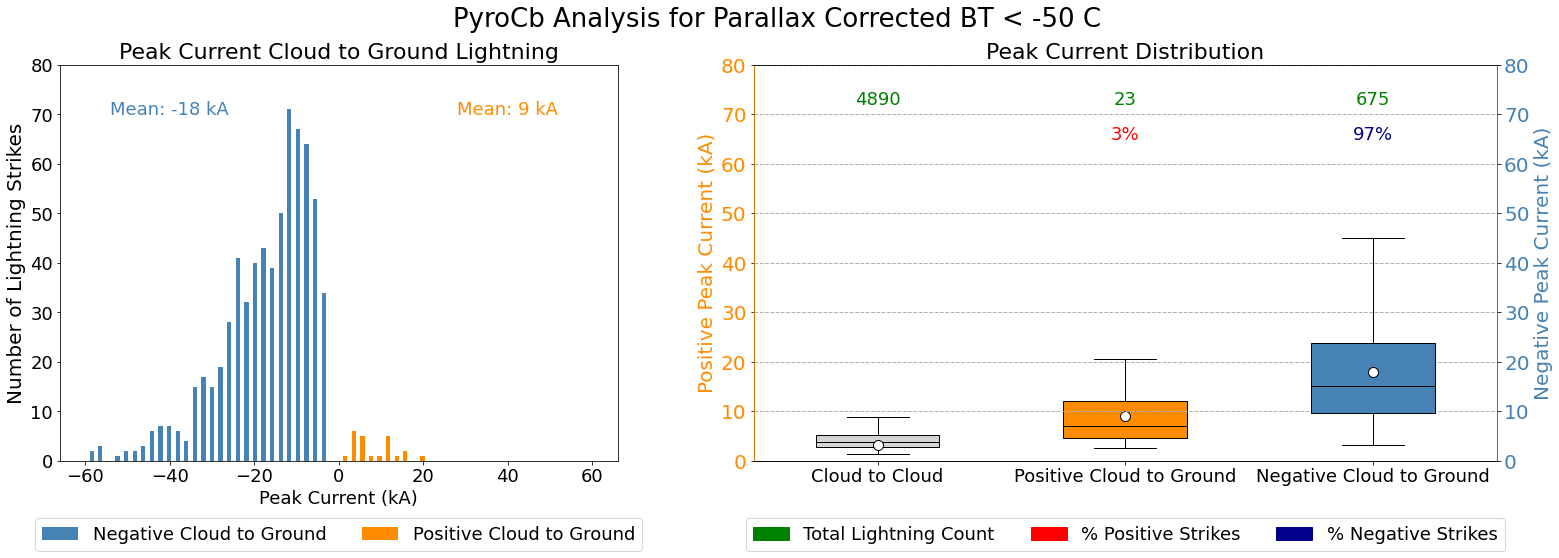

In [106]:
fig = plt.figure(figsize=(22,8))
gs = grd.GridSpec(1, 2, width_ratios=[1.5, 2]) 

ax0 = plt.subplot(gs[0])

colors = ["darkorange", "steelblue"]
bins = np.linspace(-60, 60, 60)
plt.ylim(0, 80)
ax0.hist([pyrocb_pos_ground_flat, pyrocb_neg_ground_flat], bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

plt.title("Peak Current Cloud to Ground Lightning", fontsize = 22)
plt.xlabel("Peak Current (kA)", fontsize = 18)
plt.ylabel("Number of Lightning Strikes", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

handles, labels = plt.gca().get_legend_handles_labels()

order = [1,0]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', 
    bbox_to_anchor=(0.5, -0.25),
    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)

plt.annotate("Mean: {:.0f} kA".format(np.mean(pyrocb_neg_ground_flat)), xy =(-40, 70), fontsize = 18, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(pyrocb_pos_ground_flat)), xy =(40, 70), fontsize = 18, color = "darkorange", ha='center')


ax1 = plt.subplot(gs[1])

ax1.set_title('Peak Current Distribution', fontsize = 22)
ax1.set_ylabel("Positive Peak Current (kA)", color = "darkorange", fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(0, 80)
plt.yticks(fontsize = 20, color = "darkorange")

data = [pyrocb_cloud_flat, pyrocb_pos_ground_flat]

box1 = ax1.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1], widths=(0.5, 0.5))

yticks2 = np.arange(0, 90, 10)
ax2=ax1.twinx()
data2 = [list(map(abs,pyrocb_neg_ground_flat))] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), 
                   positions = [2], widths=(0.5))
ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 80)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('darkorange')

color1 = ['lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Cloud to Cloud",  "Positive Cloud to Ground", "Negative Cloud to Ground"]  
ax1.set_xticklabels(labels, fontsize = 18)

plt.annotate("{:.0f}".format(len(pyrocb_cloud_flat)), xy =(0, 72), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(pyrocb_pos_ground_flat)), xy =(1, 72), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(pyrocb_neg_ground_flat)), xy =(2, 72), fontsize = 18, color = "green", ha='center')

plt.annotate("{:.0f}%".format(np.mean(d1["percent_pos_current_cloud_ground_pyrocb"])), xy =(1, 65), fontsize = 18, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d1["percent_pos_current_cloud_ground_pyrocb"])), xy =(2, 65), fontsize = 18, color = "darkblue", ha='center')

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='% Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='% Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 18,loc='lower center', 
           bbox_to_anchor=(0.5, -0.25),
          ncol=3, fancybox=True, shadow=False)
plt.grid(linestyle='--', linewidth=1) 
plt.suptitle("PyroCb Analysis for Parallax Corrected BT < -50 C", fontsize = 26)

plt.tight_layout()

plt.savefig("pyrocb_histogram_boxplot_parallax.png",bbox_inches = "tight", dpi = 800)
plt.show()


# Early PyroCb

In [125]:
# create empty array to add into 
# path = '/data2/edworak/data/BT_pyrocb_early/' + folder_names_pyrocbearly[i] + '/'
#         FILE = path + file_names_pyrocbearly[i][j]
    
folder_names_unsorted_pyrocbearly = []

path = '/data2/edworak/data/BT_pyrocb_early/'
folder = os.listdir(path)

for f in folder: 
    folder_names_unsorted_pyrocbearly.append(f)
folder_names_pyrocbearly = sorted(folder_names_unsorted_pyrocbearly)

folder_names_pyrocbearly = folder_names_pyrocbearly[:-1]

file_names_unsorted = []

for i in range(len(folder_names_pyrocbearly)): 
    file = os.listdir(path + folder_names_pyrocbearly[i])
    file_names_unsorted.append(file)
file_names_pyrocbearly = sorted(file_names_unsorted)
file_names_pyrocbearly


[['OR_ABI-L2-MCMIPF-M6_G16_s20211810110206_e20211810119526_c20211810120015.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810120206_e20211810129514_c20211810130018.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810140206_e20211810149525_c20211810150017.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810100206_e20211810109525_c20211810110019.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810130206_e20211810139526_c20211810140027.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810150206_e20211810159525_c20211810200018.nc'],
 ['OR_ABI-L2-MCMIPF-M6_G16_s20211810230206_e20211810239520_c20211810240017.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810200206_e20211810209520_c20211810210019.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810240206_e20211810249520_c20211810250020.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810220206_e20211810229514_c20211810230019.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810210206_e20211810219514_c20211810220019.nc',
  'OR_ABI-L2-MCMIPF-M6_G16_s20211810250206_e20211810259514_c20211810300025.nc'],
 ['OR_ABI-L2-MCMIPF-M6_G16_s2021181033

In [126]:
fullpath_cth_pyrocbearly = fullpath_cth[377:419]


In [35]:
"""for i in range(len(fullpath_cth_pyrocbearly)):
    FILE = fullpath_cth_pyrocbearly[i] 
    ds_latlon = calc_latlon(xarray.open_dataset(FILE))

    #select by lat/lon region
    lat_min, lat_max = 51, 53
    lon_min, lon_max = -121.5, -119
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
    
    #select CMI_C14 channel anc convert into celsius
    max_cth = selected_region['maximum_cloud_top_height'][:]
    max_cth.attrs["units"] = "m"
    
    # Convert the xarray dataarray to a pandas dataframe
    df =  max_cth.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    cth_hourly_df_pyrocbearly = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "maximum_cloud_top_height")]
    cth_hourly_df_pyrocbearly.dropna(inplace = True)
    
    if i == 0: 
        cth_df_pyrocbearly = cth_hourly_df_pyrocbearly
    if i > 0: 
        cth_df_pyrocbearly = pd.concat([cth_df_pyrocbearly, cth_hourly_df_pyrocbearly], axis =0)
"""

'for i in range(len(fullpath_cth_pyrocbearly)):\n    FILE = fullpath_cth_pyrocbearly[i] \n    ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n\n    #select by lat/lon region\n    lat_min, lat_max = 51, 53\n    lon_min, lon_max = -121.5, -119\n    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n    \n    #select CMI_C14 channel anc convert into celsius\n    max_cth = selected_region[\'maximum_cloud_top_height\'][:]\n    max_cth.attrs["units"] = "m"\n    \n    # Convert the xarray dataarray to a pandas dataframe\n    df =  max_cth.to_dataframe()\n    scan_start = datetime.strptime(ds_latlon.time_coverage_start, \'%Y-%m-%dT%H:%M:%S.%fZ\')\n    \n    df[\'Date\'] = pd.to_datetime(df[\'t\'])\n    df[\'year\'] = df[\'Date\'].dt.year\n    df[\'month\'] = df[\'Date\'].dt.month\n    df[\'day\'] = df[\'Date\

In [127]:
#cth_df_pyrocbearly.to_csv('/data2/edworak/data/max_cth_pyrocbearly.nc')
df_cth_pyrocbearly = pd.read_csv('/data2/edworak/data/max_cth_pyrocbearly.nc')
df_cth_pyrocbearly = df_cth_pyrocbearly.loc[(df_cth_pyrocbearly.hour == 2) & (df_cth_pyrocbearly.lat >= 52)& (df_cth_pyrocbearly.lon >= -120.7) & (df_cth_pyrocbearly.lon <= -120.3)]
df_cth_pyrocbearly

,y,x,year,month,day,hour,minute,second,lat,lon,maximum_cloud_top_height
3797,0.13090,0.02814,2021,6,30,2,5,5,52.906788,-120.543030,17558.480469
3798,0.13090,0.02842,2021,6,30,2,5,5,52.914760,-120.369510,17558.480469
3811,0.13062,0.02814,2021,6,30,2,5,5,52.707455,-120.629036,17558.480469
3812,0.13062,0.02842,2021,6,30,2,5,5,52.715740,-120.456290,17558.480469
3826,0.13034,0.02842,2021,6,30,2,5,5,52.517666,-120.541695,17558.480469
3827,0.13034,0.02870,2021,6,30,2,5,5,52.525494,-120.369930,17558.480469
3840,0.13006,0.02842,2021,6,30,2,5,5,52.321330,-120.625280,17558.480469
3841,0.13006,0.02870,2021,6,30,2,5,5,52.328570,-120.454810,17558.480469
3855,0.12978,0.02870,2021,6,30,2,5,5,52.133910,-120.537550,17558.480469
3856,0.12978,0.02898,2021,6,30,2,5,5,52.141440,-120.367560,17558.480469


# Smoke

## data

### smoke brightness temp

In [132]:
folder_names_unsorted_smoke = []
path = '/data2/edworak/data/BT_smoke/'
folder = os.listdir(path)

for f in folder: 
    folder_names_unsorted_smoke.append(f)
folder_names_smoke = sorted(folder_names_unsorted_smoke)
folder_names_smoke = folder_names_smoke[:-2]

file_names_unsorted_smoke = []

for i in range(len(folder_names_smoke)): 
    file = os.listdir(path + folder_names_smoke[i])
    file_names_unsorted_smoke.append(file)
file_names_smoke = sorted(file_names_unsorted_smoke)


In [38]:
bt_df_smoke = pd.read_csv('/data2/edworak/data/bt_df_smoke.nc')
bt_df_smoke

,y,x,year,month,day,hour,minute,second,lat,lon,CMI_C14
0,0.138292,-0.049420,2021,6,29,8,35,6,60.498413,-114.041220,9.714508
1,0.138236,-0.049868,2021,6,29,8,35,6,60.494350,-114.475586,2.891510
2,0.138236,-0.049812,2021,6,29,8,35,6,60.487100,-114.408640,3.549866
3,0.138236,-0.049756,2021,6,29,8,35,6,60.479897,-114.341850,6.542389
4,0.138236,-0.049700,2021,6,29,8,35,6,60.473190,-114.276140,8.756866
...,...,...,...,...,...,...,...,...,...,...,...
76396,0.134372,-0.061460,2021,6,29,11,35,6,58.036472,-121.988740,16.657196
76397,0.134372,-0.061404,2021,6,29,11,35,6,58.028057,-121.912620,16.717010
76398,0.134372,-0.061348,2021,6,29,11,35,6,58.019157,-121.835510,16.717010
76399,0.134372,-0.061292,2021,6,29,11,35,6,58.010006,-121.757970,16.836731


### smoke lightning data

In [39]:
data_smoke = data_split2.loc[(data_split2["day"] == 29) & (data_split2["hour"] >= 8) & (data_split2["hour"] <= 11) & (data_split2.lon >= -120) & (data_split2.lon <= -114) & (data_split2.lat >= 58) & (data_split2.lat <= 60.5)]
data_smoke
df3 = data_smoke.drop_duplicates(subset=['day', 'hour', 'minute', 'lat', 'lon', 'peak-current',
                   'C or G', 'polarity'], keep='first') 
df3

#43532 rows × 13 columns

,year,month,day,hour,minute,second,lat,lon,peak-current,C or G,multi,polarity,range
201341,2021,6,29,8,0,00,58.611,-118.750,-12.5,G,0,-,11790.05
201344,2021,6,29,8,0,01,58.533,-118.816,2.8,C,0,+,11794.09
201346,2021,6,29,8,0,02,58.409,-118.127,5.4,C,0,+,11800.50
201347,2021,6,29,8,0,02,58.565,-119.037,5.2,C,0,+,11792.42
201348,2021,6,29,8,0,02,58.496,-119.290,8.9,C,0,+,11796.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249216,2021,6,29,11,59,59,59.360,-119.068,4.5,C,0,+,11750.98
249217,2021,6,29,11,59,59,59.225,-118.316,10.8,C,0,+,11758.03
249218,2021,6,29,11,59,59,59.216,-118.303,7.4,C,0,+,11758.47
249219,2021,6,29,11,59,59,59.352,-119.025,14.2,C,0,+,11751.38


### smoke cloud top height
- june 19 : 180
- only has hours 8 - 11, no hour 12
- can't find hour 12 online either 

In [40]:
fullpath_cth_smoke = fullpath_cth[336:360]
fullpath_cth_smoke

['/data2/edworak/data/cloud_top_height/202118008/OR_ABI-L2-ACHAF-M6_G17_s20211800800320_e20211800809387_c20211800810463.nc',
 '/data2/edworak/data/cloud_top_height/202118008/OR_ABI-L2-ACHAF-M6_G17_s20211800810320_e20211800819387_c20211800820436.nc',
 '/data2/edworak/data/cloud_top_height/202118008/OR_ABI-L2-ACHAF-M6_G17_s20211800820320_e20211800829387_c20211800830340.nc',
 '/data2/edworak/data/cloud_top_height/202118008/OR_ABI-L2-ACHAF-M6_G17_s20211800830320_e20211800839387_c20211800840428.nc',
 '/data2/edworak/data/cloud_top_height/202118008/OR_ABI-L2-ACHAF-M6_G17_s20211800840320_e20211800849387_c20211800850430.nc',
 '/data2/edworak/data/cloud_top_height/202118008/OR_ABI-L2-ACHAF-M6_G17_s20211800850320_e20211800859387_c20211800900335.nc',
 '/data2/edworak/data/cloud_top_height/202118009/OR_ABI-L2-ACHAF-M6_G17_s20211800900320_e20211800909387_c20211800910432.nc',
 '/data2/edworak/data/cloud_top_height/202118009/OR_ABI-L2-ACHAF-M6_G17_s20211800910322_e20211800919389_c20211800920461.nc',


In [41]:
for i in range(len(fullpath_cth_smoke)):
    FILE = fullpath_cth_smoke[i] 
    ds_latlon = calc_latlon(xarray.open_dataset(FILE))

    #select by lat/lon region
    lat_min, lat_max = 57.5, 61
    lon_min, lon_max = -122.0, -113.5
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
    
    #select CMI_C14 channel anc convert into celsius
    max_cth = selected_region['maximum_cloud_top_height'][:]
    max_cth.attrs["units"] = "m"

#     mean_cth = selected_region['mean_cloud_top_height'][:]
#     mean_cth.attrs["units"] = "m"
    
    # Convert the xarray dataarray to a pandas dataframe
    df =  max_cth.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    cth_hourly_df_smoke = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", 'maximum_cloud_top_height')]
    cth_hourly_df_smoke.dropna(inplace = True)
    
    if i == 0: 
        cth_df_smoke = cth_hourly_df_smoke
    if i > 0: 
        cth_df_smoke = pd.concat([cth_df_smoke, cth_hourly_df_smoke], axis =0)


/tmp/ipykernel_186833/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_186833/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_186833/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_186833/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_186833/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_186833/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_186833/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_186833/1595082102.py:20: RuntimeWarning: invalid value

In [42]:
#cth_df_smoke.to_csv('/data2/edworak/data/max_cth_smoke.nc')
df_cth_smoke = pd.read_csv('/data2/edworak/data/max_cth_smoke.nc')#, usecols = [3, 4, 5, 6, 7, 9, 10, 11, 22]
df_cth_smoke = df_cth_smoke.loc[(df_cth_smoke.hour == 10) & (df_cth_smoke.lon >= -119.5) & (df_cth_smoke.lon <= -118.9)
                               & (df_cth_smoke.lat >= 58.9) & (df_cth_smoke.lat <= 59.3)]
df_cth_smoke

,y,x,year,month,day,hour,minute,second,lat,lon,maximum_cloud_top_height
6853,0.13874,0.02506,2021,6,29,10,5,5,59.117584,-119.48114,17443.619141
6854,0.13874,0.02534,2021,6,29,10,5,5,59.129208,-119.27043,17443.619141
6855,0.13874,0.02562,2021,6,29,10,5,5,59.140137,-119.05979,17443.619141
7403,0.13874,0.02506,2021,6,29,10,15,5,59.117584,-119.48114,17377.222656
7404,0.13874,0.02534,2021,6,29,10,15,5,59.129208,-119.27043,17377.222656
7405,0.13874,0.02562,2021,6,29,10,15,5,59.140137,-119.05979,17377.222656
7953,0.13874,0.02506,2021,6,29,10,25,5,59.117584,-119.48114,17226.253906
7954,0.13874,0.02534,2021,6,29,10,25,5,59.129208,-119.27043,17226.253906
7955,0.13874,0.02562,2021,6,29,10,25,5,59.140137,-119.05979,17226.253906
8503,0.13874,0.02506,2021,6,29,10,35,5,59.117584,-119.48114,17317.031250


### Parallax

In [43]:
parallax = xarray.open_dataset("/data2/edworak/data/cloud_top_height/geostationary_parallax.nc")
# df = parallax.to_dataframe()
parallax_testing = pd.read_csv("/data2/edworak/data/parallax_testing.nc")
parallax_testing.longitude = parallax_testing.longitude - 137
parallax_smoke = parallax_testing.loc[(parallax_testing.latitude >= 58) & (parallax_testing.latitude <= 60.5) & (parallax_testing.longitude >= -122) & (parallax_testing.longitude <= -114)]
parallax_smoke
parallax_smoke = parallax_testing.loc[(parallax_testing.latitude >= 55) & (parallax_testing.latitude <= 56) & (parallax_testing.longitude >= -115) & (parallax_testing.longitude <= -114)]
parallax_smoke


,latitude,longitude,parallax_longitude,parallax_latitude,parallax_ratio
86604,55.0,-115.0,0.000016,0.000018,2.229521
86605,55.0,-114.5,0.000016,0.000018,2.243971
86606,55.0,-114.0,0.000016,0.000018,2.258865
86924,55.5,-115.0,0.000016,0.000018,2.280718
86925,55.5,-114.5,0.000016,0.000018,2.295452
86926,55.5,-114.0,0.000017,0.000018,2.310640
87244,56.0,-115.0,0.000016,0.000019,2.333925
87245,56.0,-114.5,0.000017,0.000019,2.348958
87246,56.0,-114.0,0.000017,0.000019,2.364456


## calculate

### combine bt & cth 

In [44]:
br_temp_smoke = pd.read_csv('/data2/edworak/data/bt_df_smoke.nc', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])
df_cth_smoke = pd.read_csv('/data2/edworak/data/max_cth_smoke.nc')
br_temp_smoke

,year,month,day,hour,minute,lat,lon,CMI_C14
0,2021,6,29,8,35,60.498413,-114.041220,9.714508
1,2021,6,29,8,35,60.494350,-114.475586,2.891510
2,2021,6,29,8,35,60.487100,-114.408640,3.549866
3,2021,6,29,8,35,60.479897,-114.341850,6.542389
4,2021,6,29,8,35,60.473190,-114.276140,8.756866
...,...,...,...,...,...,...,...,...
76396,2021,6,29,11,35,58.036472,-121.988740,16.657196
76397,2021,6,29,11,35,58.028057,-121.912620,16.717010
76398,2021,6,29,11,35,58.019157,-121.835510,16.717010
76399,2021,6,29,11,35,58.010006,-121.757970,16.836731


In [45]:
"""%%time

br_temp_smoke = pd.read_csv('/data2/edworak/data/bt_df_smoke.nc', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])
df_cth_smoke = pd.read_csv('/data2/edworak/data/max_cth_smoke.nc')

cth_bt_smoke = []

# get it all into one 
# then limit it by time 
hours = [8, 9, 10, 11, 12]
mins = range(5, 56, 10)

def find_nearest_max(lat, long):
    distances = cth_smoke_time.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
    return cth_smoke_time.loc[distances.idxmin(), 'maximum_cloud_top_height']

for i in range(len(hours)): 
    for j in range(len(mins)): 
        print(i)
        cth_smoke_time = df_cth_smoke.loc[(df_cth_smoke.hour == hours[i]) & (df_cth_smoke.minute == mins[j])] #  & (df_cth_smoke.minute <= mins[j] + 9)
        br_temp_smoke_time = br_temp_smoke.loc[(br_temp_smoke.hour == hours[i])& (br_temp_smoke.minute >= mins[j]) & (br_temp_smoke.minute <= mins[j] + 9)] 
        
        if (len(cth_smoke_time) >0) & (len(br_temp_smoke_time) >0): 
            
            br_temp_smoke_time['maximum_cloud_top_height'] = br_temp_smoke_time.apply(
                lambda row: find_nearest_max(row['lat'], row['lon']), axis=1)

            br_temp_smoke_time = pd.merge(br_temp_smoke_time, cth_smoke_time[['maximum_cloud_top_height', 'lat','lon']],on='maximum_cloud_top_height', how='left')


            # Rename the new columns as both the columns has same name, and python gets confused 
            br_temp_smoke_time = br_temp_smoke_time.rename(columns = {'lat_x':'bt_lat','lon_x':'bt_lon',
                                                                  'lat_y':'cth_lat','lon_y':'cth_lon'})

            br_temp_smoke_time['distance(km)'] = [dist(br_temp_smoke_time.bt_lon[i],br_temp_smoke_time.bt_lat[i],
                                                 br_temp_smoke_time.cth_lon[i], br_temp_smoke_time.cth_lat[i]) 
                                                 for i in range(len(br_temp_smoke_time))]
            br_temp_smoke_time['distance(km)'] = br_temp_smoke_time['distance(km)'].round(decimals=5)
           # br_temp_smoke_time = br_temp_smoke_time.loc[br_temp_smoke_time["distance(km)"] < 10]

            if len(cth_bt_smoke) == 0: 
                cth_bt_smoke = br_temp_smoke_time
            else: 
                cth_bt_smoke = pd.concat([cth_bt_smoke, br_temp_smoke_time], axis =0)
            cth_bt_smoke
            
         """

'%%time\n\nbr_temp_smoke = pd.read_csv(\'/data2/edworak/data/bt_df_smoke.nc\', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])\ndf_cth_smoke = pd.read_csv(\'/data2/edworak/data/max_cth_smoke.nc\')\n\ncth_bt_smoke = []\n\n# get it all into one \n# then limit it by time \nhours = [8, 9, 10, 11, 12]\nmins = range(5, 56, 10)\n\ndef find_nearest_max(lat, long):\n    distances = cth_smoke_time.apply(lambda row: dist(lat, long, row[\'lat\'], row[\'lon\']), axis=1)\n    return cth_smoke_time.loc[distances.idxmin(), \'maximum_cloud_top_height\']\n\nfor i in range(len(hours)): \n    for j in range(len(mins)): \n        print(i)\n        cth_smoke_time = df_cth_smoke.loc[(df_cth_smoke.hour == hours[i]) & (df_cth_smoke.minute == mins[j])] #  & (df_cth_smoke.minute <= mins[j] + 9)\n        br_temp_smoke_time = br_temp_smoke.loc[(br_temp_smoke.hour == hours[i])& (br_temp_smoke.minute >= mins[j]) & (br_temp_smoke.minute <= mins[j] + 9)] \n        \n        if (len(cth_

In [46]:
# cth_bt_smoke.to_csv("/data2/edworak/data/cth_bt_smoke.nc")
# cth_bt_smoke = pd.read_csv("/data2/edworak/data/cth_bt_smoke.nc")
# cth_bt_smoke

# df = cth_bt_smoke.sort_values('distance(km)', ascending=True)

# df = df.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'minute', 
#                                             "bt_lat", "bt_lon", "CMI_C14"], keep='first')
 
# df = df.sort_index()
#df.to_csv("/data2/edworak/data/cth_bt_smoke.nc")
cth_bt_smoke = pd.read_csv("/data2/edworak/data/cth_bt_smoke.nc", usecols = ['year', 'month', 'day', 'hour', 'minute',
       'bt_lat', 'bt_lon', 'CMI_C14', 'maximum_cloud_top_height', 'cth_lat',
       'cth_lon', 'distance(km)'])
cth_bt_smoke

#BT: 76401 rows × 8 columns

,year,month,day,hour,minute,bt_lat,bt_lon,CMI_C14,maximum_cloud_top_height,cth_lat,cth_lon,distance(km)
0,2021,6,29,8,35,60.498413,-114.041220,9.714508,17410.015625,60.487690,-114.071144,3.36271
1,2021,6,29,8,35,60.494350,-114.475586,2.891510,17410.015625,60.453945,-114.541930,7.60891
2,2021,6,29,8,35,60.487100,-114.408640,3.549866,17410.015625,60.470950,-114.306760,11.35272
3,2021,6,29,8,35,60.479897,-114.341850,6.542389,17410.015625,60.470950,-114.306760,3.92329
4,2021,6,29,8,35,60.473190,-114.276140,8.756866,17410.015625,60.470950,-114.306760,3.40633
...,...,...,...,...,...,...,...,...,...,...,...,...
76396,2021,6,29,11,35,58.036472,-121.988740,16.657196,17322.636719,58.255980,-121.927895,14.58363
76397,2021,6,29,11,35,58.028057,-121.912620,16.717010,17322.636719,58.019768,-121.845440,7.48592
76398,2021,6,29,11,35,58.019157,-121.835510,16.717010,17322.636719,58.019768,-121.845440,1.10475
76399,2021,6,29,11,35,58.010006,-121.757970,16.836731,17322.636719,58.019768,-121.845440,9.74303


## combine bt, cth, parallax 

In [47]:
"""%%time

#cth_bt_plx_smoke = []

def find_nearest_lon(lat, long):
    distances = parallax_smoke.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_smoke.loc[distances.idxmin(), "parallax_longitude"]

def find_nearest_lat(lat, long):
    distances = parallax_smoke.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_smoke.loc[distances.idxmin(),"parallax_latitude"]


cth_bt_smoke["parallax_longitude"] = cth_bt_smoke.apply(lambda row: find_nearest_lon(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_smoke["parallax_latitude"] = cth_bt_smoke.apply(lambda row: find_nearest_lat(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_smoke = pd.merge(cth_bt_smoke, parallax_smoke[["parallax_longitude", "parallax_latitude", 'latitude','longitude']],on=["parallax_longitude", "parallax_latitude"], how='left')
print(cth_bt_smoke)
cth_bt_smoke['distance_plx'] = [dist(cth_bt_smoke.bt_lon[i],cth_bt_smoke.bt_lat[i],
                                     cth_bt_smoke.longitude_x[i],cth_bt_smoke.latitude_x[i]) 
                                     for i in range(len(cth_bt_smoke))]
cth_bt_smoke['distance_plx'] = cth_bt_smoke['distance_plx'].round(decimals=3)

cth_bt_smoke"""

'%%time\n\n#cth_bt_plx_smoke = []\n\ndef find_nearest_lon(lat, long):\n    distances = parallax_smoke.apply(lambda row: dist(lat, long, row[\'latitude\'], row[\'longitude\']), axis=1)\n    return parallax_smoke.loc[distances.idxmin(), "parallax_longitude"]\n\ndef find_nearest_lat(lat, long):\n    distances = parallax_smoke.apply(lambda row: dist(lat, long, row[\'latitude\'], row[\'longitude\']), axis=1)\n    return parallax_smoke.loc[distances.idxmin(),"parallax_latitude"]\n\n\ncth_bt_smoke["parallax_longitude"] = cth_bt_smoke.apply(lambda row: find_nearest_lon(row[\'bt_lat\'], row[\'bt_lon\']), axis=1)\ncth_bt_smoke["parallax_latitude"] = cth_bt_smoke.apply(lambda row: find_nearest_lat(row[\'bt_lat\'], row[\'bt_lon\']), axis=1)\ncth_bt_smoke = pd.merge(cth_bt_smoke, parallax_smoke[["parallax_longitude", "parallax_latitude", \'latitude\',\'longitude\']],on=["parallax_longitude", "parallax_latitude"], how=\'left\')\nprint(cth_bt_smoke)\ncth_bt_smoke[\'distance_plx\'] = [dist(cth_bt_smok

In [48]:
"""cth_bt_smoke.columns
df2 = cth_bt_smoke[['year', 'month', 'day', 'hour', 'minute', 'bt_lat', 'bt_lon', 'CMI_C14',
       'maximum_cloud_top_height', 'cth_lat', 'cth_lon', 'distance(km)',
       'parallax_longitude', 'parallax_latitude', 'latitude_x', 'longitude_x', 'distance_plx']].copy()

cth_bt_plx_smoke = df2.sort_values('distance_plx', ascending=True)
cth_bt_plx_smoke

#df3 = df2.loc[(df2["distance_plx"] <= 10 )]

# cth_bt_plx_pyrocb = df2.drop_duplicates(keep='first')
# cth_bt_plx_pyrocb"""


'cth_bt_smoke.columns\ndf2 = cth_bt_smoke[[\'year\', \'month\', \'day\', \'hour\', \'minute\', \'bt_lat\', \'bt_lon\', \'CMI_C14\',\n       \'maximum_cloud_top_height\', \'cth_lat\', \'cth_lon\', \'distance(km)\',\n       \'parallax_longitude\', \'parallax_latitude\', \'latitude_x\', \'longitude_x\', \'distance_plx\']].copy()\n\ncth_bt_plx_smoke = df2.sort_values(\'distance_plx\', ascending=True)\ncth_bt_plx_smoke\n\n#df3 = df2.loc[(df2["distance_plx"] <= 10 )]\n\n# cth_bt_plx_pyrocb = df2.drop_duplicates(keep=\'first\')\n# cth_bt_plx_pyrocb'

## Fix BT location

In [49]:
"""cth_bt_plx_smoke["tlat"] = cth_bt_plx_smoke.bt_lat - cth_bt_plx_smoke.parallax_latitude * cth_bt_plx_smoke.maximum_cloud_top_height
cth_bt_plx_smoke["tlon"] = cth_bt_plx_smoke.bt_lon - cth_bt_plx_smoke.parallax_longitude * cth_bt_plx_smoke.maximum_cloud_top_height

correct_bt_smoke = cth_bt_plx_smoke[['year', 'month', 'day', 'hour', 'minute',  "tlat", "tlon", 'CMI_C14']]
correct_bt_smoke

"""

'cth_bt_plx_smoke["tlat"] = cth_bt_plx_smoke.bt_lat - cth_bt_plx_smoke.parallax_latitude * cth_bt_plx_smoke.maximum_cloud_top_height\ncth_bt_plx_smoke["tlon"] = cth_bt_plx_smoke.bt_lon - cth_bt_plx_smoke.parallax_longitude * cth_bt_plx_smoke.maximum_cloud_top_height\n\ncorrect_bt_smoke = cth_bt_plx_smoke[[\'year\', \'month\', \'day\', \'hour\', \'minute\',  "tlat", "tlon", \'CMI_C14\']]\ncorrect_bt_smoke\n\n'

## add lightning

In [50]:
"""# lightning_smoke
# correct_bt_smoke


lightning_df_smoke = []
# get it all into one 
# then limit it by time 
hours = [8, 9, 10, 11, 12]
mins = range(0, 60, 5)

def find_nearest_smoke(lat, long):
    distances = correct_bt_smoke_time.apply(lambda row: dist(lat, long, row['tlat'], row['tlon']), axis=1)
    return correct_bt_smoke_time.loc[distances.idxmin(), "CMI_C14"]

for i in range(len(hours)): 
    print(i)
    for j in range(len(mins)): 
        data_smoke_time = data_smoke.loc[(data_smoke.hour == hours[i]) & (data_smoke.minute >= mins[j]) & (data_smoke.minute <= mins[j] + 9)]
        correct_bt_smoke_time = correct_bt_smoke.loc[(correct_bt_smoke.hour == hours[i])& (correct_bt_smoke.minute >= mins[j]) & (correct_bt_smoke.minute <= mins[j] + 9)] 
        
        if (len(data_smoke_time) >0) & (len(correct_bt_smoke_time) >0): 
            
            data_smoke_time['CMI_C14'] = data_smoke_time.apply(
                lambda row: find_nearest_smoke(row['lat'], row['lon']), axis=1)

            data_smoke_time = pd.merge(data_smoke_time, correct_bt_smoke_time[['CMI_C14','tlat','tlon']],on='CMI_C14', how='left')


            # Rename the new columns as both the columns has same name, and python gets confused 
            data_smoke_time = data_smoke_time.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                                  'lat_y':'tlat','lon_y':'tlon'})

            data_smoke_time['distance(km)'] = [dist(data_smoke_time.lon[i],data_smoke_time.lat[i],
                                                 data_smoke_time.tlon[i],data_smoke_time.tlat[i]) 
                                                 for i in range(len(data_smoke_time))]
            data_smoke_time['distance(km)'] = data_smoke_time['distance(km)'].round(decimals=3)
            # data_smoke_close = data_smoke_time.loc[data_smoke_time["distance(km)"] < 10]

            if len(lightning_df_smoke) == 0: 
                lightning_df_smoke = data_smoke_time
            else: 
                lightning_df_smoke = pd.concat([lightning_df_smoke, data_smoke_time], axis =0)
            lightning_df_smoke
"""

'# lightning_smoke\n# correct_bt_smoke\n\n\nlightning_df_smoke = []\n# get it all into one \n# then limit it by time \nhours = [8, 9, 10, 11, 12]\nmins = range(0, 60, 5)\n\ndef find_nearest_smoke(lat, long):\n    distances = correct_bt_smoke_time.apply(lambda row: dist(lat, long, row[\'tlat\'], row[\'tlon\']), axis=1)\n    return correct_bt_smoke_time.loc[distances.idxmin(), "CMI_C14"]\n\nfor i in range(len(hours)): \n    print(i)\n    for j in range(len(mins)): \n        data_smoke_time = data_smoke.loc[(data_smoke.hour == hours[i]) & (data_smoke.minute >= mins[j]) & (data_smoke.minute <= mins[j] + 9)]\n        correct_bt_smoke_time = correct_bt_smoke.loc[(correct_bt_smoke.hour == hours[i])& (correct_bt_smoke.minute >= mins[j]) & (correct_bt_smoke.minute <= mins[j] + 9)] \n        \n        if (len(data_smoke_time) >0) & (len(correct_bt_smoke_time) >0): \n            \n            data_smoke_time[\'CMI_C14\'] = data_smoke_time.apply(\n                lambda row: find_nearest_smoke(row

## statistics

### load in 

In [51]:
# lightning_df_smoke.to_csv("/data2/edworak/data/smoke_plxcorrected_bt_lightning.nc")

In [107]:
correct_smoke = pd.read_csv("/data2/edworak/data/smoke_plxcorrected_bt_lightning.nc", usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17])
correct_smoke = correct_smoke.sort_values('distance(km)', ascending=True)
correct_smoke = correct_smoke.drop_duplicates(subset=['day', 'hour', 'minute', 'lat', 'lon', 'peak-current',
                   'C or G', 'polarity', "CMI_C14"], keep='first') 
#correct_smoke = correct_smoke.drop_duplicates(keep='first') 

correct_smoke = correct_smoke.sort_index()
correct_smoke

#43532 rows × 13 columns



,year,month,day,hour,minute,lat,lon,peak-current,C or G,polarity,CMI_C14,tlat,tlon,distance(km)
4,2021,6,29,8,30,58.627,-118.194,9.2,G,+,-53.428040,58.627953,-118.199786,0.645
45,2021,6,29,8,30,58.579,-118.444,4.4,C,+,-53.727295,58.564999,-118.485836,4.711
61,2021,6,29,8,30,58.614,-118.481,4.9,C,+,-53.906860,58.608120,-118.447966,3.686
75,2021,6,29,8,30,58.549,-118.341,5.8,C,+,-52.829530,58.549244,-118.345186,0.466
109,2021,6,29,8,30,58.535,-118.365,3.3,C,+,-52.829530,58.549244,-118.345186,2.328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327654,2021,6,29,11,44,58.876,-117.757,-52.5,G,-,-53.188644,58.866059,-117.770269,1.563
1327687,2021,6,29,11,44,58.876,-117.757,-8.7,G,-,-53.188644,58.866059,-117.770269,1.563
1327720,2021,6,29,11,44,58.877,-117.754,-19.7,G,-,-53.188644,58.866059,-117.770269,1.896
1327750,2021,6,29,11,44,58.374,-115.321,7.0,C,+,-54.325806,58.365315,-115.337302,1.859


In [108]:
# correct_smoke = pd.read_csv("/data2/edworak/data/smoke_lightning_bt.csv", sep='\t')

hours1 = [8, 9, 10, 11]
mins1 = range(0, 60, 10)

num_strikes_smoke = np.zeros((len(hours1), len(mins1)))
mean_current_smoke = np.zeros((len(hours1), len(mins1)))
mean_pos_current_smoke = np.zeros((len(hours1), len(mins1)))
mean_neg_current_smoke = np.zeros((len(hours1), len(mins1)))
percent_pos_current_smoke = np.zeros((len(hours1), len(mins1)))
num_pos_current_smoke =  np.zeros((len(hours1), len(mins1)))
num_neg_current_smoke =  np.zeros((len(hours1), len(mins1)))
cloud_smoke =  np.zeros((len(hours1), len(mins1)))
cloud_ground_smoke =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_smoke =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_smoke =  np.zeros((len(hours1), len(mins1)))
pos_cloud_smoke =  np.zeros((len(hours1), len(mins1)))
neg_cloud_smoke =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_smoke =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_smoke =  np.zeros((len(hours1), len(mins1)))
percent_cloud_smoke =  np.zeros((len(hours1), len(mins1)))

def smoke_function(correct_smoke):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                
                    time = correct_smoke.loc[(correct_smoke.CMI_C14 <= -50) & (correct_smoke.hour == hours1[i]) & (correct_smoke.minute >= mins1[j]) & (correct_smoke.minute <= mins1[j] + 9)]
                
                    
                    strikes_smoke = (time.loc[(time["lon"] >= -120)& (time["lon"] <= -114) & 
                                                (time["lat"] >= 58) & (time["lat"] <= 60.5)])
                    

                    if len(strikes_smoke) >= 1: 
                    
                        num_strikes_smoke[i,j] = len(strikes_smoke)
                        mean_current_smoke[i,j] = np.mean(abs(strikes_smoke["peak-current"]))

                        pos_current_smoke = strikes_smoke.loc[(strikes_smoke["peak-current"] > 0)]
                        num_pos_current_smoke[i,j]= len(pos_current_smoke)
                        mean_pos_current_smoke[i,j] = np.mean(pos_current_smoke["peak-current"])

                        neg_current_smoke = strikes_smoke.loc[(strikes_smoke["peak-current"] < 0)]
                        num_neg_current_smoke[i,j] = len(neg_current_smoke)
                        mean_neg_current_smoke[i,j] = np.mean(neg_current_smoke["peak-current"])
                        
                        cloud_count_smoke = strikes_smoke.loc[(strikes_smoke["C or G"] == "C")]
                        cloud_smoke[i,j] = len(cloud_count_smoke)
                        pos_cloud_count_smoke = cloud_count_smoke.loc[(cloud_count_smoke["peak-current"] > 0)]
                        pos_cloud_smoke[i,j] = len(pos_cloud_count_smoke)
                        neg_cloud_count_smoke = cloud_count_smoke.loc[(cloud_count_smoke["peak-current"] < 0)]
                        neg_cloud_smoke[i,j] = len(neg_cloud_count_smoke)
                        
                        ground_count_smoke = strikes_smoke.loc[(strikes_smoke["C or G"] == "G")]
                        cloud_ground_smoke[i, j] = len(ground_count_smoke)
                        pos_cloud_ground_count_smoke = ground_count_smoke.loc[(ground_count_smoke["peak-current"] > 0)]
                        pos_cloud_ground_smoke[i,j] = len(pos_cloud_ground_count_smoke)
                        neg_cloud_ground_count_smoke= ground_count_smoke.loc[(ground_count_smoke["peak-current"] < 0)]
                        neg_cloud_ground_smoke[i,j] = len(neg_cloud_ground_count_smoke)
                        
                        if len(strikes_smoke) > 2: 
                            percent_pos_current_smoke[i,j] = (len(pos_current_smoke["peak-current"]) / len(strikes_smoke)) * 100
                        
                        if len(cloud_count_smoke) > 2:    
                            percent_pos_current_cloud_smoke[i,j] = (len(pos_cloud_count_smoke["peak-current"]) / len(cloud_count_smoke)) * 100
                            percent_cloud_smoke[i,j] = (len(cloud_count_smoke["peak-current"]) / len(strikes_smoke)) * 100

                        if len(ground_count_smoke) > 2:  
                            percent_pos_current_cloud_ground_smoke[i,j] = (len(pos_cloud_ground_count_smoke["peak-current"]) / len(ground_count_smoke)) * 100

        return(num_strikes_smoke, percent_pos_current_smoke, num_pos_current_smoke, num_neg_current_smoke, 
            mean_current_smoke, mean_pos_current_smoke, mean_neg_current_smoke, cloud_smoke, 
            cloud_ground_smoke, pos_cloud_smoke,  neg_cloud_smoke, pos_cloud_ground_smoke,  neg_cloud_ground_smoke, 
             percent_pos_current_cloud_smoke, percent_pos_current_cloud_ground_smoke, percent_cloud_smoke)


In [109]:
d2 = {}

names2 = ["num_strikes_smoke", "percent_pos_current_smoke", "num_pos_current_smoke", "num_neg_current_smoke", 
           "mean_current_smoke", "mean_pos_current_smoke", "mean_neg_current_smoke", "cloud_smoke",
         "cloud_ground_smoke", "pos_cloud_smoke",  "neg_cloud_smoke", "pos_cloud_ground_smoke",  "neg_cloud_ground_smoke", 
        "percent_pos_current_cloud_smoke", "percent_pos_current_cloud_ground_smoke", "percent_cloud_smoke"]


for i in range(0, len(names1)):
    a2 = smoke_function(correct_smoke)[i]
    b2 = [item for sublist in a2 for item in sublist]
    d2[names2[i]] = b2

print(np.mean(d2["percent_pos_current_smoke"]))   

print(np.mean(d2["percent_pos_current_cloud_ground_smoke"]))   
#d1["num_strikes_smoke"]

41.96166904588684
5.733274628979458


In [111]:
hours2 = [8, 9, 10, 11]
mins2 = range(0, 60, 10)

smoke_cloud_array = []
smoke_ground_array = []
smoke_cccg_array = []
smoke_neg_cloud_array = []
smoke_pos_cloud_array = []
smoke_neg_ground_array = []
smoke_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = correct_smoke.loc[(correct_smoke.CMI_C14 <= -50) & (correct_smoke.hour == hours1[i]) & (correct_smoke.minute >= mins1[j]) & (correct_smoke.minute <= mins1[j] + 9)]
                
                    
        strikes_smoke = (time.loc[(time["lon"] >= -120)& (time["lon"] <= -114) & 
                                    (time["lat"] >= 58) & (time["lat"] <= 60.5)])
        
        if len(strikes_smoke) >= 1: 
            smoke_cloud_array.append(np.array(strikes_smoke[(strikes_smoke["C or G"] == "C")]["peak-current"]))
            smoke_ground_array.append(np.array(strikes_smoke[(strikes_smoke["C or G"] == "G")]["peak-current"]))
            
            if len(strikes_smoke[(strikes_smoke["C or G"] == "G")]) >= 1:
                smoke_cccg_array.append(np.array(len(strikes_smoke[(strikes_smoke["C or G"] == "C")]) / len(strikes_smoke[(strikes_smoke["C or G"] == "G")])))

            smoke_pos_cloud_array.append(np.array(strikes_smoke[(strikes_smoke["peak-current"] > 0) & (strikes_smoke["C or G"] == "C")]["peak-current"]))
            smoke_neg_cloud_array.append(np.array(strikes_smoke[(strikes_smoke["peak-current"] < 0) & (strikes_smoke["C or G"] == "C")]["peak-current"]))
            
            smoke_pos_ground_array.append(np.array(strikes_smoke[(strikes_smoke["peak-current"] > 0) & (strikes_smoke["C or G"] == "G")]["peak-current"]))
            smoke_neg_ground_array.append(np.array(strikes_smoke[(strikes_smoke["peak-current"] < 0) & (strikes_smoke["C or G"] == "G")]["peak-current"]))

smoke_cloud_flat = [item for sublist in smoke_cloud_array for item in sublist]
smoke_ground_flat = [item for sublist in smoke_ground_array for item in sublist]
smoke_neg_cloud_flat = [item for sublist in smoke_neg_cloud_array for item in sublist]
smoke_pos_cloud_flat = [item for sublist in smoke_pos_cloud_array for item in sublist]
smoke_neg_ground_flat = [item for sublist in smoke_neg_ground_array for item in sublist]
smoke_pos_ground_flat = [item for sublist in smoke_pos_ground_array for item in sublist]


### images

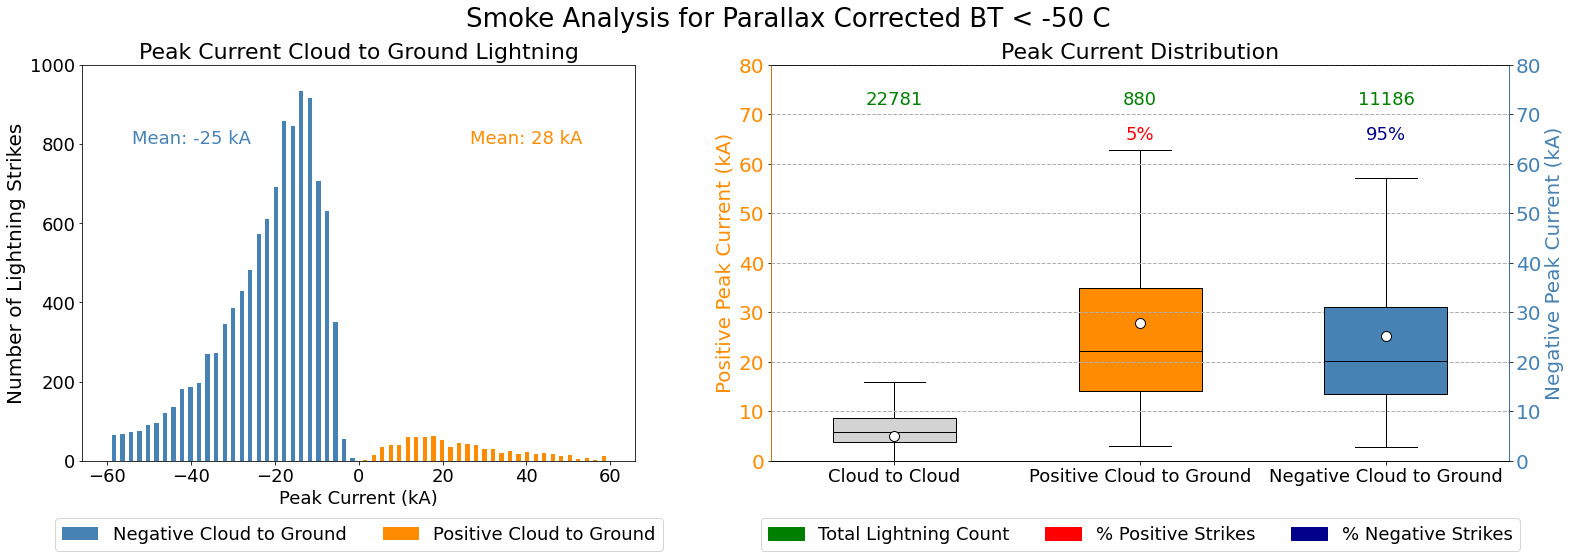

In [56]:
fig = plt.figure(figsize=(22,8))
gs = grd.GridSpec(1, 2, width_ratios=[1.5, 2]) 

ax0 = plt.subplot(gs[0])

colors = ["darkorange", "steelblue"]
bins = np.linspace(-60, 60, 60)
plt.ylim(0, 1000)
ax0.hist([smoke_pos_ground_flat, smoke_neg_ground_flat], bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

plt.title("Peak Current Cloud to Ground Lightning", fontsize = 22)
plt.xlabel("Peak Current (kA)", fontsize = 18)
plt.ylabel("Number of Lightning Strikes", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

handles, labels = plt.gca().get_legend_handles_labels()

order = [1,0]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', 
    bbox_to_anchor=(0.5, -0.25),
    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)

plt.annotate("Mean: {:.0f} kA".format(np.mean(smoke_neg_ground_flat)), xy =(-40, 800), fontsize = 18, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(smoke_pos_ground_flat)), xy =(40, 800), fontsize = 18, color = "darkorange", ha='center')


ax1 = plt.subplot(gs[1])

ax1.set_title('Peak Current Distribution', fontsize = 22)
ax1.set_ylabel("Positive Peak Current (kA)", color = "darkorange", fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(0, 80)
plt.yticks(fontsize = 20, color = "darkorange")

data = [smoke_cloud_flat, smoke_pos_ground_flat]

box1 = ax1.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1], widths=(0.5, 0.5))

yticks2 = np.arange(0, 90, 10)
ax2=ax1.twinx()
data2 = [list(map(abs,smoke_neg_ground_flat))] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), 
                   positions = [2], widths=(0.5))
ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 80)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('darkorange')

color1 = ['lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Cloud to Cloud",  "Positive Cloud to Ground", "Negative Cloud to Ground"]  
ax1.set_xticklabels(labels, fontsize = 18)

plt.annotate("{:.0f}".format(len(smoke_cloud_flat)), xy =(0, 72), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(smoke_pos_ground_flat)), xy =(1, 72), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(smoke_neg_ground_flat)), xy =(2, 72), fontsize = 18, color = "green", ha='center')

plt.annotate("{:.0f}%".format(np.mean(d2["percent_pos_current_cloud_ground_smoke"])), xy =(1, 65), fontsize = 18, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d2["percent_pos_current_cloud_ground_smoke"])), xy =(2, 65), fontsize = 18, color = "darkblue", ha='center')

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='% Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='% Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 18,loc='lower center', 
           bbox_to_anchor=(0.5, -0.25),
          ncol=3, fancybox=True, shadow=False)
plt.grid(linestyle='--', linewidth=1) 
plt.suptitle("Smoke Analysis for Parallax Corrected BT < -50 C", fontsize = 26)

plt.tight_layout()

plt.savefig("smoke_histogram_boxplot_parallax.png",bbox_inches = "tight", dpi = 800)
plt.show()


# Clean Case 1 : June 8 21 UTC (159) - 9 2 UTC 2019 (160)
- 21 - 23 UTC : -118:-115, 52.5 : 54
- 0 - 2 UTC: -117 : -115, 51.5: 53.5

## data

### brightness temp 

In [139]:
folder_names_unsorted_clean1 = []

path = '/data2/edworak/data/br_temp_2019/'
folder = os.listdir(path)

for f in folder: 
    #print(f)
    #print(len(f))
    folder_names_unsorted_clean1.append(f)
folder_names_clean1 = sorted(folder_names_unsorted_clean1)

print(len(folder_names_unsorted_clean1))
folder_names_clean1 = folder_names_clean1[138:150]

file_names_unsorted = []

for i in range(len(folder_names_clean1)): 
    file = os.listdir(path + folder_names_clean1[i])
    file_names_unsorted.append(file)
file_names_clean1 = sorted(file_names_unsorted)
file_names_clean1

457


[['OR_ABI-L2-MCMIPF-M6_G17_s20191591800341_e20191591809408_c20191591809494.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20191591810341_e20191591819408_c20191591819479.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20191591830341_e20191591839413_c20191591839491.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20191591820341_e20191591829413_c20191591829487.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20191591840341_e20191591849408_c20191591849484.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20191591850341_e20191591859414_c20191591859480.nc'],
 ['OR_ABI-L2-MCMIPF-M6_G17_s20191591920341_e20191591929408_c20191591929476.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20191591930341_e20191591939419_c20191591939485.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20191591900341_e20191591909408_c20191591909486.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20191591940341_e20191591949408_c20191591949481.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20191591910341_e20191591919413_c20191591919508.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20191591950341_e20191591959413_c20191591959480.nc'],
 ['OR_ABI-L2-MCMIPF-M6_G17_s2019159200

In [140]:
goes_data_clean1 = []

for i in range(0, len(folder_names_clean1), 1):
    for j in range(0, len(file_names_clean1[i]), 1):
        path = '/data2/edworak/data/br_temp_2019/' + folder_names_clean1[i] + '/'
        FILE = path + file_names_clean1[i][j]
        goes_data_clean1 = xarray.open_dataset(FILE)
# goes_data['CMI_C14'][:]
goes_data_clean1


<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1518 ... -0.1518
  * x                                       (x) float32 -0.1518 ... 0.1518
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2019-06-09T05:59:48.1Z
    time_coverage_start:       2019-06-09T05:50:33.9Z
    time_coverage_end:         2019-06-09T05:59:40.6Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        f377f085-02f2-43c7-bc9b-5c6855722c64

In [141]:
"""path = '/data2/edworak/data/br_temp_2019/'

for i in range(len(folder_names_clean1)):
    for j in range(len(file_names_clean1[i])):
        FILE = path + folder_names_clean1[i] + '/' + file_names_clean1[i][j]
        print(FILE)
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))

        #select by lat/lon region
        lat_min, lat_max = 50, 58
        lon_min, lon_max = -125, -115
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        #select CMI_C14 channel anc convert into celsius
        goes_data_clean1 = selected_region['CMI_C14'][:] - 273.15
        goes_data_clean1.attrs["units"] = "celsius"

        # Convert the xarray dataarray to a pandas dataframe
        df = goes_data_clean1.to_dataframe()
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        df['Date'] = pd.to_datetime(df['t'])
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day
        df['hour'] = df['Date'].dt.hour
        df['minute'] = df['Date'].dt.minute
        df['second'] = df['Date'].dt.second

        bt_hourly_df_clean1 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
        bt_hourly_df_clean1.dropna(inplace = True)
        # bt_hourly_df_clean1 = bt_hourly_df_clean1.loc[bt_hourly_df_clean1["CMI_C14"] < -40]

        if i == 0: 
            bt_df_clean1 = bt_hourly_df_clean1
        if i > 0: 
            bt_df_clean1 = pd.concat([bt_df_clean1, bt_hourly_df_clean1], axis =0)"""

'path = \'/data2/edworak/data/br_temp_2019/\'\n\nfor i in range(len(folder_names_clean1)):\n    for j in range(len(file_names_clean1[i])):\n        FILE = path + folder_names_clean1[i] + \'/\' + file_names_clean1[i][j]\n        print(FILE)\n        ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n\n        #select by lat/lon region\n        lat_min, lat_max = 50, 58\n        lon_min, lon_max = -125, -115\n        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n\n        #select CMI_C14 channel anc convert into celsius\n        goes_data_clean1 = selected_region[\'CMI_C14\'][:] - 273.15\n        goes_data_clean1.attrs["units"] = "celsius"\n\n        # Convert the xarray dataarray to a pandas dataframe\n        df = goes_data_clean1.to_dataframe()\n        scan_start = datetime.strptime(ds_lat

In [142]:
#bt_df_clean1.to_csv('/data2/edworak/data/bt_df_clean1.nc')
bt_df_clean1 = pd.read_csv('/data2/edworak/data/bt_df_clean1.nc')
# bt_df_clean1 = bt_df_clean1.loc[bt_df_clean1["CMI_C14"] < -50]
bt_df_clean1
# 3,676,424 rows
# 419,912 rows 
# 244,347 rows 
# 79420 rows

,Unnamed: 0,y,x,year,month,day,hour,minute,second,lat,lon,CMI_C14
0,18659,0.133476,0.030604,2019,6,8,18,55,7,54.896385,-118.029740,-50.196106
1,18660,0.133476,0.030660,2019,6,8,18,55,7,54.898476,-117.992150,-50.974167
2,18661,0.133476,0.030716,2019,6,8,18,55,7,54.900528,-117.954570,-50.495360
3,20020,0.133196,0.030548,2019,6,8,18,55,7,54.679604,-118.182240,-50.016556
4,20297,0.133140,0.030772,2019,6,8,18,55,7,54.644226,-118.056450,-50.255950
...,...,...,...,...,...,...,...,...,...,...,...,...
79415,3668034,0.128044,0.033684,2019,6,9,5,55,7,51.088127,-118.051980,-50.854460
79416,3668035,0.128044,0.033740,2019,6,9,5,55,7,51.090225,-118.017760,-50.255950
79417,3668036,0.128044,0.033796,2019,6,9,5,55,7,51.091710,-117.983980,-50.136260
79418,3668037,0.128044,0.033852,2019,6,9,5,55,7,51.093067,-117.950264,-50.136260


### lightning

In [143]:
data2 = pd.read_csv("/data2/edworak/data/vaisala_2018_2021/dN4KG_Elena_2019.csv", names = ["Date", "Time", "lat", "lon", "peak current", "C or G"])
data2[["year", "month", "day"]] = data2["Date"].str.split("-", expand = True)
data2[["hour", "minute", "second"]] = data2["Time"].str.split(":", expand = True)
data2['year'] = data2['year'].astype('int')
data2['month'] = data2['month'].astype('int')
data2['day'] = data2['day'].astype('int')
data2['hour'] = data2['hour'].astype('int')
data2['minute'] = data2['minute'].astype('int')
data_2019 = data2[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak current", "C or G"]]

june8_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 8) & (data_2019.hour >= 18)]
june9_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 9) & (data_2019.hour <= 5)]
lightning_clean1 = pd.concat([june8_2019, june9_2019])
lightning_clean1

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

### parallax 

In [ ]:
parallax = xarray.open_dataset("/data2/edworak/data/cloud_top_height/geostationary_parallax.nc")
# df = parallax.to_dataframe()
parallax_testing = pd.read_csv("/data2/edworak/data/parallax_testing.nc")
parallax_testing.longitude = parallax_testing.longitude - 137
parallax_df = parallax_testing.loc[(parallax_testing.latitude >= 50) & (parallax_testing.latitude <= 58) & (parallax_testing.longitude >= -125) & (parallax_testing.longitude <= -115)]
parallax_df


### cloud top height

In [ ]:
folder_names_unsorted_cth = []
path_cth = '/data2/edworak/data/cth_2019/'
folder_cth = os.listdir(path_cth)

for f in folder_cth: 
    folder_names_unsorted_cth.append(str(path_cth) + str(f))
folder_names_cth = sorted(folder_names_unsorted_cth)

folder_names_cth = folder_names_cth[:-2]


file_names_unsorted_cth = []

for i in range(len(folder_names_cth)): 
    file_cth = os.listdir(folder_names_cth[i])
    for f in file_cth: 
        file_names_unsorted_cth.append(str(folder_names_cth[i]) + "/" + str(f))
fullpath_cth = sorted(file_names_unsorted_cth)
fullpath_cth_clean1 = fullpath_cth[395:467]
fullpath_cth_clean1

In [ ]:
"""for i in range(len(fullpath_cth_clean1)):
    FILE = fullpath_cth_clean1[i] 
    ds_latlon = calc_latlon(xarray.open_dataset(FILE))

    #select by lat/lon region
    lat_min, lat_max = 50, 58
    lon_min, lon_max = -125, -115
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
    
    #select CMI_C14 channel anc convert into celsius
    max_cth = selected_region['maximum_cloud_top_height'][:]
    max_cth.attrs["units"] = "m"
    
    # Convert the xarray dataarray to a pandas dataframe
    df =  max_cth.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    cth_hourly_df_clean1 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "maximum_cloud_top_height")]
    cth_hourly_df_clean1.dropna(inplace = True)
    
    if i == 0: 
        cth_df_clean1 = cth_hourly_df_clean1
    if i > 0: 
        cth_df_clean1 = pd.concat([cth_df_clean1, cth_hourly_df_clean1], axis =0)

"""

In [ ]:
# cth_df_clean1.to_csv("/data2/edworak/data/cth_df_clean1.nc")
cth_df_clean1 = pd.read_csv("/data2/edworak/data/cth_df_clean1.nc")
cth_df_clean1

cth1 = cth_df_clean1.loc[(cth_df_clean1.hour == 23) & (cth_df_clean1.minute <= 10) & (cth_df_clean1.lat >= 53) & (cth_df_clean1.lat <= 53.2)
                        & (cth_df_clean1.lon >= -117) & (cth_df_clean1.lon <= -116)]
cth1
# 157968 rows

### combine bt and cth

In [ ]:
"""%%time

br_temp_clean1 = pd.read_csv('/data2/edworak/data/bt_df_clean1.nc', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])
df_cth_clean1 = pd.read_csv('/data2/edworak/data/cth_df_clean1.nc')

cth_bt_clean1 = []

# get it all into one 
# then limit it by time 
hours = [18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]
mins = range(0, 60, 10)

def find_nearest_max(lat, long):
    distances = cth_clean1_time.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
    return cth_clean1_time.loc[distances.idxmin(), 'maximum_cloud_top_height']

for i in range(len(hours)): 
    for j in range(len(mins)): 
        print(i)
        cth_clean1_time = df_cth_clean1.loc[(df_cth_clean1.hour == hours[i]) & (df_cth_clean1.minute >= mins[j]) & (df_cth_clean1.minute <= mins[j] + 9)]
        br_temp_clean1_time = br_temp_clean1.loc[(br_temp_clean1.hour == hours[i])& (br_temp_clean1.minute >= mins[j]) & (br_temp_clean1.minute <= mins[j] + 9)] 
        
        if (len(cth_clean1_time) >0) & (len(br_temp_clean1_time) >0): 
            
            br_temp_clean1_time['maximum_cloud_top_height'] = br_temp_clean1_time.apply(
                lambda row: find_nearest_max(row['lat'], row['lon']), axis=1)
            
            br_temp_clean1_time = pd.merge(br_temp_clean1_time, cth_clean1_time[['maximum_cloud_top_height', 'lat','lon']],on='maximum_cloud_top_height', how='left')

            # Rename the new columns as both the columns has same name, and python gets confused 
            br_temp_clean1_time = br_temp_clean1_time.rename(columns = {'lat_x':'bt_lat','lon_x':'bt_lon',
                                                                  'lat_y':'cth_lat','lon_y':'cth_lon'})

            br_temp_clean1_time['distance(km)'] = [dist(br_temp_clean1_time.bt_lon[i],br_temp_clean1_time.bt_lat[i],
                                                 br_temp_clean1_time.cth_lon[i], br_temp_clean1_time.cth_lat[i]) 
                                                 for i in range(len(br_temp_clean1_time))]
            br_temp_clean1_time['distance(km)'] = br_temp_clean1_time['distance(km)'].round(decimals=3)

            if len(cth_bt_clean1) == 0: 
                cth_bt_clean1 = br_temp_clean1_time
            else: 
                cth_bt_clean1 = pd.concat([cth_bt_clean1, br_temp_clean1_time], axis =0)
            cth_bt_clean1"""

In [ ]:
cth_bt_clean1 = pd.read_csv("/data2/edworak/data/cth_bt_clean1.nc", usecols = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
cth_bt_clean1

### add parallax 

In [ ]:
"""%%time

def find_nearest_lon(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(), "parallax_longitude"]

def find_nearest_lat(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(),"parallax_latitude"]

cth_bt_clean1["parallax_longitude"] = cth_bt_clean1.apply(lambda row: find_nearest_lon(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_clean1["parallax_latitude"] = cth_bt_clean1.apply(lambda row: find_nearest_lat(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_clean1 = pd.merge(cth_bt_clean1, parallax_df[["parallax_longitude", "parallax_latitude", 'latitude','longitude']],on=["parallax_longitude", "parallax_latitude"], how='left')

cth_bt_clean1['distance_plx'] = [dist(cth_bt_clean1.bt_lon[i],cth_bt_clean1.bt_lat[i],
                                     cth_bt_clean1.longitude[i],cth_bt_clean1.latitude[i]) 
                                     for i in range(len(cth_bt_clean1))]
cth_bt_clean1['distance_plx'] = cth_bt_clean1['distance_plx'].round(decimals=3)

cth_bt_clean1"""

In [ ]:
cth_bt_plx_pyrocb = cth_bt_clean1
# df2 = cth_bt_clean1[['year', 'month', 'day', 'hour', 'minute', 'bt_lat', 'bt_lon', 'CMI_C14',
#        'maximum_cloud_top_height', 'cth_lat', 'cth_lon', 'distance(km)',
#        'parallax_longitude', 'parallax_latitude', 'latitude_x', 'longitude_x', 'distance_plx']].copy()
# df2

cth_bt_clean1

In [ ]:
"""cth_bt_plx_clean1["tlat"] = cth_bt_plx_clean1.bt_lat - cth_bt_plx_clean1.parallax_latitude * cth_bt_plx_clean1.maximum_cloud_top_height
cth_bt_plx_clean1["tlon"] = cth_bt_plx_clean1.bt_lon - cth_bt_plx_clean1.parallax_longitude * cth_bt_plx_clean1.maximum_cloud_top_height

correct_bt_clean1 = cth_bt_plx_clean1[['year', 'month', 'day', 'hour', 'minute',  "tlat", "tlon", 'CMI_C14']]

correct_bt_clean1.to_csv("/data2/edworak/data/correct_bt_clean1.nc")
correct_bt_clean1"""

## add lightning

In [ ]:
"""# lightning_clean1
# correct_bt_clean1


lightning_df_clean1 = []
# get it all into one 
# then limit it by time 
hours = [18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]
mins = range(0, 60, 5)

def find_nearest_clean1(lat, long):
    distances = correct_bt_clean1_time.apply(lambda row: dist(lat, long, row['tlat'], row['tlon']), axis=1)
    return correct_bt_clean1_time.loc[distances.idxmin(), "CMI_C14"]

for i in range(len(hours)): 
    print(i)
    for j in range(len(mins)): 
        data_clean1_time = lightning_clean1.loc[(lightning_clean1.hour == hours[i]) & (lightning_clean1.minute >= mins[j]) & (lightning_clean1.minute <= mins[j] + 9)]
        correct_bt_clean1_time = correct_bt_clean1.loc[(correct_bt_clean1.hour == hours[i])& (correct_bt_clean1.minute >= mins[j]) & (correct_bt_clean1.minute <= mins[j] + 9)] 
        
        if (len(data_clean1_time) >0) & (len(correct_bt_clean1_time) >0): 
            
            data_clean1_time['CMI_C14'] = data_clean1_time.apply(
                lambda row: find_nearest_clean1(row['lat'], row['lon']), axis=1)

            data_clean1_time = pd.merge(data_clean1_time, correct_bt_clean1_time[['CMI_C14','tlat','tlon']],on='CMI_C14', how='left')


            # Rename the new columns as both the columns has same name, and python gets confused 
            data_clean1_time = data_clean1_time.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                                  'lat_y':'tlat','lon_y':'tlon'})

            data_clean1_time['distance(km)'] = [dist(data_clean1_time.lon[i],data_clean1_time.lat[i],
                                                 data_clean1_time.tlon[i],data_clean1_time.tlat[i]) 
                                                 for i in range(len(data_clean1_time))]
            data_clean1_time['distance(km)'] = data_clean1_time['distance(km)'].round(decimals=3)

            if len(lightning_df_clean1) == 0: 
                lightning_df_clean1 = data_clean1_time
                
            else: 
                lightning_df_clean1 = pd.concat([lightning_df_clean1, data_clean1_time], axis =0)
            lightning_df_clean1"""

In [ ]:
# lightning_df_pyrocb.to_csv("/data2/edworak/data/plxcorrected_bt_lightning.nc")
# df = lightning_df_clean1.sort_values('distance(km)', ascending=True)
# df = df.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'minute', 'second', 'lat', 'lon',
#        'peak current', 'C or G'], keep='first') 
# df = df.loc[df["distance(km)"] < 50]
# df = df.sort_index()
# df.to_csv("/data2/edworak/data/lightning_bt_plx_clean1.nc")


# 21 - 23 UTC : -118:-116, 52.3 : 54
# 0 - 2 UTC: -117 : -115, 51.5: 53.5



# lt_plx_clean1 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean1.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])


# part1 = lt_plx_clean1.loc[(lt_plx_clean1.hour >= 21) & (lt_plx_clean1.lon >= -118) & (lt_plx_clean1.lon <= -115) & (lt_plx_clean1.lat >= 52.5) & (lt_plx_clean1.lat <= 54)]
# part2 = lt_plx_clean1.loc[(lt_plx_clean1.hour <= 2) & (lt_plx_clean1.lon >= -117) & (lt_plx_clean1.lon <= -115) & (lt_plx_clean1.lat >= 51.5) & (lt_plx_clean1.lat <= 53.5)]


# lt_plx_clean1_new = pd.concat([part1, part2])
# lt_plx_clean1_new.to_csv("/data2/edworak/data/lightning_bt_plx_clean1_new.nc")
lt_plx_clean1 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean1_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean1

## statistics

### load in 

In [144]:
lt_plx_clean1 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean1_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean1

hours1 = [18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]
mins1 = range(0, 60, 10)

num_strikes_clean1 = np.zeros((len(hours1), len(mins1)))
mean_current_clean1 = np.zeros((len(hours1), len(mins1)))
mean_pos_current_clean1 = np.zeros((len(hours1), len(mins1)))
mean_neg_current_clean1 = np.zeros((len(hours1), len(mins1)))
percent_pos_current_clean1 = np.zeros((len(hours1), len(mins1)))
num_pos_current_clean1 =  np.zeros((len(hours1), len(mins1)))
num_neg_current_clean1 =  np.zeros((len(hours1), len(mins1)))
cloud_clean1 =  np.zeros((len(hours1), len(mins1)))
cloud_ground_clean1 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_clean1 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_clean1 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_clean1 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_clean1 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_clean1 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_clean1 =  np.zeros((len(hours1), len(mins1)))
percent_cloud_clean1 =  np.zeros((len(hours1), len(mins1)))

def clean1_function(lt_plx_clean1):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                
                    time = lt_plx_clean1.loc[(lt_plx_clean1.CMI_C14 <= -50) & (lt_plx_clean1.hour == hours1[i]) & (lt_plx_clean1.minute >= mins1[j]) & (lt_plx_clean1.minute <= mins1[j] + 9)]
                
                    
                    strikes_clean1 = (time.loc[(time["lon"] >= -125)& (time["lon"] <= -115) & 
                                                (time["lat"] >= 50) & (time["lat"] <= 58)])
                    

                    if len(strikes_clean1) >= 1: 
                    
                        num_strikes_clean1[i,j] = len(strikes_clean1)
                        mean_current_clean1[i,j] = np.mean(abs(strikes_clean1["peak current"]))

                        pos_current_clean1 = strikes_clean1.loc[(strikes_clean1["peak current"] > 0)]
                        num_pos_current_clean1[i,j]= len(pos_current_clean1)
                        mean_pos_current_clean1[i,j] = np.mean(pos_current_clean1["peak current"])

                        neg_current_clean1 = strikes_clean1.loc[(strikes_clean1["peak current"] < 0)]
                        num_neg_current_clean1[i,j] = len(neg_current_clean1)
                        mean_neg_current_clean1[i,j] = np.mean(neg_current_clean1["peak current"])
                        
                        cloud_count_clean1 = strikes_clean1.loc[(strikes_clean1["C or G"] == "C")]
                        cloud_clean1[i,j] = len(cloud_count_clean1)
                        pos_cloud_count_clean1 = cloud_count_clean1.loc[(cloud_count_clean1["peak current"] > 0)]
                        pos_cloud_clean1[i,j] = len(pos_cloud_count_clean1)
                        neg_cloud_count_clean1 = cloud_count_clean1.loc[(cloud_count_clean1["peak current"] < 0)]
                        neg_cloud_clean1[i,j] = len(neg_cloud_count_clean1)
                        
                        ground_count_clean1 = strikes_clean1.loc[(strikes_clean1["C or G"] == "G")]
                        cloud_ground_clean1[i, j] = len(ground_count_clean1)
                        pos_cloud_ground_count_clean1 = ground_count_clean1.loc[(ground_count_clean1["peak current"] > 0)]
                        pos_cloud_ground_clean1[i,j] = len(pos_cloud_ground_count_clean1)
                        neg_cloud_ground_count_clean1= ground_count_clean1.loc[(ground_count_clean1["peak current"] < 0)]
                        neg_cloud_ground_clean1[i,j] = len(neg_cloud_ground_count_clean1)
                        
                        if len(strikes_clean1) > 2: 
                            percent_pos_current_clean1[i,j] = (len(pos_current_clean1["peak current"]) / len(strikes_clean1)) * 100
                        
                        if len(cloud_count_clean1) > 2:    
                            percent_pos_current_cloud_clean1[i,j] = (len(pos_cloud_count_clean1["peak current"]) / len(cloud_count_clean1)) * 100
                            percent_cloud_clean1[i,j] = (len(cloud_count_clean1["peak current"]) / len(strikes_clean1)) * 100

                        if len(ground_count_clean1) > 2:  
                            percent_pos_current_cloud_ground_clean1[i,j] = (len(pos_cloud_ground_count_clean1["peak current"]) / len(ground_count_clean1)) * 100

        return(num_strikes_clean1, percent_pos_current_clean1, num_pos_current_clean1, num_neg_current_clean1, 
            mean_current_clean1, mean_pos_current_clean1, mean_neg_current_clean1, cloud_clean1, 
            cloud_ground_clean1, pos_cloud_clean1,  neg_cloud_clean1, pos_cloud_ground_clean1,  neg_cloud_ground_clean1, 
             percent_pos_current_cloud_clean1, percent_pos_current_cloud_ground_clean1, percent_cloud_clean1)


In [145]:
d3 = {}

names3 = ["num_strikes_clean1", "percent_pos_current_clean1", "num_pos_current_clean1", "num_neg_current_clean1", 
           "mean_current_clean1", "mean_pos_current_clean1", "mean_neg_current_clean1", "cloud_clean1",
         "cloud_ground_clean1", "pos_cloud_clean1",  "neg_cloud_clean1", "pos_cloud_ground_clean1",  "neg_cloud_ground_clean1", 
        "percent_pos_current_cloud_clean1", "percent_pos_current_cloud_ground_clean1", "percent_cloud_clean1"]


for i in range(0, len(names3)):
    a3 = clean1_function(lt_plx_clean1)[i]
    b3 = [item for sublist in a3 for item in sublist]
    d3[names3[i]] = b3

print(np.mean(d3["percent_pos_current_clean1"]))   

print(np.mean(d3["percent_pos_current_cloud_ground_clean1"]))   
#d1["num_strikes_clean1"]

25.77616840130865
7.94755332004304


In [146]:
hours1 = [18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]
mins1 = range(0, 60, 10)

clean1_cloud_array = []
clean1_ground_array = []
clean1_cccg_array = []
clean1_neg_cloud_array = []
clean1_pos_cloud_array = []
clean1_neg_ground_array = []
clean1_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = lt_plx_clean1.loc[(lt_plx_clean1.CMI_C14 <= -50) & (lt_plx_clean1.hour == hours1[i]) & (lt_plx_clean1.minute >= mins1[j]) & (lt_plx_clean1.minute <= mins1[j] + 9)]
                
                    
        strikes_clean1 = (time.loc[(time["lon"] >= -125)& (time["lon"] <= -115) & 
                                    (time["lat"] >= 50) & (time["lat"] <= 58)])
        
        if len(strikes_clean1) >= 1: 
            clean1_cloud_array.append(np.array(strikes_clean1[(strikes_clean1["C or G"] == "C")]["peak current"]))
            clean1_ground_array.append(np.array(strikes_clean1[(strikes_clean1["C or G"] == "G")]["peak current"]))
            
            if len(strikes_clean1[(strikes_clean1["C or G"] == "G")]) >= 1:
                clean1_cccg_array.append(np.array(len(strikes_clean1[(strikes_clean1["C or G"] == "C")]) / len(strikes_clean1[(strikes_clean1["C or G"] == "G")])))

            clean1_pos_cloud_array.append(np.array(strikes_clean1[(strikes_clean1["peak current"] > 0) & (strikes_clean1["C or G"] == "C")]["peak current"]))
            clean1_neg_cloud_array.append(np.array(strikes_clean1[(strikes_clean1["peak current"] < 0) & (strikes_clean1["C or G"] == "C")]["peak current"]))
            
            clean1_pos_ground_array.append(np.array(strikes_clean1[(strikes_clean1["peak current"] > 0) & (strikes_clean1["C or G"] == "G")]["peak current"]))
            clean1_neg_ground_array.append(np.array(strikes_clean1[(strikes_clean1["peak current"] < 0) & (strikes_clean1["C or G"] == "G")]["peak current"]))

clean1_cloud_flat = [item for sublist in clean1_cloud_array for item in sublist]
clean1_ground_flat = [item for sublist in clean1_ground_array for item in sublist]
clean1_neg_cloud_flat = [item for sublist in clean1_neg_cloud_array for item in sublist]
clean1_pos_cloud_flat = [item for sublist in clean1_pos_cloud_array for item in sublist]
clean1_neg_ground_flat = [item for sublist in clean1_neg_ground_array for item in sublist]
clean1_pos_ground_flat = [item for sublist in clean1_pos_ground_array for item in sublist]


### images

In [ ]:
fig = plt.figure(figsize=(22,8))
gs = grd.GridSpec(1, 2, width_ratios=[1.5, 2]) 

ax0 = plt.subplot(gs[0])

colors = ["darkorange", "steelblue"]
bins = np.linspace(-60, 60, 60)
plt.ylim(0, 110)
ax0.hist([clean1_pos_ground_flat, clean1_neg_ground_flat], bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

plt.title("Peak Current Cloud to Ground Lightning", fontsize = 22)
plt.xlabel("Peak Current (kA)", fontsize = 18)
plt.ylabel("Number of Lightning Strikes", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

handles, labels = plt.gca().get_legend_handles_labels()

order = [1,0]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', 
    bbox_to_anchor=(0.5, -0.25),
    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)

plt.annotate("Mean: {:.0f} kA".format(np.mean(clean1_neg_ground_flat)), xy =(-40, 75), fontsize = 18, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(clean1_pos_ground_flat)), xy =(40, 75), fontsize = 18, color = "darkorange", ha='center')


#################

ax1 = plt.subplot(gs[1])

ax1.set_title('Peak Current Distribution', fontsize = 22)
ax1.set_ylabel("Positive Peak Current (kA)", color = "darkorange", fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(0, 100)
plt.yticks(fontsize = 20, color = "darkorange")

data = [np.abs(clean1_cloud_flat), clean1_pos_ground_flat]

box1 = ax1.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1], widths=(0.5, 0.5))

yticks2 = np.arange(0, 100, 10)
ax2=ax1.twinx()
data2 = [list(map(abs,clean1_neg_ground_flat))] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), 
                   positions = [2], widths=(0.5))
ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 100)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('darkorange')

color1 = ['lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Cloud to Cloud",  "Positive Cloud to Ground", "Negative Cloud to Ground"]  
ax1.set_xticklabels(labels, fontsize = 18)

plt.annotate("{:.0f}".format(len(clean1_cloud_flat)), xy =(0, 82), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean1_pos_ground_flat)), xy =(1, 82), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean1_neg_ground_flat)), xy =(2, 82), fontsize = 18, color = "green", ha='center')

plt.annotate("{:.0f}%".format(np.mean(d3["percent_pos_current_cloud_ground_clean1"])), xy =(1, 75), fontsize = 18, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d3["percent_pos_current_cloud_ground_clean1"])), xy =(2, 75), fontsize = 18, color = "darkblue", ha='center')

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='% Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='% Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 18,loc='lower center', 
           bbox_to_anchor=(0.5, -0.25),
          ncol=3, fancybox=True, shadow=False)
plt.grid(linestyle='--', linewidth=1) 
plt.suptitle("Clean Storm 1 Analysis for Parallax Corrected BT < -50 C", fontsize = 26)

plt.tight_layout()

plt.savefig("clean1_histogram_boxplot_parallax.png",bbox_inches = "tight", dpi = 800)
plt.show()


# Clean Case 2 : June 12 22 UTC (163) - 13 5 UTC (164)
#### 51 N : 54 N, -123 W : -115 W
- 23 - 1 UTC : -123:-120, 51:53
- 1 - 2 UTC : -121.8: -118.7, 51:53
- 2 - 5 UTC : -121: -116.5, 51:53.5


## data

### brightness temp

In [ ]:
folder_names_unsorted_clean2 = []

path = '/data2/edworak/data/br_temp_2019/'
folder = os.listdir(path)

for f in folder: 
    folder_names_unsorted_clean2.append(f)
folder_names_clean2 = sorted(folder_names_unsorted_clean2)

print(len(folder_names_unsorted_clean2))
folder_names_clean2 = folder_names_clean2[238:247]

file_names_unsorted = []

for i in range(len(folder_names_clean2)): 
    file = os.listdir(path + folder_names_clean2[i])
    file_names_unsorted.append(file)
file_names_clean2 = sorted(file_names_unsorted)
file_names_clean2

In [ ]:
"""### path = '/data2/edworak/data/br_temp_2019/'

for i in range(len(folder_names_clean2)):
    for j in range(len(file_names_clean2[i])):
        FILE = path + folder_names_clean2[i] + '/' + file_names_clean2[i][j]
        print(FILE)
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))

        #select by lat/lon region
        lat_min, lat_max = 50, 58
        lon_min, lon_max = -125, -115
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        #select CMI_C14 channel anc convert into celsius
        goes_data_clean2 = selected_region['CMI_C14'][:] - 273.15
        goes_data_clean2.attrs["units"] = "celsius"

        # Convert the xarray dataarray to a pandas dataframe
        df = goes_data_clean2.to_dataframe()
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        df['Date'] = pd.to_datetime(df['t'])
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day
        df['hour'] = df['Date'].dt.hour
        df['minute'] = df['Date'].dt.minute
        df['second'] = df['Date'].dt.second

        bt_hourly_df_clean2 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
        bt_hourly_df_clean2.dropna(inplace = True)

        if i == 0: 
            bt_df_clean2 = bt_hourly_df_clean2
        if i > 0: 
            bt_df_clean2 = pd.concat([bt_df_clean2, bt_hourly_df_clean2], axis =0)"""

In [ ]:
#bt_df_clean2.to_csv('/data2/edworak/data/bt_df_clean2.nc')
bt_df_clean2 = pd.read_csv('/data2/edworak/data/bt_df_clean2.nc')
#bt_df_clean2 = bt_df_clean2.loc[bt_df_clean2["CMI_C14"] <= -50]
bt_df_clean2

### lightning

In [ ]:
june12_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 12) & (data_2019.hour >= 22)]
june13_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 13) & (data_2019.hour <= 6)]
lightning_clean2 = pd.concat([june12_2019, june13_2019])
lightning_clean2 = lightning_clean2.loc[(lightning_clean2.lat >= 51) & (lightning_clean2.lat <= 54) & (lightning_clean2.lon >= -123) & (lightning_clean2.lon <= -115)]
lightning_clean2

### cloud top height

In [ ]:
fullpath_cth_clean2 = fullpath_cth[707:761]
fullpath_cth_clean2

In [ ]:
"""for i in range(len(fullpath_cth_clean2)):
    FILE = fullpath_cth_clean2[i] 
    ds_latlon = calc_latlon(xarray.open_dataset(FILE))

    #select by lat/lon region
    lat_min, lat_max = 50, 58
    lon_min, lon_max = -125, -115
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
    
    #select CMI_C14 channel anc convert into celsius
    max_cth = selected_region['maximum_cloud_top_height'][:]
    max_cth.attrs["units"] = "m"
    
    # Convert the xarray dataarray to a pandas dataframe
    df =  max_cth.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    cth_hourly_df_clean2 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "maximum_cloud_top_height")]
    cth_hourly_df_clean2.dropna(inplace = True)
    
    if i == 0: 
        cth_df_clean2 = cth_hourly_df_clean2
    if i > 0: 
        cth_df_clean2 = pd.concat([cth_df_clean2, cth_hourly_df_clean2], axis =0)

"""

In [ ]:
# cth_df_clean2.to_csv("/data2/edworak/data/cth_df_clean2.nc")
cth_df_clean2 = pd.read_csv("/data2/edworak/data/cth_df_clean2.nc")
cth_df_clean2

# cth2 = cth_df_clean2.loc[(cth_df_clean2.hour == 2) & (cth_df_clean2.minute <= 10) & (cth_df_clean2.lat >= 52.3) & (cth_df_clean2.lat <= 52.7)
#                         & (cth_df_clean2.lon >= -120.3) & (cth_df_clean2.lon <= -119.7)]
# cth2

### combine bt and cth

In [ ]:
br_temp_clean2 = pd.read_csv('/data2/edworak/data/bt_df_clean2.nc', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])
br_temp_clean2 = br_temp_clean2.loc[(br_temp_clean2.lat >= 51) & (br_temp_clean2.lat <= 54) & (br_temp_clean2.lon >= -123) & (br_temp_clean2.lon <= -115)]
br_temp_clean2

df_cth_clean2 = pd.read_csv('/data2/edworak/data/cth_df_clean2.nc')
df_cth_clean2 = df_cth_clean2.loc[(df_cth_clean2.lat >= 51) & (df_cth_clean2.lat <= 54) & (df_cth_clean2.lon >= -123) & (df_cth_clean2.lon <= -115)]
df_cth_clean2

# 118,476 rows 
# 38,394 rows

In [ ]:
"""%%time

cth_bt_clean2 = []

# get it all into one 
# then limit it by time 
hours = [22, 23, 0, 1, 2, 3, 4, 5]
mins = range(0, 60, 10)

def find_nearest_max(lat, long):
    distances = cth_clean2_time.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
    return cth_clean2_time.loc[distances.idxmin(), 'maximum_cloud_top_height']

for i in range(len(hours)): 
    for j in range(len(mins)): 
        print(i)
        cth_clean2_time = df_cth_clean2.loc[(df_cth_clean2.hour == hours[i]) & (df_cth_clean2.minute >= mins[j]) & (df_cth_clean2.minute <= mins[j] + 9)]
        br_temp_clean2_time = br_temp_clean2.loc[(br_temp_clean2.hour == hours[i])& (br_temp_clean2.minute >= mins[j]) & (br_temp_clean2.minute <= mins[j] + 9)] 
        
        if (len(cth_clean2_time) >0) & (len(br_temp_clean2_time) >0): 
            
            br_temp_clean2_time['maximum_cloud_top_height'] = br_temp_clean2_time.apply(
                lambda row: find_nearest_max(row['lat'], row['lon']), axis=1)
            
            br_temp_clean2_time = pd.merge(br_temp_clean2_time, cth_clean2_time[['maximum_cloud_top_height', 'lat','lon']],on='maximum_cloud_top_height', how='left')

            # Rename the new columns as both the columns has same name, and python gets confused 
            br_temp_clean2_time = br_temp_clean2_time.rename(columns = {'lat_x':'bt_lat','lon_x':'bt_lon',
                                                                  'lat_y':'cth_lat','lon_y':'cth_lon'})

            br_temp_clean2_time['distance(km)'] = [dist(br_temp_clean2_time.bt_lon[i],br_temp_clean2_time.bt_lat[i],
                                                 br_temp_clean2_time.cth_lon[i], br_temp_clean2_time.cth_lat[i]) 
                                                 for i in range(len(br_temp_clean2_time))]
            br_temp_clean2_time['distance(km)'] = br_temp_clean2_time['distance(km)'].round(decimals=3)

            if len(cth_bt_clean2) == 0: 
                cth_bt_clean2 = br_temp_clean2_time
            else: 
                cth_bt_clean2 = pd.concat([cth_bt_clean2, br_temp_clean2_time], axis =0)
            cth_bt_clean2

# cth_bt_clean2.to_csv("/data2/edworak/data/cth_bt_clean2_raw.nc")
"""

In [ ]:
# df1 = df1.sort_values('distance(km)', ascending=True)

# df1 = df1.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'minute', 
#                                                      "CMI_C14", "bt_lat", "bt_lon"], keep='first')
                                                     
#df1 = df1.sort_index()
#df1.to_csv("/data2/edworak/data/cth_bt_clean2.nc")

cth_bt_clean2 = pd.read_csv("/data2/edworak/data/cth_bt_clean2.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
cth_bt_clean2

In [ ]:
"""%%time

def find_nearest_lon(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(), "parallax_longitude"]

def find_nearest_lat(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(),"parallax_latitude"]

cth_bt_clean2["parallax_longitude"] = cth_bt_clean2.apply(lambda row: find_nearest_lon(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_clean2["parallax_latitude"] = cth_bt_clean2.apply(lambda row: find_nearest_lat(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_clean2 = pd.merge(cth_bt_clean2, parallax_df[["parallax_longitude", "parallax_latitude", 'latitude','longitude']],on=["parallax_longitude", "parallax_latitude"], how='left')

cth_bt_clean2['distance_plx'] = [dist(cth_bt_clean2.bt_lon[i],cth_bt_clean2.bt_lat[i],
                                     cth_bt_clean2.longitude[i],cth_bt_clean2.latitude[i]) 
                                     for i in range(len(cth_bt_clean2))]
cth_bt_clean2['distance_plx'] = cth_bt_clean2['distance_plx'].round(decimals=3)

cth_bt_clean2

"""

In [ ]:
"""cth_bt_plx_clean2 = cth_bt_clean2
cth_bt_plx_clean2["tlat"] = cth_bt_plx_clean2.bt_lat - cth_bt_plx_clean2.parallax_latitude * cth_bt_plx_clean2.maximum_cloud_top_height
cth_bt_plx_clean2["tlon"] = cth_bt_plx_clean2.bt_lon - cth_bt_plx_clean2.parallax_longitude * cth_bt_plx_clean2.maximum_cloud_top_height

correct_bt_clean2 = cth_bt_plx_clean2[['year', 'month', 'day', 'hour', 'minute',  "tlat", "tlon", 'CMI_C14']]

correct_bt_clean2.to_csv("/data2/edworak/data/correct_bt_clean2.nc")
correct_bt_clean2"""

## add lightning

In [ ]:
"""# lightning_clean2
# correct_bt_clean2


lightning_df_clean2 = []
# get it all into one 
# then limit it by time 
hours = [22, 23, 0, 1, 2, 3, 4, 5]
mins = range(0, 60, 5)

def find_nearest_clean2(lat, long):
    distances = correct_bt_clean2_time.apply(lambda row: dist(lat, long, row['tlat'], row['tlon']), axis=1)
    return correct_bt_clean2_time.loc[distances.idxmin(), "CMI_C14"]

for i in range(len(hours)): 
    print(i)
    for j in range(len(mins)): 
        data_clean2_time = lightning_clean2.loc[(lightning_clean2.hour == hours[i]) & (lightning_clean2.minute >= mins[j]) & (lightning_clean2.minute <= mins[j] + 9)]
        correct_bt_clean2_time = correct_bt_clean2.loc[(correct_bt_clean2.hour == hours[i])& (correct_bt_clean2.minute >= mins[j]) & (correct_bt_clean2.minute <= mins[j] + 9)] 
        
        if (len(data_clean2_time) >0) & (len(correct_bt_clean2_time) >0): 
            
            data_clean2_time['CMI_C14'] = data_clean2_time.apply(
                lambda row: find_nearest_clean2(row['lat'], row['lon']), axis=1)

            data_clean2_time = pd.merge(data_clean2_time, correct_bt_clean2_time[['CMI_C14','tlat','tlon']],on='CMI_C14', how='left')


            # Rename the new columns as both the columns has same name, and python gets confused 
            data_clean2_time = data_clean2_time.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                                  'lat_y':'tlat','lon_y':'tlon'})

            data_clean2_time['distance(km)'] = [dist(data_clean2_time.lon[i],data_clean2_time.lat[i],
                                                 data_clean2_time.tlon[i],data_clean2_time.tlat[i]) 
                                                 for i in range(len(data_clean2_time))]
            data_clean2_time['distance(km)'] = data_clean2_time['distance(km)'].round(decimals=3)

            if len(lightning_df_clean2) == 0: 
                lightning_df_clean2 = data_clean2_time
                
            else: 
                lightning_df_clean2 = pd.concat([lightning_df_clean2, data_clean2_time], axis =0)
            lightning_df_clean2"""

In [ ]:
# df = lightning_df_clean2.sort_values('distance(km)', ascending=True)
# df = df.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'minute', 'second', 'lat', 'lon',
#        'peak current', 'C or G'], keep='first') 
# df = df.loc[df["distance(km)"] < 50]
# df = df.sort_index()
# df.to_csv("/data2/edworak/data/lightning_bt_plx_clean2.nc")


# 23 - 1 UTC : -123:-120, 51:53
# 1 - 2 UTC : -121.8: -118.7, 51:53
# 2 - 5 UTC : -121: -116.5, 51:53.5

# lt_plx_clean2 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean2.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

# part1 = lt_plx_clean2.loc[((lt_plx_clean2.hour == 0) | (lt_plx_clean2.hour ==0)) & (lt_plx_clean2.lon>= -123) & (lt_plx_clean2.lon <= -118.7)& (lt_plx_clean2.lat >= 51)& (lt_plx_clean2.lat <= 53)]
# part2 = lt_plx_clean2.loc[((lt_plx_clean2.hour == 1) | (lt_plx_clean2.hour ==2)) & (lt_plx_clean2.lon>= -121.8) & (lt_plx_clean2.lon <= -120)& (lt_plx_clean2.lat >= 51)& (lt_plx_clean2.lat <= 53)]
# part3  = lt_plx_clean2.loc[(lt_plx_clean2.hour >= 2) & (lt_plx_clean2.lon>= -121) & (lt_plx_clean2.lon <= -116.5)& (lt_plx_clean2.lat >= 51)& (lt_plx_clean2.lat <= 53.5)]

# lt_plx_clean2_new = pd.concat([part1, part2, part3])
# lt_plx_clean2_new.to_csv("/data2/edworak/data/lightning_bt_plx_clean2_new.nc")

lt_plx_clean2 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean2_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean2


## statistics 

### load in 

In [147]:
lt_plx_clean2 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean2_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
np.unique(lt_plx_clean2.hour)


array([ 0,  1,  2,  3,  4,  5, 22, 23])

In [148]:

lt_plx_clean2 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean2_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean2

hours1 = [22, 23, 0, 1, 2, 3, 4, 5]
mins1 = range(0, 60, 10)

num_strikes_clean2 = np.zeros((len(hours1), len(mins1)))
mean_current_clean2 = np.zeros((len(hours1), len(mins1)))
mean_pos_current_clean2 = np.zeros((len(hours1), len(mins1)))
mean_neg_current_clean2 = np.zeros((len(hours1), len(mins1)))
percent_pos_current_clean2 = np.zeros((len(hours1), len(mins1)))
num_pos_current_clean2 =  np.zeros((len(hours1), len(mins1)))
num_neg_current_clean2 =  np.zeros((len(hours1), len(mins1)))
cloud_clean2 =  np.zeros((len(hours1), len(mins1)))
cloud_ground_clean2 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_clean2 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_clean2 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_clean2 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_clean2 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_clean2 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_clean2 =  np.zeros((len(hours1), len(mins1)))
percent_cloud_clean2 =  np.zeros((len(hours1), len(mins1)))

def clean2_function(lt_plx_clean2):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                    
                    time = lt_plx_clean2.loc[(lt_plx_clean2.CMI_C14 <= -50) & (lt_plx_clean2.hour == hours1[i]) & (lt_plx_clean2.minute >= mins1[j]) & (lt_plx_clean2.minute <= mins1[j] + 9)]
                
                    
                    strikes_clean2 = (time.loc[(time["lon"] >= -123)& (time["lon"] <= -115) & 
                                                (time["lat"] >= 51) & (time["lat"] <= 54)])
                    

                    if len(strikes_clean2) >= 1: 
                    
                        num_strikes_clean2[i,j] = len(strikes_clean2)
                        mean_current_clean2[i,j] = np.mean(abs(strikes_clean2["peak current"]))

                        pos_current_clean2 = strikes_clean2.loc[(strikes_clean2["peak current"] > 0)]
                        num_pos_current_clean2[i,j]= len(pos_current_clean2)
                        mean_pos_current_clean2[i,j] = np.mean(pos_current_clean2["peak current"])

                        neg_current_clean2 = strikes_clean2.loc[(strikes_clean2["peak current"] < 0)]
                        num_neg_current_clean2[i,j] = len(neg_current_clean2)
                        mean_neg_current_clean2[i,j] = np.mean(neg_current_clean2["peak current"])
                        
                        cloud_count_clean2 = strikes_clean2.loc[(strikes_clean2["C or G"] == "C")]
                        cloud_clean2[i,j] = len(cloud_count_clean2)
                        pos_cloud_count_clean2 = cloud_count_clean2.loc[(cloud_count_clean2["peak current"] > 0)]
                        pos_cloud_clean2[i,j] = len(pos_cloud_count_clean2)
                        neg_cloud_count_clean2 = cloud_count_clean2.loc[(cloud_count_clean2["peak current"] < 0)]
                        neg_cloud_clean2[i,j] = len(neg_cloud_count_clean2)
                        
                        ground_count_clean2 = strikes_clean2.loc[(strikes_clean2["C or G"] == "G")]
                        cloud_ground_clean2[i, j] = len(ground_count_clean2)
                        pos_cloud_ground_count_clean2 = ground_count_clean2.loc[(ground_count_clean2["peak current"] > 0)]
                        pos_cloud_ground_clean2[i,j] = len(pos_cloud_ground_count_clean2)
                        neg_cloud_ground_count_clean2= ground_count_clean2.loc[(ground_count_clean2["peak current"] < 0)]
                        neg_cloud_ground_clean2[i,j] = len(neg_cloud_ground_count_clean2)
                        
                        if len(strikes_clean2) > 2: 
                            percent_pos_current_clean2[i,j] = (len(pos_current_clean2["peak current"]) / len(strikes_clean2)) * 100
                        
                        if len(cloud_count_clean2) > 2:    
                            percent_pos_current_cloud_clean2[i,j] = (len(pos_cloud_count_clean2["peak current"]) / len(cloud_count_clean2)) * 100
                            percent_cloud_clean2[i,j] = (len(cloud_count_clean2["peak current"]) / len(strikes_clean2)) * 100

                        if len(ground_count_clean2) > 2:  
                            percent_pos_current_cloud_ground_clean2[i,j] = (len(pos_cloud_ground_count_clean2["peak current"]) / len(ground_count_clean2)) * 100

        return(num_strikes_clean2, percent_pos_current_clean2, num_pos_current_clean2, num_neg_current_clean2, 
            mean_current_clean2, mean_pos_current_clean2, mean_neg_current_clean2, cloud_clean2, 
            cloud_ground_clean2, pos_cloud_clean2,  neg_cloud_clean2, pos_cloud_ground_clean2,  neg_cloud_ground_clean2, 
             percent_pos_current_cloud_clean2, percent_pos_current_cloud_ground_clean2, percent_cloud_clean2)


In [149]:
d4 = {}

names4 = ["num_strikes_clean2", "percent_pos_current_clean2", "num_pos_current_clean2", "num_neg_current_clean2", 
           "mean_current_clean2", "mean_pos_current_clean2", "mean_neg_current_clean2", "cloud_clean2",
         "cloud_ground_clean2", "pos_cloud_clean2",  "neg_cloud_clean2", "pos_cloud_ground_clean2",  "neg_cloud_ground_clean2", 
        "percent_pos_current_cloud_clean2", "percent_pos_current_cloud_ground_clean2", "percent_cloud_clean2"]


for i in range(0, len(names4)):
    a4 = clean2_function(lt_plx_clean2)[i]
    b4 = [item for sublist in a4 for item in sublist]
    d4[names4[i]] = b4

print(np.mean(d4["percent_pos_current_clean2"]))   

print(np.mean(d4["percent_pos_current_cloud_ground_clean2"]))   
#d1["num_strikes_clean2"]

37.08761076163369
17.425522977543928


In [150]:

hours1 = [22, 23, 0, 1, 2, 3, 4, 5]
mins1 = range(0, 60, 10)


clean2_cloud_array = []
clean2_ground_array = []
clean2_cccg_array = []
clean2_neg_cloud_array = []
clean2_pos_cloud_array = []
clean2_neg_ground_array = []
clean2_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = lt_plx_clean2.loc[(lt_plx_clean2.CMI_C14 <= -50) & (lt_plx_clean2.hour == hours1[i]) & (lt_plx_clean2.minute >= mins1[j]) & (lt_plx_clean2.minute <= mins1[j] + 9)]
                
                    
        strikes_clean2 = (time.loc[(time["lon"] >= -123)& (time["lon"] <= -115) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 54)])
        
        if len(strikes_clean2) >= 1: 
            clean2_cloud_array.append(np.array(strikes_clean2[(strikes_clean2["C or G"] == "C")]["peak current"]))
            clean2_ground_array.append(np.array(strikes_clean2[(strikes_clean2["C or G"] == "G")]["peak current"]))
            
            if len(strikes_clean2[(strikes_clean2["C or G"] == "G")]) >= 1:
                clean2_cccg_array.append(np.array(len(strikes_clean2[(strikes_clean2["C or G"] == "C")]) / len(strikes_clean2[(strikes_clean2["C or G"] == "G")])))

            clean2_pos_cloud_array.append(np.array(strikes_clean2[(strikes_clean2["peak current"] > 0) & (strikes_clean2["C or G"] == "C")]["peak current"]))
            clean2_neg_cloud_array.append(np.array(strikes_clean2[(strikes_clean2["peak current"] < 0) & (strikes_clean2["C or G"] == "C")]["peak current"]))
            
            clean2_pos_ground_array.append(np.array(strikes_clean2[(strikes_clean2["peak current"] > 0) & (strikes_clean2["C or G"] == "G")]["peak current"]))
            clean2_neg_ground_array.append(np.array(strikes_clean2[(strikes_clean2["peak current"] < 0) & (strikes_clean2["C or G"] == "G")]["peak current"]))

clean2_cloud_flat = [item for sublist in clean2_cloud_array for item in sublist]
clean2_ground_flat = [item for sublist in clean2_ground_array for item in sublist]
clean2_neg_cloud_flat = [item for sublist in clean2_neg_cloud_array for item in sublist]
clean2_pos_cloud_flat = [item for sublist in clean2_pos_cloud_array for item in sublist]
clean2_neg_ground_flat = [item for sublist in clean2_neg_ground_array for item in sublist]
clean2_pos_ground_flat = [item for sublist in clean2_pos_ground_array for item in sublist]
clean2_cccg_array

[array(3.33333333),
 array(3.),
 array(1.),
 array(1.5),
 array(3.),
 array(1.16666667),
 array(0.92820513),
 array(0.75098814),
 array(0.8543956),
 array(0.93632959),
 array(0.79924242),
 array(0.84518828),
 array(0.92485549),
 array(1.76744186),
 array(4.57894737),
 array(2.28571429),
 array(1.96296296),
 array(2.31034483),
 array(3.96226415),
 array(2.875),
 array(2.62295082),
 array(2.52238806),
 array(2.85106383),
 array(3.54285714),
 array(2.52941176),
 array(3.89473684),
 array(3.16),
 array(2.57142857),
 array(13.),
 array(4.6),
 array(2.5),
 array(4.75),
 array(1.27272727),
 array(1.16666667),
 array(1.5),
 array(1.),
 array(3.33333333)]

### statistics plots

In [ ]:
fig = plt.figure(figsize=(22,8))
gs = grd.GridSpec(1, 2, width_ratios=[1.5, 2]) 

ax0 = plt.subplot(gs[0])

colors = ["darkorange", "steelblue"]
bins = np.linspace(-60, 60, 60)
plt.ylim(0, 800)
ax0.hist([clean2_pos_ground_flat, clean2_neg_ground_flat], bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

plt.title("Peak Current Cloud to Ground Lightning", fontsize = 22)
plt.xlabel("Peak Current (kA)", fontsize = 18)
plt.ylabel("Number of Lightning Strikes", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

handles, labels = plt.gca().get_legend_handles_labels()

order = [1,0]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', 
    bbox_to_anchor=(0.5, -0.25),
    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)

plt.annotate("Mean: {:.0f} kA".format(np.mean(clean2_neg_ground_flat)), xy =(-40, 600), fontsize = 18, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(clean2_pos_ground_flat)), xy =(40, 600), fontsize = 18, color = "darkorange", ha='center')


#################

ax1 = plt.subplot(gs[1])

ax1.set_title('Peak Current Distribution', fontsize = 22)
ax1.set_ylabel("Positive Peak Current (kA)", color = "darkorange", fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(0, 110)
plt.yticks(fontsize = 20, color = "darkorange")

data = [np.abs(clean2_cloud_flat), clean2_pos_ground_flat]

box1 = ax1.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1], widths=(0.5, 0.5))

yticks2 = np.arange(0, 110, 10)
ax2=ax1.twinx()
data2 = [list(map(abs,clean2_neg_ground_flat))] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), 
                   positions = [2], widths=(0.5))
ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 110)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('darkorange')

color1 = ['lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Cloud to Cloud",  "Positive Cloud to Ground", "Negative Cloud to Ground"]  
ax1.set_xticklabels(labels, fontsize = 18)

plt.annotate("{:.0f}".format(len(clean2_cloud_flat)), xy =(0, 102), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean2_pos_ground_flat)), xy =(1, 102), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean2_neg_ground_flat)), xy =(2, 102), fontsize = 18, color = "green", ha='center')

plt.annotate("{:.0f}%".format(np.mean(d4["percent_pos_current_cloud_ground_clean2"])), xy =(1, 95), fontsize = 18, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d4["percent_pos_current_cloud_ground_clean2"])), xy =(2, 95), fontsize = 18, color = "darkblue", ha='center')

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='% Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='% Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 18,loc='lower center', 
           bbox_to_anchor=(0.5, -0.25),
          ncol=3, fancybox=True, shadow=False)
plt.grid(linestyle='--', linewidth=1) 
plt.suptitle("Clean Storm 2 Analysis for Parallax Corrected BT < -50 C", fontsize = 26)

plt.tight_layout()

plt.savefig("clean2_histogram_boxplot_parallax.png",bbox_inches = "tight", dpi = 800)
plt.show()


# Clean Case 3 :  22 UTC June 26 (177) - 4 UTC June 27 (178)
#### 56.2 : 58 N  , -124 : -121 W 


## data

### brightness temp

In [ ]:
folder_names_unsorted_clean3 = []

path = '/data2/edworak/data/br_temp_2019/'
folder = os.listdir(path)

for f in folder: 
    #print(f)
    #print(len(f))
    folder_names_unsorted_clean3.append(f)
folder_names_clean3 = sorted(folder_names_unsorted_clean3)

print(len(folder_names_unsorted_clean3))
folder_names_clean3 = folder_names_clean3[358:365]

file_names_unsorted = []

for i in range(len(folder_names_clean3)): 
    file = os.listdir(path + folder_names_clean3[i])
    file_names_unsorted.append(file)
file_names_clean3 = sorted(file_names_unsorted)
file_names_clean3

In [ ]:
"""path = '/data2/edworak/data/br_temp_2019/'

for i in range(len(folder_names_clean3)):
    for j in range(len(file_names_clean3[i])):
        FILE = path + folder_names_clean3[i] + '/' + file_names_clean3[i][j]
        print(FILE)
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))

        #select by lat/lon region
        lat_min, lat_max = 56.2, 58
        lon_min, lon_max = -124, -121
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        #select CMI_C14 channel anc convert into celsius
        goes_data_clean3 = selected_region['CMI_C14'][:] - 273.15
        goes_data_clean3.attrs["units"] = "celsius"

        # Convert the xarray dataarray to a pandas dataframe
        df = goes_data_clean3.to_dataframe()
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        df['Date'] = pd.to_datetime(df['t'])
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day
        df['hour'] = df['Date'].dt.hour
        df['minute'] = df['Date'].dt.minute
        df['second'] = df['Date'].dt.second

        bt_hourly_df_clean3 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
        bt_hourly_df_clean3.dropna(inplace = True)
        # bt_hourly_df_clean3 = bt_hourly_df_clean3.loc[bt_hourly_df_clean3["CMI_C14"] < -40]

        if i == 0: 
            bt_df_clean3 = bt_hourly_df_clean3
        if i > 0: 
            bt_df_clean3 = pd.concat([bt_df_clean3, bt_hourly_df_clean3], axis =0)"""

In [ ]:
# bt_df_clean3 = bt_df_clean3.loc[bt_df_clean3["CMI_C14"] <= -50]
# bt_df_clean3.to_csv('/data2/edworak/data/bt_df_clean3.nc')
bt_df_clean3 = pd.read_csv('/data2/edworak/data/bt_df_clean3.nc')
bt_df_clean3



### lightning

In [ ]:
june26_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 26) & (data_2019.hour >= 22)]
june27_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 27) & (data_2019.hour <= 4)]
lightning_clean3 = pd.concat([june26_2019, june27_2019])
lightning_clean3 = lightning_clean3.loc[(lightning_clean3.lat >= 56.2) & (lightning_clean3.lat <= 58) & (lightning_clean3.lon >= -124) & (lightning_clean3.lon <= -121) ]
lightning_clean3

### parallax

In [ ]:
parallax = xarray.open_dataset("/data2/edworak/data/cloud_top_height/geostationary_parallax.nc")
# df = parallax.to_dataframe()
parallax_testing = pd.read_csv("/data2/edworak/data/parallax_testing.nc")
parallax_testing.longitude = parallax_testing.longitude - 137
parallax_df = parallax_testing.loc[(parallax_testing.latitude >= 56.2) & (parallax_testing.latitude <= 58) & (parallax_testing.longitude >= -124) & (parallax_testing.longitude <= -121)]
parallax_df

### cloud top height

In [ ]:
folder_names_unsorted_cth = []
path_cth = '/data2/edworak/data/cth_2019/'
folder_cth = os.listdir(path_cth)

for f in folder_cth: 
    folder_names_unsorted_cth.append(str(path_cth) + str(f))
folder_names_cth = sorted(folder_names_unsorted_cth)

folder_names_cth = folder_names_cth[:-2]


file_names_unsorted_cth = []

for i in range(len(folder_names_cth)): 
    file_cth = os.listdir(folder_names_cth[i])
    for f in file_cth: 
        file_names_unsorted_cth.append(str(folder_names_cth[i]) + "/" + str(f))
fullpath_cth = sorted(file_names_unsorted_cth)
fullpath_cth_clean3 = fullpath_cth[995:1037]
fullpath_cth_clean3

In [ ]:
"""for i in range(len(fullpath_cth_clean3)):
    FILE = fullpath_cth_clean3[i] 
    ds_latlon = calc_latlon(xarray.open_dataset(FILE))

    #select by lat/lon region
    lat_min, lat_max = 56.2, 58
    lon_min, lon_max = -124, -121
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
    
    #select CMI_C14 channel anc convert into celsius
    max_cth = selected_region['maximum_cloud_top_height'][:]
    max_cth.attrs["units"] = "m"
    
    # Convert the xarray dataarray to a pandas dataframe
    df =  max_cth.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    cth_hourly_df_clean3 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "maximum_cloud_top_height")]
    cth_hourly_df_clean3.dropna(inplace = True)
    
    if i == 0: 
        cth_df_clean3 = cth_hourly_df_clean3
    if i > 0: 
        cth_df_clean3 = pd.concat([cth_df_clean3, cth_hourly_df_clean3], axis =0)
"""

In [ ]:
#cth_df_clean3.to_csv("/data2/edworak/data/cth_df_clean3.nc")
cth_df_clean3 = pd.read_csv("/data2/edworak/data/cth_df_clean3.nc")
cth_df_clean3

cth1 = cth_df_clean3.loc[(cth_df_clean3.hour == 2) & (cth_df_clean3.minute <= 10) & (cth_df_clean3.lat >= 57) & (cth_df_clean3.lat <= 57.7)
                        & (cth_df_clean3.lon >= -123.5) & (cth_df_clean3.lon <= -122.8)]
cth1

## combine bt and cth 

In [ ]:
"""%%time

br_temp_clean3 = pd.read_csv('/data2/edworak/data/bt_df_clean3.nc', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])
df_cth_clean3 = pd.read_csv('/data2/edworak/data/cth_df_clean3.nc')

cth_bt_clean3 = []

# get it all into one 
# then limit it by time 
hours = [22, 23, 0, 1, 2, 3, 4]
mins = range(0, 60, 10)

def find_nearest_max(lat, long):
    distances = cth_clean3_time.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
    return cth_clean3_time.loc[distances.idxmin(), 'maximum_cloud_top_height']

for i in range(len(hours)): 
    for j in range(len(mins)): 
        print(i)
        cth_clean3_time = df_cth_clean3.loc[(df_cth_clean3.hour == hours[i]) & (df_cth_clean3.minute >= mins[j]) & (df_cth_clean3.minute <= mins[j] + 9)]
        br_temp_clean3_time = br_temp_clean3.loc[(br_temp_clean3.hour == hours[i])& (br_temp_clean3.minute >= mins[j]) & (br_temp_clean3.minute <= mins[j] + 9)] 
        
        if (len(cth_clean3_time) >0) & (len(br_temp_clean3_time) >0): 
            
            br_temp_clean3_time['maximum_cloud_top_height'] = br_temp_clean3_time.apply(
                lambda row: find_nearest_max(row['lat'], row['lon']), axis=1)
            
            br_temp_clean3_time = pd.merge(br_temp_clean3_time, cth_clean3_time[['maximum_cloud_top_height', 'lat','lon']],on='maximum_cloud_top_height', how='left')

            # Rename the new columns as both the columns has same name, and python gets confused 
            br_temp_clean3_time = br_temp_clean3_time.rename(columns = {'lat_x':'bt_lat','lon_x':'bt_lon',
                                                                  'lat_y':'cth_lat','lon_y':'cth_lon'})

            br_temp_clean3_time['distance(km)'] = [dist(br_temp_clean3_time.bt_lon[i],br_temp_clean3_time.bt_lat[i],
                                                 br_temp_clean3_time.cth_lon[i], br_temp_clean3_time.cth_lat[i]) 
                                                 for i in range(len(br_temp_clean3_time))]
            br_temp_clean3_time['distance(km)'] = br_temp_clean3_time['distance(km)'].round(decimals=3)

            if len(cth_bt_clean3) == 0: 
                cth_bt_clean3 = br_temp_clean3_time
            else: 
                cth_bt_clean3 = pd.concat([cth_bt_clean3, br_temp_clean3_time], axis =0)
            cth_bt_clean3"""

In [ ]:
# cth_bt_clean3 = pd.read_csv("/data2/edworak/data/cth_bt_clean3.nc", usecols = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# cth_bt_clean3 = pd.read_csv("/data2/edworak/data/cth_bt_clean3.nc", usecols = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# df = cth_bt_clean3.sort_values('distance(km)', ascending=True)
# df = df.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'minute', 'bt_lat', 'bt_lon',
#         'CMI_C14'], keep='first') 
# df = df.sort_index()
# df.to_csv("/data2/edworak/data/cth_bt_clean3.nc")
cth_bt_clean3 = pd.read_csv("/data2/edworak/data/cth_bt_clean3.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
cth_bt_clean3


### add parallax

In [ ]:
"""%%time

def find_nearest_lon(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(), "parallax_longitude"]

def find_nearest_lat(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(),"parallax_latitude"]

cth_bt_clean3["parallax_longitude"] = cth_bt_clean3.apply(lambda row: find_nearest_lon(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_clean3["parallax_latitude"] = cth_bt_clean3.apply(lambda row: find_nearest_lat(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_clean3 = pd.merge(cth_bt_clean3, parallax_df[["parallax_longitude", "parallax_latitude", 'latitude','longitude']],on=["parallax_longitude", "parallax_latitude"], how='left')

cth_bt_clean3['distance_plx'] = [dist(cth_bt_clean3.bt_lon[i],cth_bt_clean3.bt_lat[i],
                                     cth_bt_clean3.longitude[i],cth_bt_clean3.latitude[i]) 
                                     for i in range(len(cth_bt_clean3))]
cth_bt_clean3['distance_plx'] = cth_bt_clean3['distance_plx'].round(decimals=3)

cth_bt_clean3"""

In [ ]:
# cth_bt_clean3["tlat"] = cth_bt_clean3.bt_lat - cth_bt_clean3.parallax_latitude * cth_bt_clean3.maximum_cloud_top_height
# cth_bt_clean3["tlon"] = cth_bt_clean3.bt_lon - cth_bt_clean3.parallax_longitude * cth_bt_clean3.maximum_cloud_top_height

# correct_bt_clean3 = cth_bt_clean3[['year', 'month', 'day', 'hour', 'minute',  "tlat", "tlon", 'CMI_C14']]

#correct_bt_clean3.to_csv("/data2/edworak/data/correct_bt_clean3.nc")
correct_bt_clean3 = pd.read_csv("/data2/edworak/data/correct_bt_clean3.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8])
correct_bt_clean3

## add lightning

In [ ]:
"""# lightning_clean3
# correct_bt_clean3


lightning_df_clean3 = []
# get it all into one 
# then limit it by time 
hours = [22, 23, 0, 1, 2, 3, 4]
mins = range(0, 60, 10)

def find_nearest_clean3(lat, long):
    distances = correct_bt_clean3_time.apply(lambda row: dist(lat, long, row['tlat'], row['tlon']), axis=1)
    return correct_bt_clean3_time.loc[distances.idxmin(), "CMI_C14"]

for i in range(len(hours)): 
    print(i)
    for j in range(len(mins)): 
        data_clean3_time = lightning_clean3.loc[(lightning_clean3.hour == hours[i]) & (lightning_clean3.minute >= mins[j]) & (lightning_clean3.minute <= mins[j] + 9)]
        correct_bt_clean3_time = correct_bt_clean3.loc[(correct_bt_clean3.hour == hours[i])& (correct_bt_clean3.minute >= mins[j]) & (correct_bt_clean3.minute <= mins[j] + 9)] 
        
        if (len(data_clean3_time) >0) & (len(correct_bt_clean3_time) >0): 
            
            data_clean3_time['CMI_C14'] = data_clean3_time.apply(
                lambda row: find_nearest_clean3(row['lat'], row['lon']), axis=1)

            data_clean3_time = pd.merge(data_clean3_time, correct_bt_clean3_time[['CMI_C14','tlat','tlon']],on='CMI_C14', how='left')


            # Rename the new columns as both the columns has same name, and python gets confused 
            data_clean3_time = data_clean3_time.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                                  'lat_y':'tlat','lon_y':'tlon'})

            data_clean3_time['distance(km)'] = [dist(data_clean3_time.lon[i],data_clean3_time.lat[i],
                                                 data_clean3_time.tlon[i],data_clean3_time.tlat[i]) 
                                                 for i in range(len(data_clean3_time))]
            data_clean3_time['distance(km)'] = data_clean3_time['distance(km)'].round(decimals=3)

            if len(lightning_df_clean3) == 0: 
                lightning_df_clean3 = data_clean3_time
                
            else: 
                lightning_df_clean3 = pd.concat([lightning_df_clean3, data_clean3_time], axis =0)
            lightning_df_clean3"""

In [ ]:
# df = lightning_df_clean3
# df = lightning_df_clean3.sort_values('distance(km)', ascending=True)
# df = df.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'minute', 'second', 'lat', 'lon',
#        'peak current', 'C or G'], keep='first') 
# df = df.loc[df["distance(km)"] < 50]
# df = df.sort_index()
# df.to_csv("/data2/edworak/data/lightning_bt_plx_clean3.nc")
# df 
lt_plx_clean3 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean3.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean3

#6077
#6951


## statistics

### load in 

In [151]:
lt_plx_clean3 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean3.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

hours1 = [22, 23, 0, 1, 2, 3, 4]
mins1 = range(0, 60, 10)

num_strikes_clean3 = np.zeros((len(hours1), len(mins1)))
mean_current_clean3 = np.zeros((len(hours1), len(mins1)))
mean_pos_current_clean3 = np.zeros((len(hours1), len(mins1)))
mean_neg_current_clean3 = np.zeros((len(hours1), len(mins1)))
percent_pos_current_clean3 = np.zeros((len(hours1), len(mins1)))
num_pos_current_clean3 =  np.zeros((len(hours1), len(mins1)))
num_neg_current_clean3 =  np.zeros((len(hours1), len(mins1)))
cloud_clean3 =  np.zeros((len(hours1), len(mins1)))
cloud_ground_clean3 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_clean3 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_clean3 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_clean3 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_clean3 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_clean3 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_clean3 =  np.zeros((len(hours1), len(mins1)))
percent_cloud_clean3 =  np.zeros((len(hours1), len(mins1)))

def clean3_function(lt_plx_clean3):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                
                    time = lt_plx_clean3.loc[(lt_plx_clean3.CMI_C14 <= -50) & (lt_plx_clean3.hour == hours1[i]) & (lt_plx_clean3.minute >= mins1[j]) & (lt_plx_clean3.minute <= mins1[j] + 9)]
                
                    
                    strikes_clean3 = (time.loc[(time["lon"] >= -124)& (time["lon"] <= -121) & 
                                                (time["lat"] >= 56.2) & (time["lat"] <= 58)])
                    

                    if len(strikes_clean3) >= 1: 
                    
                        num_strikes_clean3[i,j] = len(strikes_clean3)
                        mean_current_clean3[i,j] = np.mean(abs(strikes_clean3["peak current"]))

                        pos_current_clean3 = strikes_clean3.loc[(strikes_clean3["peak current"] > 0)]
                        num_pos_current_clean3[i,j]= len(pos_current_clean3)
                        mean_pos_current_clean3[i,j] = np.mean(pos_current_clean3["peak current"])

                        neg_current_clean3 = strikes_clean3.loc[(strikes_clean3["peak current"] < 0)]
                        num_neg_current_clean3[i,j] = len(neg_current_clean3)
                        mean_neg_current_clean3[i,j] = np.mean(neg_current_clean3["peak current"])
                        
                        cloud_count_clean3 = strikes_clean3.loc[(strikes_clean3["C or G"] == "C")]
                        cloud_clean3[i,j] = len(cloud_count_clean3)
                        pos_cloud_count_clean3 = cloud_count_clean3.loc[(cloud_count_clean3["peak current"] > 0)]
                        pos_cloud_clean3[i,j] = len(pos_cloud_count_clean3)
                        neg_cloud_count_clean3 = cloud_count_clean3.loc[(cloud_count_clean3["peak current"] < 0)]
                        neg_cloud_clean3[i,j] = len(neg_cloud_count_clean3)
                        
                        ground_count_clean3 = strikes_clean3.loc[(strikes_clean3["C or G"] == "G")]
                        cloud_ground_clean3[i, j] = len(ground_count_clean3)
                        pos_cloud_ground_count_clean3 = ground_count_clean3.loc[(ground_count_clean3["peak current"] > 0)]
                        pos_cloud_ground_clean3[i,j] = len(pos_cloud_ground_count_clean3)
                        neg_cloud_ground_count_clean3= ground_count_clean3.loc[(ground_count_clean3["peak current"] < 0)]
                        neg_cloud_ground_clean3[i,j] = len(neg_cloud_ground_count_clean3)
                        
                        if len(strikes_clean3) > 2: 
                            percent_pos_current_clean3[i,j] = (len(pos_current_clean3["peak current"]) / len(strikes_clean3)) * 100
                        
                        if len(cloud_count_clean3) > 2:    
                            percent_pos_current_cloud_clean3[i,j] = (len(pos_cloud_count_clean3["peak current"]) / len(cloud_count_clean3)) * 100
                            percent_cloud_clean3[i,j] = (len(cloud_count_clean3["peak current"]) / len(strikes_clean3)) * 100

                        if len(ground_count_clean3) > 2:  
                            percent_pos_current_cloud_ground_clean3[i,j] = (len(pos_cloud_ground_count_clean3["peak current"]) / len(ground_count_clean3)) * 100

        return(num_strikes_clean3, percent_pos_current_clean3, num_pos_current_clean3, num_neg_current_clean3, 
            mean_current_clean3, mean_pos_current_clean3, mean_neg_current_clean3, cloud_clean3, 
            cloud_ground_clean3, pos_cloud_clean3,  neg_cloud_clean3, pos_cloud_ground_clean3,  neg_cloud_ground_clean3, 
             percent_pos_current_cloud_clean3, percent_pos_current_cloud_ground_clean3, percent_cloud_clean3)


In [152]:
d5 = {}

names5 = ["num_strikes_clean3", "percent_pos_current_clean3", "num_pos_current_clean3", "num_neg_current_clean3", 
           "mean_current_clean3", "mean_pos_current_clean3", "mean_neg_current_clean3", "cloud_clean3",
         "cloud_ground_clean3", "pos_cloud_clean3",  "neg_cloud_clean3", "pos_cloud_ground_clean3",  "neg_cloud_ground_clean3", 
        "percent_pos_current_cloud_clean3", "percent_pos_current_cloud_ground_clean3", "percent_cloud_clean3"]


for i in range(0, len(names5)):
    a5 = clean3_function(lt_plx_clean3)[i]
    b5 = [item for sublist in a5 for item in sublist]
    d5[names5[i]] = b5

print(np.mean(d5["percent_pos_current_clean3"]))   

print(np.mean(d5["percent_pos_current_cloud_ground_clean3"]))   
#d1["num_strikes_clean3"]

65.80421328395329
38.08435845818477


In [153]:
hours1 = [22, 23, 0, 1, 2, 3, 4]
mins1 = range(0, 60, 10)

clean3_cloud_array = []
clean3_ground_array = []
clean3_cccg_array = []
clean3_neg_cloud_array = []
clean3_pos_cloud_array = []
clean3_neg_ground_array = []
clean3_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = lt_plx_clean3.loc[(lt_plx_clean3.CMI_C14 <= -50) & (lt_plx_clean3.hour == hours1[i]) & (lt_plx_clean3.minute >= mins1[j]) & (lt_plx_clean3.minute <= mins1[j] + 9)]
                
                    
        strikes_clean3 = (time.loc[(time["lon"] >= -124)& (time["lon"] <= -121) & 
                                    (time["lat"] >= 56.2) & (time["lat"] <= 58)])
        
        if len(strikes_clean3) >= 1: 
            clean3_cloud_array.append(np.array(strikes_clean3[(strikes_clean3["C or G"] == "C")]["peak current"]))
            clean3_ground_array.append(np.array(strikes_clean3[(strikes_clean3["C or G"] == "G")]["peak current"]))
            
            
            if len(strikes_clean3[(strikes_clean3["C or G"] == "G")]) >= 1:
                clean3_cccg_array.append(np.array(len(strikes_clean3[(strikes_clean3["C or G"] == "C")]) / len(strikes_clean3[(strikes_clean3["C or G"] == "G")])))

            clean3_pos_cloud_array.append(np.array(strikes_clean3[(strikes_clean3["peak current"] > 0) & (strikes_clean3["C or G"] == "C")]["peak current"]))
            clean3_neg_cloud_array.append(np.array(strikes_clean3[(strikes_clean3["peak current"] < 0) & (strikes_clean3["C or G"] == "C")]["peak current"]))
            
            clean3_pos_ground_array.append(np.array(strikes_clean3[(strikes_clean3["peak current"] > 0) & (strikes_clean3["C or G"] == "G")]["peak current"]))
            clean3_neg_ground_array.append(np.array(strikes_clean3[(strikes_clean3["peak current"] < 0) & (strikes_clean3["C or G"] == "G")]["peak current"]))

clean3_cloud_flat = [item for sublist in clean3_cloud_array for item in sublist]
clean3_ground_flat = [item for sublist in clean3_ground_array for item in sublist]
clean3_neg_cloud_flat = [item for sublist in clean3_neg_cloud_array for item in sublist]
clean3_pos_cloud_flat = [item for sublist in clean3_pos_cloud_array for item in sublist]
clean3_neg_ground_flat = [item for sublist in clean3_neg_ground_array for item in sublist]
clean3_pos_ground_flat = [item for sublist in clean3_pos_ground_array for item in sublist]


### images

In [ ]:
fig = plt.figure(figsize=(22,8))
gs = grd.GridSpec(1, 2, width_ratios=[1.5, 2]) 

ax0 = plt.subplot(gs[0])

colors = ["darkorange", "steelblue"]
bins = np.linspace(-60, 60, 60)
plt.ylim(0, 250)
ax0.hist([clean3_pos_ground_flat, clean3_neg_ground_flat], bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

plt.title("Peak Current Cloud to Ground Lightning", fontsize = 22)
plt.xlabel("Peak Current (kA)", fontsize = 18)
plt.ylabel("Number of Lightning Strikes", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

handles, labels = plt.gca().get_legend_handles_labels()

order = [1,0]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', 
    bbox_to_anchor=(0.5, -0.25),
    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)

plt.annotate("Mean: {:.0f} kA".format(np.mean(clean3_neg_ground_flat)), xy =(-40, 150), fontsize = 18, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(clean3_pos_ground_flat)), xy =(40, 150), fontsize = 18, color = "darkorange", ha='center')


#################

ax1 = plt.subplot(gs[1])

ax1.set_title('Peak Current Distribution', fontsize = 22)
ax1.set_ylabel("Positive Peak Current (kA)", color = "darkorange", fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(0, 100)
plt.yticks(fontsize = 20, color = "darkorange")

data = [np.abs(clean3_cloud_flat), clean3_pos_ground_flat]

box1 = ax1.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1], widths=(0.5, 0.5))

yticks2 = np.arange(0, 100, 10)
ax2=ax1.twinx()
data2 = [list(map(abs,clean3_neg_ground_flat))] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), 
                   positions = [2], widths=(0.5))
ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 100)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('darkorange')

color1 = ['lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Cloud to Cloud",  "Positive Cloud to Ground", "Negative Cloud to Ground"]  
ax1.set_xticklabels(labels, fontsize = 18)

plt.annotate("{:.0f}".format(len(clean3_cloud_flat)), xy =(0, 82), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean3_pos_ground_flat)), xy =(1, 82), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean3_neg_ground_flat)), xy =(2, 82), fontsize = 18, color = "green", ha='center')

plt.annotate("{:.0f}%".format(np.mean(d5["percent_pos_current_cloud_ground_clean3"])), xy =(1, 75), fontsize = 18, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d5["percent_pos_current_cloud_ground_clean3"])), xy =(2, 75), fontsize = 18, color = "darkblue", ha='center')

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='% Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='% Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 18,loc='lower center', 
           bbox_to_anchor=(0.5, -0.25),
          ncol=3, fancybox=True, shadow=False)
plt.grid(linestyle='--', linewidth=1) 
plt.suptitle("Clean Storm 3 Analysis for Parallax Corrected BT < -50 C", fontsize = 26)

plt.tight_layout()

plt.savefig("clean3_histogram_boxplot_parallax.png",bbox_inches = "tight", dpi = 800)
plt.show()


# Clean Case 4 : 20 UTC June 27 (178) - 0 UTC June 28 (179)
#### 51 N : 55 N  , -125 W : -122.7 W 


## data 

### brightness temp

In [ ]:
folder_names_unsorted_clean4 = []

path = '/data2/edworak/data/br_temp_2019/'
folder = os.listdir(path)

for f in folder: 
    #print(f)
    #print(len(f))
    folder_names_unsorted_clean4.append(f)
folder_names_clean4 = sorted(folder_names_unsorted_clean4)

print(len(folder_names_unsorted_clean4))
folder_names_clean4 = folder_names_clean4[380:385]

file_names_unsorted = []

for i in range(len(folder_names_clean4)): 
    file = os.listdir(path + folder_names_clean4[i])
    file_names_unsorted.append(file)
file_names_clean4 = sorted(file_names_unsorted)
file_names_clean4

In [ ]:
"""path = '/data2/edworak/data/br_temp_2019/'

for i in range(len(folder_names_clean4)):
    for j in range(len(file_names_clean4[i])):
        FILE = path + folder_names_clean4[i] + '/' + file_names_clean4[i][j]
        print(FILE)
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))

        #select by lat/lon region
        lat_min, lat_max = 50, 55
        lon_min, lon_max = -125, -121
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        #select CMI_C14 channel anc convert into celsius
        goes_data_clean4 = selected_region['CMI_C14'][:] - 273.15
        goes_data_clean4.attrs["units"] = "celsius"

        # Convert the xarray dataarray to a pandas dataframe
        df = goes_data_clean4.to_dataframe()
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        df['Date'] = pd.to_datetime(df['t'])
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day
        df['hour'] = df['Date'].dt.hour
        df['minute'] = df['Date'].dt.minute
        df['second'] = df['Date'].dt.second

        bt_hourly_df_clean4 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
        bt_hourly_df_clean4.dropna(inplace = True)
        # bt_hourly_df_clean4 = bt_hourly_df_clean4.loc[bt_hourly_df_clean4["CMI_C14"] < -40]

        if i == 0: 
            bt_df_clean4 = bt_hourly_df_clean4
        if i > 0: 
            bt_df_clean4 = pd.concat([bt_df_clean4, bt_hourly_df_clean4], axis =0)"""

In [ ]:
#bt_df_clean4 = bt_df_clean4.loc[bt_df_clean4["CMI_C14"] <= -50]
#bt_df_clean4.to_csv('/data2/edworak/data/bt_df_clean4.nc')
bt_df_clean4 = pd.read_csv('/data2/edworak/data/bt_df_clean4.nc')
bt_df_clean4



### lightning

In [ ]:
june27_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 27) & (data_2019.hour >= 20)]
june28_2019 = data_2019.loc[(data_2019.month == 6) & (data_2019.day == 28) & (data_2019.hour <= 0)]
lightning_clean4 = pd.concat([june27_2019, june28_2019])
lightning_clean4 = lightning_clean4.loc[(lightning_clean4.lat >= 50) & (lightning_clean4.lat <= 55) & (lightning_clean4.lon >= -125) & (lightning_clean4.lon <= -121) ]
lightning_clean4

### parallax

In [ ]:
parallax = xarray.open_dataset("/data2/edworak/data/cloud_top_height/geostationary_parallax.nc")
# df = parallax.to_dataframe()
parallax_testing = pd.read_csv("/data2/edworak/data/parallax_testing.nc")
parallax_testing.longitude = parallax_testing.longitude - 137
parallax_df = parallax_testing.loc[(parallax_testing.latitude >= 50) & (parallax_testing.latitude <= 55) & (parallax_testing.longitude >= -125) & (parallax_testing.longitude <= -121)]
parallax_df

### cloud top height

In [ ]:
folder_names_unsorted_cth = []
path_cth = '/data2/edworak/data/cth_2019/'
folder_cth = os.listdir(path_cth)

for f in folder_cth: 
    folder_names_unsorted_cth.append(str(path_cth) + str(f))
folder_names_cth = sorted(folder_names_unsorted_cth)

folder_names_cth = folder_names_cth[:-2]


file_names_unsorted_cth = []

for i in range(len(folder_names_cth)): 
    file_cth = os.listdir(folder_names_cth[i])
    for f in file_cth: 
        file_names_unsorted_cth.append(str(folder_names_cth[i]) + "/" + str(f))
fullpath_cth = sorted(file_names_unsorted_cth)
fullpath_cth_clean4 = fullpath_cth[1127:1157]
fullpath_cth_clean4

In [ ]:
"""for i in range(len(fullpath_cth_clean4)):
    FILE = fullpath_cth_clean4[i] 
    ds_latlon = calc_latlon(xarray.open_dataset(FILE))

    #select by lat/lon region
    lat_min, lat_max = 50, 55
    lon_min, lon_max = -125, -121
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
    
    #select CMI_C14 channel anc convert into celsius
    max_cth = selected_region['maximum_cloud_top_height'][:]
    max_cth.attrs["units"] = "m"
    
    # Convert the xarray dataarray to a pandas dataframe
    df =  max_cth.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    cth_hourly_df_clean4 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "maximum_cloud_top_height")]
    cth_hourly_df_clean4.dropna(inplace = True)
    
    if i == 0: 
        cth_df_clean4 = cth_hourly_df_clean4
    if i > 0: 
        cth_df_clean4 = pd.concat([cth_df_clean4, cth_hourly_df_clean4], axis =0)
"""

In [ ]:
#cth_df_clean4.to_csv("/data2/edworak/data/cth_df_clean4.nc")
cth_df_clean4 = pd.read_csv("/data2/edworak/data/cth_df_clean4.nc")
cth_df_clean4

cth1 = cth_df_clean4.loc[(cth_df_clean4.hour == 20) & (cth_df_clean4.minute <= 10) & (cth_df_clean4.lat >= 52) & (cth_df_clean4.lat <= 52.5)
                        & (cth_df_clean4.lon >= -124) & (cth_df_clean4.lon <= -123.3)]
cth1

## combine bt and cth 

In [ ]:
"""%%time

br_temp_clean4 = pd.read_csv('/data2/edworak/data/bt_df_clean4.nc', usecols = ["year", "month", "day", "hour", "minute",  "lat", "lon", "CMI_C14"])
df_cth_clean4 = pd.read_csv('/data2/edworak/data/cth_df_clean4.nc')

cth_bt_clean4 = []

# get it all into one 
# then limit it by time 
hours = [20, 21, 22, 23, 0]
mins = range(0, 60, 10)

def find_nearest_max(lat, long):
    distances = cth_clean4_time.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
    return cth_clean4_time.loc[distances.idxmin(), 'maximum_cloud_top_height']

for i in range(len(hours)): 
    for j in range(len(mins)): 
        print(i)
        cth_clean4_time = df_cth_clean4.loc[(df_cth_clean4.hour == hours[i]) & (df_cth_clean4.minute >= mins[j]) & (df_cth_clean4.minute <= mins[j] + 9)]
        br_temp_clean4_time = br_temp_clean4.loc[(br_temp_clean4.hour == hours[i])& (br_temp_clean4.minute >= mins[j]) & (br_temp_clean4.minute <= mins[j] + 9)] 
        
        if (len(cth_clean4_time) >0) & (len(br_temp_clean4_time) >0): 
            
            br_temp_clean4_time['maximum_cloud_top_height'] = br_temp_clean4_time.apply(
                lambda row: find_nearest_max(row['lat'], row['lon']), axis=1)
            
            br_temp_clean4_time = pd.merge(br_temp_clean4_time, cth_clean4_time[['maximum_cloud_top_height', 'lat','lon']],on='maximum_cloud_top_height', how='left')

            # Rename the new columns as both the columns has same name, and python gets confused 
            br_temp_clean4_time = br_temp_clean4_time.rename(columns = {'lat_x':'bt_lat','lon_x':'bt_lon',
                                                                  'lat_y':'cth_lat','lon_y':'cth_lon'})

            br_temp_clean4_time['distance(km)'] = [dist(br_temp_clean4_time.bt_lon[i],br_temp_clean4_time.bt_lat[i],
                                                 br_temp_clean4_time.cth_lon[i], br_temp_clean4_time.cth_lat[i]) 
                                                 for i in range(len(br_temp_clean4_time))]
            br_temp_clean4_time['distance(km)'] = br_temp_clean4_time['distance(km)'].round(decimals=3)

            if len(cth_bt_clean4) == 0: 
                cth_bt_clean4 = br_temp_clean4_time
            else: 
                cth_bt_clean4 = pd.concat([cth_bt_clean4, br_temp_clean4_time], axis =0)
            cth_bt_clean4"""

In [ ]:
# cth_bt_clean4 = pd.read_csv("/data2/edworak/data/cth_bt_clean4.nc", usecols = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# cth_bt_clean4 = pd.read_csv("/data2/edworak/data/cth_bt_clean4.nc", usecols = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# df = cth_bt_clean4.sort_values('distance(km)', ascending=True)
# df = df.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'minute', 'bt_lat', 'bt_lon',
#         'CMI_C14'], keep='first') 
# df = df.sort_index()
# df.to_csv("/data2/edworak/data/cth_bt_clean4.nc")
cth_bt_clean4 = pd.read_csv("/data2/edworak/data/cth_bt_clean4.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
cth_bt_clean4

### add parallax

In [ ]:
%%time

def find_nearest_lon(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(), "parallax_longitude"]

def find_nearest_lat(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(),"parallax_latitude"]

cth_bt_clean4["parallax_longitude"] = cth_bt_clean4.apply(lambda row: find_nearest_lon(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_clean4["parallax_latitude"] = cth_bt_clean4.apply(lambda row: find_nearest_lat(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_clean4 = pd.merge(cth_bt_clean4, parallax_df[["parallax_longitude", "parallax_latitude", 'latitude','longitude']],on=["parallax_longitude", "parallax_latitude"], how='left')

cth_bt_clean4['distance_plx'] = [dist(cth_bt_clean4.bt_lon[i],cth_bt_clean4.bt_lat[i],
                                     cth_bt_clean4.longitude[i],cth_bt_clean4.latitude[i]) 
                                     for i in range(len(cth_bt_clean4))]
cth_bt_clean4['distance_plx'] = cth_bt_clean4['distance_plx'].round(decimals=3)

cth_bt_clean4

In [ ]:
"""cth_bt_clean4["tlat"] = cth_bt_clean4.bt_lat - cth_bt_clean4.parallax_latitude * cth_bt_clean4.maximum_cloud_top_height
cth_bt_clean4["tlon"] = cth_bt_clean4.bt_lon - cth_bt_clean4.parallax_longitude * cth_bt_clean4.maximum_cloud_top_height

correct_bt_clean4 = cth_bt_clean4[['year', 'month', 'day', 'hour', 'minute',  "tlat", "tlon", 'CMI_C14']]

correct_bt_clean4.to_csv("/data2/edworak/data/correct_bt_clean4.nc")
"""
correct_bt_clean4 = pd.read_csv("/data2/edworak/data/correct_bt_clean4.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8])
correct_bt_clean4

## add lightning

In [ ]:
"""# lightning_clean4
# correct_bt_clean4


lightning_df_clean4 = []
# get it all into one 
# then limit it by time 
hours = [20, 21, 22, 23, 0]
mins = range(0, 60, 5)

def find_nearest_clean4(lat, long):
    distances = correct_bt_clean4_time.apply(lambda row: dist(lat, long, row['tlat'], row['tlon']), axis=1)
    return correct_bt_clean4_time.loc[distances.idxmin(), "CMI_C14"]

for i in range(len(hours)): 
    print(i)
    for j in range(len(mins)): 
        data_clean4_time = lightning_clean4.loc[(lightning_clean4.hour == hours[i]) & (lightning_clean4.minute >= mins[j]) & (lightning_clean4.minute <= mins[j] + 9)]
        correct_bt_clean4_time = correct_bt_clean4.loc[(correct_bt_clean4.hour == hours[i])& (correct_bt_clean4.minute >= mins[j]) & (correct_bt_clean4.minute <= mins[j] + 9)] 
        
        if (len(data_clean4_time) >0) & (len(correct_bt_clean4_time) >0): 
            
            data_clean4_time['CMI_C14'] = data_clean4_time.apply(
                lambda row: find_nearest_clean4(row['lat'], row['lon']), axis=1)

            data_clean4_time = pd.merge(data_clean4_time, correct_bt_clean4_time[['CMI_C14','tlat','tlon']],on='CMI_C14', how='left')


            # Rename the new columns as both the columns has same name, and python gets confused 
            data_clean4_time = data_clean4_time.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                                  'lat_y':'tlat','lon_y':'tlon'})

            data_clean4_time['distance(km)'] = [dist(data_clean4_time.lon[i],data_clean4_time.lat[i],
                                                 data_clean4_time.tlon[i],data_clean4_time.tlat[i]) 
                                                 for i in range(len(data_clean4_time))]
            data_clean4_time['distance(km)'] = data_clean4_time['distance(km)'].round(decimals=3)

            if len(lightning_df_clean4) == 0: 
                lightning_df_clean4 = data_clean4_time
                
            else: 
                lightning_df_clean4 = pd.concat([lightning_df_clean4, data_clean4_time], axis =0)
            lightning_df_clean4"""

In [ ]:
# df = lightning_df_clean4
# df = lightning_df_clean4.sort_values('distance(km)', ascending=True)
# df = df.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'minute', 'second', 'lat', 'lon',
#        'peak current', 'C or G'], keep='first') 
# df = df.loc[df["distance(km)"] < 50]
# df = df.sort_index()
# df.to_csv("/data2/edworak/data/lightning_bt_plx_clean4.nc")
# df 
lt_plx_clean4 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean4.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean4 = lt_plx_clean4.loc[(lt_plx_clean4.lat >= 51) & (lt_plx_clean4.lon <= -122.7)]
lt_plx_clean4
#6077
#6951


## statistics

### load in 

In [154]:
lt_plx_clean4 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean4.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

hours1 = [20, 21, 22, 23, 0]
mins1 = range(0, 60, 10)

num_strikes_clean4 = np.zeros((len(hours1), len(mins1)))
mean_current_clean4 = np.zeros((len(hours1), len(mins1)))
mean_pos_current_clean4 = np.zeros((len(hours1), len(mins1)))
mean_neg_current_clean4 = np.zeros((len(hours1), len(mins1)))
percent_pos_current_clean4 = np.zeros((len(hours1), len(mins1)))
num_pos_current_clean4 =  np.zeros((len(hours1), len(mins1)))
num_neg_current_clean4 =  np.zeros((len(hours1), len(mins1)))
cloud_clean4 =  np.zeros((len(hours1), len(mins1)))
cloud_ground_clean4 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_clean4 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_clean4 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_clean4 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_clean4 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_clean4 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_clean4 =  np.zeros((len(hours1), len(mins1)))
percent_cloud_clean4 =  np.zeros((len(hours1), len(mins1)))

def clean4_function(lt_plx_clean4):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                
                    time = lt_plx_clean4.loc[(lt_plx_clean4.CMI_C14 <= -50) & (lt_plx_clean4.hour == hours1[i]) & (lt_plx_clean4.minute >= mins1[j]) & (lt_plx_clean4.minute <= mins1[j] + 9)]
                
                    
                    strikes_clean4 = (time.loc[(time["lon"] >= -125)& (time["lon"] <= -122.7) & 
                                                (time["lat"] >= 51) & (time["lat"] <= 55)])
                    

                    if len(strikes_clean4) >= 1: 
                    
                        num_strikes_clean4[i,j] = len(strikes_clean4)
                        mean_current_clean4[i,j] = np.mean(abs(strikes_clean4["peak current"]))

                        pos_current_clean4 = strikes_clean4.loc[(strikes_clean4["peak current"] > 0)]
                        num_pos_current_clean4[i,j]= len(pos_current_clean4)
                        mean_pos_current_clean4[i,j] = np.mean(pos_current_clean4["peak current"])

                        neg_current_clean4 = strikes_clean4.loc[(strikes_clean4["peak current"] < 0)]
                        num_neg_current_clean4[i,j] = len(neg_current_clean4)
                        mean_neg_current_clean4[i,j] = np.mean(neg_current_clean4["peak current"])
                        
                        cloud_count_clean4 = strikes_clean4.loc[(strikes_clean4["C or G"] == "C")]
                        cloud_clean4[i,j] = len(cloud_count_clean4)
                        pos_cloud_count_clean4 = cloud_count_clean4.loc[(cloud_count_clean4["peak current"] > 0)]
                        pos_cloud_clean4[i,j] = len(pos_cloud_count_clean4)
                        neg_cloud_count_clean4 = cloud_count_clean4.loc[(cloud_count_clean4["peak current"] < 0)]
                        neg_cloud_clean4[i,j] = len(neg_cloud_count_clean4)
                        
                        ground_count_clean4 = strikes_clean4.loc[(strikes_clean4["C or G"] == "G")]
                        cloud_ground_clean4[i, j] = len(ground_count_clean4)
                        pos_cloud_ground_count_clean4 = ground_count_clean4.loc[(ground_count_clean4["peak current"] > 0)]
                        pos_cloud_ground_clean4[i,j] = len(pos_cloud_ground_count_clean4)
                        neg_cloud_ground_count_clean4= ground_count_clean4.loc[(ground_count_clean4["peak current"] < 0)]
                        neg_cloud_ground_clean4[i,j] = len(neg_cloud_ground_count_clean4)
                        
                        if len(strikes_clean4) > 2: 
                            percent_pos_current_clean4[i,j] = (len(pos_current_clean4["peak current"]) / len(strikes_clean4)) * 100
                        
                        if len(cloud_count_clean4) > 2:    
                            percent_pos_current_cloud_clean4[i,j] = (len(pos_cloud_count_clean4["peak current"]) / len(cloud_count_clean4)) * 100
                            percent_cloud_clean4[i,j] = (len(cloud_count_clean4["peak current"]) / len(strikes_clean4)) * 100

                        if len(ground_count_clean4) > 2:  
                            percent_pos_current_cloud_ground_clean4[i,j] = (len(pos_cloud_ground_count_clean4["peak current"]) / len(ground_count_clean4)) * 100

        return(num_strikes_clean4, percent_pos_current_clean4, num_pos_current_clean4, num_neg_current_clean4, 
            mean_current_clean4, mean_pos_current_clean4, mean_neg_current_clean4, cloud_clean4, 
            cloud_ground_clean4, pos_cloud_clean4,  neg_cloud_clean4, pos_cloud_ground_clean4,  neg_cloud_ground_clean4, 
             percent_pos_current_cloud_clean4, percent_pos_current_cloud_ground_clean4, percent_cloud_clean4)


In [155]:
d6 = {}

names6 = ["num_strikes_clean4", "percent_pos_current_clean4", "num_pos_current_clean4", "num_neg_current_clean4", 
           "mean_current_clean4", "mean_pos_current_clean4", "mean_neg_current_clean4", "cloud_clean4",
         "cloud_ground_clean4", "pos_cloud_clean4",  "neg_cloud_clean4", "pos_cloud_ground_clean4",  "neg_cloud_ground_clean4", 
        "percent_pos_current_cloud_clean4", "percent_pos_current_cloud_ground_clean4", "percent_cloud_clean4"]


for i in range(0, len(names6)):
    a6 = clean4_function(lt_plx_clean4)[i]
    b6 = [item for sublist in a6 for item in sublist]
    d6[names6[i]] = b6

print(np.mean(d6["percent_pos_current_clean4"]))   

print(np.mean(d6["percent_pos_current_cloud_ground_clean4"]))   
#d1["num_strikes_clean4"]

55.09504578315436
13.993097996774468


In [156]:
hours1 = [20, 21, 22, 23, 0]
mins1 = range(0, 60, 10)

clean4_cloud_array = []
clean4_ground_array = []
clean4_cccg_array = []
clean4_neg_cloud_array = []
clean4_pos_cloud_array = []
clean4_neg_ground_array = []
clean4_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = lt_plx_clean4.loc[(lt_plx_clean4.CMI_C14 <= -50) & (lt_plx_clean4.hour == hours1[i]) & (lt_plx_clean4.minute >= mins1[j]) & (lt_plx_clean4.minute <= mins1[j] + 9)]
                
                    
        strikes_clean4 = (time.loc[(time["lon"] >= -125)& (time["lon"] <= -122.7) & 
                                    (time["lat"] >= 51) & (time["lat"] <= 55)])
        
        if len(strikes_clean4) >= 1: 
            clean4_cloud_array.append(np.array(strikes_clean4[(strikes_clean4["C or G"] == "C")]["peak current"]))
            clean4_ground_array.append(np.array(strikes_clean4[(strikes_clean4["C or G"] == "G")]["peak current"]))
            
            
            if len(strikes_clean4[(strikes_clean4["C or G"] == "G")]) >= 1:
                clean4_cccg_array.append(np.array(len(strikes_clean4[(strikes_clean4["C or G"] == "C")]) / len(strikes_clean4[(strikes_clean4["C or G"] == "G")])))

            clean4_pos_cloud_array.append(np.array(strikes_clean4[(strikes_clean4["peak current"] > 0) & (strikes_clean4["C or G"] == "C")]["peak current"]))
            clean4_neg_cloud_array.append(np.array(strikes_clean4[(strikes_clean4["peak current"] < 0) & (strikes_clean4["C or G"] == "C")]["peak current"]))
            
            clean4_pos_ground_array.append(np.array(strikes_clean4[(strikes_clean4["peak current"] > 0) & (strikes_clean4["C or G"] == "G")]["peak current"]))
            clean4_neg_ground_array.append(np.array(strikes_clean4[(strikes_clean4["peak current"] < 0) & (strikes_clean4["C or G"] == "G")]["peak current"]))

clean4_cloud_flat = [item for sublist in clean4_cloud_array for item in sublist]
clean4_ground_flat = [item for sublist in clean4_ground_array for item in sublist]
clean4_neg_cloud_flat = [item for sublist in clean4_neg_cloud_array for item in sublist]
clean4_pos_cloud_flat = [item for sublist in clean4_pos_cloud_array for item in sublist]
clean4_neg_ground_flat = [item for sublist in clean4_neg_ground_array for item in sublist]
clean4_pos_ground_flat = [item for sublist in clean4_pos_ground_array for item in sublist]
clean4_cccg_array

[array(3.36363636),
 array(3.06666667),
 array(3.54545455),
 array(4.),
 array(1.875),
 array(1.93333333),
 array(3.6),
 array(25.),
 array(4.5),
 array(2.78571429),
 array(0.46666667),
 array(4.75),
 array(4.33333333),
 array(11.5),
 array(2.78571429),
 array(6.47058824),
 array(2.8125),
 array(6.54545455),
 array(4.26666667),
 array(2.8),
 array(3.0952381),
 array(5.1875),
 array(1.91304348),
 array(5.)]

### images

In [ ]:
fig = plt.figure(figsize=(22,8))
gs = grd.GridSpec(1, 2, width_ratios=[1.5, 2]) 

ax0 = plt.subplot(gs[0])

colors = ["darkorange", "steelblue"]
bins = np.linspace(-60, 60, 60)
plt.ylim(0, 80)
ax0.hist([clean4_pos_ground_flat, clean4_neg_ground_flat], bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

plt.title("Peak Current Cloud to Ground Lightning", fontsize = 22)
plt.xlabel("Peak Current (kA)", fontsize = 18)
plt.ylabel("Number of Lightning Strikes", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

handles, labels = plt.gca().get_legend_handles_labels()

order = [1,0]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', 
    bbox_to_anchor=(0.5, -0.25),
    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)

plt.annotate("Mean: {:.0f} kA".format(np.mean(clean4_neg_ground_flat)), xy =(-40, 60), fontsize = 18, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(clean4_pos_ground_flat)), xy =(40, 60), fontsize = 18, color = "darkorange", ha='center')


#################

ax1 = plt.subplot(gs[1])

ax1.set_title('Peak Current Distribution', fontsize = 22)
ax1.set_ylabel("Positive Peak Current (kA)", color = "darkorange", fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(0, 130)
plt.yticks(fontsize = 20, color = "darkorange")

data = [np.abs(clean4_cloud_flat), clean4_pos_ground_flat]

box1 = ax1.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1], widths=(0.5, 0.5))

yticks2 = np.arange(0, 130, 13)
ax2=ax1.twinx()
data2 = [list(map(abs,clean4_neg_ground_flat))] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), 
                   positions = [2], widths=(0.5))
ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 130)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('darkorange')

color1 = ['lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Cloud to Cloud",  "Positive Cloud to Ground", "Negative Cloud to Ground"]  
ax1.set_xticklabels(labels, fontsize = 18)

plt.annotate("{:.0f}".format(len(clean4_cloud_flat)), xy =(0, 122), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean4_pos_ground_flat)), xy =(1, 122), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean4_neg_ground_flat)), xy =(2, 122), fontsize = 18, color = "green", ha='center')

plt.annotate("{:.0f}%".format(np.mean(d6["percent_pos_current_cloud_ground_clean4"])), xy =(1, 115), fontsize = 18, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d6["percent_pos_current_cloud_ground_clean4"])), xy =(2, 115), fontsize = 18, color = "darkblue", ha='center')

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='% Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='% Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 18,loc='lower center', 
           bbox_to_anchor=(0.5, -0.25),
          ncol=3, fancybox=True, shadow=False)
plt.grid(linestyle='--', linewidth=1) 
plt.suptitle("Clean Storm 4 Analysis for Parallax Corrected BT < -50 C", fontsize = 26)

plt.tight_layout()

plt.savefig("clean4_histogram_boxplot_parallax.png",bbox_inches = "tight", dpi = 800)
plt.show()


# Clean Case 5 : 18 UTC June 15 (166) - 23 UTC June 15 (166) 2021

## data

### brightness temp

In [ ]:
folder_names_unsorted_clean5 = []

path = '/data2/edworak/data/BT_nosmoke/'
folder = os.listdir(path)

for f in folder: 
    folder_names_unsorted_clean5.append(f)
folder_names_clean5 = sorted(folder_names_unsorted_clean5)
folder_names_clean5 = folder_names_clean5[:-1]

file_names_unsorted = []

for i in range(len(folder_names_clean5)): 
    file = os.listdir(path + folder_names_clean5[i])
    file_names_unsorted.append(file)
file_names_clean5 = sorted(file_names_unsorted)
file_names_clean5

In [ ]:
bt_df_clean5 = pd.read_csv('/data2/edworak/data/bt_df.nc')
bt_df_clean5 = bt_df_clean5.loc[bt_df_clean5.CMI_C14 <= -50]
bt_df_clean5

### lightning

In [ ]:
data3 = pd.read_csv("/data2/edworak/data/2021_sc_dN4KG 2.csv", names = ["Date", "Time", "lat", "lon", "peak-current", "C or G"],  delimiter = ",", skiprows = 0)
data3[["year", "month", "day"]] = data3["Date"].str.split("-", expand = True)
data3[["hour", "minute", "second"]] = data3["Time"].str.split(":", expand = True)
data3['year'] = data3['year'].astype('int')
data3['month'] = data3['month'].astype('int')
data3['day'] = data3['day'].astype('int')
data3['hour'] = data3['hour'].astype('int')
data3['minute'] = data3['minute'].astype('int')
data4 = data3[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G"]]
data_15_east = data4.loc[(data4["day"] == 15) & (data4["hour"] >= 18) & (data4["hour"] <= 23)]
data_15_west = data_split2.loc[(data_split2["day"] == 15) & (data_split2["hour"]>= 18) & (data_split2["hour"]<= 23)]
frames3 = [data_15_east, data_15_west]
data_nosmoke_extra= pd.concat(frames3)
data_nosmoke = data_nosmoke_extra[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G"]]
lightning_clean5 = data_nosmoke.loc[(data_nosmoke["lat"] >= 53) & (data_nosmoke["lat"] <= 60) & (data_nosmoke["lon"] >= -117) &(data_nosmoke["lon"] <= -110)]
lightning_clean5



### parallax

In [ ]:
parallax = xarray.open_dataset("/data2/edworak/data/cloud_top_height/geostationary_parallax.nc")
# df = parallax.to_dataframe()
parallax_testing = pd.read_csv("/data2/edworak/data/parallax_testing.nc")
parallax_testing.longitude = parallax_testing.longitude - 137
parallax_df = parallax_testing.loc[(parallax_testing.latitude >= 53) & (parallax_testing.latitude <= 60) & (parallax_testing.longitude >= -117) & (parallax_testing.longitude <= -110)]
parallax_df

### cloud top height

In [ ]:
folder_names_unsorted_cth = []
path_cth = '/data2/edworak/data/cloud_top_height/'
folder_cth = os.listdir(path_cth)

for f in folder_cth: 
    folder_names_unsorted_cth.append(str(path_cth) + str(f))
folder_names_cth = sorted(folder_names_unsorted_cth)

folder_names_cth = folder_names_cth[:-2]


file_names_unsorted_cth = []

for i in range(len(folder_names_cth)): 
    file_cth = os.listdir(folder_names_cth[i])
    for f in file_cth: 
        file_names_unsorted_cth.append(str(folder_names_cth[i]) + "/" + str(f))
fullpath_cth = sorted(file_names_unsorted_cth)


fullpath_cth_clean5 = fullpath_cth[108:144]
fullpath_cth_clean5

In [ ]:
"""for i in range(len(fullpath_cth_clean5)):
    FILE = fullpath_cth_clean5[i] 
    ds_latlon = calc_latlon(xarray.open_dataset(FILE))

    #select by lat/lon region
    lat_min, lat_max = 53, 60
    lon_min, lon_max = -117, -110
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
    
    #select CMI_C14 channel anc convert into celsius
    max_cth = selected_region['maximum_cloud_top_height'][:]
    max_cth.attrs["units"] = "m"
    
    # Convert the xarray dataarray to a pandas dataframe
    df =  max_cth.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    cth_hourly_df_clean5 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "maximum_cloud_top_height")]
    cth_hourly_df_clean5.dropna(inplace = True)
    
    if i == 0: 
        cth_df_clean5 = cth_hourly_df_clean5
    if i > 0: 
        cth_df_clean5 = pd.concat([cth_df_clean5, cth_hourly_df_clean5], axis =0)
"""

In [ ]:
#cth_df_clean5.to_csv("/data2/edworak/data/cth_df_clean5.nc")
cth_df_clean5 = pd.read_csv("/data2/edworak/data/cth_df_clean5.nc")
cth_df_clean5

cth5 = cth_df_clean5.loc[(cth_df_clean5.hour == 21) & (cth_df_clean5.minute <= 10) & (cth_df_clean5.lat >= 57.7) & (cth_df_clean5.lat <= 58.3)
                        & (cth_df_clean5.lon >= -112.5) & (cth_df_clean5.lon <= -111.5)]
cth5

## combine bt and cth 

In [ ]:
"""br_temp_clean5 = pd.read_csv('/data2/edworak/data/bt_df.nc', usecols=[6, 7, 9, 10, 11])
br_temp_clean5 = br_temp_clean5.loc[br_temp_clean5.CMI_C14 <= -50]
df_cth_clean5 = pd.read_csv('/data2/edworak/data/cth_df_clean5.nc', usecols=[5, 6, 8, 9, 10])

hours = [18, 19, 20, 21, 22, 23]
mins = range(0, 60, 10)

def find_nearest_max(lat, long):
    distances = cth_clean5_time.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
    return cth_clean5_time.loc[distances.idxmin(), 'maximum_cloud_top_height']

def calculate_distance(lon1, lat1, lon2, lat2):
    lon1_rad, lat1_rad, lon2_rad, lat2_rad = np.radians(lon1), np.radians(lat1), np.radians(lon2), np.radians(lat2)
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return c * 6371  # 6371 is the approximate radius of the Earth in kilometers

cth_bt_clean5 = pd.DataFrame()

for i in range(len(hours)):
    for j in range(len(mins)):
        print(i)
        cth_clean5_time = df_cth_clean5.loc[(df_cth_clean5.hour == hours[i]) & (df_cth_clean5.minute >= mins[j]) & (df_cth_clean5.minute <= mins[j] + 9)]
        br_temp_clean5_time = br_temp_clean5.loc[(br_temp_clean5.hour == hours[i]) & (br_temp_clean5.minute >= mins[j]) & (br_temp_clean5.minute <= mins[j] + 9)]

        if not cth_clean5_time.empty and not br_temp_clean5_time.empty:
            cth_clean5_time = cth_clean5_time.copy()
            br_temp_clean5_time = br_temp_clean5_time.copy()

            br_temp_clean5_time['maximum_cloud_top_height'] = br_temp_clean5_time.apply(
                lambda row: find_nearest_max(row['lat'], row['lon']), axis=1)

            br_temp_clean5_time = pd.merge(br_temp_clean5_time, cth_clean5_time[['maximum_cloud_top_height', 'lat', 'lon']], on='maximum_cloud_top_height', how='left')

            br_temp_clean5_time['distance(km)'] = calculate_distance(
                br_temp_clean5_time['lon_x'], br_temp_clean5_time['lat_x'],
                br_temp_clean5_time['lon_y'], br_temp_clean5_time['lat_y'])

            br_temp_clean5_time = br_temp_clean5_time[br_temp_clean5_time['distance(km)'] <= 50]

            if cth_bt_clean5.empty:
                cth_bt_clean5 = br_temp_clean5_time
            else:
                cth_bt_clean5 = pd.concat([cth_bt_clean5, br_temp_clean5_time], axis=0)
"""

In [ ]:
# df = cth_bt_clean5
# df = df.loc[df["distance(km)"] <= 50] 
# df 

# df = cth_bt_clean5.sort_values('distance(km)', ascending=True)
# df = df.drop_duplicates(subset=['hour', 'minute', 'lat_x', 'lon_x',
#        'CMI_C14'], keep='first') 
# df = df.sort_index()
# df["year"] = 2021
# df["month"] = 6
# df["day"] = 15
# df = df.rename(columns = {'lat_x':'bt_lat','lon_x':'bt_lon', 'lat_y':'cth_lat','lon_y':'cth_lon'})
# df = df[[ 'year', 'month', 'day', 'hour', 'minute', 'bt_lat', 'bt_lon', 'CMI_C14',
#        'maximum_cloud_top_height', 'cth_lat', 'cth_lon', 'distance(km)']]
# df
# df.to_csv("/data2/edworak/data/cth_bt_clean5.nc")

cth_bt_clean5 = pd.read_csv("/data2/edworak/data/cth_bt_clean5.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
cth_bt_clean5



## add parallax

In [ ]:
"""
def find_nearest_lon(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(), "parallax_longitude"]

def find_nearest_lat(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(),"parallax_latitude"]


cth_bt_clean5["parallax_longitude"] = cth_bt_clean5.apply(lambda row: find_nearest_lon(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_clean5["parallax_latitude"] = cth_bt_clean5.apply(lambda row: find_nearest_lat(row['bt_lat'], row['bt_lon']), axis=1)

cth_bt_clean5 = pd.merge(cth_bt_clean5, parallax_df[["parallax_longitude", "parallax_latitude", 'latitude','longitude']],on=["parallax_longitude", "parallax_latitude"], how='left')


cth_bt_clean5['distance_plx'] = calculate_distance(cth_bt_clean5.bt_lon,cth_bt_clean5.bt_lat,
                                     cth_bt_clean5.longitude,cth_bt_clean5.latitude)
cth_bt_clean5['distance_plx'] = cth_bt_clean5['distance_plx'].round(decimals=3)

cth_bt_clean5"""

In [ ]:
# cth_bt_clean5["tlat"] = cth_bt_clean5.bt_lat - cth_bt_clean5.parallax_latitude * cth_bt_clean5.maximum_cloud_top_height
# cth_bt_clean5["tlon"] = cth_bt_clean5.bt_lon - cth_bt_clean5.parallax_longitude * cth_bt_clean5.maximum_cloud_top_height

# correct_bt_clean5 = cth_bt_clean5[['year', 'month', 'day', 'hour', 'minute',  "tlat", "tlon", 'CMI_C14']]
# correct_bt_clean5.to_csv("/data2/edworak/data/correct_bt_clean5.nc")
correct_bt_clean5 = pd.read_csv("/data2/edworak/data/correct_bt_clean5.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8])
correct_bt_clean5

In [ ]:
lightning_clean5

## add lightning

In [ ]:
"""lightning_df_clean5 = pd.DataFrame()


hours = [18, 19, 20, 21, 22, 23]
mins = range(0, 60, 10)

def calculate_distance(lon1, lat1, lon2, lat2):
    lon1_rad, lat1_rad, lon2_rad, lat2_rad = np.radians(lon1), np.radians(lat1), np.radians(lon2), np.radians(lat2)
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return c * 6371  # 6371 is the approximate radius of the Earth in kilometers

def find_nearest_clean5(lat, long):
    distances = correct_bt_clean5_time.apply(lambda row: dist(lat, long, row['tlat'], row['tlon']), axis=1)
    return correct_bt_clean5_time.loc[distances.idxmin(), "CMI_C14"]

for i in range(len(hours)): 
    for j in range(len(mins)): 
        print(i)

        data_clean5_time = lightning_clean5.loc[(lightning_clean5.hour == hours[i]) & (lightning_clean5.minute >= mins[j]) & (lightning_clean5.minute <= mins[j] + 9)]
        correct_bt_clean5_time = correct_bt_clean5.loc[(correct_bt_clean5.hour == hours[i])& (correct_bt_clean5.minute >= mins[j]) & (correct_bt_clean5.minute <= mins[j] + 9)] 
        
        if not data_clean5_time.empty and not correct_bt_clean5_time.empty: 
            data_clean5_time = data_clean5_time.copy()
            correct_bt_clean5_time = correct_bt_clean5_time.copy()
            
            data_clean5_time['CMI_C14'] = data_clean5_time.apply(
                lambda row: find_nearest_clean5(row['lat'], row['lon']), axis=1)

            data_clean5_time = pd.merge(data_clean5_time, correct_bt_clean5_time[['CMI_C14','tlat','tlon']],on='CMI_C14', how='left')


            # Rename the new columns as both the columns has same name, and python gets confused 
            data_clean5_time = data_clean5_time.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                                  'lat_y':'tlat','lon_y':'tlon'})

            data_clean5_time['distance(km)'] = calculate_distance(data_clean5_time.lon, data_clean5_time.lat,
                                                 data_clean5_time.tlon, data_clean5_time.tlat)
            
            data_clean5_time = data_clean5_time[data_clean5_time['distance(km)'] <= 50]
            data_clean5_time['distance(km)'] = data_clean5_time['distance(km)'].round(decimals=3)

            if lightning_df_clean5.empty: 
                lightning_df_clean5 = data_clean5_time
                
            else: 
                lightning_df_clean5 = pd.concat([lightning_df_clean5, data_clean5_time], axis =0)
            lightning_df_clean5"""

In [ ]:
"""df = lightning_df_clean5
df = df.sort_values('distance(km)', ascending=True)
df = df.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'minute', 'second', 'lat', 'lon',
       'peak-current', 'C or G'], keep='first') 
df = df.sort_index()
df"""

In [ ]:
# df = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean5.nc")
# df = lightning_df_clean5.sort_values('distance(km)', ascending=True)
# df = df.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'minute', 'second', 'lat', 'lon',
#        'peak-current', 'C or G'], keep='first') 
# df = df.sort_index()
# df.to_csv("/data2/edworak/data/lightning_bt_plx_clean5.nc")
# df 
lt_plx_clean5 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean5.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
#lt_plx_clean5 = lt_plx_clean5.rename(columns={'peak-current': 'peak current'})
lt_plx_clean5 = lt_plx_clean5.drop_duplicates(keep='first') 
lt_plx_clean5

## statistics

### load in 

In [157]:
lt_plx_clean5 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean5.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

hours1 = [18, 19, 20, 21, 22, 23]
mins1 = range(0, 60, 10)

num_strikes_clean5 = np.zeros((len(hours1), len(mins1)))
mean_current_clean5 = np.zeros((len(hours1), len(mins1)))
mean_pos_current_clean5 = np.zeros((len(hours1), len(mins1)))
mean_neg_current_clean5 = np.zeros((len(hours1), len(mins1)))
percent_pos_current_clean5 = np.zeros((len(hours1), len(mins1)))
num_pos_current_clean5 =  np.zeros((len(hours1), len(mins1)))
num_neg_current_clean5 =  np.zeros((len(hours1), len(mins1)))
cloud_clean5 =  np.zeros((len(hours1), len(mins1)))
cloud_ground_clean5 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_clean5 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_clean5 =  np.zeros((len(hours1), len(mins1)))
pos_cloud_clean5 =  np.zeros((len(hours1), len(mins1)))
neg_cloud_clean5 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_clean5 =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_clean5 =  np.zeros((len(hours1), len(mins1)))
percent_cloud_clean5 =  np.zeros((len(hours1), len(mins1)))

def clean5_function(lt_plx_clean5):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                
                    time = lt_plx_clean5.loc[(lt_plx_clean5.CMI_C14 <= -50) & (lt_plx_clean5.hour == hours1[i]) & (lt_plx_clean5.minute >= mins1[j]) & (lt_plx_clean5.minute <= mins1[j] + 9)]
                
                    
                    strikes_clean5 = (time.loc[(time["lon"] >= -117)& (time["lon"] <= -110) & 
                                                (time["lat"] >= 53) & (time["lat"] <= 60)])
                    

                    if len(strikes_clean5) >= 1: 
                    
                        num_strikes_clean5[i,j] = len(strikes_clean5)
                        mean_current_clean5[i,j] = np.mean(abs(strikes_clean5["peak current"]))

                        pos_current_clean5 = strikes_clean5.loc[(strikes_clean5["peak current"] > 0)]
                        num_pos_current_clean5[i,j]= len(pos_current_clean5)
                        mean_pos_current_clean5[i,j] = np.mean(pos_current_clean5["peak current"])

                        neg_current_clean5 = strikes_clean5.loc[(strikes_clean5["peak current"] < 0)]
                        num_neg_current_clean5[i,j] = len(neg_current_clean5)
                        mean_neg_current_clean5[i,j] = np.mean(neg_current_clean5["peak current"])
                        
                        cloud_count_clean5 = strikes_clean5.loc[(strikes_clean5["C or G"] == "C")]
                        cloud_clean5[i,j] = len(cloud_count_clean5)
                        pos_cloud_count_clean5 = cloud_count_clean5.loc[(cloud_count_clean5["peak current"] > 0)]
                        pos_cloud_clean5[i,j] = len(pos_cloud_count_clean5)
                        neg_cloud_count_clean5 = cloud_count_clean5.loc[(cloud_count_clean5["peak current"] < 0)]
                        neg_cloud_clean5[i,j] = len(neg_cloud_count_clean5)
                        
                        ground_count_clean5 = strikes_clean5.loc[(strikes_clean5["C or G"] == "G")]
                        cloud_ground_clean5[i, j] = len(ground_count_clean5)
                        pos_cloud_ground_count_clean5 = ground_count_clean5.loc[(ground_count_clean5["peak current"] > 0)]
                        pos_cloud_ground_clean5[i,j] = len(pos_cloud_ground_count_clean5)
                        neg_cloud_ground_count_clean5= ground_count_clean5.loc[(ground_count_clean5["peak current"] < 0)]
                        neg_cloud_ground_clean5[i,j] = len(neg_cloud_ground_count_clean5)
                        
                        if len(strikes_clean5) > 2: 
                            percent_pos_current_clean5[i,j] = (len(pos_current_clean5["peak current"]) / len(strikes_clean5)) * 100
                        
                        if len(cloud_count_clean5) > 2:    
                            percent_pos_current_cloud_clean5[i,j] = (len(pos_cloud_count_clean5["peak current"]) / len(cloud_count_clean5)) * 100
                            percent_cloud_clean5[i,j] = (len(cloud_count_clean5["peak current"]) / len(strikes_clean5)) * 100

                        if len(ground_count_clean5) > 2:  
                            percent_pos_current_cloud_ground_clean5[i,j] = (len(pos_cloud_ground_count_clean5["peak current"]) / len(ground_count_clean5)) * 100

        return(num_strikes_clean5, percent_pos_current_clean5, num_pos_current_clean5, num_neg_current_clean5, 
            mean_current_clean5, mean_pos_current_clean5, mean_neg_current_clean5, cloud_clean5, 
            cloud_ground_clean5, pos_cloud_clean5,  neg_cloud_clean5, pos_cloud_ground_clean5,  neg_cloud_ground_clean5, 
             percent_pos_current_cloud_clean5, percent_pos_current_cloud_ground_clean5, percent_cloud_clean5)


In [158]:
d7 = {}

names7 = ["num_strikes_clean5", "percent_pos_current_clean5", "num_pos_current_clean5", "num_neg_current_clean5", 
           "mean_current_clean5", "mean_pos_current_clean5", "mean_neg_current_clean5", "cloud_clean5",
         "cloud_ground_clean5", "pos_cloud_clean5",  "neg_cloud_clean5", "pos_cloud_ground_clean5",  "neg_cloud_ground_clean5", 
        "percent_pos_current_cloud_clean5", "percent_pos_current_cloud_ground_clean5", "percent_cloud_clean5"]


for i in range(0, len(names7)):
    a7 = clean5_function(lt_plx_clean5)[i]
    b7 = [item for sublist in a7 for item in sublist]
    d7[names7[i]] = b7

print(np.mean(d7["percent_pos_current_clean5"]))   

print(np.mean(d7["percent_pos_current_cloud_ground_clean5"]))   
#d1["num_strikes_clean5"]

37.308380018280005
29.304624345205614


In [159]:
hours1 = [18, 19, 20, 21, 22, 23]

mins1 = range(0, 60, 10)

clean5_cloud_array = []
clean5_ground_array = []
clean5_cccg_array = []
clean5_neg_cloud_array = []
clean5_pos_cloud_array = []
clean5_neg_ground_array = []
clean5_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   


        time = lt_plx_clean5.loc[(lt_plx_clean5.CMI_C14 <= -50) & (lt_plx_clean5.hour == hours1[i]) & (lt_plx_clean5.minute >= mins1[j]) & (lt_plx_clean5.minute <= mins1[j] + 9)]
                
                    
        strikes_clean5 = (time.loc[(time["lon"] >= -117)& (time["lon"] <= -110) & 
                                    (time["lat"] >= 53) & (time["lat"] <= 60)])
        
        if len(strikes_clean5) >= 1: 
            clean5_cloud_array.append(np.array(strikes_clean5[(strikes_clean5["C or G"] == "C")]["peak current"]))
            clean5_ground_array.append(np.array(strikes_clean5[(strikes_clean5["C or G"] == "G")]["peak current"]))
            
            if len(strikes_clean5[(strikes_clean5["C or G"] == "G")]) >= 1:
                clean5_cccg_array.append(np.array(len(strikes_clean5[(strikes_clean5["C or G"] == "C")]) / len(strikes_clean5[(strikes_clean5["C or G"] == "G")])))

            clean5_pos_cloud_array.append(np.array(strikes_clean5[(strikes_clean5["peak current"] > 0) & (strikes_clean5["C or G"] == "C")]["peak current"]))
            clean5_neg_cloud_array.append(np.array(strikes_clean5[(strikes_clean5["peak current"] < 0) & (strikes_clean5["C or G"] == "C")]["peak current"]))
            
            clean5_pos_ground_array.append(np.array(strikes_clean5[(strikes_clean5["peak current"] > 0) & (strikes_clean5["C or G"] == "G")]["peak current"]))
            clean5_neg_ground_array.append(np.array(strikes_clean5[(strikes_clean5["peak current"] < 0) & (strikes_clean5["C or G"] == "G")]["peak current"]))

clean5_cloud_flat = [item for sublist in clean5_cloud_array for item in sublist]
clean5_ground_flat = [item for sublist in clean5_ground_array for item in sublist]
clean5_neg_cloud_flat = [item for sublist in clean5_neg_cloud_array for item in sublist]
clean5_pos_cloud_flat = [item for sublist in clean5_pos_cloud_array for item in sublist]
clean5_neg_ground_flat = [item for sublist in clean5_neg_ground_array for item in sublist]
clean5_pos_ground_flat = [item for sublist in clean5_pos_ground_array for item in sublist]


### images

In [ ]:
fig = plt.figure(figsize=(22,8))
gs = grd.GridSpec(1, 2, width_ratios=[1.5, 2]) 

ax0 = plt.subplot(gs[0])

colors = ["darkorange", "steelblue"]
bins = np.linspace(-60, 60, 60)
plt.ylim(0, 3500)
ax0.hist([clean5_pos_ground_flat, clean5_neg_ground_flat], bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

plt.title("Peak Current Cloud to Ground Lightning", fontsize = 22)
plt.xlabel("Peak Current (kA)", fontsize = 18)
plt.ylabel("Number of Lightning Strikes", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

handles, labels = plt.gca().get_legend_handles_labels()

order = [1,0]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', 
    bbox_to_anchor=(0.5, -0.25),
    ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)

plt.annotate("Mean: {:.0f} kA".format(np.mean(clean5_neg_ground_flat)), xy =(-40, 2500), fontsize = 18, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(clean5_pos_ground_flat)), xy =(40, 2500), fontsize = 18, color = "darkorange", ha='center')


#################

ax1 = plt.subplot(gs[1])

ax1.set_title('Peak Current Distribution', fontsize = 22)
ax1.set_ylabel("Positive Peak Current (kA)", color = "darkorange", fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(0, 100)
plt.yticks(fontsize = 20, color = "darkorange")

data = [np.abs(clean5_cloud_flat), clean5_pos_ground_flat]

box1 = ax1.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1], widths=(0.5, 0.5))

yticks2 = np.arange(0, 100, 10)
ax2=ax1.twinx()
data2 = [list(map(abs,clean5_neg_ground_flat))] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), 
                   positions = [2], widths=(0.5))
ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 100)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('darkorange')

color1 = ['lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Cloud to Cloud",  "Positive Cloud to Ground", "Negative Cloud to Ground"]  
ax1.set_xticklabels(labels, fontsize = 18)

plt.annotate("{:.0f}".format(len(clean5_cloud_flat)), xy =(0, 82), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean5_pos_ground_flat)), xy =(1, 82), fontsize = 18, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean5_neg_ground_flat)), xy =(2, 82), fontsize = 18, color = "green", ha='center')

plt.annotate("{:.0f}%".format(np.mean(d7["percent_pos_current_cloud_ground_clean5"])), xy =(1, 75), fontsize = 18, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d7["percent_pos_current_cloud_ground_clean5"])), xy =(2, 75), fontsize = 18, color = "darkblue", ha='center')

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='% Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='% Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 18,loc='lower center', 
           bbox_to_anchor=(0.5, -0.25),
          ncol=3, fancybox=True, shadow=False)
plt.grid(linestyle='--', linewidth=1) 
plt.suptitle("Clean Storm 5 Analysis for Parallax Corrected BT < -50 C", fontsize = 26)

plt.tight_layout()

plt.savefig("clean5_histogram_boxplot_parallax.png",bbox_inches = "tight", dpi = 800)
plt.show()


# Combined clean cases

In [160]:
lt_plx_clean1 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean1_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean2 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean2_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean3 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean3.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean4 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean4.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean4 = lt_plx_clean4.loc[(lt_plx_clean4.lat >= 51) & (lt_plx_clean4.lon <= -122.7)]
lt_plx_clean5 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean5.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

lt_plx_clean = pd.concat([lt_plx_clean1, lt_plx_clean2, lt_plx_clean3, lt_plx_clean4, lt_plx_clean5], axis = 0)

lt_plx_clean = lt_plx_clean.sort_values('day', ascending=True)

lt_plx_clean

,year,month,day,hour,minute,second,lat,lon,peak current,C or G,CMI_C14,tlat,tlon,distance(km)
0,2019,6,8,22,35,14.468115,53.0279,-116.9259,-49.6,G,-55.881927,53.048259,-116.919935,1.221
696,2019,6,8,22,38,27.076264,53.0187,-116.7898,6.1,C,-53.966705,53.015331,-116.796715,0.787
697,2019,6,8,23,12,2.517927,52.8345,-116.4267,-4.3,C,-53.847000,52.844437,-116.436003,1.145
698,2019,6,8,23,7,8.724173,52.8627,-116.4890,-20.9,C,-55.343260,52.881653,-116.479720,1.396
699,2019,6,8,21,14,4.155112,53.0862,-115.4407,-5.5,C,-50.196106,53.098274,-115.447750,0.973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,2019,6,28,0,30,1.726606,53.5640,-124.6867,10.8,C,-53.308350,53.572955,-124.694006,0.991
1151,2019,6,28,0,33,7.857219,53.8194,-124.4680,6.8,C,-51.752228,53.744115,-124.465576,4.745
524,2019,6,28,0,2,34.844609,53.4416,-124.8042,2.8,C,-53.188644,53.453557,-124.799941,0.894
1142,2019,6,28,0,58,47.864083,53.8457,-124.6469,6.1,C,-51.333267,53.815151,-124.647310,1.932


In [161]:
hours1 = [21, 22, 23, 0, 1, 2, 
          23, 0, 1, 2, 3, 4, 5, 6,
          22, 23, 0, 1, 2, 3, 4,
           20, 21, 22, 23, 0, 
          18, 19, 20, 21, 22, 23]

mins1 = range(0, 60, 10)

num_strikes_clean = np.zeros((len(hours1), len(mins1)))
mean_current_clean = np.zeros((len(hours1), len(mins1)))
mean_pos_current_clean = np.zeros((len(hours1), len(mins1)))
mean_neg_current_clean = np.zeros((len(hours1), len(mins1)))
percent_pos_current_clean = np.zeros((len(hours1), len(mins1)))
num_pos_current_clean =  np.zeros((len(hours1), len(mins1)))
num_neg_current_clean =  np.zeros((len(hours1), len(mins1)))
cloud_clean =  np.zeros((len(hours1), len(mins1)))
cloud_ground_clean =  np.zeros((len(hours1), len(mins1)))
pos_cloud_ground_clean =  np.zeros((len(hours1), len(mins1)))
neg_cloud_ground_clean =  np.zeros((len(hours1), len(mins1)))
pos_cloud_clean =  np.zeros((len(hours1), len(mins1)))
neg_cloud_clean =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_ground_clean =  np.zeros((len(hours1), len(mins1)))
percent_pos_current_cloud_clean =  np.zeros((len(hours1), len(mins1)))
percent_cloud_clean =  np.zeros((len(hours1), len(mins1)))

def clean_function(lt_plx_clean):
        for i in range(len(hours1)): 
            for j in range(len(mins1)): 
                    
                    time = lt_plx_clean.loc[(lt_plx_clean.CMI_C14 <= -50) & (lt_plx_clean.hour == hours1[i]) & (lt_plx_clean.minute >= mins1[j]) & (lt_plx_clean.minute <= mins1[j] + 9)]
                
                    
                    strikes_clean = (time.loc[(time["lon"] >= -125)& (time["lon"] <= -110) & 
                                                (time["lat"] >= 50) & (time["lat"] <= 60)])
                    

                    if len(strikes_clean) >= 1: 
                    
                        num_strikes_clean[i,j] = len(strikes_clean)
                        mean_current_clean[i,j] = np.mean(abs(strikes_clean["peak current"]))

                        pos_current_clean = strikes_clean.loc[(strikes_clean["peak current"] > 0)]
                        num_pos_current_clean[i,j]= len(pos_current_clean)
                        mean_pos_current_clean[i,j] = np.mean(pos_current_clean["peak current"])

                        neg_current_clean = strikes_clean.loc[(strikes_clean["peak current"] < 0)]
                        num_neg_current_clean[i,j] = len(neg_current_clean)
                        mean_neg_current_clean[i,j] = np.mean(neg_current_clean["peak current"])
                        
                        cloud_count_clean = strikes_clean.loc[(strikes_clean["C or G"] == "C")]
                        cloud_clean[i,j] = len(cloud_count_clean)
                        pos_cloud_count_clean = cloud_count_clean.loc[(cloud_count_clean["peak current"] > 0)]
                        pos_cloud_clean[i,j] = len(pos_cloud_count_clean)
                        neg_cloud_count_clean = cloud_count_clean.loc[(cloud_count_clean["peak current"] < 0)]
                        neg_cloud_clean[i,j] = len(neg_cloud_count_clean)
                        
                        ground_count_clean = strikes_clean.loc[(strikes_clean["C or G"] == "G")]
                        cloud_ground_clean[i, j] = len(ground_count_clean)
                        pos_cloud_ground_count_clean = ground_count_clean.loc[(ground_count_clean["peak current"] > 0)]
                        pos_cloud_ground_clean[i,j] = len(pos_cloud_ground_count_clean)
                        neg_cloud_ground_count_clean= ground_count_clean.loc[(ground_count_clean["peak current"] < 0)]
                        neg_cloud_ground_clean[i,j] = len(neg_cloud_ground_count_clean)
                        
                        if len(strikes_clean) > 2: 
                            percent_pos_current_clean[i,j] = (len(pos_current_clean["peak current"]) / len(strikes_clean)) * 100
                        
                        if len(cloud_count_clean) > 2:    
                            percent_pos_current_cloud_clean[i,j] = (len(pos_cloud_count_clean["peak current"]) / len(cloud_count_clean)) * 100
                            percent_cloud_clean[i,j] = (len(cloud_count_clean["peak current"]) / len(strikes_clean)) * 100

                        if len(ground_count_clean) > 2:  
                            percent_pos_current_cloud_ground_clean[i,j] = (len(pos_cloud_ground_count_clean["peak current"]) / len(ground_count_clean)) * 100

        return(num_strikes_clean, percent_pos_current_clean, num_pos_current_clean, num_neg_current_clean, 
            mean_current_clean, mean_pos_current_clean, mean_neg_current_clean, cloud_clean, 
            cloud_ground_clean, pos_cloud_clean,  neg_cloud_clean, pos_cloud_ground_clean,  neg_cloud_ground_clean, 
             percent_pos_current_cloud_clean, percent_pos_current_cloud_ground_clean, percent_cloud_clean)


In [162]:
d8 = {}

names8 = ["num_strikes_clean", "percent_pos_current_clean", "num_pos_current_clean", "num_neg_current_clean", 
           "mean_current_clean", "mean_pos_current_clean", "mean_neg_current_clean", "cloud_clean",
         "cloud_ground_clean", "pos_cloud_clean",  "neg_cloud_clean", "pos_cloud_ground_clean",  "neg_cloud_ground_clean", 
        "percent_pos_current_cloud_clean", "percent_pos_current_cloud_ground_clean", "percent_cloud_clean"]


for i in range(0, len(names8)):
    a8 = clean_function(lt_plx_clean)[i]
    b8 = [item for sublist in a8 for item in sublist]
    d8[names8[i]] = b8

print(np.mean(d8["percent_pos_current_clean"]))   

print(np.mean(d8["percent_pos_current_cloud_ground_clean"]))   
#d1["num_strikes_clean"]

43.704850997676495
25.191588779171422


In [163]:

hours1 = [21, 22, 23, 0, 1, 2, 
          23, 0, 1, 2, 3, 4, 5, 6,
          22, 23, 0, 1, 2, 3, 4,
           20, 21, 22, 23, 0, 
          18, 19, 20, 21, 22, 23]

mins1 = range(0, 60, 10)


clean_cloud_array = []
clean_ground_array = []
clean_neg_cloud_array = []
clean_pos_cloud_array = []
clean_neg_ground_array = []
clean_pos_ground_array = []

for i in range(len(hours1)): 
    for j in range(len(mins1)):   

        time = lt_plx_clean.loc[(lt_plx_clean.CMI_C14 <= -50) & (lt_plx_clean.hour == hours1[i]) & (lt_plx_clean.minute >= mins1[j]) & (lt_plx_clean.minute <= mins1[j] + 9)]
                
                    
        strikes_clean = (time.loc[(time["lon"] >= -125)& (time["lon"] <= -110) & 
                                    (time["lat"] >= 50) & (time["lat"] <= 60)])
        
        if len(strikes_clean) >= 1: 
            clean_cloud_array.append(np.array(strikes_clean[(strikes_clean["C or G"] == "C")]["peak current"]))
            clean_ground_array.append(np.array(strikes_clean[(strikes_clean["C or G"] == "G")]["peak current"]))
            
            clean_pos_cloud_array.append(np.array(strikes_clean[(strikes_clean["peak current"] > 0) & (strikes_clean["C or G"] == "C")]["peak current"]))
            clean_neg_cloud_array.append(np.array(strikes_clean[(strikes_clean["peak current"] < 0) & (strikes_clean["C or G"] == "C")]["peak current"]))
            
            clean_pos_ground_array.append(np.array(strikes_clean[(strikes_clean["peak current"] > 0) & (strikes_clean["C or G"] == "G")]["peak current"]))
            clean_neg_ground_array.append(np.array(strikes_clean[(strikes_clean["peak current"] < 0) & (strikes_clean["C or G"] == "G")]["peak current"]))

clean_cloud_flat = [item for sublist in clean_cloud_array for item in sublist]
clean_ground_flat = [item for sublist in clean_ground_array for item in sublist]
clean_neg_cloud_flat = [item for sublist in clean_neg_cloud_array for item in sublist]
clean_pos_cloud_flat = [item for sublist in clean_pos_cloud_array for item in sublist]
clean_neg_ground_flat = [item for sublist in clean_neg_ground_array for item in sublist]
clean_pos_ground_flat = [item for sublist in clean_pos_ground_array for item in sublist]


# ALL CASES statistics

## histogram

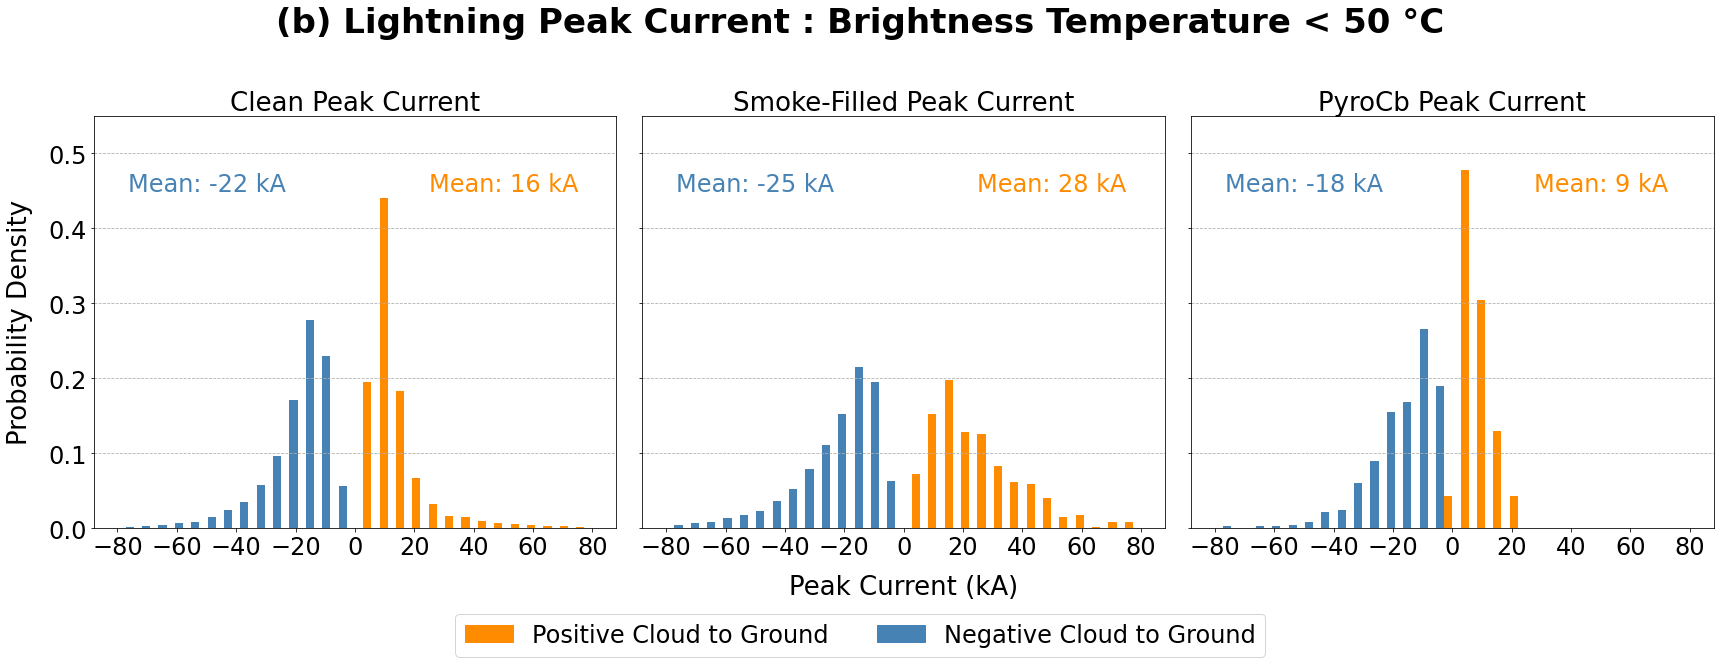

In [195]:
fig = plt.figure(figsize=(24,8))

colors = ["darkorange", "steelblue"]
bins = np.linspace(-80, 80, 30)


# ax = plt.subplot(1,3,1)
ax = fig.add_subplot(1, 3, 1)

weights_clean_pos_ground = np.ones_like(clean_pos_ground_flat)/ float(len(clean_pos_ground_flat))
weights_clean_neg_ground = np.ones_like(clean_neg_ground_flat)/ float(len(clean_neg_ground_flat))

ax.hist([clean_pos_ground_flat, clean_neg_ground_flat], weights = [weights_clean_pos_ground, weights_clean_neg_ground], bins = bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

ax.set_title("Clean Peak Current", fontsize = 26)

#ax.set_xlabel("Peak Current (kA)", fontsize = 26)
ax.set_ylabel("Probability Density", fontsize = 26, labelpad = 15)

#plt.legend(loc = "upper right", fontsize = 16)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.ylim(0,0.55)

plt.annotate("Mean: {:.0f} kA".format(np.mean(clean_neg_ground_flat)), xy =(-50, 0.45), fontsize = 24, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(clean_pos_ground_flat)), xy =(50, 0.45), fontsize = 24, color = "darkorange", ha='center')
# plt.annotate("{:.0f}".format(len(clean_pos_ground_flat) + len(clean_neg_ground_flat)), xy =(0, 0.52), fontsize = 24, color = "green", ha='center')

plt.gca().yaxis.grid(True, linestyle='--')


##################

ax = fig.add_subplot(1, 3, 2)

weights_smoke_pos_ground = np.ones_like(smoke_pos_ground_flat)/ float(len(smoke_pos_ground_flat))
weights_smoke_neg_ground = np.ones_like(smoke_neg_ground_flat)/ float(len(smoke_neg_ground_flat))

ax.hist([smoke_pos_ground_flat, smoke_neg_ground_flat], weights = [weights_smoke_pos_ground, weights_smoke_neg_ground], bins = bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

ax.set_title("Smoke-Filled Peak Current", fontsize = 26)

ax.set_xlabel("Peak Current (kA)", fontsize = 26, labelpad = 15)

plt.xticks(fontsize = 24)
plt.yticks(fontsize = 5, color = "white")
plt.ylim(0,0.55)

plt.annotate("Mean: {:.0f} kA".format(np.mean(smoke_neg_ground_flat)), xy =(-50, 0.45), fontsize = 24, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(smoke_pos_ground_flat)), xy =(50, 0.45), fontsize = 24, color = "darkorange", ha='center')
# plt.annotate("{:.0f}".format(len(smoke_pos_ground_flat) + len(smoke_neg_ground_flat)), xy =(0, 0.52), fontsize = 24, color = "green", ha='center')

plt.gca().yaxis.grid(True, linestyle='--')

###############

ax = fig.add_subplot(1, 3, 3)

weights_pyrocb_pos_ground = np.ones_like(pyrocb_pos_ground_flat)/ float(len(pyrocb_pos_ground_flat))
weights_pyrocb_neg_ground = np.ones_like(pyrocb_neg_ground_flat)/ float(len(pyrocb_neg_ground_flat))


ax.hist([pyrocb_pos_ground_flat, pyrocb_neg_ground_flat],weights = [weights_pyrocb_pos_ground, weights_pyrocb_neg_ground],  bins = bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 
ax.set_title("PyroCb Peak Current", fontsize = 26)
degree_sign = u'\N{DEGREE SIGN}'


plt.xticks(fontsize = 24)
plt.yticks(fontsize = 5, color = "white")
plt.ylim(0,0.55)

green_patch = mpatches.Patch(color='green', label='Total Cloud to Ground Lightning Count')
orange_patch = mpatches.Patch(color='darkorange', label='Positive Cloud to Ground')
blue_patch = mpatches.Patch(color='steelblue', label='Negative Cloud to Ground')

fig.legend(handles=[orange_patch, blue_patch], fontsize = 24,loc='lower center', 
           bbox_to_anchor=(0.5, -0.1),
          ncol=3, fancybox=True, shadow=False)

plt.annotate("Mean: {:.0f} kA".format(np.mean(pyrocb_neg_ground_flat)), xy =(-50, 0.45), fontsize = 24, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(pyrocb_pos_ground_flat)), xy =(50, 0.45), fontsize = 24, color = "darkorange", ha='center')
# plt.annotate("{:.0f}".format(len(pyrocb_pos_ground_flat) + len(pyrocb_neg_ground_flat)), xy =(0, 0.52), fontsize = 24, color = "green", ha='center')

plt.gca().yaxis.grid(True, linestyle='--')
plt.suptitle("(b) Lightning Peak Current : Brightness Temperature < 50 {}C".format(degree_sign),  fontweight='bold', fontsize = 34, y = 1.05) 

plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.05)

plt.savefig("parallax_allcases_split_histogram", dpi = 200, bbox_inches = "tight")
plt.show()


## box and whisker 

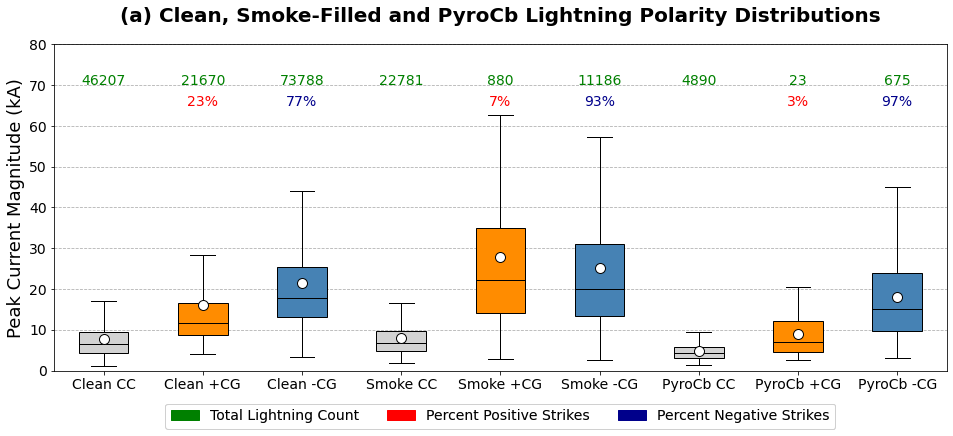

In [196]:

fig, ax = plt.subplots(figsize = (16,6))

ax.set_ylabel("Peak Current Magnitude (kA)", color = "black", fontsize = 18)
plt.yticks(fontsize = 20)
plt.ylim(0, 80)
plt.yticks(fontsize = 14, color = "black")

data = [ np.abs(clean_cloud_flat), clean_pos_ground_flat, np.abs(clean_neg_ground_flat),
        np.abs(smoke_cloud_flat), smoke_pos_ground_flat, np.abs(smoke_neg_ground_flat), 
        np.abs(pyrocb_cloud_flat), pyrocb_pos_ground_flat, np.abs(pyrocb_neg_ground_flat)]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 2, 3, 4, 5, 6, 7, 8]) # , positions = [0, 1, 3, 4, 6, 7]

# yticks2 = np.arange(0, 90, 10)
# ax2=ax.twinx()

# data2 = [np.abs(clean_neg_ground_flat), np.abs(smoke_neg_ground_flat), np.abs(pyrocb_neg_ground_flat)] 
# box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
#                    "markerfacecolor":"white", 
#                    "markeredgecolor":"black",
#                   "markersize":"10"}, medianprops=dict(color='black'), positions = [2, 5, 8]) # 

#ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

#plt.yticks(fontsize = 20, color = "steelblue")
#plt.ylim(0, 90)
ax.spines['right'].set_color('black')
#ax2.spines['left'].set_color('orangered')

color1 = ['lightgray', 'darkorange', 'steelblue', 
          'lightgray', 'darkorange', 'steelblue', 
          'lightgray', 'darkorange', 'steelblue'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

# color2 = ['steelblue', 'steelblue', 'steelblue']
# for patch, color in zip(box2['boxes'], color2):
#     patch.set_facecolor(color)
        
labels = [ "Clean CC", "Clean +CG", "Clean -CG", "Smoke CC", "Smoke +CG", "Smoke -CG", "PyroCb CC",  "PyroCb +CG",  "PyroCb -CG"]  
ax.set_xticklabels(labels, fontsize = 14)

# clean length count 
plt.annotate("{:.0f}".format(len(clean_cloud_flat)), xy =(0, 70), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean_pos_ground_flat)), xy =(1, 70), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean_neg_ground_flat)), xy =(2, 70), fontsize = 14, color = "green", ha='center')

# smoke length count 
plt.annotate("{:.0f}".format(len(smoke_cloud_flat)), xy =(3, 70), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(smoke_pos_ground_flat)), xy =(4, 70), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(smoke_neg_ground_flat)), xy =(5, 70), fontsize = 14, color = "green", ha='center')

#pyrocb length count 
plt.annotate("{:.0f}".format(len(pyrocb_cloud_flat)), xy =(6, 70), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(pyrocb_pos_ground_flat)), xy =(7, 70), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(pyrocb_neg_ground_flat)), xy =(8, 70), fontsize = 14, color = "green", ha='center')

# clean percentage 
a = (len(clean_pos_ground_flat)/ (len(clean_pos_ground_flat) + len(clean_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(a), xy =(1, 65), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - a), xy =(2, 65), fontsize = 14, color = "darkblue", ha='center')

# smoke percentage 
b = (len(smoke_pos_ground_flat)/ (len(smoke_pos_ground_flat) + len(smoke_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(b), xy =(4, 65), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - b), xy =(5, 65), fontsize = 14, color = "darkblue", ha='center')

# pyrocb percentage 
c = (len(pyrocb_pos_ground_flat)/ (len(pyrocb_pos_ground_flat) + len(pyrocb_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(c), xy =(7, 65), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - c), xy =(8, 65), fontsize = 14, color = "darkblue", ha='center')

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='Percent Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='Percent Negative Strikes')

firstlegend = ax.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 14,loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=False)
ax.add_artist(firstlegend)


# clean_patch = mpatches.Patch(color='white', label='Clean: {:.1f} CC : 1 CG'.format(len(clean_cloud_flat) / (len(clean_pos_ground_flat) + len(clean_neg_ground_flat))))
# smoke_patch = mpatches.Patch(color='white', label='Smoke: {:.1f} CC : 1 CG'.format(len(smoke_cloud_flat) / (len(smoke_pos_ground_flat) + len(smoke_neg_ground_flat))))
# pyrocb_patch = mpatches.Patch(color='white', label='PyroCb: {:.1f} CC : 1 CG'.format(len(pyrocb_cloud_flat) / (len(pyrocb_pos_ground_flat) + len(pyrocb_neg_ground_flat))))
# blank_patch = mpatches.Patch(color='white')

# ax.legend(handles=[clean_patch, smoke_patch, pyrocb_patch], fontsize = 14,loc='lower center', 
#            bbox_to_anchor=(0.5, -0.3),
#           ncol=3, fancybox=True, shadow=False)


plt.gca().yaxis.grid(True, linestyle='--')
ax.set_title('(a) Clean, Smoke-Filled and PyroCb Lightning Polarity Distributions',fontweight='bold',  fontsize = 20, y = 1.05)

plt.savefig("boxplot_posneg_parallax_allcases.png",bbox_inches = "tight", dpi = 800)
plt.show()


# Clean cases seperate analysis

## box and whisker

In [ ]:

fig, ax = plt.subplots(figsize = (24,6))

ax.set_ylabel("Peak Current Magnitude (kA)", color = "black", fontsize = 18)
plt.yticks(fontsize = 20)
plt.ylim(0, 130)
plt.yticks(fontsize = 20, color = "black")

data = [np.abs(clean1_cloud_flat), clean1_pos_ground_flat, np.abs(clean2_cloud_flat), 
        clean2_pos_ground_flat, np.abs(clean3_cloud_flat), clean3_pos_ground_flat, 
       np.abs(clean4_cloud_flat), clean4_pos_ground_flat, np.abs(clean5_cloud_flat), clean5_pos_ground_flat]


# data = [pyrocb_cloud_flat, pyrocb_pos_ground_flat]
# data2 = [list(map(abs,pyrocb_neg_ground_flat))] 


box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 3, 4, 6, 7, 9, 10, 12, 13]) # , positions = [0, 2, 4, 6]

# yticks2 = np.arange(0, 130, 10)
# ax2=ax.twinx()

data2 = [np.abs(clean1_neg_ground_flat), np.abs(clean2_neg_ground_flat),  
         np.abs(clean3_neg_ground_flat),  np.abs(clean4_neg_ground_flat),  np.abs(clean5_neg_ground_flat)] 
box2 = ax.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [2, 5, 8, 11, 14]) # 

#ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "black")
plt.ylim(0, 130)
# ax2.spines['right'].set_color('steelblue')
# ax2.spines['left'].set_color('orangered')

color1 = ['lightgray', 'darkorange', 'lightgray', 'darkorange', 'lightgray', 'darkorange', 'lightgray', 'darkorange', 'lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue', 'steelblue', 'steelblue',  'steelblue', 'steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Clean 1 CC",  "Clean 1 +CG", "Clean 2 CC", "Clean 2 +CG", "Clean 3 CC", "Clean 3 +CG",
          "Clean 4 CC", "Clean 4 +CG", "Clean 5 CC", "Clean 5 +CG",
          "Clean 1 -CG","Clean 2 -CG", "Clean 3 -CG","Clean 4 -CG", "Clean 5 -CG"]  
ax.set_xticklabels(labels, fontsize = 14)

# clean length count 
plt.annotate("{:.0f}".format(len(clean1_cloud_flat)), xy =(0, 120), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean1_pos_ground_flat)), xy =(1, 120), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean1_neg_ground_flat)), xy =(2, 120), fontsize = 14, color = "green", ha='center')

# clean length count 
plt.annotate("{:.0f}".format(len(clean2_cloud_flat)), xy =(3, 120), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean2_pos_ground_flat)), xy =(4, 120), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean2_neg_ground_flat)), xy =(5, 120), fontsize = 14, color = "green", ha='center')

# clean length count 
plt.annotate("{:.0f}".format(len(clean3_cloud_flat)), xy =(6, 120), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean3_pos_ground_flat)), xy =(7, 120), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean3_neg_ground_flat)), xy =(8, 120), fontsize = 14, color = "green", ha='center')

# clean length count 
plt.annotate("{:.0f}".format(len(clean4_cloud_flat)), xy =(9, 120), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean4_pos_ground_flat)), xy =(10, 120), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean4_neg_ground_flat)), xy =(11, 120), fontsize = 14, color = "green", ha='center')

# clean length count 
plt.annotate("{:.0f}".format(len(clean5_cloud_flat)), xy =(12, 120), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean5_pos_ground_flat)), xy =(13, 120), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(clean5_neg_ground_flat)), xy =(14, 120), fontsize = 14, color = "green", ha='center')

# clean percentage 
a = (len(clean1_pos_ground_flat)/ (len(clean1_pos_ground_flat) + len(clean1_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(a), xy =(1, 112), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - a), xy =(2, 112), fontsize = 14, color = "darkblue", ha='center')

b = (len(clean2_pos_ground_flat)/ (len(clean2_pos_ground_flat) + len(clean2_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(b), xy =(4, 112), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - b), xy =(5, 112), fontsize = 14, color = "darkblue", ha='center')

c = (len(clean3_pos_ground_flat)/ (len(clean3_pos_ground_flat) + len(clean3_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(c), xy =(7, 112), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - c), xy =(8, 112), fontsize = 14, color = "darkblue", ha='center')

d = (len(clean4_pos_ground_flat)/ (len(clean4_pos_ground_flat) + len(clean4_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(d), xy =(10, 112), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - d), xy =(11, 112), fontsize = 14, color = "darkblue", ha='center')

e = (len(clean5_pos_ground_flat)/ (len(clean5_pos_ground_flat) + len(clean5_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(e), xy =(13, 112), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - e), xy =(14, 112), fontsize = 14, color = "darkblue", ha='center')


green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='Percent Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='Percent Negative Strikes')

firstlegend = ax.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 14,loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=False)

ax.add_artist(firstlegend)

# clean1_patch = mpatches.Patch(color='white', label='Clean 1: {:.1f} CC : 1 CG'.format(len(clean1_cloud_flat) / (len(clean1_pos_ground_flat) + len(clean1_neg_ground_flat))))
# clean2_patch = mpatches.Patch(color='white', label='Clean 2: {:.1f} CC : 1 CG'.format(len(clean2_cloud_flat) / (len(clean2_pos_ground_flat) + len(clean2_neg_ground_flat))))
# clean3_patch = mpatches.Patch(color='white', label='Clean 3: {:.1f} CC : 1 CG'.format(len(clean3_cloud_flat) / (len(clean3_pos_ground_flat) + len(clean3_neg_ground_flat))))
# clean4_patch = mpatches.Patch(color='white', label='Clean 4: {:.1f} CC : 1 CG'.format(len(clean4_cloud_flat) / (len(clean4_pos_ground_flat) + len(clean4_neg_ground_flat))))
# clean5_patch = mpatches.Patch(color='white', label='Clean 5: {:.1f} CC : 1 CG'.format(len(clean5_cloud_flat) / (len(clean5_pos_ground_flat) + len(clean5_neg_ground_flat))))

# ax.legend(handles=[clean1_patch, clean2_patch, clean3_patch, clean4_patch, clean5_patch], fontsize = 14,loc='lower center', 
#            bbox_to_anchor=(0.5, -0.3),
#           ncol=5, fancybox=True, shadow=False)
ax.set_title('(a) Clean Thunderstorm Peak Current Distributions', fontweight='bold', fontsize = 20, y = 1.05)
plt.gca().yaxis.grid(True, linestyle='--')

plt.savefig("boxplot_posneg_parallax_cleancases.png",bbox_inches = "tight", dpi = 800)
plt.show()


## histogram

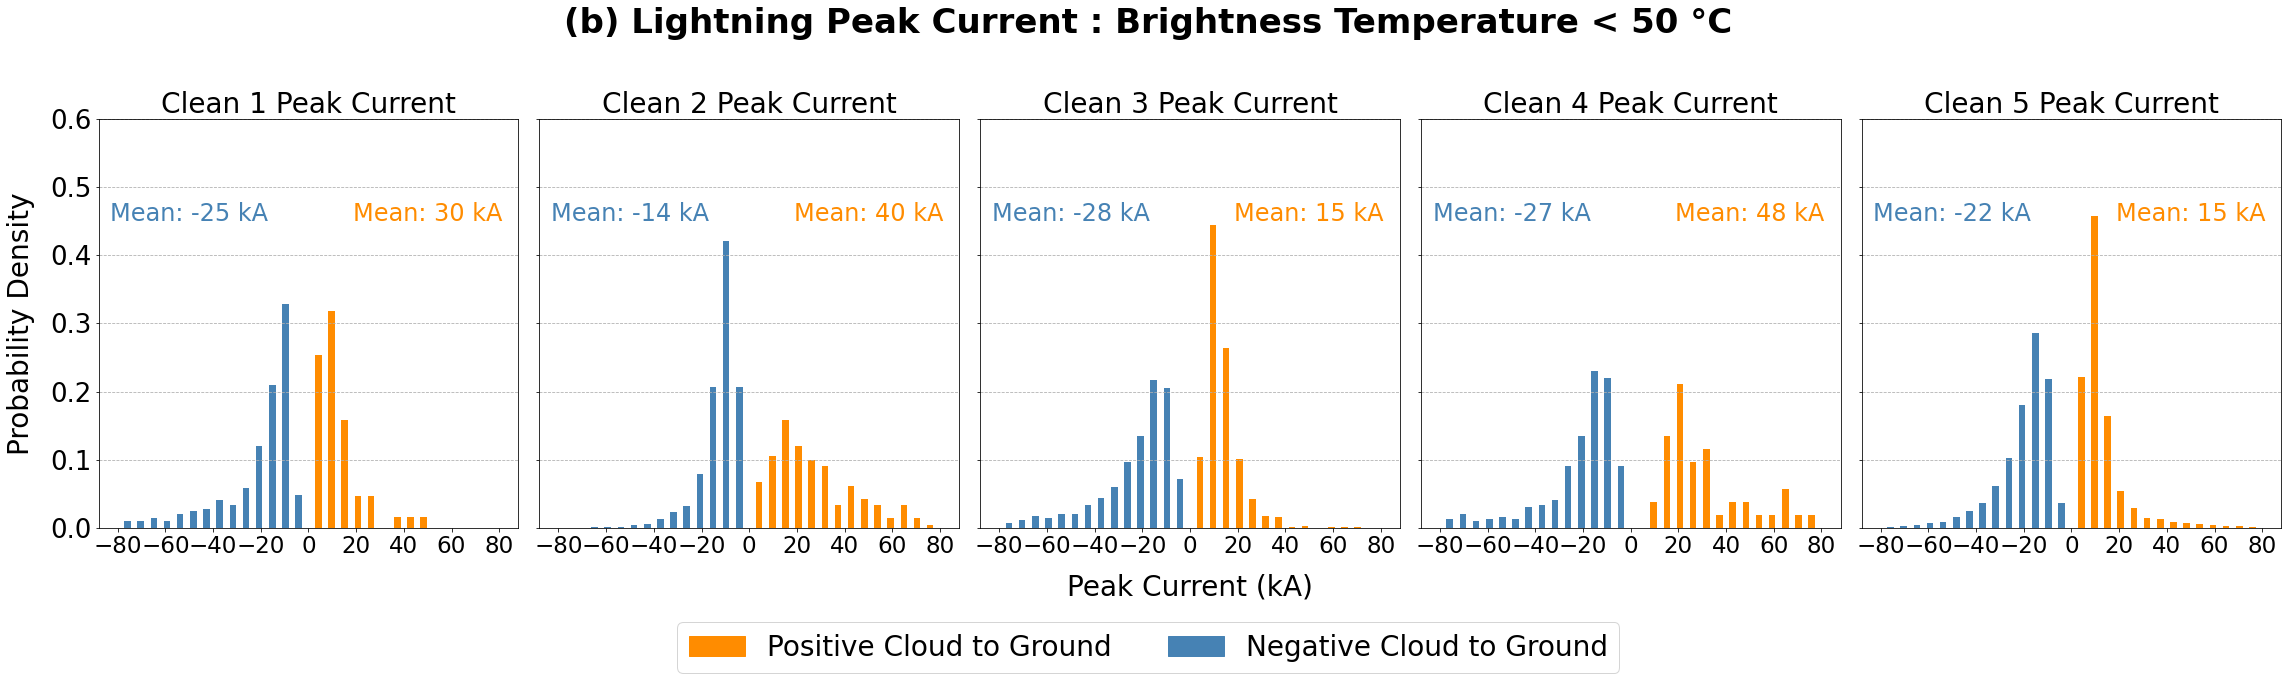

In [197]:
fig = plt.figure(figsize=(32,8))

colors = ["darkorange", "steelblue"]
bins = np.linspace(-80, 80, 30)
degree_sign = u'\N{DEGREE SIGN}'


ax = fig.add_subplot(1, 5, 1)

weights_clean1_pos_ground = np.ones_like(clean1_pos_ground_flat)/ float(len(clean1_pos_ground_flat))
weights_clean1_neg_ground = np.ones_like(clean1_neg_ground_flat)/ float(len(clean1_neg_ground_flat))

ax.hist([clean1_pos_ground_flat, clean1_neg_ground_flat], weights = [weights_clean1_pos_ground, weights_clean1_neg_ground], bins = bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

ax.set_title("Clean 1 Peak Current", fontsize = 28)
ax.set_ylabel("Probability Density", fontsize = 28, labelpad = 15)

plt.xticks(fontsize = 23)
plt.yticks(fontsize = 26)
plt.ylim(0,0.6)

plt.annotate("Mean: {:.0f} kA".format(np.mean(clean1_neg_ground_flat)), xy =(-50, 0.45), fontsize = 24, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(clean1_pos_ground_flat)), xy =(50, 0.45), fontsize = 24, color = "darkorange", ha='center')
# plt.annotate("{:.0f}".format(len(clean1_pos_ground_flat) + len(clean1_neg_ground_flat)), xy =(0, 0.52), fontsize = 24, color = "green", ha='center')

plt.gca().yaxis.grid(True, linestyle='--')


##################

ax = fig.add_subplot(1, 5, 2)

weights_clean2_pos_ground = np.ones_like(clean2_pos_ground_flat)/ float(len(clean2_pos_ground_flat))
weights_clean2_neg_ground = np.ones_like(clean2_neg_ground_flat)/ float(len(clean2_neg_ground_flat))

ax.hist([clean2_pos_ground_flat, clean2_neg_ground_flat], weights = [weights_clean2_pos_ground, weights_clean2_neg_ground], bins = bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

ax.set_title("Clean 2 Peak Current", fontsize = 28)

plt.xticks(fontsize = 23)
plt.yticks(fontsize = 5, color = "white")
plt.ylim(0,0.6)

plt.annotate("Mean: {:.0f} kA".format(np.mean(clean2_neg_ground_flat)), xy =(-50, 0.45), fontsize = 24, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(clean2_pos_ground_flat)), xy =(50, 0.45), fontsize = 24, color = "darkorange", ha='center')
# plt.annotate("{:.0f}".format(len(clean2_pos_ground_flat) + len(clean2_neg_ground_flat)), xy =(0, 0.52), fontsize = 24, color = "green", ha='center')

plt.gca().yaxis.grid(True, linestyle='--')

##################


ax = fig.add_subplot(1, 5, 3)

weights_clean3_pos_ground = np.ones_like(clean3_pos_ground_flat)/ float(len(clean3_pos_ground_flat))
weights_clean3_neg_ground = np.ones_like(clean3_neg_ground_flat)/ float(len(clean3_neg_ground_flat))

ax.hist([clean3_pos_ground_flat, clean3_neg_ground_flat], weights = [weights_clean3_pos_ground, weights_clean3_neg_ground], bins = bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

ax.set_title("Clean 3 Peak Current", fontsize = 28)

ax.set_xlabel("Peak Current (kA)", fontsize = 28, labelpad = 15)

plt.xticks(fontsize = 23)
plt.yticks(fontsize = 5, color = "white")
plt.ylim(0,0.6)

plt.annotate("Mean: {:.0f} kA".format(np.mean(clean3_neg_ground_flat)), xy =(-50, 0.45), fontsize = 24, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(clean3_pos_ground_flat)), xy =(50, 0.45), fontsize = 24, color = "darkorange", ha='center')
# plt.annotate("{:.0f}".format(len(clean3_pos_ground_flat) + len(clean3_neg_ground_flat)), xy =(0, 0.52), fontsize = 24, color = "green", ha='center')

plt.gca().yaxis.grid(True, linestyle='--')

##################


ax = fig.add_subplot(1, 5, 4)

weights_clean4_pos_ground = np.ones_like(clean4_pos_ground_flat)/ float(len(clean4_pos_ground_flat))
weights_clean4_neg_ground = np.ones_like(clean4_neg_ground_flat)/ float(len(clean4_neg_ground_flat))

ax.hist([clean4_pos_ground_flat, clean4_neg_ground_flat], weights = [weights_clean4_pos_ground, weights_clean4_neg_ground], bins = bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

ax.set_title("Clean 4 Peak Current", fontsize = 28)

plt.xticks(fontsize = 23)
plt.yticks(fontsize = 5, color = "white")
plt.ylim(0,0.6)

plt.annotate("Mean: {:.0f} kA".format(np.mean(clean4_neg_ground_flat)), xy =(-50, 0.45), fontsize = 24, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(clean4_pos_ground_flat)), xy =(50, 0.45), fontsize = 24, color = "darkorange", ha='center')
# plt.annotate("{:.0f}".format(len(clean4_pos_ground_flat) + len(clean4_neg_ground_flat)), xy =(0, 0.52), fontsize = 24, color = "green", ha='center')

plt.gca().yaxis.grid(True, linestyle='--')

###############

ax = fig.add_subplot(1, 5, 5)

weights_clean5_pos_ground = np.ones_like(clean5_pos_ground_flat)/ float(len(clean5_pos_ground_flat))
weights_clean5_neg_ground = np.ones_like(clean5_neg_ground_flat)/ float(len(clean5_neg_ground_flat))

ax.hist([clean5_pos_ground_flat, clean5_neg_ground_flat], weights = [weights_clean5_pos_ground, weights_clean5_neg_ground], bins = bins, alpha = 1, histtype='bar',  color=colors, rwidth = 1, label = ["Positive Cloud to Ground", "Negative Cloud to Ground"]) 

ax.set_title("Clean 5 Peak Current", fontsize = 28)

plt.xticks(fontsize = 23)
plt.yticks(fontsize = 5, color = "white")
plt.ylim(0,0.6)

plt.annotate("Mean: {:.0f} kA".format(np.mean(clean5_neg_ground_flat)), xy =(-50, 0.45), fontsize = 24, color = "steelblue", ha='center')
plt.annotate("Mean: {:.0f} kA".format(np.mean(clean5_pos_ground_flat)), xy =(50, 0.45), fontsize = 24, color = "darkorange", ha='center')
# plt.annotate("{:.0f}".format(len(clean5_pos_ground_flat) + len(clean5_neg_ground_flat)), xy =(0, 0.52), fontsize = 24, color = "green", ha='center')
plt.gca().yaxis.grid(True, linestyle='--')

green_patch = mpatches.Patch(color='green', label='Total Cloud to Ground Lightning Count')
orange_patch = mpatches.Patch(color='darkorange', label='Positive Cloud to Ground')
blue_patch = mpatches.Patch(color='steelblue', label='Negative Cloud to Ground')

firstlegend = fig.legend(handles=[orange_patch, blue_patch], fontsize = 28,loc='lower center', 
           bbox_to_anchor=(0.5, -0.13),
          ncol=3, fancybox=True, shadow=False)
plt.suptitle("(b) Lightning Peak Current : Brightness Temperature < 50 {}C".format(degree_sign),  fontweight='bold', fontsize = 34, y = 1.05) 

plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.05)

plt.savefig("parallax_cleancases_split_histogram", dpi = 200, bbox_inches = "tight")
plt.show()


## maps 

In [ ]:
colormap = LinearSegmentedColormap.from_list('custom', 
                                        [(0, "darkviolet"), 
                                        (0.1, "red"), 
                                        (0.2, "white"),
                                        (0.25, "cornflowerblue"), 
                                        (0.5, 'white'),
                                        (0.8, 'lightgrey'), 
                                        (1.0, 'darkgrey')
                                        ], N=30)

In [ ]:
lt_plx_clean1 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean1_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean2 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean2_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean3 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean3.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean4 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean4.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean4 = lt_plx_clean4.loc[(lt_plx_clean4.lat >= 51) & (lt_plx_clean4.lon <= -122.7)]
lt_plx_clean5 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean5.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
lt_plx_clean1

In [ ]:
lt_plx_clean1["lon"] = lt_plx_clean1["lon"] + (17231 * 0.000013)
lt_plx_clean1["lat"] = lt_plx_clean1["lat"] + (17231 * 0.000017)

lt_plx_clean2["lon"] = lt_plx_clean2["lon"] + (17220 * 0.000010)
lt_plx_clean2["lat"] = lt_plx_clean2["lat"] + (17220 * 0.000016)

# lt_plx_clean3["lon"] = lt_plx_clean3["lon"] + (14328 * 0.000011) # + (17328 * 0.000011)
# lt_plx_clean3["lat"] = lt_plx_clean3["lat"] + (14328 * 0.000019) # + (17328 * 0.000019)

lt_plx_clean4["lon"] = lt_plx_clean4["lon"] + (10058 * 0.000008) # + (16058 * 0.000008)
lt_plx_clean4["lat"] = lt_plx_clean4["lat"] + (10058 * 0.000016) # + (16058 * 0.000016)

lt_plx_clean5["lon"] = lt_plx_clean5["lon"] + (17226 * 0.000022)
lt_plx_clean5["lat"] = lt_plx_clean5["lat"] + (17226 * 0.000021)



In [ ]:
fig = plt.figure(figsize=(30, 20))

# clean case 1 : june 8 hour 23 (159)
FILE = "/data2/edworak/data/br_temp_2019/201915923/OR_ABI-L2-MCMIPF-M6_G17_s20191592300339_e20191592309406_c20191592309476.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"
dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

pc = ccrs.PlateCarree()
ax1 = plt.subplot2grid(shape = (2,6), loc = (0,1), colspan=2, projection = pc)
ax1.set_extent([-120, -112, 50, 56], crs=pc)
ax1.coastlines(resolution='50m', color='black', linewidth=1.0)
ax1.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)
scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -119,  -117, -115, -113])
gl.ylocator = mticker.FixedLocator([51, 52, 53, 54, 55])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} 

im = ax1.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

points = lt_plx_clean1
#points_all = lt_plx_clean1
ax1.scatter(x = points["lon"], y = points["lat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean1.loc[((lt_plx_clean1.hour == 22) & (lt_plx_clean1.minute >= 30)) | ((lt_plx_clean1.hour == 23) & (lt_plx_clean1.minute <= 30))]
#pointshour_all = lt_plx_clean1.loc[((lt_plx_clean1.hour == 22) & (lt_plx_clean1.minute >= 30)) | ((lt_plx_clean1.hour == 10) & (lt_plx_smoke.minute <= 30))]
ax1.scatter(x = pointshour["lon"], y = pointshour["lat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)


titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="6 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
ax1.legend(handles=[titlepatch, blank], loc='lower center', 
            bbox_to_anchor=(0.5, -0.2),
            ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)        

fires1_lat = [55.3367]
fires1_lon = [-117.2902]
ax1.scatter(x = fires1_lon, y = fires1_lat, s = 100, color='red',  marker = "o")# linewidths=0.5, facecolors='none', edgecolors='orangered'

cax = plt.axes([0.1, -0.08, 0.8, 0.025])
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5,  cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax1.set_title(r"$\bf{" + "(a) \ Clean \ Event \ 1" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 30) #loc='right'

# ------------------------------------------------------------------------------------------------------


# clean case 2 : june 13 hour 2 (164)
FILE = "/data2/edworak/data/br_temp_2019/201916402/OR_ABI-L2-MCMIPF-M6_G17_s20191640200339_e20191640209412_c20191640209480.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]

#plot with celsius 
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"

dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

ax2 = plt.subplot2grid((2,6), (0,3), colspan=2, projection = pc)
ax2.set_extent([-124, -116, 50, 56], crs=pc)
ax2.set_xlabel("Lightning Strike Totals", fontsize = 20)

ax2.coastlines(resolution='50m', color='black', linewidth=1.0)
ax2.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax2.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -123,  -121,  -119, -117, -115])
gl.ylocator = mticker.FixedLocator([51, 52, 53, 54, 55])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} #, 'weight': 'bold'

im = ax2.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

points = lt_plx_clean2
#points_all = lt_plx_clean2
ax2.scatter(x = points["lon"], y = points["lat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean2.loc[((lt_plx_clean2.hour == 1) & (lt_plx_clean2.minute >= 30)) | ((lt_plx_clean2.hour == 3) & (lt_plx_clean2.minute <= 30))]
#pointshour_all = lt_plx_clean2.loc[(lt_plx_clean2.hour == 2)]
ax2.scatter(x = pointshour["lon"], y = pointshour["lat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)


titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="8 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
ax2.legend(handles=[titlepatch, blank], loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
           ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)        


# ax2.legend(handles=[titlepatch, patch3, patch4, blank, patch5, blank], loc='lower center', 
#             bbox_to_anchor=(0.5, -0.4),
#             ncol=2, fancybox=True, shadow=False, fontsize = 20, markerscale=3.,)

cax = plt.axes([0.1, -0.08, 0.8, 0.025])
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax2.set_title(r"$\bf{" + "(b) \ Clean \ Event \ 2" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 30) #loc='right'

# ------------------------------------------------------------------------------------------------------

# clean case 3: june 27 2 UTC (178)
FILE = "/data2/edworak/data/br_temp_2019/201917802/OR_ABI-L2-MCMIPF-M6_G17_s20191780200339_e20191780209406_c20191780209494.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"
dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

ax3 = plt.subplot2grid((2,6), (1,0), colspan=2, projection = pc)
ax3.set_extent([-126, -118, 54, 60], crs=pc)

ax3.coastlines(resolution='50m', color='black', linewidth=1.0)
ax3.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)
scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
#plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 22) #loc='right'

gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True        
gl.xlocator = mticker.FixedLocator([ -125, -123, -121, -119])
gl.ylocator = mticker.FixedLocator([55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} #, 'weight': 'bold'

im = ax3.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

points = lt_plx_clean3
#points_all = lt_plx_clean3
ax3.scatter(x = points["lon"], y = points["lat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean3.loc[((lt_plx_clean3.hour == 2) & (lt_plx_clean3.minute >= 30)) | ((lt_plx_clean3.hour == 3) & (lt_plx_clean3.minute <= 30))]
#pointshour_all = lt_plx_clean3.loc[(lt_plx_clean3.hour == 2)]
ax3.scatter(x = pointshour["lon"], y = pointshour["lat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)

titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="7 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
ax3.legend(handles=[titlepatch, blank], loc='lower center', 
            bbox_to_anchor=(0.5, -0.2),
            ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)        

# fires3_lat = [57.5811]
# fires3_lon = [-117.1056] 
# ax3.scatter(x = fires3_lon, y = fires3_lat, s = 100, color='darkred',  marker = "o",  label = "Fire Detections")# linewidths=0.5, facecolors='none', edgecolors='orangered'

# [left, bottom, width, height]
cax = plt.axes([0.1, -0.08, 0.8, 0.025])

cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax3.set_title(r"$\bf{" + "(c) \ Clean \ Event \ 3" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 30) #loc='right'

# ------------------------------------------------------------------------------------------------------

# clean case 4: June 27 20 UTC (178)
FILE = "/data2/edworak/data/br_temp_2019/201917821/OR_ABI-L2-MCMIPF-M6_G17_s20191782100341_e20191782109419_c20191782109475.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]

#plot with celsius 
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"

dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

ax4 = plt.subplot2grid((2,6), (1,2), colspan=2, projection = pc)
ax4.set_extent([-126, -118, 50, 56], crs=pc)

ax4.coastlines(resolution='50m', color='black', linewidth=1.0)
ax4.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
#plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 22) #loc='right'

gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True        
gl.xlocator = mticker.FixedLocator([ -125, -123, -121, -119])
gl.ylocator = mticker.FixedLocator([51, 52, 53, 54, 55])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} #, 'weight': 'bold'

im = ax4.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

points = lt_plx_clean4
#points_all = lt_plx_clean4
ax4.scatter(x = points["lon"], y = points["lat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean4.loc[((lt_plx_clean4.hour == 20) & (lt_plx_clean4.minute >= 30)) | ((lt_plx_clean4.hour == 21) & (lt_plx_clean4.minute <= 30))]
#pointshour_all = lt_plx_clean4.loc[(lt_plx_clean4.hour == 21)]
ax4.scatter(x = pointshour["lon"], y = pointshour["lat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)

titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="5 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
hourpatch = mpatches.Patch(facecolor='lightgreen', edgecolor = "grey", label="1 Hour Totals".format(str(len(pointshour))))
ax4.legend(handles=[titlepatch, blank], loc='lower center', 
            bbox_to_anchor=(0.5, -0.2),
            ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)

# [left, bottom, width, height]
cax = plt.axes([0.1, -0.08, 0.8, 0.025])
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax4.set_title(r"$\bf{" + "(d) \ Clean \ Event \ 4" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 30) #loc='right'


# ------------------------------------------------------------------------------------------------------

# clean case 5: june 15 21 UTC (166)
FILE = "/data2/edworak/data/BT_nosmoke/202116621/OR_ABI-L2-MCMIPF-M6_G17_s20211662100321_e20211662109388_c20211662109542.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]

#plot with celsius 
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"

dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

ax5 = plt.subplot2grid((2,6), (1,4), colspan=2, projection = pc)
ax5.set_extent([-120, -108, 52, 61], crs=pc)

ax5.coastlines(resolution='50m', color='black', linewidth=1.0)
ax5.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
# plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 22) #loc='right'

gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True        
gl.xlocator = mticker.FixedLocator([- 119, -115, -111, -107])
gl.ylocator = mticker.FixedLocator([53, 55, 57, 59])

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} #, 'weight': 'bold'

im = ax5.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
points = lt_plx_clean5
#points_all = lt_plx_clean5
ax5.scatter(x = points["lon"], y = points["lat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean5.loc[((lt_plx_clean5.hour == 20) & (lt_plx_clean5.minute >= 30)) | ((lt_plx_clean5.hour == 21) & (lt_plx_clean5.minute <= 30))]
#pointshour_all = lt_plx_clean5.loc[(lt_plx_clean5.hour == 21)]
ax5.scatter(x = pointshour["lon"], y = pointshour["lat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)

nopoints = lt_plx_clean5.loc[(lt_plx_clean5.hour == 2) & (lt_plx_clean5.hour == 3)]
ax5.scatter(x = nopoints["lon"], y = nopoints["lat"], s = 100, color = "lightgreen", marker = "o", alpha = 0.8,  label = "Strikes Within 30 Minutes of Image Time")
ax5.scatter(x = nopoints["lon"], y = nopoints["lat"], s = 100, color = "black", marker = "o", alpha = 0.8,  label = "All Strikes Analyzed")
# ax5.scatter(x = nopoints["lon"], y = nopoints["lat"], s = 100, color = "red", marker = "o", alpha = 0.8,  label = "Fire Location")

titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="6 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
hourpatch = mpatches.Patch(facecolor='lightgreen', edgecolor = "grey", label="1 Hour Totals".format(str(len(pointshour))))
firstlegend =  ax5.legend(handles=[titlepatch, blank], loc='lower center', 
            bbox_to_anchor=(0.5, -0.2),
            ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)
ax5.add_artist(firstlegend)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), fontsize = 26, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol = 3)

# [left, bottom, width, height]
cax = plt.axes([0.1, -0.08, 0.8, 0.025])
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax5.set_title(r"$\bf{" + "(e) \ Clean \ Event \ 5" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 30) #loc='right'


# ------------------------------------------------------------------------------------------------------
plt.suptitle("Five Clean Thunderstorm Cases", x = 0.5, y = 1, fontweight='bold', fontsize=34)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.3)

plt.savefig("clean_maps_final", bbox_inches = "tight", dpi = 600)
plt.show()


## figure 1 with VIIRS

In [ ]:
fig = plt.figure(figsize=(30, 20))

# clean case 1 : june 8 hour 23 (159)
FILE = "/data2/edworak/data/br_temp_2019/201915923/OR_ABI-L2-MCMIPF-M6_G17_s20191592300339_e20191592309406_c20191592309476.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"
dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

pc = ccrs.PlateCarree()
ax1 = plt.subplot2grid(shape = (2,6), loc = (0,1), colspan=2, projection = pc)
ax1.set_extent([-120, -112, 50, 56], crs=pc)
ax1.coastlines(resolution='50m', color='black', linewidth=1.0)
ax1.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)
scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -119,  -117, -115, -113])
gl.ylocator = mticker.FixedLocator([51, 52, 53, 54, 55])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} 

im = ax1.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

points = lt_plx_clean1
#points_all = lt_plx_clean1
ax1.scatter(x = points["tlon"], y = points["tlat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean1.loc[((lt_plx_clean1.hour == 22) & (lt_plx_clean1.minute >= 30)) | ((lt_plx_clean1.hour == 23) & (lt_plx_clean1.minute <= 30))]
#pointshour_all = lt_plx_clean1.loc[((lt_plx_clean1.hour == 22) & (lt_plx_clean1.minute >= 30)) | ((lt_plx_clean1.hour == 10) & (lt_plx_smoke.minute <= 30))]
ax1.scatter(x = pointshour["tlon"], y = pointshour["tlat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)


titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="6 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
ax1.legend(handles=[titlepatch, blank], loc='lower center', 
            bbox_to_anchor=(0.5, -0.2),
            ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)        

# fires1_lat = [55.3367]
# fires1_lon = [-117.2902]
# ax1.scatter(x = fires1_lon, y = fires1_lat, s = 100, color='red',  marker = "o")# linewidths=0.5, facecolors='none', edgecolors='orangered'


#######################
# overlay viirs fires

viirs_path = '/data2/edworak/data/viirs_snpp_nrl_20190101_20191231.nc'
# the code will pull the fire pixels from 24 hours before this time:

plot_day = 159
plot_hour = 23
plot_minute = 0

viirs_data = nc.Dataset(viirs_path)
viirs_lat = viirs_data['median_lat'][:]
viirs_lon = viirs_data['median_lon'][:]
viirs_time = viirs_data['time'][:]  
viirs_frp = viirs_data['total_frp'][:]

viirs_h = 6+viirs_time.data
plot_time = (plot_day*24) + plot_hour + (plot_minute/60.)
dt = viirs_h - plot_time
fires_within_24h = np.where(np.logical_and((dt < 0), (dt > -24)))

plt.scatter(viirs_lon[fires_within_24h[0]].data, viirs_lat[fires_within_24h[0]].data, c='yellow',s=100,marker="^",transform=ccrs.PlateCarree(),  label = "Fire Detections")

#################

cax = plt.axes([0.1, -0.08, 0.8, 0.025])
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5,  cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax1.set_title(r"$\bf{" + "(a) \ Clean \ Event \ 1" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 30) #loc='right'

# ------------------------------------------------------------------------------------------------------


# clean case 2 : june 13 hour 2 (164)
FILE = "/data2/edworak/data/br_temp_2019/201916402/OR_ABI-L2-MCMIPF-M6_G17_s20191640200339_e20191640209412_c20191640209480.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]

#plot with celsius 
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"

dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

ax2 = plt.subplot2grid((2,6), (0,3), colspan=2, projection = pc)
ax2.set_extent([-124, -116, 50, 56], crs=pc)
ax2.set_xlabel("Lightning Strike Totals", fontsize = 20)

ax2.coastlines(resolution='50m', color='black', linewidth=1.0)
ax2.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax2.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -123,  -121,  -119, -117, -115])
gl.ylocator = mticker.FixedLocator([51, 52, 53, 54, 55])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} #, 'weight': 'bold'

im = ax2.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

points = lt_plx_clean2
#points_all = lt_plx_clean2
ax2.scatter(x = points["tlon"], y = points["tlat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean2.loc[((lt_plx_clean2.hour == 1) & (lt_plx_clean2.minute >= 30)) | ((lt_plx_clean2.hour == 3) & (lt_plx_clean2.minute <= 30))]
#pointshour_all = lt_plx_clean2.loc[(lt_plx_clean2.hour == 2)]
ax2.scatter(x = pointshour["tlon"], y = pointshour["tlat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)


titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="8 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
ax2.legend(handles=[titlepatch, blank], loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
           ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)        


# ax2.legend(handles=[titlepatch, patch3, patch4, blank, patch5, blank], loc='lower center', 
#             bbox_to_anchor=(0.5, -0.4),
#             ncol=2, fancybox=True, shadow=False, fontsize = 20, markerscale=3.,)


#######################
# overlay viirs fires
viirs_path = '/data2/edworak/data/viirs_snpp_nrl_20190101_20191231.nc'

# the code will pull the fire pixels from 24 hours before this time:

plot_day = 164
plot_hour = 2
plot_minute = 0

viirs_data = nc.Dataset(viirs_path)
viirs_lat = viirs_data['median_lat'][:]
viirs_lon = viirs_data['median_lon'][:]
viirs_time = viirs_data['time'][:]  
viirs_frp = viirs_data['total_frp'][:]

viirs_h = 6+viirs_time.data
plot_time = (plot_day*24) + plot_hour + (plot_minute/60.)
dt = viirs_h - plot_time
fires_within_24h = np.where(np.logical_and((dt < 0), (dt > -24)))

plt.scatter(viirs_lon[fires_within_24h[0]].data, viirs_lat[fires_within_24h[0]].data, c='yellow',s=100,marker="^",transform=ccrs.PlateCarree(),  label = "Fire Detections")

#################


cax = plt.axes([0.1, -0.08, 0.8, 0.025])
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax2.set_title(r"$\bf{" + "(b) \ Clean \ Event \ 2" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 30) #loc='right'

# ------------------------------------------------------------------------------------------------------

# clean case 3: june 27 2 UTC (178)
FILE = "/data2/edworak/data/br_temp_2019/201917802/OR_ABI-L2-MCMIPF-M6_G17_s20191780200339_e20191780209406_c20191780209494.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"
dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

ax3 = plt.subplot2grid((2,6), (1,0), colspan=2, projection = pc)
ax3.set_extent([-126, -118, 54, 60], crs=pc)

ax3.coastlines(resolution='50m', color='black', linewidth=1.0)
ax3.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)
scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
#plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 22) #loc='right'

gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True        
gl.xlocator = mticker.FixedLocator([ -125, -123, -121, -119])
gl.ylocator = mticker.FixedLocator([55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} #, 'weight': 'bold'

im = ax3.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

points = lt_plx_clean3
#points_all = lt_plx_clean3
ax3.scatter(x = points["tlon"], y = points["tlat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean3.loc[((lt_plx_clean3.hour == 2) & (lt_plx_clean3.minute >= 30)) | ((lt_plx_clean3.hour == 3) & (lt_plx_clean3.minute <= 30))]
#pointshour_all = lt_plx_clean3.loc[(lt_plx_clean3.hour == 2)]
ax3.scatter(x = pointshour["tlon"], y = pointshour["tlat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)

titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="7 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
ax3.legend(handles=[titlepatch, blank], loc='lower center', 
            bbox_to_anchor=(0.5, -0.2),
            ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)        

# fires3_lat = [57.5811]
# fires3_lon = [-117.1056] 
# ax3.scatter(x = fires3_lon, y = fires3_lat, s = 100, color='darkred',  marker = "o",  label = "Fire Detections")# linewidths=0.5, facecolors='none', edgecolors='orangered'


#######################
# overlay viirs fires
viirs_path = '/data2/edworak/data/viirs_snpp_nrl_20190101_20191231.nc'

# the code will pull the fire pixels from 24 hours before this time:

plot_day = 178
plot_hour = 2
plot_minute = 0

viirs_data = nc.Dataset(viirs_path)
viirs_lat = viirs_data['median_lat'][:]
viirs_lon = viirs_data['median_lon'][:]
viirs_time = viirs_data['time'][:]  
viirs_frp = viirs_data['total_frp'][:]

viirs_h = 6+viirs_time.data
plot_time = (plot_day*24) + plot_hour + (plot_minute/60.)
dt = viirs_h - plot_time
fires_within_24h = np.where(np.logical_and((dt < 0), (dt > -24)))

plt.scatter(viirs_lon[fires_within_24h[0]].data, viirs_lat[fires_within_24h[0]].data, c='yellow',s=100,marker="^",transform=ccrs.PlateCarree(),  label = "Fire Detections")

#################


# [left, bottom, width, height]
cax = plt.axes([0.1, -0.08, 0.8, 0.025])

cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax3.set_title(r"$\bf{" + "(c) \ Clean \ Event \ 3" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 30) #loc='right'

# ------------------------------------------------------------------------------------------------------

# clean case 4: June 27 20 UTC (178)
FILE = "/data2/edworak/data/br_temp_2019/201917821/OR_ABI-L2-MCMIPF-M6_G17_s20191782100341_e20191782109419_c20191782109475.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]

#plot with celsius 
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"

dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

ax4 = plt.subplot2grid((2,6), (1,2), colspan=2, projection = pc)
ax4.set_extent([-126, -118, 50, 56], crs=pc)

ax4.coastlines(resolution='50m', color='black', linewidth=1.0)
ax4.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
#plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 22) #loc='right'

gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True        
gl.xlocator = mticker.FixedLocator([ -125, -123, -121, -119])
gl.ylocator = mticker.FixedLocator([51, 52, 53, 54, 55])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} #, 'weight': 'bold'

im = ax4.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

points = lt_plx_clean4
#points_all = lt_plx_clean4
ax4.scatter(x = points["tlon"], y = points["tlat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean4.loc[((lt_plx_clean4.hour == 20) & (lt_plx_clean4.minute >= 30)) | ((lt_plx_clean4.hour == 21) & (lt_plx_clean4.minute <= 30))]
#pointshour_all = lt_plx_clean4.loc[(lt_plx_clean4.hour == 21)]
ax4.scatter(x = pointshour["tlon"], y = pointshour["tlat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)

titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="5 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
hourpatch = mpatches.Patch(facecolor='lightgreen', edgecolor = "grey", label="1 Hour Totals".format(str(len(pointshour))))
ax4.legend(handles=[titlepatch, blank], loc='lower center', 
            bbox_to_anchor=(0.5, -0.2),
            ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)


#######################
# overlay viirs fires

viirs_path = '/data2/edworak/data/viirs_snpp_nrl_20190101_20191231.nc'
# the code will pull the fire pixels from 24 hours before this time:

plot_day = 178
plot_hour = 21
plot_minute = 0

viirs_data = nc.Dataset(viirs_path)
viirs_lat = viirs_data['median_lat'][:]
viirs_lon = viirs_data['median_lon'][:]
viirs_time = viirs_data['time'][:]  
viirs_frp = viirs_data['total_frp'][:]

viirs_h = 6+viirs_time.data
plot_time = (plot_day*24) + plot_hour + (plot_minute/60.)
dt = viirs_h - plot_time
fires_within_24h = np.where(np.logical_and((dt < 0), (dt > -24)))

plt.scatter(viirs_lon[fires_within_24h[0]].data, viirs_lat[fires_within_24h[0]].data, c='yellow',s=100,marker="^",transform=ccrs.PlateCarree(),  label = "Fire Detections")

#################


# [left, bottom, width, height]
cax = plt.axes([0.1, -0.08, 0.8, 0.025])
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax4.set_title(r"$\bf{" + "(d) \ Clean \ Event \ 4" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 30) #loc='right'


# ------------------------------------------------------------------------------------------------------

# clean case 5: june 15 21 UTC (166)
FILE = "/data2/edworak/data/BT_nosmoke/202116621/OR_ABI-L2-MCMIPF-M6_G17_s20211662100321_e20211662109388_c20211662109542.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]

#plot with celsius 
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"

dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

ax5 = plt.subplot2grid((2,6), (1,4), colspan=2, projection = pc)
ax5.set_extent([-120, -108, 52, 61], crs=pc)

ax5.coastlines(resolution='50m', color='black', linewidth=1.0)
ax5.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
# plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 22) #loc='right'

gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True        
gl.xlocator = mticker.FixedLocator([- 119, -115, -111, -107])
gl.ylocator = mticker.FixedLocator([53, 55, 57, 59])

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} #, 'weight': 'bold'

im = ax5.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
points = lt_plx_clean5
#points_all = lt_plx_clean5
ax5.scatter(x = points["tlon"], y = points["tlat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean5.loc[((lt_plx_clean5.hour == 20) & (lt_plx_clean5.minute >= 30)) | ((lt_plx_clean5.hour == 21) & (lt_plx_clean5.minute <= 30))]
#pointshour_all = lt_plx_clean5.loc[(lt_plx_clean5.hour == 21)]
ax5.scatter(x = pointshour["tlon"], y = pointshour["tlat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)

nopoints = lt_plx_clean5.loc[(lt_plx_clean5.hour == 2) & (lt_plx_clean5.hour == 3)]
ax5.scatter(x = nopoints["tlon"], y = nopoints["tlat"], s = 100, color = "lightgreen", marker = "o", alpha = 0.8,  label = "Strikes Within 30 Minutes of Image Time")
ax5.scatter(x = nopoints["tlon"], y = nopoints["tlat"], s = 100, color = "black", marker = "o", alpha = 0.8,  label = "All Strikes Analyzed")
#ax5.scatter(x = nopoints["lon"], y = nopoints["lat"], s = 100, color = "red", marker = "o", alpha = 0.8,  label = "Fire Location")



#######################
# overlay viirs fires

viirs_path = '/data2/edworak/data/viirs_snpp_nrl_20210101_20211231.nc'
# the code will pull the fire pixels from 24 hours before this time:

plot_day = 166
plot_hour = 21
plot_minute = 0

viirs_data = nc.Dataset(viirs_path)
viirs_lat = viirs_data['median_lat'][:]
viirs_lon = viirs_data['median_lon'][:]
viirs_time = viirs_data['time'][:]  
viirs_frp = viirs_data['total_frp'][:]

viirs_h = 6+viirs_time.data
plot_time = (plot_day*24) + plot_hour + (plot_minute/60.)
dt = viirs_h - plot_time
fires_within_24h = np.where(np.logical_and((dt < 0), (dt > -24)))

plt.scatter(viirs_lon[fires_within_24h[0]].data, viirs_lat[fires_within_24h[0]].data, c='yellow',s=100,marker="^",transform=ccrs.PlateCarree(),  label = "Fire Detections")

#################
fire_lat = [65]
fire_lon = [-135]
ax.scatter(x = fire_lon, y = fire_lat, s = 140, color='yellow',  marker = "^",  label = "Fire Detections")# linewidths=0.5, facecolors='none', edgecolors='orangered'


titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="6 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
hourpatch = mpatches.Patch(facecolor='lightgreen', edgecolor = "grey", label="1 Hour Totals".format(str(len(pointshour))))
firstlegend =  ax5.legend(handles=[titlepatch, blank], loc='lower center', 
            bbox_to_anchor=(0.5, -0.2),
            ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)
ax5.add_artist(firstlegend)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), fontsize = 26, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol = 3)

# [left, bottom, width, height]
cax = plt.axes([0.1, -0.08, 0.8, 0.025])
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax5.set_title(r"$\bf{" + "(e) \ Clean \ Event \ 5" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 30) #loc='right'


# ------------------------------------------------------------------------------------------------------
plt.suptitle("Five Clean Thunderstorm Cases", x = 0.5, y = 1, fontweight='bold', fontsize=34)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.3)

plt.savefig("clean_maps_final", bbox_inches = "tight", dpi = 600)
plt.show()


## clean case maps figure with overview of canada map

### canada map processing

In [ ]:
# these strike counts are for the whole region not selected by anything 
def pyrocb_subregion_box(ax, subregion):
    geom1 = geometry.box(minx=-121.5,maxx=-120,miny=51,maxy=53)
    ax.add_geometries([geom1], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='white', linewidth = 1)
    point1 = Point(-120.8,  51)
    ax.add_geometries([point1], ccrs.PlateCarree(), alpha=1, facecolor = "white", edgecolor='white', linewidth = 1)
    return ax

def mckay_subregion_box(ax, subregion):
    geom2 = geometry.box(minx=-122.5,maxx=-121.7,miny=51,maxy=52.1)
    ax.add_geometries([geom2], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='white', linewidth = 1)
    point2 = Point(-121.9, 51)
    ax.add_geometries([point2], ccrs.PlateCarree(), alpha=1, facecolor = "white", edgecolor='white', linewidth = 1)
    return ax

def lytton_subregion_box(ax, subregion):
    geom3 = geometry.box(minx=-122,maxx=-121,miny=50.3,maxy=51)
    ax.add_geometries([geom3], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='white', linewidth = 1)
    point3 = Point(-121.5, 50.3)
    ax.add_geometries([point3], ccrs.PlateCarree(), alpha=1, facecolor = "red", edgecolor='red',linewidth = 1)
    return ax

def clean1_subregion_box(ax, subregion):
    geom4 = geometry.box(minx=-125,maxx=-115,miny=50,maxy=58)
    ax.add_geometries([geom4], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='white', linewidth = 1)
    point1 = Point(-120, 50)
    ax.add_geometries([point1], ccrs.PlateCarree(), alpha=1, facecolor = "red", edgecolor='white',linewidth = 5)
    return ax

def clean2_subregion_box(ax, subregion):
    geom5 = geometry.box(minx=-123,maxx=-115,miny=51,maxy=54)
    ax.add_geometries([geom5], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='white', linewidth = 1)
    point2 = Point(-119, 51)
    ax.add_geometries([point2], ccrs.PlateCarree(), alpha=1, facecolor = "red", edgecolor='white',linewidth = 5)
    return ax

def clean3_subregion_box(ax, subregion):
    geom6 = geometry.box(minx=-124,maxx=-121,miny=56.2,maxy=58)
    ax.add_geometries([geom6], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='white', linewidth = 1)
    point3 = Point(-122.5, 56.2)
    ax.add_geometries([point3], ccrs.PlateCarree(), alpha=1, facecolor = "red", edgecolor='white',linewidth = 5)
    return ax

def clean4_subregion_box(ax, subregion):
    geom7 = geometry.box(minx=-125,maxx=-122.7,miny=51,maxy=55)
    ax.add_geometries([geom7], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='white', linewidth = 1)
    point4 = Point(-123.85, 51)
    ax.add_geometries([point4], ccrs.PlateCarree(), alpha=1, facecolor = "red", edgecolor='white',linewidth = 5)
    return ax

def clean5_subregion_box(ax, subregion):
    geom8 = geometry.box(minx=-117,maxx=-110,miny=53,maxy=60)
    ax.add_geometries([geom8], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='white', linewidth = 1)
    point5 = Point(-113.5, 53)
    ax.add_geometries([point5], ccrs.PlateCarree(), alpha=1, facecolor = "red", edgecolor='white',linewidth = 5)
    return ax

def smoke_subregion_box(ax, subregion):
    geom9 = geometry.box(minx=-120,maxx=-114,miny=58,maxy=60.5)
    ax.add_geometries([geom9], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='white', linewidth = 1)
    point1 = Point(-117, 58)
    ax.add_geometries([point1], ccrs.PlateCarree(), alpha=1, facecolor = "red", edgecolor='white',linewidth = 3)
    return ax

### 6 panel figure

In [198]:
colormap = LinearSegmentedColormap.from_list('custom', 
                                        [(0, "darkviolet"), 
                                        (0.1, "red"), 
                                        (0.2, "white"),
                                        (0.25, "cornflowerblue"), 
                                        (0.5, 'white'),
                                        (0.8, 'lightgrey'), 
                                        (1.0, 'darkgrey')
                                        ], N=30)

/tmp/ipykernel_166406/1527927281.py:598: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


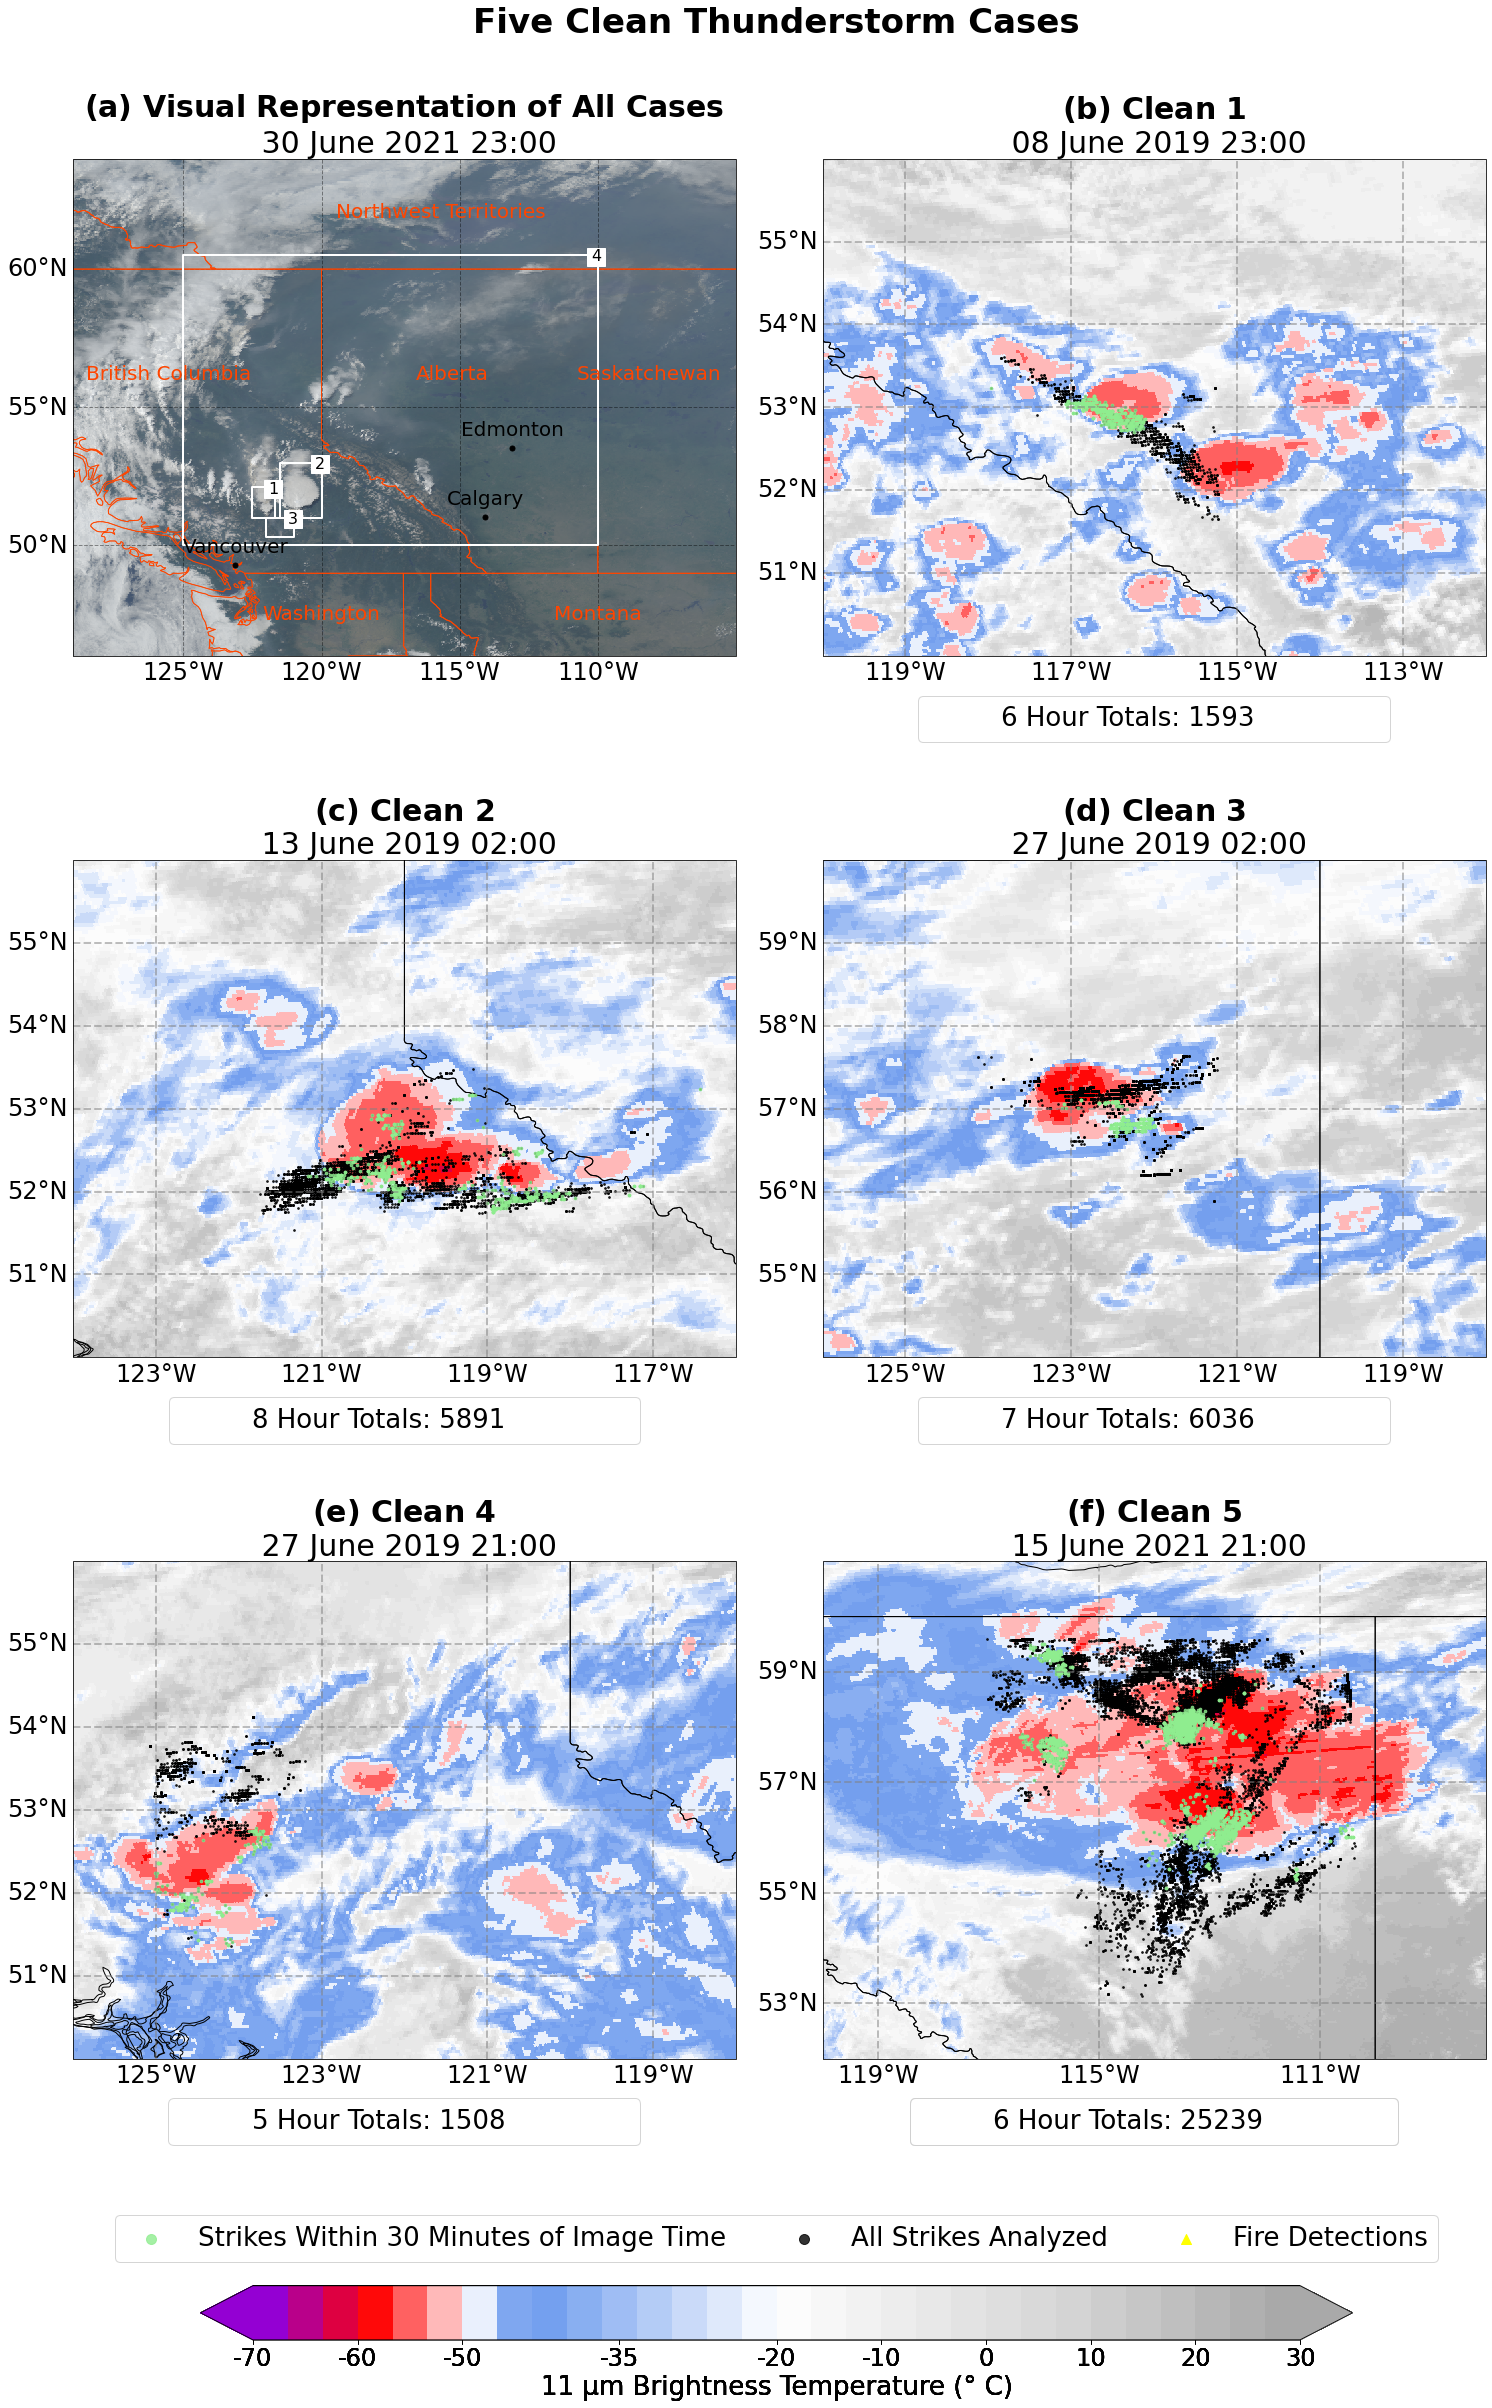

In [199]:
fig = plt.figure(figsize=(20, 30)) #width height


FILE = "/data2/edworak/data/PyroCb/MCMIPF1/OR_ABI-L2-MCMIPF-M6_G17_s20211812300319_e20211812309397_c20211812309542.nc"

goes_data = xarray.open_dataset(FILE)
goes_string = str(goes_data)
R = goes_data['CMI_C02'][:]
G = goes_data['CMI_C03'][:]
B = goes_data['CMI_C01'][:]
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)
G_true = 0.45 * R + 0.1 * G + 0.45 * B
G_true = np.clip(G_true, 0, 1)  
RGB = np.dstack([R, G_true, B])
dat = goes_data.metpy.parse_cf('CMI_C01')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y
    
pc = ccrs.PlateCarree()
ax = plt.subplot2grid(shape = (3,4), loc = (0,0), colspan=2, projection = pc)
# ax.set_extent([-135, -95, 40, 70], crs=pc)
ax.set_extent([-129, -105, 46, 64], crs=pc)

# 8 x 6 - 24 x 18
im = ax.imshow(RGB, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')

## gridlines 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=1, color='black', alpha=0.4, linestyle='--', zorder=0)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True 
gl.xlocator = mticker.FixedLocator([-125, -120, -115, -110])
gl.ylocator = mticker.FixedLocator([45, 50, 55, 60, 65])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} 

## cartopy features 
ax.coastlines(resolution='50m', color='orangered', linewidth=0.5)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1, edgecolor = "orangered")

# Define Shapely geometry boxes
geoms = [
    box(minx=-122.5, maxx=-121.7, miny=51, maxy=52.1),
    box(minx=-121.5, maxx=-120, miny=51, maxy=53),
    box(minx=-122, maxx=-121, miny=50.3, maxy=51),
    box(minx=-125, maxx=-110, miny=50, maxy=60.5)]


# Plot each Shapely geometry box
for i, geom in enumerate(geoms, start=1):
    ax.add_geometries([geom], ccrs.PlateCarree(), edgecolor='white', linewidth = 2, facecolor='none', label=f'geom{i}', zorder=1)
    centroid = geom.centroid
    y_offset = 0.05
#   ax.text(centroid.x + x_offset, centroid.y + y_offset, str(i), transform=ccrs.PlateCarree(), color = "white", fontsize=12, ha='center', va='center')
    x_offset = 0.05  # Adjust this offset as needed
    x_text = geom.bounds[2] - x_offset
    y_text = geom.bounds[3] - x_offset
    # Set text x location to maxx of the box
    # Plot text with outline
    #outline_text = ax.text(x_text, centroid.y + y_offset, str(i), transform=ccrs.PlateCarree(), fontsize=12, ha='right', va='center', zorder=2, color='white')
    # Plot text with center color
    ax.plot(x_text, y_text, markersize = 18, marker = 's', color = 'white')
    center_text = ax.text(x_text, y_text, str(i), transform=ccrs.PlateCarree(), fontsize=16, ha='center', va='center', zorder=2, color='black')

## add in city labels 
cities = {
    'Vancouver': (-123.1207, 49.2827),
    'Calgary': (-114.0719, 51.0447),
    #'Salt Lake City': (-112.181780, 40.687574), 
    #'Boise': (-116.208110, 43.558496), 
    #'Portland': (-122.612122, 45.512328), 
    #'Seattle': (-122.299357, 47.608799), 
    #'Bozeman': (-111.036325, 45.667231), 
    'Calgary': (-114.082647, 51.013005), 
    'Edmonton': (-113.106757, 53.513627)}

for city, (lon, lat) in cities.items():
    ax.text(lon, lat + 0.3, city, transform=ccrs.PlateCarree(), fontsize=20, ha='center', va = "bottom") #, va='center'
    ax.plot(lon, lat, color = "black", marker = "o", markersize = 5) 

provinces = {
    'British Columbia': (-125.532648, 56.195784),
    'Alberta': (-115.273571, 56.195784),
    'Saskatchewan': (-108.147403, 56.195784), 
    #'Yukon': (-132.004522, 62.066182), 
    'Northwest Territories': (-115.685378, 62.066182),
    'Washington':(-120, 47.5), 
    'Montana': (-110, 47.5)} 
    #'North Dakota': (-100.5, 47.5)}

for province, (lon, lat) in provinces.items():
    ax.text(lon, lat, province, transform=ccrs.PlateCarree(), fontsize=20,ha='center', va='center', color = "orangered")
    
    
scan_start = datetime.strptime(goes_data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
ax.set_title('Satellite Image: {}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 30) #loc='right'

hour = int(scan_start.strftime('%H'))
minute = int(scan_start.strftime('%M'))

#ax.set_title('Visual Representation of All Cases', fontsize=30)
ax.set_title(r"$\bf{" + "(a) \ Visual \ Representation \ of \ All \ Cases" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 30) #loc='right'

#----------------------------------------------------------------------------------------------------
# clean case 1 : june 8 hour 23 (159)
FILE = "/data2/edworak/data/br_temp_2019/201915923/OR_ABI-L2-MCMIPF-M6_G17_s20191592300339_e20191592309406_c20191592309476.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"
dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

pc = ccrs.PlateCarree()
ax1 = plt.subplot2grid(shape = (3,4), loc = (0,2), colspan=2, projection = pc)
ax1.set_extent([-120, -112, 50, 56], crs=pc)
ax1.coastlines(resolution='50m', color='black', linewidth=1.0)
ax1.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)
scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -119,  -117, -115, -113])
gl.ylocator = mticker.FixedLocator([51, 52, 53, 54, 55])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} 

im = ax1.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

points = lt_plx_clean1
#points_all = lt_plx_clean1
ax1.scatter(x = points["tlon"], y = points["tlat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean1.loc[((lt_plx_clean1.hour == 22) & (lt_plx_clean1.minute >= 30)) | ((lt_plx_clean1.hour == 23) & (lt_plx_clean1.minute <= 30))]
#pointshour_all = lt_plx_clean1.loc[((lt_plx_clean1.hour == 22) & (lt_plx_clean1.minute >= 30)) | ((lt_plx_clean1.hour == 10) & (lt_plx_smoke.minute <= 30))]
ax1.scatter(x = pointshour["tlon"], y = pointshour["tlat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)


titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="6 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
ax1.legend(handles=[titlepatch, blank], loc='lower center', 
            bbox_to_anchor=(0.5, -0.2),
            ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)        

# fires1_lat = [55.3367]
# fires1_lon = [-117.2902]
# ax1.scatter(x = fires1_lon, y = fires1_lat, s = 100, color='red',  marker = "o")# linewidths=0.5, facecolors='none', edgecolors='orangered'


#######################
# overlay viirs fires

viirs_path = '/data2/edworak/data/viirs_snpp_nrl_20190101_20191231.nc'
# the code will pull the fire pixels from 24 hours before this time:

plot_day = 159
plot_hour = 23
plot_minute = 0

viirs_data = nc.Dataset(viirs_path)
viirs_lat = viirs_data['median_lat'][:]
viirs_lon = viirs_data['median_lon'][:]
viirs_time = viirs_data['time'][:]  
viirs_frp = viirs_data['total_frp'][:]

viirs_h = 6+viirs_time.data
plot_time = (plot_day*24) + plot_hour + (plot_minute/60.)
dt = viirs_h - plot_time
fires_within_24h = np.where(np.logical_and((dt < 0), (dt > -24)))

plt.scatter(viirs_lon[fires_within_24h[0]].data, viirs_lat[fires_within_24h[0]].data, c='yellow',s=100,marker="^",transform=ccrs.PlateCarree(),  label = "Fire Detections")

#################

cax = plt.axes([0.1, -0.08, 0.8, 0.025])
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5,  cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax1.set_title(r"$\bf{" + "(b) \ Clean \ 1" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 30) #loc='right'

# ------------------------------------------------------------------------------------------------------


# clean case 2 : june 13 hour 2 (164)
FILE = "/data2/edworak/data/br_temp_2019/201916402/OR_ABI-L2-MCMIPF-M6_G17_s20191640200339_e20191640209412_c20191640209480.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]

#plot with celsius 
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"

dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

ax2 = plt.subplot2grid((3,4), (1,0), colspan=2, projection = pc)
ax2.set_extent([-124, -116, 50, 56], crs=pc)
ax2.set_xlabel("Lightning Strike Totals", fontsize = 20)

ax2.coastlines(resolution='50m', color='black', linewidth=1.0)
ax2.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax2.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -123,  -121,  -119, -117, -115])
gl.ylocator = mticker.FixedLocator([51, 52, 53, 54, 55])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} #, 'weight': 'bold'

im = ax2.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

points = lt_plx_clean2
#points_all = lt_plx_clean2
ax2.scatter(x = points["tlon"], y = points["tlat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean2.loc[((lt_plx_clean2.hour == 1) & (lt_plx_clean2.minute >= 30)) | ((lt_plx_clean2.hour == 3) & (lt_plx_clean2.minute <= 30))]
#pointshour_all = lt_plx_clean2.loc[(lt_plx_clean2.hour == 2)]
ax2.scatter(x = pointshour["tlon"], y = pointshour["tlat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)


titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="8 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
ax2.legend(handles=[titlepatch, blank], loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
           ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)        


# ax2.legend(handles=[titlepatch, patch3, patch4, blank, patch5, blank], loc='lower center', 
#             bbox_to_anchor=(0.5, -0.4),
#             ncol=2, fancybox=True, shadow=False, fontsize = 20, markerscale=3.,)


#######################
# overlay viirs fires
viirs_path = '/data2/edworak/data/viirs_snpp_nrl_20190101_20191231.nc'

# the code will pull the fire pixels from 24 hours before this time:

plot_day = 164
plot_hour = 2
plot_minute = 0

viirs_data = nc.Dataset(viirs_path)
viirs_lat = viirs_data['median_lat'][:]
viirs_lon = viirs_data['median_lon'][:]
viirs_time = viirs_data['time'][:]  
viirs_frp = viirs_data['total_frp'][:]

viirs_h = 6+viirs_time.data
plot_time = (plot_day*24) + plot_hour + (plot_minute/60.)
dt = viirs_h - plot_time
fires_within_24h = np.where(np.logical_and((dt < 0), (dt > -24)))

plt.scatter(viirs_lon[fires_within_24h[0]].data, viirs_lat[fires_within_24h[0]].data, c='yellow',s=100,marker="^",transform=ccrs.PlateCarree(),  label = "Fire Detections")

#################


cax = plt.axes([0.1, -0.08, 0.8, 0.025])
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax2.set_title(r"$\bf{" + "(c) \ Clean \ 2" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 30) #loc='right'

# ------------------------------------------------------------------------------------------------------

# clean case 3: june 27 2 UTC (178)
FILE = "/data2/edworak/data/br_temp_2019/201917802/OR_ABI-L2-MCMIPF-M6_G17_s20191780200339_e20191780209406_c20191780209494.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"
dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

ax3 = plt.subplot2grid((3,4), (1,2), colspan=2, projection = pc)
ax3.set_extent([-126, -118, 54, 60], crs=pc)

ax3.coastlines(resolution='50m', color='black', linewidth=1.0)
ax3.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)
scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
#plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 22) #loc='right'

gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True        
gl.xlocator = mticker.FixedLocator([ -125, -123, -121, -119])
gl.ylocator = mticker.FixedLocator([55, 56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} #, 'weight': 'bold'

im = ax3.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

points = lt_plx_clean3
#points_all = lt_plx_clean3
ax3.scatter(x = points["tlon"], y = points["tlat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean3.loc[((lt_plx_clean3.hour == 2) & (lt_plx_clean3.minute >= 30)) | ((lt_plx_clean3.hour == 3) & (lt_plx_clean3.minute <= 30))]
#pointshour_all = lt_plx_clean3.loc[(lt_plx_clean3.hour == 2)]
ax3.scatter(x = pointshour["tlon"], y = pointshour["tlat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)

titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="7 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
ax3.legend(handles=[titlepatch, blank], loc='lower center', 
            bbox_to_anchor=(0.5, -0.2),
            ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)        

# fires3_lat = [57.5811]
# fires3_lon = [-117.1056] 
# ax3.scatter(x = fires3_lon, y = fires3_lat, s = 100, color='darkred',  marker = "o",  label = "Fire Detections")# linewidths=0.5, facecolors='none', edgecolors='orangered'


#######################
# overlay viirs fires
viirs_path = '/data2/edworak/data/viirs_snpp_nrl_20190101_20191231.nc'

# the code will pull the fire pixels from 24 hours before this time:

plot_day = 178
plot_hour = 2
plot_minute = 0

viirs_data = nc.Dataset(viirs_path)
viirs_lat = viirs_data['median_lat'][:]
viirs_lon = viirs_data['median_lon'][:]
viirs_time = viirs_data['time'][:]  
viirs_frp = viirs_data['total_frp'][:]

viirs_h = 6+viirs_time.data
plot_time = (plot_day*24) + plot_hour + (plot_minute/60.)
dt = viirs_h - plot_time
fires_within_24h = np.where(np.logical_and((dt < 0), (dt > -24)))

plt.scatter(viirs_lon[fires_within_24h[0]].data, viirs_lat[fires_within_24h[0]].data, c='yellow',s=100,marker="^",transform=ccrs.PlateCarree(),  label = "Fire Detections")

#################


# [left, bottom, width, height]
cax = plt.axes([0.1, -0.08, 0.8, 0.025])

cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax3.set_title(r"$\bf{" + "(d) \ Clean \ 3" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 30) #loc='right'

# ------------------------------------------------------------------------------------------------------

# clean case 4: June 27 20 UTC (178)
FILE = "/data2/edworak/data/br_temp_2019/201917821/OR_ABI-L2-MCMIPF-M6_G17_s20191782100341_e20191782109419_c20191782109475.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]

#plot with celsius 
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"

dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

ax4 = plt.subplot2grid((3,4), (2,0), colspan=2, projection = pc)
ax4.set_extent([-126, -118, 50, 56], crs=pc)

ax4.coastlines(resolution='50m', color='black', linewidth=1.0)
ax4.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
#plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 22) #loc='right'

gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True        
gl.xlocator = mticker.FixedLocator([ -125, -123, -121, -119])
gl.ylocator = mticker.FixedLocator([51, 52, 53, 54, 55])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} #, 'weight': 'bold'

im = ax4.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

points = lt_plx_clean4
#points_all = lt_plx_clean4
ax4.scatter(x = points["tlon"], y = points["tlat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean4.loc[((lt_plx_clean4.hour == 20) & (lt_plx_clean4.minute >= 30)) | ((lt_plx_clean4.hour == 21) & (lt_plx_clean4.minute <= 30))]
#pointshour_all = lt_plx_clean4.loc[(lt_plx_clean4.hour == 21)]
ax4.scatter(x = pointshour["tlon"], y = pointshour["tlat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)

titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="5 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
hourpatch = mpatches.Patch(facecolor='lightgreen', edgecolor = "grey", label="1 Hour Totals".format(str(len(pointshour))))
ax4.legend(handles=[titlepatch, blank], loc='lower center', 
            bbox_to_anchor=(0.5, -0.2),
            ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)


#######################
# overlay viirs fires

viirs_path = '/data2/edworak/data/viirs_snpp_nrl_20190101_20191231.nc'
# the code will pull the fire pixels from 24 hours before this time:

plot_day = 178
plot_hour = 21
plot_minute = 0

viirs_data = nc.Dataset(viirs_path)
viirs_lat = viirs_data['median_lat'][:]
viirs_lon = viirs_data['median_lon'][:]
viirs_time = viirs_data['time'][:]  
viirs_frp = viirs_data['total_frp'][:]

viirs_h = 6+viirs_time.data
plot_time = (plot_day*24) + plot_hour + (plot_minute/60.)
dt = viirs_h - plot_time
fires_within_24h = np.where(np.logical_and((dt < 0), (dt > -24)))

plt.scatter(viirs_lon[fires_within_24h[0]].data, viirs_lat[fires_within_24h[0]].data, c='yellow',s=100,marker="^",transform=ccrs.PlateCarree(),  label = "Fire Detections")

#################


# [left, bottom, width, height]
cax = plt.axes([0.1, -0.08, 0.8, 0.025])
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax4.set_title(r"$\bf{" + "(e) \ Clean \ 4" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 30) #loc='right'


# ------------------------------------------------------------------------------------------------------

# clean case 5: june 15 21 UTC (166)
FILE = "/data2/edworak/data/BT_nosmoke/202116621/OR_ABI-L2-MCMIPF-M6_G17_s20211662100321_e20211662109388_c20211662109542.nc"
data = xarray.open_dataset(FILE)
goes_string = str(data)
goes_data = data['CMI_C14'][:]

#plot with celsius 
data_celsius = goes_data - 273.15
data_celsius.attrs["units"] = "kelvin"

dat = data.metpy.parse_cf('CMI_C14')
geos = dat.metpy.cartopy_crs    
x = dat.x
y = dat.y

ax5 = plt.subplot2grid((3,4), (2,2), colspan=2, projection = pc)
ax5.set_extent([-120, -108, 52, 61], crs=pc)

ax5.coastlines(resolution='50m', color='black', linewidth=1.0)
ax5.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
# plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 22) #loc='right'

gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=2, color='grey', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = True        
gl.xlocator = mticker.FixedLocator([- 119, -115, -111, -107])
gl.ylocator = mticker.FixedLocator([53, 55, 57, 59])

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'black'}
gl.ylabel_style = {'size': 24, 'color': 'black'} #, 'weight': 'bold'

im = ax5.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
points = lt_plx_clean5
#points_all = lt_plx_clean5
ax5.scatter(x = points["tlon"], y = points["tlat"], s = 3, color = "black", marker = "o", alpha = 0.8)

pointshour = lt_plx_clean5.loc[((lt_plx_clean5.hour == 20) & (lt_plx_clean5.minute >= 30)) | ((lt_plx_clean5.hour == 21) & (lt_plx_clean5.minute <= 30))]
#pointshour_all = lt_plx_clean5.loc[(lt_plx_clean5.hour == 21)]
ax5.scatter(x = pointshour["tlon"], y = pointshour["tlat"], s = 7, color = "lightgreen", marker = "o", alpha = 0.8)

nopoints = lt_plx_clean5.loc[(lt_plx_clean5.hour == 2) & (lt_plx_clean5.hour == 3)]
ax5.scatter(x = nopoints["tlon"], y = nopoints["tlat"], s = 100, color = "lightgreen", marker = "o", alpha = 0.8,  label = "Strikes Within 30 Minutes of Image Time")
ax5.scatter(x = nopoints["tlon"], y = nopoints["tlat"], s = 100, color = "black", marker = "o", alpha = 0.8,  label = "All Strikes Analyzed")
#ax5.scatter(x = nopoints["lon"], y = nopoints["lat"], s = 100, color = "red", marker = "o", alpha = 0.8,  label = "Fire Location")



#######################
# overlay viirs fires

viirs_path = '/data2/edworak/data/viirs_snpp_nrl_20210101_20211231.nc'
# the code will pull the fire pixels from 24 hours before this time:

plot_day = 166
plot_hour = 21
plot_minute = 0

viirs_data = nc.Dataset(viirs_path)
viirs_lat = viirs_data['median_lat'][:]
viirs_lon = viirs_data['median_lon'][:]
viirs_time = viirs_data['time'][:]  
viirs_frp = viirs_data['total_frp'][:]

viirs_h = 6+viirs_time.data
plot_time = (plot_day*24) + plot_hour + (plot_minute/60.)
dt = viirs_h - plot_time
fires_within_24h = np.where(np.logical_and((dt < 0), (dt > -24)))

plt.scatter(viirs_lon[fires_within_24h[0]].data, viirs_lat[fires_within_24h[0]].data, c='yellow',s=100,marker="^",transform=ccrs.PlateCarree(),  label = "Fire Detections")

#################
fire_lat = [65]
fire_lon = [-135]
ax.scatter(x = fire_lon, y = fire_lat, s = 140, color='yellow',  marker = "^",  label = "Fire Detections")# linewidths=0.5, facecolors='none', edgecolors='orangered'


titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="6 Hour Totals: {}".format(str(len(points))))
blank = mpatches.Patch(facecolor='white', edgecolor = "white")
hourpatch = mpatches.Patch(facecolor='lightgreen', edgecolor = "grey", label="1 Hour Totals".format(str(len(pointshour))))
firstlegend =  ax5.legend(handles=[titlepatch, blank], loc='lower center', 
            bbox_to_anchor=(0.5, -0.2),
            ncol=2, fancybox=True, shadow=False, fontsize = 26, markerscale=3.,)
ax5.add_artist(firstlegend)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), fontsize = 26, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol = 3)

# [left, bottom, width, height]
cax = plt.axes([0.1, -0.08, 0.8, 0.025])
cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
for t in cbar.ax.get_xticklabels():
        t.set_fontsize(24)
cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 26)
im.set_clim(-70, 30) 
cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 

ax5.set_title(r"$\bf{" + "(f) \ Clean \ 5" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 30) #loc='right'


# ------------------------------------------------------------------------------------------------------
plt.suptitle("Five Clean Thunderstorm Cases", x = 0.5, y = 1, fontweight='bold', fontsize=34)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.3)

plt.savefig("clean_canada_maps_final", bbox_inches = "tight", dpi = 600)
plt.show()


## statistics

### peak current 

In [ ]:
print("Overall Mean: {:.3f} kA".format(np.mean(clean_neg_ground_flat)))
print("Overall Mean: {:.3f} kA".format(np.mean(clean_pos_ground_flat)))

print("Mean: {:.3f} kA".format(np.mean(clean1_neg_ground_flat)))
print("Mean: {:.3f} kA".format(np.mean(clean1_pos_ground_flat)))

print("Mean: {:.3f} kA".format(np.mean(clean2_neg_ground_flat)))
print("Mean: {:.3f} kA".format(np.mean(clean2_pos_ground_flat)))

print("Mean: {:.3f} kA".format(np.mean(clean3_neg_ground_flat)))
print("Mean: {:.3f} kA".format(np.mean(clean3_pos_ground_flat)))

print("Mean: {:.3f} kA".format(np.mean(clean4_neg_ground_flat)))
print("Mean: {:.3f} kA".format(np.mean(clean4_pos_ground_flat)))

print("Mean: {:.3f} kA".format(np.mean(clean5_neg_ground_flat)))
print("Mean: {:.3f} kA".format(np.mean(clean5_pos_ground_flat)))

In [ ]:
(np.mean(clean1_neg_ground_flat) + np.mean(clean2_neg_ground_flat) + np.mean(clean3_neg_ground_flat) + np.mean(clean4_neg_ground_flat) + np.mean(clean5_neg_ground_flat)) / 5
(np.mean(clean1_pos_ground_flat) + np.mean(clean2_pos_ground_flat) + np.mean(clean3_pos_ground_flat) + np.mean(clean4_pos_ground_flat) + np.mean(clean5_pos_ground_flat)) / 5

In [ ]:
from tabulate import tabulate
table = [['polarity', 'clean 1', 'clean 2', 'clean 3', 'clean 4', 'clean 5', 'average', 'weighted average'], 
         ['negative', -25.302, -14.200, -27.783, -26.707, -21.924, -21.533, -23.183], 
         ['positive', 30.108, 39.544, 15.355, 47.710, 14.306, 16.176, 29.405]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

### percent positive 

In [ ]:
print("overall mean: {:.3f}%".format(np.mean(d8["percent_pos_current_cloud_ground_clean"])))

print("{:.3f}%".format(np.mean(d3["percent_pos_current_cloud_ground_clean1"])))

print("{:.3f}%".format(np.mean(d4["percent_pos_current_cloud_ground_clean2"])))

print("{:.3f}%".format(np.mean(d5["percent_pos_current_cloud_ground_clean3"])))

print("{:.3f}%".format(np.mean(d6["percent_pos_current_cloud_ground_clean4"])))

print("{:.3f}%".format(np.mean(d7["percent_pos_current_cloud_ground_clean5"])))

(np.mean(d3["percent_pos_current_cloud_ground_clean1"]) + np.mean(d4["percent_pos_current_cloud_ground_clean2"]) + np.mean(d5["percent_pos_current_cloud_ground_clean3"]) + np.mean(d6["percent_pos_current_cloud_ground_clean4"]) + np.mean(d7["percent_pos_current_cloud_ground_clean5"])) / 5

### CC : CG

In [ ]:
print('Clean: {:.3f} CC : 1 CG'.format(len(clean_cloud_flat) / (len(clean_pos_ground_flat) + len(clean_neg_ground_flat))))

print('Clean 1: {} CC : 1 CG'.format(len(clean1_cloud_flat) / (len(clean1_pos_ground_flat) + len(clean1_neg_ground_flat))))
print('Clean 2: {} CC : 1 CG'.format(len(clean2_cloud_flat) / (len(clean2_pos_ground_flat) + len(clean2_neg_ground_flat))))
print('Clean 3: {} CC : 1 CG'.format(len(clean3_cloud_flat) / (len(clean3_pos_ground_flat) + len(clean3_neg_ground_flat))))
print('Clean 4: {} CC : 1 CG'.format(len(clean4_cloud_flat) / (len(clean4_pos_ground_flat) + len(clean4_neg_ground_flat))))
print('Clean 5: {} CC : 1 CG'.format(len(clean5_cloud_flat) / (len(clean5_pos_ground_flat) + len(clean5_neg_ground_flat))))

(2.5165562913907285 + 1.4074376787903555 + 2.7144615384615385 + 3.345821325648415 + 0.1412004069175992)/ 5

# Figure 1

In [ ]:
# these strike counts are for the whole region not selected by anything 
def pyrocb_subregion_box(ax, subregion):
    geom1 = geometry.box(minx=-121.5,maxx=-120,miny=51,maxy=53)
    point1 = Point(-120.8,  51)
    ax.add_geometries([point1], ccrs.PlateCarree(), alpha=1, facecolor = "red", edgecolor='red', linewidth = 5)
    ax.add_geometries([geom1], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='green', linewidth = 4)
    return ax
#pyrocb_count = len(data_june30.loc[(data_june30.lon > -121.5) & (data_june30.lon < -120) & (data_june30.lat > 51) & (data_june30.lat < 53)])
#print(pyrocb_count)

def mckay_subregion_box(ax, subregion):
    geom2 = geometry.box(minx=-122.5,maxx=-121.7,miny=51,maxy=52.1)
    ax.add_geometries([geom2], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='brown', linewidth = 4)
    point2 = Point(-121.9, 51)
    ax.add_geometries([point2], ccrs.PlateCarree(), alpha=1, facecolor = "red", edgecolor='red', linewidth = 5)
    return ax

# mckay_count = len(data_june30.loc[(data_june30.lon >= -122.5) & (data_june30.lon <= -121.7) & (data_june30.lat >= 51) & (data_june30.lat <= 52.1)])
# print(mckay_count)

def lytton_subregion_box(ax, subregion):
    geom3 = geometry.box(minx=-122,maxx=-121,miny=50.3,maxy=51)
    ax.add_geometries([geom3], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='darkorange', linewidth = 4)
    point3 = Point(-121.5, 50.3)
    ax.add_geometries([point3], ccrs.PlateCarree(), alpha=1, facecolor = "red", edgecolor='red',linewidth = 5)
    return ax
# lytton_count = len(data_july1.loc[(data_july1.lon > -122) & (data_july1.lon < -121) & (data_july1.lat > 50.3) & (data_july1.lat < 50.8)])
# print(lytton_count)


In [ ]:
colormap = LinearSegmentedColormap.from_list('custom', 
                                        [(0, "darkviolet"), 
                                        (0.1, "red"), 
                                        (0.2, "white"),
                                        (0.25, "cornflowerblue"), 
                                        (0.5, 'white'),
                                        (0.8, 'lightgrey'), 
                                        (1.0, 'darkgrey')
                                        ], N=30)

In [ ]:
fig = plt.figure(figsize=(16, 16))

for i in range(1, 2, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_pyrocb_early/' + folder_names_pyrocbearly[i] + '/'
        FILE = path + file_names_pyrocbearly[i][j]
        data = xarray.open_dataset(FILE)
        
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y

        pc = ccrs.PlateCarree()
        ax = fig.add_subplot(2, 2, 1, projection=pc)
        ax.set_extent([-124.5, -118.5, 50, 54], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-124, -123, -122, -121, -120, -119])
        gl.ylocator = mticker.FixedLocator([50.5, 51, 51.5, 52, 52.5, 53, 53.5])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} 
        
#         ax.tick_params(axis='x', colors='black', direction='out', length=13, width=0)
#         ax.tick_params(axis='y', colors='black', direction='out', length=13, width=0)


        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        
        points = data_split2

        pyrocb_subregion_box(ax, points)
        mckay_subregion_box(ax, points)
        
        lightning_count = len(data_split2.loc[(data_split2.lat >= 50) & (data_split2.lat <= 54) & (data_split2.lon >= -123) & (data_split2.lon <= -119.5)])
        patch1_count = len(data_split2.loc[(data_split2.lat >= 51) & (data_split2.lat <= 52.1) & (data_split2.lon >= -122.5) & (data_split2.lon <= -121.7)])
        patch2_count = len(data_split2.loc[(data_split2.lat >= 51) & (data_split2.lat <= 53) & (data_split2.lon >= -121.5) & (data_split2.lon <= -120.0)])
        
        titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="5 Hour Totals: {} (0)".format(str(lightning_count)))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")
        patch1 = mpatches.Patch(facecolor='brown', edgecolor = "grey", label=("pyroCb MC1: {} (0)".format(str(patch1_count))))
        patch2 = mpatches.Patch(facecolor='green', edgecolor = "grey", label=("pyroCb SL1: {} (0)".format(str(patch2_count))))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")

        ax.legend(handles=[titlepatch, patch1, blank, patch2], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.3),
                    ncol=2, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)      
        
        fire_lat = [50.953, 50.202, 50.951]
        fire_lon = [-122.071, -121.649, -120.964]
        ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='yellow',  marker = "^",  label = "Fire Locations")# linewidths=0.5, facecolors='none', edgecolors='orangered'

        cax = plt.axes([0.1, -0.05, 0.8, 0.025])
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5,  cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
 
        ax.set_title(r"$\bf{" + "(a) \ Day \ 1 \ PyroCb \ Events" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

# ------------------------------------------------------------------------------------------------------

for i in range(21, 22, 1):

        path = '/data2/edworak/data/PyroCb/MCMIPF1/'
        FILE = path + file_names_pyrocb[i]

        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y

        pc = ccrs.PlateCarree()

        ax = fig.add_subplot(2, 2, 2, projection=pc)
        ax.set_extent([-124.5, -118.5, 50, 54], crs=pc)
        ax.set_xlabel("Lightning Strike Totals", fontsize = 16)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
        ax.set_axisbelow(True)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-124, -123,  -122,  -121,  -120, -119])
        gl.ylocator = mticker.FixedLocator([50.5, 51, 51.5, 52, 52.5, 53, 53.5])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        
        points = correct_pyrocb.loc[(correct_pyrocb.CMI_C14 <= -50)]
        ax.scatter(x = points["tlon"], y = points["tlat"], s = 1, color = "black", marker = "o", alpha = 0.8)
        
        pointshour = correct_pyrocb.loc[(correct_pyrocb.CMI_C14 <= -50) & (correct_pyrocb.hour == 2)]
        ax.scatter(x = pointshour["tlon"], y = pointshour["tlat"], s = 3, color = "lightgreen", marker = "o", alpha = 0.8)
        
        pyrocb_subregion_box(ax, points)
        mckay_subregion_box(ax, points)
        lytton_subregion_box(ax, points)
       
        patch3_count1 = len(data_split2.loc[(data_split2.lat >= 51) & (data_split2.lat <= 52.1) & (data_split2.lon >= -122.5) 
                                   & (data_split2.lon <= -121.7) & (data_split2.month == 6) & (data_split2.day == 30)& (data_split2.hour == 23)])
        patch3_count2 = len(data_split2.loc[(data_split2.lat >= 51) & (data_split2.lat <= 52.1) & (data_split2.lon >= -122.5) 
                                   & (data_split2.lon <= -121.7) & (data_split2.month == 7) & (data_split2.day == 1)& (data_split2.hour <= 3)])
        patch3_count = patch3_count1 + patch3_count2
        patch4_count = len(correct_pyrocb)
        patch4_bt_count = len(points)
        patch5_count1 = len(data_split2.loc[(data_split2.lat >= 50.3) & (data_split2.lat <= 51) & (data_split2.lon >= -122) 
                                   & (data_split2.lon <= -121)& (data_split2.month == 6) & (data_split2.day == 30)& (data_split2.hour == 23)])
        patch5_count2 = len(data_split2.loc[(data_split2.lat >= 50.3) & (data_split2.lat <= 51) & (data_split2.lon >= -122) 
                                   & (data_split2.lon <= -121) & (data_split2.month == 7) & (data_split2.day == 1)& (data_split2.hour <= 3)])
        patch5_count = patch5_count1 + patch5_count2
        
        lightning_count = len(correct_pyrocb) + patch3_count
        lightning_bt_count = len(points)
    
    
    
        titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="5 Hour Totals: {} ({})".format(str(lightning_count), str(lightning_bt_count)))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")
        patch3 = mpatches.Patch(facecolor='brown', edgecolor = "grey", label=("pyroCb MC2: {} (0)".format(str(patch3_count))))
        patch4 = mpatches.Patch(facecolor='green', edgecolor = "grey", label=("pyroCb SL2: {} ({})".format(str(patch4_count), str(patch4_bt_count))))
        patch5 = mpatches.Patch(facecolor='darkorange', edgecolor = "grey", label=("pyroCb LT2: {} (0)".format(str(patch5_count))))
        
        
        ax.legend(handles=[titlepatch, patch3, patch4, blank, patch5, blank], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.4),
                    ncol=2, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)

        fire_lat = [51.012, 50.262, 51.026]
        fire_lon = [-121.932, -121.502, -120.754]
        ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='yellow',  marker = "^",  label = "Fire Locations")# linewidths=0.5, facecolors='none', edgecolors='orangered'
        
        ax.set_title(r"$\bf{" + "(b) \ Day \ 2 \ PyroCb \ Events" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 20) #loc='right'

        cax = plt.axes([0.1, -0.05, 0.8, 0.025])
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
        
# ------------------------------------------------------------------------------------------------------
    
for i in range(3, 4, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_nosmoke/' + folder_names_clean5[i] + '/'
        FILE = path + file_names_clean5[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y

        pc = ccrs.PlateCarree()

        ax = fig.add_subplot(2, 2, 3, projection=pc)
        ax.set_extent([-120, -105, 52, 62], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True        
        gl.xlocator = mticker.FixedLocator([-118,  -116,  -114,  -112,  -110, -108, -106])
        gl.ylocator = mticker.FixedLocator([52.5, 54, 55.5, 57, 58.5, 60, 61.5])

        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)

        points = lt_plx_clean5.loc[(lt_plx_clean5.CMI_C14 <= -50) & (lt_plx_clean5.hour >= 18) & (lt_plx_clean5.hour <= 23)]
        points_all = lt_plx_clean5.loc[(lt_plx_clean5.hour >= 18) & (lt_plx_clean5.hour <= 23)]

        ax.scatter(x = points["tlon"], y = points["tlat"], s = 1, color = "black", marker = "o", alpha = 0.8)
        
        pointshour = lt_plx_clean5.loc[(lt_plx_clean5.CMI_C14 <= -50) & (lt_plx_clean5.hour == 21)]
        pointshour_all = lt_plx_clean5.loc[(lt_plx_clean5.hour == 21)]
        ax.scatter(x = pointshour["tlon"], y = pointshour["tlat"], s = 3, color = "lightgreen", marker = "o", alpha = 0.8)
        
        titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="6 Hour Totals: {} ({})".format(str(len(points_all)), str(len(points))))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")
        ax.legend(handles=[titlepatch, blank], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.2),
                    ncol=2, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)        
        
        fire_lat = [54.872]
        fire_lon = [-106.672]
        ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='yellow',  marker = "^",  label = "Fire Locations")# linewidths=0.5, facecolors='none', edgecolors='orangered'
    
       # tstorm_subregion_box(ax, im)
       # [left, bottom, width, height]
        cax = plt.axes([0.1, -0.05, 0.8, 0.025])
        
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
 
        ax.set_title(r"$\bf{" + "(c) \ Clean \ Thunderstorm" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')),  fontsize = 20) #loc='right'

# ------------------------------------------------------------------------------------------------------
    
for i in range(2, 3, 1):
    for j in range(0,1,1):
        path = '/data2/edworak/data/BT_smoke/' + folder_names_smoke[i] + '/'
        FILE = path + file_names_smoke[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y

        pc = ccrs.PlateCarree()

        ax = fig.add_subplot(2, 2, 4, projection=pc)
        ax.set_extent([-125, -110, 54, 64], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True        
        gl.xlocator = mticker.FixedLocator([ -124,  -122,  -120,  -118, -116, -114, -112])
        gl.ylocator = mticker.FixedLocator([54.5, 56, 57.5, 59, 60.5, 62, 63.5])

        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = colormap) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        points = correct_smoke.loc[(correct_smoke.CMI_C14 <= -50) & (correct_smoke.hour >= 8) & (correct_smoke.hour <= 11)]
        points_all = correct_smoke.loc[(correct_smoke.hour >= 8) & (correct_smoke.hour <= 11)]

        ax.scatter(x = points["tlon"], y = points["tlat"], s = 1, color = "black", marker = "o", alpha = 0.8)
        
        pointshour = correct_smoke.loc[(correct_smoke.CMI_C14 <= -50) & (correct_smoke.hour == 10)]
        pointshour_all = correct_smoke.loc[(correct_smoke.hour == 10)]
        ax.scatter(x = pointshour["tlon"], y = pointshour["tlat"], s = 3, color = "lightgreen", marker = "o", alpha = 0.8)

        nopoints = data_split2.loc[(data_split2.hour == 2) & (data_split2.hour == 3)]
        ax.scatter(x = nopoints["lon"], y = nopoints["lat"], s = 80, color = "lightgreen", marker = "o", alpha = 0.8,  label = "Strikes Within 30 Minutes of Image Time")
        ax.scatter(x = nopoints["lon"], y = nopoints["lat"], s = 80, color = "black", marker = "o", alpha = 0.8,  label = "All Strikes Analyzed")

        titlepatch = mpatches.Patch(facecolor='white', edgecolor = "white", label="4 Hour Totals: {} ({})".format(str(len(points_all)), str(len(points))))
        blank = mpatches.Patch(facecolor='white', edgecolor = "white")
        hourpatch = mpatches.Patch(facecolor='lightgreen', edgecolor = "grey", label="Strikes Within 30 Minutes of Image Time".format(str(len(pointshour_all)), str(len(pointshour))))
        secondlegend =  ax.legend(handles=[titlepatch, blank], loc='lower center', 
                    bbox_to_anchor=(0.5, -0.2),
                    ncol=2, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)
        ax.add_artist(secondlegend)
        
        fire_lat = [61.715,  60.709, 57.514, 59.481]
        fire_lon = [-123.694, -125.289, -123.021, -120.533]
        ax.scatter(x = fire_lon, y = fire_lat, s = 80, color='yellow',  marker = "^",  label = "Fire Locations")# linewidths=0.5, facecolors='none', edgecolors='orangered'
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        fig.legend(by_label.values(), by_label.keys(), fontsize = 18, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol = 3)
        
        # [left, bottom, width, height]
        cax = plt.axes([0.1, -0.05, 0.8, 0.025])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = colormap, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(18)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
 
        ax.set_title(r"$\bf{" + "(d) \ Smoke-Filled \ Thunderstorm" + "}$" + "\n {}".format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

# ------------------------------------------------------------------------------------------------------
plt.suptitle("Four Types of Thunderstorms", x = 0.5, y = 0.95, fontweight='bold', fontsize=24)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.2) 
# wspace: the amount of width reserved for space between subplots
# hspace: the amount of height reserved for space between subplots

plt.savefig("figure1_final".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


# Percent Positive Timeseries 

## line plot

Text(0.5, 1.0, 'PyroCb Smoke % positive time series')

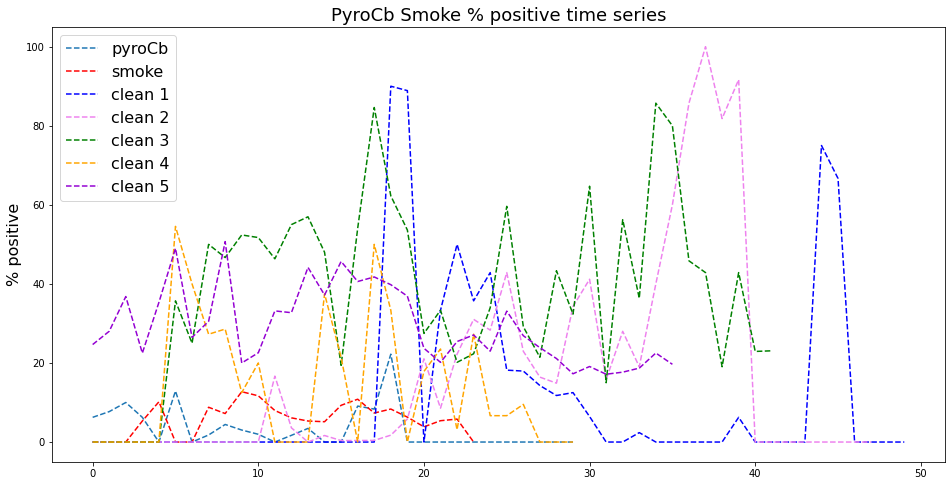

In [164]:
plt.figure(figsize=(16,8))
plt.plot(d1["percent_pos_current_cloud_ground_pyrocb"], linestyle = "--", label = "pyroCb")
plt.plot(d2["percent_pos_current_cloud_ground_smoke"], linestyle = "--", color = "red", label = "smoke")
plt.plot(d3["percent_pos_current_cloud_ground_clean1"][:50], linestyle = "--", color = "blue", label = "clean 1")
plt.plot(d4["percent_pos_current_cloud_ground_clean2"], linestyle = "--", color = "violet", label = "clean 2")
plt.plot(d5["percent_pos_current_cloud_ground_clean3"], linestyle = "--", color = "green", label = "clean 3")
plt.plot(d6["percent_pos_current_cloud_ground_clean4"], linestyle = "--", color = "orange", label = "clean 4")
plt.plot(d7["percent_pos_current_cloud_ground_clean5"], linestyle = "--", color = "darkviolet", label = "clean 5")

plt.legend(fontsize = 16)
plt.ylabel("% positive", fontsize = 16)
plt.title("PyroCb Smoke % positive time series", fontsize = 18)

## box and whiskers

In [165]:
pyrocbperpos = np.array(d1["percent_pos_current_cloud_ground_pyrocb"])
pyrocbperpos = pyrocbperpos[pyrocbperpos > 0]
print("pyrocb median {:.2f}, max {:.2f}".format(np.median(pyrocbperpos), np.max(pyrocbperpos)))

smokeperpos = np.array(d2["percent_pos_current_cloud_ground_smoke"])
smokeperpos = smokeperpos[smokeperpos > 0]
print("smoke median {:.2f}, max {:.2f}".format(np.median(smokeperpos), np.max(smokeperpos)))

clean1perpos = np.array(d3["percent_pos_current_cloud_ground_clean1"])
clean1perpos = clean1perpos[clean1perpos > 0]
print("clean 1 median {:.2f}, max {:.2f}".format(np.median(clean1perpos), np.max(clean1perpos)))

clean2perpos = np.array(d4["percent_pos_current_cloud_ground_clean2"])
clean2perpos = clean2perpos[clean2perpos > 0]
print("clean 2 median {:.2f}, max {:.2f}".format(np.median(clean2perpos), np.max(clean2perpos)))

clean3perpos = np.array(d5["percent_pos_current_cloud_ground_clean3"])
clean3perpos = clean3perpos[clean3perpos > 0]
print("clean 3 median {:.2f}, max {:.2f}".format(np.median(clean3perpos), np.max(clean3perpos)))

clean4perpos = np.array(d6["percent_pos_current_cloud_ground_clean4"])
clean4perpos = clean4perpos[clean4perpos > 0]
print("clean 4 median {:.2f}, max {:.2f}".format(np.median(clean4perpos), np.max(clean4perpos)))

clean5perpos = np.array(d7["percent_pos_current_cloud_ground_clean5"])
clean5perpos = clean5perpos[clean5perpos > 0]
print("clean 5 median {:.2f}, max {:.2f}".format(np.median(clean5perpos), np.max(clean5perpos)))



perpos = pd.concat([pd.Series(pyrocbperpos), pd.Series(smokeperpos), 
                          pd.Series(clean1perpos),pd.Series(clean2perpos),pd.Series(clean3perpos),
                          pd.Series(clean4perpos),pd.Series(clean5perpos)], axis = 0)
perpos
print(np.median(pyrocbperpos), np.median(smokeperpos), np.median(clean1perpos), np.median(clean2perpos), np.median(clean3perpos), np.median(clean4perpos), np.median(clean5perpos))
print(np.max(pyrocbperpos), np.max(smokeperpos), np.max(clean1perpos), np.max(clean2perpos), np.max(clean3perpos), np.max(clean4perpos), np.max(clean5perpos))
print(np.mean(pyrocbperpos), np.mean(smokeperpos), np.mean(clean1perpos), np.mean(clean2perpos), np.mean(clean3perpos), np.mean(clean4perpos), np.mean(clean5perpos))


pyrocb median 6.25, max 22.22
smoke median 7.27, max 12.73
clean 1 median 25.76, max 90.00
clean 2 median 21.64, max 100.00
clean 3 median 43.33, max 85.71
clean 4 median 23.53, max 54.55
clean 5 median 26.68, max 50.69
6.25 7.270573755289913 25.757575757575758 21.637426900584792 43.333333333333336 23.52941176470588 26.6820559178666
22.22222222222222 12.727272727272727 90.0 100.0 85.71428571428571 54.54545454545454 50.69444444444444
7.079031095408388 7.64436617197261 35.76398994019369 29.872325104361018 43.23089338496649 24.693702347249058 29.304624345205614


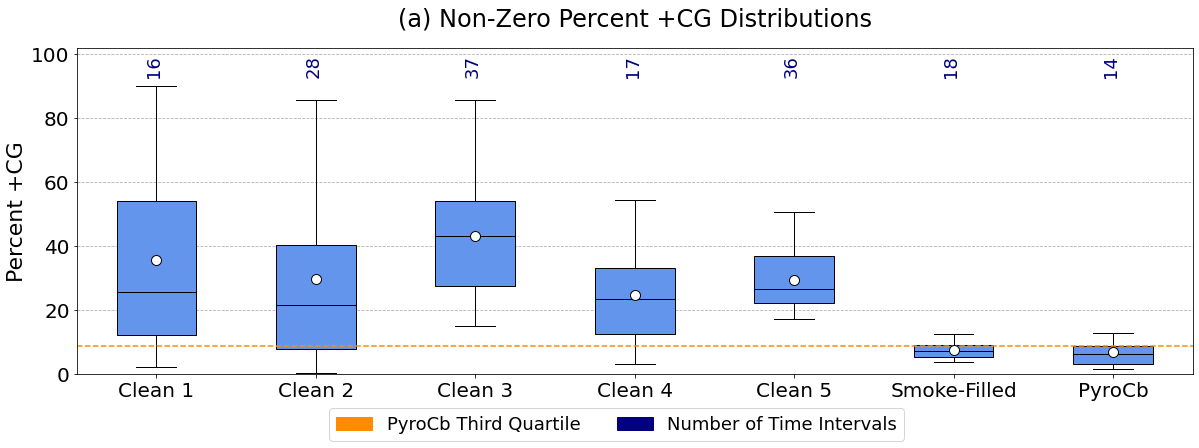

In [166]:
fig, ax = plt.subplots(figsize = (20,6))

ax.set_ylabel("Percent +CG", color = "black", fontsize = 22)
plt.yticks(fontsize = 20, color = "black")
plt.ylim(0, 102)
data = [clean1perpos, clean2perpos, clean3perpos, clean4perpos, 
        clean5perpos, smokeperpos, pyrocbperpos]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "cornflowerblue"))
        
labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5", "Smoke-Filled", "PyroCb"]  
ax.set_xticklabels(labels, fontsize = 20)

firstq = np.quantile(pyrocbperpos, 0.75)
plt.axhline(y=firstq,  linestyle='--', color = "darkorange")

x = np.arange(1, 8, 1)
for i in range(0, 7, 1):
    plt.annotate(len(data[i]), (x[i] - 0.07, 94), rotation=90, fontsize = 18, color = "navy")

orangeline = mpatches.Patch(facecolor='darkorange', edgecolor = "darkorange", label=("PyroCb Third Quartile"))
timecount = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Number of Time Intervals"))

firstlegend = fig.legend(handles=[orangeline, timecount], loc='lower center', 
            bbox_to_anchor=(0.5, -0.05),
            ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')
ax.set_title('(a) Non-Zero Percent +CG Distributions', fontsize = 24, y=1.05)

# plt.savefig("boxplot_posneg_parallax_allcases.png",bbox_inches = "tight", dpi = 800)
plt.show()


### include zeros be silly

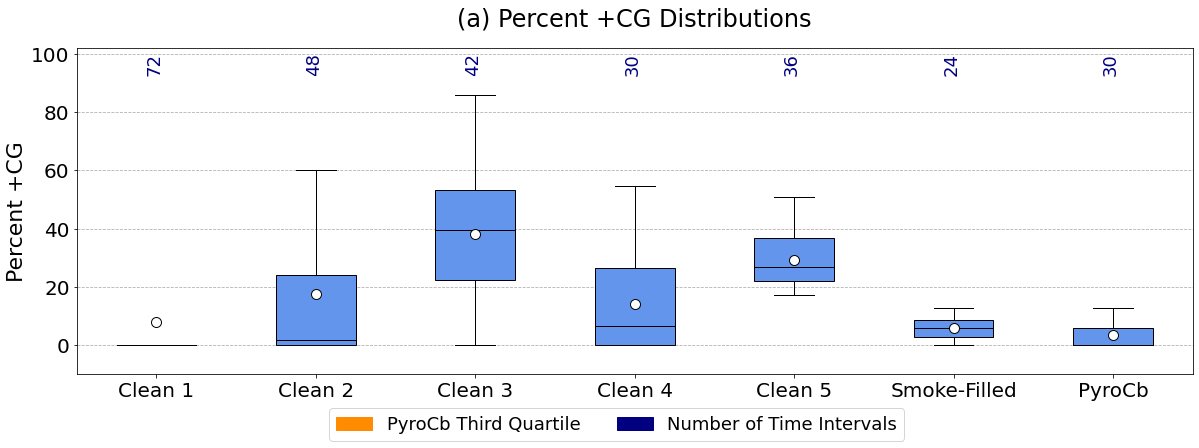

In [167]:
fig, ax = plt.subplots(figsize = (20,6))

ax.set_ylabel("Percent +CG", color = "black", fontsize = 22)
plt.yticks(fontsize = 20, color = "black")
plt.ylim(-10, 102)
data = [d3["percent_pos_current_cloud_ground_clean1"], d4["percent_pos_current_cloud_ground_clean2"], 
        d5["percent_pos_current_cloud_ground_clean3"], d6["percent_pos_current_cloud_ground_clean4"], 
       d7["percent_pos_current_cloud_ground_clean5"], d2["percent_pos_current_cloud_ground_smoke"],
       d1["percent_pos_current_cloud_ground_pyrocb"]]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "cornflowerblue"))
        
labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5", "Smoke-Filled", "PyroCb"]  
ax.set_xticklabels(labels, fontsize = 20)

x = np.arange(1, 8, 1)
for i in range(0, 7, 1):
    plt.annotate(len(data[i]), (x[i] - 0.07, 94), rotation=90, fontsize = 18, color = "navy")

orangeline = mpatches.Patch(facecolor='darkorange', edgecolor = "darkorange", label=("PyroCb Third Quartile"))
timecount = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Number of Time Intervals"))

firstlegend = fig.legend(handles=[orangeline, timecount], loc='lower center', 
            bbox_to_anchor=(0.5, -0.05),
            ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')
ax.set_title('(a) Percent +CG Distributions', fontsize = 24, y=1.05)

# plt.savefig("boxplot_posneg_parallax_allcases.png",bbox_inches = "tight", dpi = 800)
plt.show()


## mean median

In [168]:
np.median(d1["percent_pos_current_cloud_ground_pyrocb"][:-4]), np.max(d1["percent_pos_current_cloud_ground_pyrocb"])

(1.7403147699757868, 22.22222222222222)

In [169]:
np.median(d2["percent_pos_current_cloud_ground_smoke"]), np.max(d2["percent_pos_current_cloud_ground_smoke"])

(5.960478645719865, 12.727272727272727)

In [170]:
np.median(d3["percent_pos_current_cloud_ground_clean1"][15:50]), np.max(d3["percent_pos_current_cloud_ground_clean1"][15:50])

(0.0, 90.0)

In [171]:
np.median(d4["percent_pos_current_cloud_ground_clean2"]), np.max(d4["percent_pos_current_cloud_ground_clean2"])

(1.6912278472972115, 100.0)

In [172]:
np.median(d5["percent_pos_current_cloud_ground_clean3"]), np.max(d5["percent_pos_current_cloud_ground_clean3"])

(39.61038961038961, 85.71428571428571)

In [173]:
np.median(d6["percent_pos_current_cloud_ground_clean4"]), np.max(d6["percent_pos_current_cloud_ground_clean4"])

(6.666666666666667, 54.54545454545454)

In [174]:
np.median(d7["percent_pos_current_cloud_ground_clean5"]), np.max(d7["percent_pos_current_cloud_ground_clean5"])

(26.6820559178666, 50.69444444444444)

In [175]:
print(d1["pos_cloud_ground_pyrocb"])  
print(d1["percent_pos_current_cloud_ground_pyrocb"])  


[1.0, 1.0, 2.0, 2.0, 0.0, 4.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
[6.25, 7.6923076923076925, 10.0, 6.25, 0.0, 12.903225806451612, 0.0, 1.7857142857142856, 4.444444444444445, 3.0303030303030303, 1.9607843137254901, 0.0, 1.694915254237288, 3.4482758620689653, 0.0, 0.0, 9.090909090909092, 8.333333333333332, 22.22222222222222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# CC : CG Timeseries

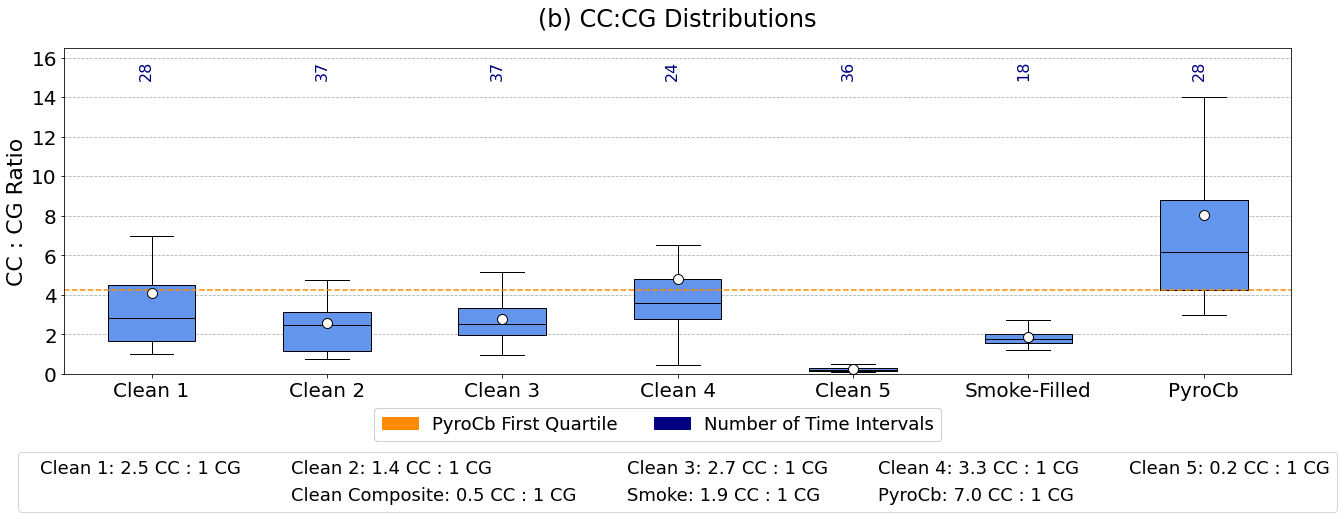

In [176]:
fig, ax = plt.subplots(figsize = (22,6))

ax.set_ylabel("CC : CG Ratio", color = "black", fontsize = 22)
plt.ylim(0, 16.5)
plt.yticks(fontsize = 20, color = "black")

data = [clean1_cccg_array, clean2_cccg_array, clean3_cccg_array, clean4_cccg_array, clean5_cccg_array, 
       smoke_cccg_array, pyrocb_cccg_array]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "cornflowerblue"))
        
labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5", "Smoke-Filled", "PyroCb"]  
ax.set_xticklabels(labels, fontsize = 20)

firstq = np.quantile(pyrocb_cccg_array, 0.25)
plt.axhline(y=firstq,  linestyle='--', color = "darkorange")

x = np.arange(1, 8, 1)
for i in range(0, 7, 1):
    plt.annotate(len(data[i]), (x[i] - 0.07, 15), rotation=90, fontsize = 16, color = "navy")

orangeline = mpatches.Patch(facecolor='darkorange', edgecolor = "darkorange", label=("PyroCb First Quartile"))
timecount = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Number of Time Intervals"))

firstlegend = fig.legend(handles=[orangeline, timecount], loc='lower center', 
            bbox_to_anchor=(0.5, -0.05),
            ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)

ax.add_artist(firstlegend)


clean1_patch = mpatches.Patch(color='white', label='Clean 1: {:.1f} CC : 1 CG'.format(len(clean1_cloud_flat) / (len(clean1_pos_ground_flat) + len(clean1_neg_ground_flat))))
clean2_patch = mpatches.Patch(color='white', label='Clean 2: {:.1f} CC : 1 CG'.format(len(clean2_cloud_flat) / (len(clean2_pos_ground_flat) + len(clean2_neg_ground_flat))))
clean3_patch = mpatches.Patch(color='white', label='Clean 3: {:.1f} CC : 1 CG'.format(len(clean3_cloud_flat) / (len(clean3_pos_ground_flat) + len(clean3_neg_ground_flat))))
clean4_patch = mpatches.Patch(color='white', label='Clean 4: {:.1f} CC : 1 CG'.format(len(clean4_cloud_flat) / (len(clean4_pos_ground_flat) + len(clean4_neg_ground_flat))))
clean5_patch = mpatches.Patch(color='white', label='Clean 5: {:.1f} CC : 1 CG'.format(len(clean5_cloud_flat) / (len(clean5_pos_ground_flat) + len(clean5_neg_ground_flat))))
clean_patch = mpatches.Patch(color='white', label='Clean Composite: {:.1f} CC : 1 CG'.format(len(clean_cloud_flat) / (len(clean_pos_ground_flat) + len(clean_neg_ground_flat))))
smoke_patch = mpatches.Patch(color='white', label='Smoke: {:.1f} CC : 1 CG'.format(len(smoke_cloud_flat) / (len(smoke_pos_ground_flat) + len(smoke_neg_ground_flat))))
pyrocb_patch = mpatches.Patch(color='white', label='PyroCb: {:.1f} CC : 1 CG'.format(len(pyrocb_cloud_flat) / (len(pyrocb_pos_ground_flat) + len(pyrocb_neg_ground_flat))))
blank_patch = mpatches.Patch(color='white')

ax.legend(handles=[clean1_patch, blank_patch, clean2_patch, clean_patch, clean3_patch, smoke_patch, 
                   clean4_patch, pyrocb_patch, clean5_patch, blank_patch], fontsize = 18, loc='lower center', 
           bbox_to_anchor=(0.5, -0.45),
          ncol=5, fancybox=True, shadow=False, 
          handlelength=0, handleheight=1)

plt.gca().yaxis.grid(True, linestyle='--')
ax.set_title('(b) CC:CG Distributions', fontsize = 24, y = 1.05)

# plt.savefig("boxplot_posneg_parallax_allcases.png",bbox_inches = "tight", dpi = 800)
plt.show()


# Statistics Yucky (Julia would enjoy)
- pvalue > 0.05 : samples are the same
- pvalue < 0.05 : samples are statistically different 

## peak current

### pyrocb and clean composite

In [177]:
pyrocb_neg_ground_stat = correct_pyrocb.loc[(correct_pyrocb.polarity == "-") & (correct_pyrocb["C or G"] == "G")]
pyrocb_neg_ground_stat = pyrocb_neg_ground_stat["peak-current"]
pyrocb_neg_ground_stat = np.array(pyrocb_neg_ground_stat)

pyrocb_pos_ground_stat = correct_pyrocb.loc[(correct_pyrocb.polarity == "+") & (correct_pyrocb["C or G"] == "G")]
pyrocb_pos_ground_stat = pyrocb_pos_ground_stat["peak-current"]
pyrocb_pos_ground_stat = np.array(pyrocb_pos_ground_stat)

pyrocb_cloud_stat = correct_pyrocb.loc[(correct_pyrocb["C or G"] == "C")]
pyrocb_cloud_stat = pyrocb_cloud_stat["peak-current"]
pyrocb_cloud_stat = np.array(pyrocb_cloud_stat)

In [178]:
clean_neg_ground_stat = lt_plx_clean.loc[(lt_plx_clean["peak current"] < 0) & (lt_plx_clean["C or G"] == "G")]
clean_neg_ground_stat = clean_neg_ground_stat["peak current"]
clean_neg_ground_stat = np.array(clean_neg_ground_stat)

clean_pos_ground_stat = lt_plx_clean.loc[(lt_plx_clean["peak current"] > 0) & (lt_plx_clean["C or G"] == "G")]
clean_pos_ground_stat = clean_pos_ground_stat["peak current"]
clean_pos_ground_stat = np.array(clean_pos_ground_stat)

clean_cloud_stat = lt_plx_clean.loc[(lt_plx_clean["C or G"] == "C")]
clean_cloud_stat = clean_cloud_stat["peak current"]
clean_cloud_stat = np.array(clean_cloud_stat)

In [179]:
{scipy.stats.ttest_ind(pyrocb_cloud_stat, clean_cloud_stat)[1],
scipy.stats.ttest_ind(pyrocb_neg_ground_stat, clean_neg_ground_stat)[1],
scipy.stats.ttest_ind(pyrocb_pos_ground_stat, clean_pos_ground_stat)[1]}

{2.737003747022606e-09, 0.00040908500479434223, 0.04597484337467406}

### pyrocb and smoke-filled

In [180]:
smoke_neg_ground_stat = correct_smoke.loc[(correct_smoke.polarity == "-") & (correct_smoke["C or G"] == "G")]
smoke_neg_ground_stat = smoke_neg_ground_stat["peak-current"]
smoke_neg_ground_stat = np.array(smoke_neg_ground_stat)

smoke_pos_ground_stat = correct_smoke.loc[(correct_smoke.polarity == "+") & (correct_smoke["C or G"] == "G")]
smoke_pos_ground_stat = smoke_pos_ground_stat["peak-current"]
smoke_pos_ground_stat = np.array(smoke_pos_ground_stat)

smoke_cloud_stat = correct_smoke.loc[(correct_smoke["C or G"] == "C")]
smoke_cloud_stat = smoke_cloud_stat["peak-current"]
smoke_cloud_stat = np.array(smoke_cloud_stat)

In [181]:
{scipy.stats.ttest_ind(pyrocb_cloud_stat, smoke_cloud_stat)[1],
scipy.stats.ttest_ind(pyrocb_neg_ground_stat, smoke_neg_ground_stat)[1],
scipy.stats.ttest_ind(pyrocb_pos_ground_stat, smoke_pos_ground_stat)[1]}

{1.4634318475590462e-63, 7.04538304290421e-24, 3.192426849049353e-05}

### pyrocb and individual clean

In [182]:
clean1_pos_ground_stat = lt_plx_clean1.loc[(lt_plx_clean1["peak current"] > 0) & (lt_plx_clean1["C or G"] == "G")]
clean1_pos_ground_stat = clean1_pos_ground_stat["peak current"]
clean1_pos_ground_stat = np.array(clean1_pos_ground_stat)

clean2_pos_ground_stat = lt_plx_clean2.loc[(lt_plx_clean2["peak current"] > 0) & (lt_plx_clean2["C or G"] == "G")]
clean2_pos_ground_stat = clean2_pos_ground_stat["peak current"]
clean2_pos_ground_stat = np.array(clean2_pos_ground_stat)

clean3_pos_ground_stat = lt_plx_clean3.loc[(lt_plx_clean3["peak current"] > 0) & (lt_plx_clean3["C or G"] == "G")]
clean3_pos_ground_stat = clean3_pos_ground_stat["peak current"]
clean3_pos_ground_stat = np.array(clean3_pos_ground_stat)

clean4_pos_ground_stat = lt_plx_clean4.loc[(lt_plx_clean4["peak current"] > 0) & (lt_plx_clean4["C or G"] == "G")]
clean4_pos_ground_stat = clean4_pos_ground_stat["peak current"]
clean4_pos_ground_stat = np.array(clean4_pos_ground_stat)

clean5_pos_ground_stat = lt_plx_clean5.loc[(lt_plx_clean5["peak current"] > 0) & (lt_plx_clean5["C or G"] == "G")]
clean5_pos_ground_stat = clean5_pos_ground_stat["peak current"]
clean5_pos_ground_stat = np.array(clean5_pos_ground_stat)


In [183]:
clean1_neg_ground_stat = lt_plx_clean1.loc[(lt_plx_clean1["peak current"] < 0) & (lt_plx_clean1["C or G"] == "G")]
clean1_neg_ground_stat = clean1_neg_ground_stat["peak current"]
clean1_neg_ground_stat = np.array(clean1_neg_ground_stat)

clean2_neg_ground_stat = lt_plx_clean2.loc[(lt_plx_clean2["peak current"] < 0) & (lt_plx_clean2["C or G"] == "G")]
clean2_neg_ground_stat = clean2_neg_ground_stat["peak current"]
clean2_neg_ground_stat = np.array(clean2_neg_ground_stat)

clean3_neg_ground_stat = lt_plx_clean3.loc[(lt_plx_clean3["peak current"] < 0) & (lt_plx_clean3["C or G"] == "G")]
clean3_neg_ground_stat = clean3_neg_ground_stat["peak current"]
clean3_neg_ground_stat = np.array(clean3_neg_ground_stat)

clean4_neg_ground_stat = lt_plx_clean4.loc[(lt_plx_clean4["peak current"] < 0) & (lt_plx_clean4["C or G"] == "G")]
clean4_neg_ground_stat = clean4_neg_ground_stat["peak current"]
clean4_neg_ground_stat = np.array(clean4_neg_ground_stat)

clean5_neg_ground_stat = lt_plx_clean5.loc[(lt_plx_clean5["peak current"] < 0) & (lt_plx_clean5["C or G"] == "G")]
clean5_neg_ground_stat = clean5_neg_ground_stat["peak current"]
clean5_neg_ground_stat = np.array(clean5_neg_ground_stat)


In [184]:
clean1_cloud_stat = lt_plx_clean1.loc[(lt_plx_clean1["C or G"] == "C")]
clean1_cloud_stat = clean1_cloud_stat["peak current"]
clean1_cloud_stat = np.array(clean1_cloud_stat)

clean2_cloud_stat = lt_plx_clean2.loc[(lt_plx_clean2["C or G"] == "C")]
clean2_cloud_stat = clean2_cloud_stat["peak current"]
clean2_cloud_stat = np.array(clean2_cloud_stat)

clean3_cloud_stat = lt_plx_clean3.loc[(lt_plx_clean3["C or G"] == "C")]
clean3_cloud_stat = clean3_cloud_stat["peak current"]
clean3_cloud_stat = np.array(clean3_cloud_stat)

clean4_cloud_stat = lt_plx_clean4.loc[(lt_plx_clean4["C or G"] == "C")]
clean4_cloud_stat = clean4_cloud_stat["peak current"]
clean4_cloud_stat = np.array(clean4_cloud_stat)

clean5_cloud_stat = lt_plx_clean5.loc[(lt_plx_clean5["C or G"] == "C")]
clean5_cloud_stat = clean5_cloud_stat["peak current"]
clean5_cloud_stat = np.array(clean5_cloud_stat)


In [185]:
print("Clean 1 CC {}, -CG {}, +CG {}".format(scipy.stats.ttest_ind(pyrocb_cloud_stat, clean1_cloud_stat)[1],
scipy.stats.ttest_ind(pyrocb_neg_ground_stat, clean1_neg_ground_stat)[1],
scipy.stats.ttest_ind(pyrocb_pos_ground_stat, clean1_pos_ground_stat)[1]))

print("Clean 2 CC {}, -CG {}, +CG {}".format(scipy.stats.ttest_ind(pyrocb_cloud_stat, clean2_cloud_stat)[1],
scipy.stats.ttest_ind(pyrocb_neg_ground_stat, clean2_neg_ground_stat)[1],
scipy.stats.ttest_ind(pyrocb_pos_ground_stat, clean2_pos_ground_stat)[1])) 

print("Clean 3 CC {}, -CG {}, +CG {}".format(scipy.stats.ttest_ind(pyrocb_cloud_stat, clean3_cloud_stat)[1],
scipy.stats.ttest_ind(pyrocb_neg_ground_stat, clean3_neg_ground_stat)[1],
scipy.stats.ttest_ind(pyrocb_pos_ground_stat, clean3_pos_ground_stat)[1])) 

print("Clean 4 CC {}, -CG {}, +CG {}".format(scipy.stats.ttest_ind(pyrocb_cloud_stat, clean4_cloud_stat)[1],
scipy.stats.ttest_ind(pyrocb_neg_ground_stat, clean4_neg_ground_stat)[1],
scipy.stats.ttest_ind(pyrocb_pos_ground_stat, clean4_pos_ground_stat)[1]))

print("Clean 5 CC {}, -CG {}, +CG {}".format(scipy.stats.ttest_ind(pyrocb_cloud_stat, clean5_cloud_stat)[1],
scipy.stats.ttest_ind(pyrocb_neg_ground_stat, clean5_neg_ground_stat)[1],
scipy.stats.ttest_ind(pyrocb_pos_ground_stat, clean5_pos_ground_stat)[1]))


Clean 1 CC 0.6336527703788979, -CG 1.5783930153081256e-11, +CG 0.03489707562026561
Clean 2 CC 1.0415064574452296e-159, -CG 2.6515568268236492e-17, +CG 9.876487991373719e-05
Clean 3 CC 1.0018106533496236e-61, -CG 3.441417480050767e-20, +CG 0.001261445105140208
Clean 4 CC 6.998567225329053e-28, -CG 4.627367770443499e-12, +CG 1.1601708182666227e-05
Clean 5 CC 4.972672395392104e-38, -CG 3.865834790366084e-13, +CG 0.053409371068577245


## Percent Positive CG 

In [186]:
#pyrocbperpos
{scipy.stats.ttest_ind(pyrocbperpos, smokeperpos)[1],
scipy.stats.ttest_ind(pyrocbperpos, clean1perpos)[1],
scipy.stats.ttest_ind(pyrocbperpos, clean2perpos)[1], 
scipy.stats.ttest_ind(pyrocbperpos, clean3perpos)[1], 
scipy.stats.ttest_ind(pyrocbperpos, clean4perpos)[1], 
scipy.stats.ttest_ind(pyrocbperpos, clean5perpos)[1]}

{1.6094647363345987e-10,
 3.921583878278895e-09,
 0.00026407504957760787,
 0.0015373497014251165,
 0.006257806107501445,
 0.702216259382332}

In [187]:
{scipy.stats.ttest_ind(clean1perpos, clean2perpos)[1],
scipy.stats.ttest_ind(clean1perpos, clean3perpos)[1],
scipy.stats.ttest_ind(clean1perpos, clean4perpos)[1], 
scipy.stats.ttest_ind(clean1perpos, clean5perpos)[1], 
scipy.stats.ttest_ind(clean2perpos, clean3perpos)[1], 
scipy.stats.ttest_ind(clean2perpos, clean4perpos)[1], 
scipy.stats.ttest_ind(clean2perpos, clean5perpos)[1], 
scipy.stats.ttest_ind(clean3perpos, clean4perpos)[1], 
scipy.stats.ttest_ind(clean3perpos, clean5perpos)[1], 
scipy.stats.ttest_ind(clean4perpos, clean5perpos)[1]}


{0.00014571186274518416,
 0.0006814041429083367,
 0.027576008718207024,
 0.18267632667509104,
 0.1867001774844522,
 0.24669932375213255,
 0.27332748397851864,
 0.5010588053656762,
 0.5268486255172464,
 0.9129791333522139}

## CC:CG

In [188]:
# clean1_cccg_array, clean2_cccg_array, clean3_cccg_array, clean4_cccg_array, clean5_cccg_array, 
# smoke_cccg_array, pyrocb_cccg_array
{scipy.stats.ttest_ind(pyrocb_cccg_array, smoke_cccg_array)[1],
scipy.stats.ttest_ind(pyrocb_cccg_array, clean1_cccg_array)[1],
scipy.stats.ttest_ind(pyrocb_cccg_array, clean2_cccg_array)[1], 
scipy.stats.ttest_ind(pyrocb_cccg_array, clean3_cccg_array)[1], 
scipy.stats.ttest_ind(pyrocb_cccg_array, clean4_cccg_array)[1], 
scipy.stats.ttest_ind(pyrocb_cccg_array, clean5_cccg_array)[1]}

{4.634360689124001e-10,
 6.034549760708714e-06,
 7.349919400659533e-06,
 0.0001838441525481346,
 0.013072623976348001,
 0.04652314166628841}

# Percent below 10 kA

## pyroCb < 10 kA

In [189]:
pyrocb_neg_ground_below = len(pyrocb_neg_ground_stat[(pyrocb_neg_ground_stat >= -10)]) / len(pyrocb_neg_ground_stat)
pyrocb_pos_ground_below = len(pyrocb_pos_ground_stat[(pyrocb_pos_ground_stat <= 10)]) / len(pyrocb_pos_ground_stat)

pyrocb_neg_ground_below, pyrocb_pos_ground_below


(0.2637037037037037, 0.5652173913043478)

## smoke-filled < 10 kA

In [190]:
smoke_neg_ground_below = len(smoke_neg_ground_stat[(smoke_neg_ground_stat >= -10)]) / len(smoke_neg_ground_stat)
smoke_pos_ground_below = len(smoke_pos_ground_stat[(smoke_pos_ground_stat <= 10)]) / len(smoke_pos_ground_stat)

smoke_neg_ground_below, smoke_pos_ground_below


(0.11816250663834307, 0.11692650334075724)

## clean < 10 kA

In [191]:
clean1_neg_ground_below = len(clean1_neg_ground_stat[(clean1_neg_ground_stat >= -10)]) / len(clean1_neg_ground_stat)
clean1_pos_ground_below = len(clean1_pos_ground_stat[(clean1_pos_ground_stat <= 10)]) / len(clean1_pos_ground_stat)

clean2_neg_ground_below = len(clean2_neg_ground_stat[(clean2_neg_ground_stat >= -10)]) / len(clean2_neg_ground_stat)
clean2_pos_ground_below = len(clean2_pos_ground_stat[(clean2_pos_ground_stat <= 10)]) / len(clean2_pos_ground_stat)

clean3_neg_ground_below = len(clean3_neg_ground_stat[(clean3_neg_ground_stat >= -10)]) / len(clean3_neg_ground_stat)
clean3_pos_ground_below = len(clean3_pos_ground_stat[(clean3_pos_ground_stat <= 10)]) / len(clean3_pos_ground_stat)

clean4_neg_ground_below = len(clean4_neg_ground_stat[(clean4_neg_ground_stat >= -10)]) / len(clean4_neg_ground_stat)
clean4_pos_ground_below = len(clean4_pos_ground_stat[(clean4_pos_ground_stat <= 10)]) / len(clean4_pos_ground_stat)

clean5_neg_ground_below = len(clean5_neg_ground_stat[(clean5_neg_ground_stat >= -10)]) / len(clean5_neg_ground_stat)
clean5_pos_ground_below = len(clean5_pos_ground_stat[(clean5_pos_ground_stat <= 10)]) / len(clean5_pos_ground_stat)

clean_neg_ground_below = len(clean_neg_ground_stat[(clean_neg_ground_stat >= -10)]) / len(clean_neg_ground_stat)
clean_pos_ground_below = len(clean_pos_ground_stat[(clean_pos_ground_stat <= 10)]) / len(clean_pos_ground_stat)

print("clean 1 {}, {}, \nclean 2 {}, {}, \nclean 3 {}, {}, \nclean 4 {}, {}, \nclean 5 {}, {}, \nclean {}, {}".format(
    clean1_neg_ground_below, clean1_pos_ground_below, 
    clean2_neg_ground_below, clean2_pos_ground_below, 
    clean3_neg_ground_below, clean3_pos_ground_below, 
    clean4_neg_ground_below, clean4_pos_ground_below,
    clean5_neg_ground_below, clean5_pos_ground_below, 
    clean_neg_ground_below, clean_pos_ground_below))


clean 1 0.14871794871794872, 0.36507936507936506, 
clean 2 0.35612153708668454, 0.10526315789473684, 
clean 3 0.13953488372093023, 0.25, 
clean 4 0.16271186440677965, 0.0, 
clean 5 0.08746355685131195, 0.40916384382242826, 
clean 0.12234812559277193, 0.3804231998782159


# figures with % < 10kA

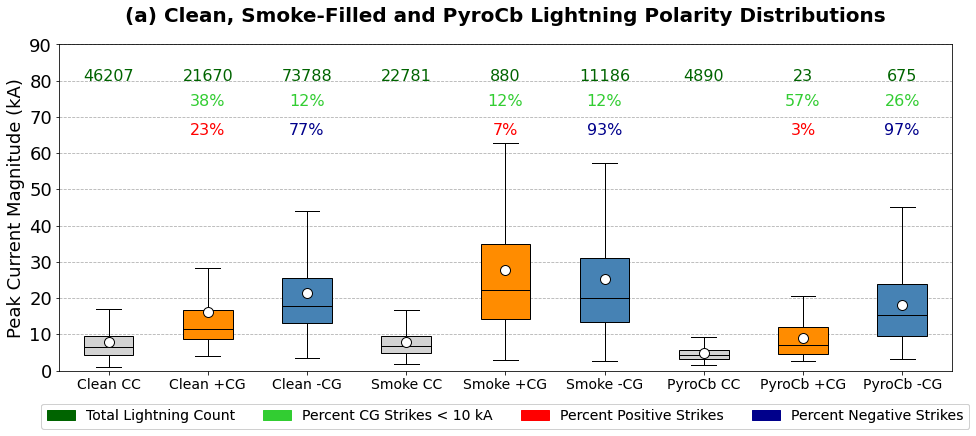

In [193]:

fig, ax = plt.subplots(figsize = (16,6))

ax.set_ylabel("Peak Current Magnitude (kA)", color = "black", fontsize = 18)

plt.ylim(0, 90)
plt.yticks(fontsize = 18, color = "black")

data = [ np.abs(clean_cloud_flat), clean_pos_ground_flat, np.abs(clean_neg_ground_flat),
        np.abs(smoke_cloud_flat), smoke_pos_ground_flat, np.abs(smoke_neg_ground_flat), 
        np.abs(pyrocb_cloud_flat), pyrocb_pos_ground_flat, np.abs(pyrocb_neg_ground_flat)]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 2, 3, 4, 5, 6, 7, 8]) # , positions = [0, 1, 3, 4, 6, 7]

ax.spines['right'].set_color('black')

color1 = ['lightgray', 'darkorange', 'steelblue', 
          'lightgray', 'darkorange', 'steelblue', 
          'lightgray', 'darkorange', 'steelblue'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

# color2 = ['steelblue', 'steelblue', 'steelblue']
# for patch, color in zip(box2['boxes'], color2):
#     patch.set_facecolor(color)
        
labels = [ "Clean CC", "Clean +CG", "Clean -CG", "Smoke CC", "Smoke +CG", "Smoke -CG", "PyroCb CC",  "PyroCb +CG",  "PyroCb -CG"]  
ax.set_xticklabels(labels, fontsize = 14)

# clean length count 
plt.annotate("{:.0f}".format(len(clean_cloud_flat)), xy =(0, 80), fontsize = 16, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(clean_pos_ground_flat)), xy =(1, 80), fontsize = 16, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(clean_neg_ground_flat)), xy =(2, 80), fontsize = 16, color = "darkgreen", ha='center')

# smoke length count 
plt.annotate("{:.0f}".format(len(smoke_cloud_flat)), xy =(3, 80), fontsize = 16, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(smoke_pos_ground_flat)), xy =(4, 80), fontsize = 16, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(smoke_neg_ground_flat)), xy =(5, 80), fontsize = 16, color = "darkgreen", ha='center')

#pyrocb length count 
plt.annotate("{:.0f}".format(len(pyrocb_cloud_flat)), xy =(6, 80), fontsize = 16, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(pyrocb_pos_ground_flat)), xy =(7, 80), fontsize = 16, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(pyrocb_neg_ground_flat)), xy =(8, 80), fontsize = 16, color = "darkgreen", ha='center')

# clean <10kA 
plt.annotate("{:.0f}%".format(clean_pos_ground_below * 100), xy =(1, 73), fontsize = 16, color = "limegreen", ha='center')
plt.annotate("{:.0f}%".format(clean_neg_ground_below * 100), xy =(2, 73), fontsize = 16, color = "limegreen", ha='center')

# smoke <10kA
plt.annotate("{:.0f}%".format(smoke_pos_ground_below * 100), xy =(4, 73), fontsize = 16, color = "limegreen", ha='center')
plt.annotate("{:.0f}%".format(smoke_neg_ground_below * 100), xy =(5, 73), fontsize = 16, color = "limegreen", ha='center')

#pyrocb <10kA 
plt.annotate("{:.0f}%".format(pyrocb_pos_ground_below * 100), xy =(7, 73), fontsize = 16, color = "limegreen", ha='center')
plt.annotate("{:.0f}%".format(pyrocb_neg_ground_below * 100), xy =(8, 73), fontsize = 16, color = "limegreen", ha='center')

# clean percentage 
a = (len(clean_pos_ground_flat)/ (len(clean_pos_ground_flat) + len(clean_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(a), xy =(1, 65), fontsize = 16, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - a), xy =(2, 65), fontsize = 16, color = "darkblue", ha='center')

# smoke percentage 
b = (len(smoke_pos_ground_flat)/ (len(smoke_pos_ground_flat) + len(smoke_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(b), xy =(4, 65), fontsize = 16, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - b), xy =(5, 65), fontsize = 16, color = "darkblue", ha='center')

# pyrocb percentage 
c = (len(pyrocb_pos_ground_flat)/ (len(pyrocb_pos_ground_flat) + len(pyrocb_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(c), xy =(7, 65), fontsize = 16, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - c), xy =(8, 65), fontsize = 16, color = "darkblue", ha='center')

darkgreen_patch = mpatches.Patch(color='darkgreen', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='Percent Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='Percent Negative Strikes')
limegreen_patch = mpatches.Patch(color='limegreen', label='Percent CG Strikes < 10 kA')

firstlegend = ax.legend(handles=[darkgreen_patch, limegreen_patch, red_patch, blue_patch], fontsize = 14,loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
          ncol=4, fancybox=True, shadow=False)
ax.add_artist(firstlegend)


# clean_patch = mpatches.Patch(color='white', label='Clean: {:.1f} CC : 1 CG'.format(len(clean_cloud_flat) / (len(clean_pos_ground_flat) + len(clean_neg_ground_flat))))
# smoke_patch = mpatches.Patch(color='white', label='Smoke: {:.1f} CC : 1 CG'.format(len(smoke_cloud_flat) / (len(smoke_pos_ground_flat) + len(smoke_neg_ground_flat))))
# pyrocb_patch = mpatches.Patch(color='white', label='PyroCb: {:.1f} CC : 1 CG'.format(len(pyrocb_cloud_flat) / (len(pyrocb_pos_ground_flat) + len(pyrocb_neg_ground_flat))))
# blank_patch = mpatches.Patch(color='white')

# ax.legend(handles=[clean_patch, smoke_patch, pyrocb_patch], fontsize = 14,loc='lower center', 
#            bbox_to_anchor=(0.5, -0.3),
#           ncol=3, fancybox=True, shadow=False)


plt.gca().yaxis.grid(True, linestyle='--')
ax.set_title('(a) Clean, Smoke-Filled and PyroCb Lightning Polarity Distributions',fontweight='bold',  fontsize = 20, y = 1.05)

plt.savefig("boxplot_posneg_parallax_allcases.png",bbox_inches = "tight", dpi = 800)
plt.show()


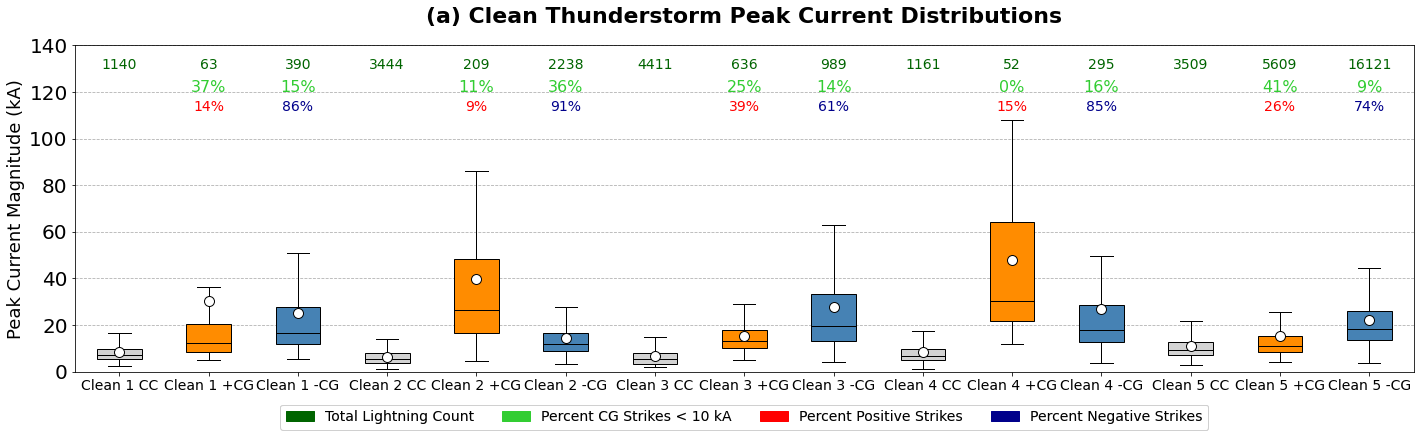

In [194]:

fig, ax = plt.subplots(figsize = (24,6))

ax.set_ylabel("Peak Current Magnitude (kA)", color = "black", fontsize = 18)
plt.yticks(fontsize = 20)
plt.ylim(0, 140)
plt.yticks(fontsize = 20, color = "black")

data = [np.abs(clean1_cloud_flat), clean1_pos_ground_flat, np.abs(clean2_cloud_flat), 
        clean2_pos_ground_flat, np.abs(clean3_cloud_flat), clean3_pos_ground_flat, 
       np.abs(clean4_cloud_flat), clean4_pos_ground_flat, np.abs(clean5_cloud_flat), clean5_pos_ground_flat]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1, 3, 4, 6, 7, 9, 10, 12, 13]) # , positions = [0, 2, 4, 6]


data2 = [np.abs(clean1_neg_ground_flat), np.abs(clean2_neg_ground_flat),  
         np.abs(clean3_neg_ground_flat),  np.abs(clean4_neg_ground_flat),  np.abs(clean5_neg_ground_flat)] 
box2 = ax.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [2, 5, 8, 11, 14]) # 


color1 = ['lightgray', 'darkorange', 'lightgray', 'darkorange', 'lightgray', 'darkorange', 'lightgray', 'darkorange', 'lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue', 'steelblue', 'steelblue',  'steelblue', 'steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["Clean 1 CC",  "Clean 1 +CG", "Clean 2 CC", "Clean 2 +CG", "Clean 3 CC", "Clean 3 +CG",
          "Clean 4 CC", "Clean 4 +CG", "Clean 5 CC", "Clean 5 +CG",
          "Clean 1 -CG","Clean 2 -CG", "Clean 3 -CG","Clean 4 -CG", "Clean 5 -CG"]  
ax.set_xticklabels(labels, fontsize = 14)

# clean length count 
plt.annotate("{:.0f}".format(len(clean1_cloud_flat)), xy =(0, 130), fontsize = 14, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(clean1_pos_ground_flat)), xy =(1, 130), fontsize = 14, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(clean1_neg_ground_flat)), xy =(2, 130), fontsize = 14, color = "darkgreen", ha='center')

# clean length count 
plt.annotate("{:.0f}".format(len(clean2_cloud_flat)), xy =(3, 130), fontsize = 14, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(clean2_pos_ground_flat)), xy =(4, 130), fontsize = 14, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(clean2_neg_ground_flat)), xy =(5, 130), fontsize = 14, color = "darkgreen", ha='center')

# clean length count 
plt.annotate("{:.0f}".format(len(clean3_cloud_flat)), xy =(6, 130), fontsize = 14, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(clean3_pos_ground_flat)), xy =(7, 130), fontsize = 14, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(clean3_neg_ground_flat)), xy =(8, 130), fontsize = 14, color = "darkgreen", ha='center')

# clean length count 
plt.annotate("{:.0f}".format(len(clean4_cloud_flat)), xy =(9, 130), fontsize = 14, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(clean4_pos_ground_flat)), xy =(10, 130), fontsize = 14, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(clean4_neg_ground_flat)), xy =(11, 130), fontsize = 14, color = "darkgreen", ha='center')

# clean length count 
plt.annotate("{:.0f}".format(len(clean5_cloud_flat)), xy =(12, 130), fontsize = 14, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(clean5_pos_ground_flat)), xy =(13, 130), fontsize = 14, color = "darkgreen", ha='center')
plt.annotate("{:.0f}".format(len(clean5_neg_ground_flat)), xy =(14, 130), fontsize = 14, color = "darkgreen", ha='center')

# ----------------------------------------------------

# clean 1 <10kA 
plt.annotate("{:.0f}%".format(clean1_pos_ground_below * 100), xy =(1, 120), fontsize = 16, color = "limegreen", ha='center')
plt.annotate("{:.0f}%".format(clean1_neg_ground_below * 100), xy =(2, 120), fontsize = 16, color = "limegreen", ha='center')

# clean 2 <10kA 
plt.annotate("{:.0f}%".format(clean2_pos_ground_below * 100), xy =(4, 120), fontsize = 16, color = "limegreen", ha='center')
plt.annotate("{:.0f}%".format(clean2_neg_ground_below * 100), xy =(5, 120), fontsize = 16, color = "limegreen", ha='center')

# clean 3 <10kA 
plt.annotate("{:.0f}%".format(clean3_pos_ground_below * 100), xy =(7, 120), fontsize = 16, color = "limegreen", ha='center')
plt.annotate("{:.0f}%".format(clean3_neg_ground_below * 100), xy =(8, 120), fontsize = 16, color = "limegreen", ha='center')

# clean 4 <10kA 
plt.annotate("{:.0f}%".format(clean4_pos_ground_below * 100), xy =(10, 120), fontsize = 16, color = "limegreen", ha='center')
plt.annotate("{:.0f}%".format(clean4_neg_ground_below * 100), xy =(11, 120), fontsize = 16, color = "limegreen", ha='center')

# clean 5 <10kA 
plt.annotate("{:.0f}%".format(clean5_pos_ground_below * 100), xy =(13, 120), fontsize = 16, color = "limegreen", ha='center')
plt.annotate("{:.0f}%".format(clean5_neg_ground_below * 100), xy =(14, 120), fontsize = 16, color = "limegreen", ha='center')

# ----------------------------------------------------

# clean percentage 
a = (len(clean1_pos_ground_flat)/ (len(clean1_pos_ground_flat) + len(clean1_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(a), xy =(1, 112), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - a), xy =(2, 112), fontsize = 14, color = "darkblue", ha='center')

b = (len(clean2_pos_ground_flat)/ (len(clean2_pos_ground_flat) + len(clean2_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(b), xy =(4, 112), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - b), xy =(5, 112), fontsize = 14, color = "darkblue", ha='center')

c = (len(clean3_pos_ground_flat)/ (len(clean3_pos_ground_flat) + len(clean3_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(c), xy =(7, 112), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - c), xy =(8, 112), fontsize = 14, color = "darkblue", ha='center')

d = (len(clean4_pos_ground_flat)/ (len(clean4_pos_ground_flat) + len(clean4_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(d), xy =(10, 112), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - d), xy =(11, 112), fontsize = 14, color = "darkblue", ha='center')

e = (len(clean5_pos_ground_flat)/ (len(clean5_pos_ground_flat) + len(clean5_neg_ground_flat)))*100
plt.annotate("{:.0f}%".format(e), xy =(13, 112), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - e), xy =(14, 112), fontsize = 14, color = "darkblue", ha='center')


darkgreen_patch = mpatches.Patch(color='darkgreen', label='Total Lightning Count')
limegreen_patch = mpatches.Patch(color='limegreen', label='Percent CG Strikes < 10 kA')
red_patch = mpatches.Patch(color='red', label='Percent Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='Percent Negative Strikes')

firstlegend = ax.legend(handles=[darkgreen_patch, limegreen_patch, red_patch, blue_patch], fontsize = 14,loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
          ncol=4, fancybox=True, shadow=False)

ax.add_artist(firstlegend)

ax.set_title('(a) Clean Thunderstorm Peak Current Distributions', fontweight='bold', fontsize = 22, y = 1.05)
plt.gca().yaxis.grid(True, linestyle='--')

plt.savefig("boxplot_posneg_parallax_cleancases.png",bbox_inches = "tight", dpi = 800)
plt.show()
